# Column generation approach

## Pre-requisites

In [1]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

from src import cg, config, dataset, layers, pack, superitems, utils, warm_start

In [2]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Dataset

In [4]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

width  depth  height  weight    volume
0    160    280     233       8  10438400
1    199    269     260      11  13918060
2    187    101     283       2   5345021
3    126    149     214       2   4017636
4    248    132     280       3   9166080

<IPython.core.display.Javascript object>

In [27]:
ordered_products = 50
order = product_dataset.get_order(ordered_products)
order.head()

id  width  depth  height  weight    volume
0  969379    338    136     424     691  19490432
1  424871    232    257     330       5  19675920
2  567760    276    242     458      70  30590736
3  835869    134    202     192      23   5197056
4  966920    175    357     267       2  16680825

<IPython.core.display.Javascript object>

In [6]:
order = pd.concat([order.sample(4)] * 5).reset_index(drop=True)
order.head()

id  width  depth  height  weight    volume
0  121958    193    221     371       2  15824263
1  671155    236    142     437      58  14644744
2   54886    249    142     388       3  13718904
3  644167    286    158     481       6  21735428
4  121958    193    221     371       2  15824263

<IPython.core.display.Javascript object>

In [28]:
order = order.sample(50).reset_index(drop=True)
order["height"] = 400
order.head()

id  width  depth  height  weight    volume
0  575919    200     94     400       4   4963200
1  185378    152    322     400       7  14144816
2  308877    269    210     400     286  18641700
3  966920    175    357     400       2  16680825
4  705860    163    244     400       2  11573652

<IPython.core.display.Javascript object>

## Martello's lower bounds

In [18]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [126]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [10]:
utils.get_l2_lb(order, config.PALLET_DIMS)

TypeError: get_l1_lb() takes 2 positional arguments but 4 were given

<IPython.core.display.Javascript object>

## Superitems

In [19]:
superitems_pool = superitems.SuperitemPool(
    order=order, pallet_dims=config.PALLET_DIMS, max_vstacked=4, not_horizontal=True
)
superitems_pool.to_dataframe()

Generating vertical superitems: 100%|██████████████████████████████████████████████████████████| 24/24 [00:00<?, ?it/s]


width  depth  height               ids                 type
0      366    256     400               [0]  SingleItemSuperitem
1      159     92     400               [1]  SingleItemSuperitem
2      269    144     400               [2]  SingleItemSuperitem
3      226    134     400               [3]  SingleItemSuperitem
4      159    304     400               [4]  SingleItemSuperitem
..     ...    ...     ...               ...                  ...
199    173    271    1600  [30, 53, 61, 71]    VerticalSuperitem
200    206    304    1600   [4, 51, 76, 93]    VerticalSuperitem
201    226    343    1600  [13, 16, 39, 50]    VerticalSuperitem
202    225    382    1600  [32, 64, 75, 90]    VerticalSuperitem
203    268    379    1600  [41, 42, 69, 91]    VerticalSuperitem

[204 rows x 5 columns]

<IPython.core.display.Javascript object>

In [37]:
df = superitems_pool.to_dataframe()
df[df["type"].str.contains("Vertical")]

width  depth  height               ids               type
100    151    141     516          [49, 73]  VerticalSuperitem
101    160    111     525          [16, 75]  VerticalSuperitem
102    176    155     503          [55, 65]  VerticalSuperitem
103    177    175     537          [78, 91]  VerticalSuperitem
104    178    174     421          [15, 24]  VerticalSuperitem
..     ...    ...     ...               ...                ...
201    196    242    1053  [11, 74, 77, 89]  VerticalSuperitem
202    222    269    1222  [44, 67, 79, 95]  VerticalSuperitem
203    237    291    1306  [13, 38, 69, 84]  VerticalSuperitem
204    268    318    1589   [2, 23, 40, 41]  VerticalSuperitem
205    277    371    1345  [18, 29, 81, 85]  VerticalSuperitem

[106 rows x 5 columns]

<IPython.core.display.Javascript object>

In [9]:
df = superitems_pool.to_dataframe()
df[df["type"].str.contains("Horizontal")]

Empty DataFrame
Columns: [width, depth, height, ids, type]
Index: []

<IPython.core.display.Javascript object>

## Height groups

In [9]:
height_groups = warm_start.get_height_groups(
    superitems_pool, config.PALLET_DIMS, height_tol=50, density_tol=0.5
)
for group in height_groups:
    display(group.to_dataframe())

width  depth  height    ids                 type
0     155    205     176   [42]  SingleItemSuperitem
1     178     83     195   [46]  SingleItemSuperitem
2     192    132     201   [65]  SingleItemSuperitem
3     157    159     173  [163]  SingleItemSuperitem
4     115    150     179  [182]  SingleItemSuperitem
5     126     82     161  [198]  SingleItemSuperitem
6     130    119     175  [209]  SingleItemSuperitem
7     143    186     189  [217]  SingleItemSuperitem
8     137    275     179  [230]  SingleItemSuperitem
9     128    121     184  [233]  SingleItemSuperitem
10    130     92     180  [243]  SingleItemSuperitem
11    157    135     199  [253]  SingleItemSuperitem
12    120     87     168  [269]  SingleItemSuperitem
13    158    433     198  [270]  SingleItemSuperitem
14    147    206     186  [307]  SingleItemSuperitem
15    125    150     208  [319]  SingleItemSuperitem
16    161    115     194  [370]  SingleItemSuperitem
17    146    329     209  [373]  SingleItemSuperitem
18    156    250     195  [389]  SingleItemSuperitem
19    151    175     208  [450]  SingleItemSuperitem
20    127    305     189  [490]  SingleItemSuperitem

width  depth  height    ids                 type
0     155    205     176   [42]  SingleItemSuperitem
1     178     83     195   [46]  SingleItemSuperitem
2     192    132     201   [65]  SingleItemSuperitem
3     190     91     215   [99]  SingleItemSuperitem
4     157    159     173  [163]  SingleItemSuperitem
5     115    150     179  [182]  SingleItemSuperitem
6     177    163     216  [195]  SingleItemSuperitem
7     130    119     175  [209]  SingleItemSuperitem
8     143    186     189  [217]  SingleItemSuperitem
9     137    275     179  [230]  SingleItemSuperitem
10    128    121     184  [233]  SingleItemSuperitem
11    130     92     180  [243]  SingleItemSuperitem
12    157    135     199  [253]  SingleItemSuperitem
13    131    227     214  [267]  SingleItemSuperitem
14    120     87     168  [269]  SingleItemSuperitem
15    158    433     198  [270]  SingleItemSuperitem
16    145    150     214  [282]  SingleItemSuperitem
17    147    206     186  [307]  SingleItemSuperitem
18    125    150     208  [319]  SingleItemSuperitem
19    144    240     215  [358]  SingleItemSuperitem
20    161    115     194  [370]  SingleItemSuperitem
21    146    329     209  [373]  SingleItemSuperitem
22    156    250     195  [389]  SingleItemSuperitem
23    155    123     215  [404]  SingleItemSuperitem
24    154    172     218  [440]  SingleItemSuperitem
25    151    175     208  [450]  SingleItemSuperitem
26    127    305     189  [490]  SingleItemSuperitem
27    205    170     218  [495]  SingleItemSuperitem
28    178    105     214  [498]  SingleItemSuperitem

width  depth  height    ids                 type
0     155    205     176   [42]  SingleItemSuperitem
1     178     83     195   [46]  SingleItemSuperitem
2     192    132     201   [65]  SingleItemSuperitem
3     140    174     223   [91]  SingleItemSuperitem
4     190     91     215   [99]  SingleItemSuperitem
5     157    159     173  [163]  SingleItemSuperitem
6     115    150     179  [182]  SingleItemSuperitem
7     177    163     216  [195]  SingleItemSuperitem
8     130    119     175  [209]  SingleItemSuperitem
9     142    184     223  [211]  SingleItemSuperitem
10    143    186     189  [217]  SingleItemSuperitem
11    198    294     222  [229]  SingleItemSuperitem
12    137    275     179  [230]  SingleItemSuperitem
13    128    121     184  [233]  SingleItemSuperitem
14    130     92     180  [243]  SingleItemSuperitem
15    157    135     199  [253]  SingleItemSuperitem
16    131    227     214  [267]  SingleItemSuperitem
17    158    433     198  [270]  SingleItemSuperitem
18    145    150     214  [282]  SingleItemSuperitem
19    180    317     222  [290]  SingleItemSuperitem
20    147    206     186  [307]  SingleItemSuperitem
21    125    150     208  [319]  SingleItemSuperitem
22    144    240     215  [358]  SingleItemSuperitem
23    161    115     194  [370]  SingleItemSuperitem
24    146    329     209  [373]  SingleItemSuperitem
25    156    250     195  [389]  SingleItemSuperitem
26    158    138     223  [393]  SingleItemSuperitem
27    155    123     215  [404]  SingleItemSuperitem
28    154    172     218  [440]  SingleItemSuperitem
29    147    106     220  [444]  SingleItemSuperitem
30    151    175     208  [450]  SingleItemSuperitem
31    138    191     220  [482]  SingleItemSuperitem
32    127    305     189  [490]  SingleItemSuperitem
33    205    170     218  [495]  SingleItemSuperitem
34    178    105     214  [498]  SingleItemSuperitem

width  depth  height    ids                 type
0     176    100     225   [24]  SingleItemSuperitem
1     155    205     176   [42]  SingleItemSuperitem
2     168    173     224   [43]  SingleItemSuperitem
3     178     83     195   [46]  SingleItemSuperitem
4     192    132     201   [65]  SingleItemSuperitem
5     179    176     225   [81]  SingleItemSuperitem
6     140    174     223   [91]  SingleItemSuperitem
7     190     91     215   [99]  SingleItemSuperitem
8     186    113     224  [144]  SingleItemSuperitem
9     138    210     225  [170]  SingleItemSuperitem
10    115    150     179  [182]  SingleItemSuperitem
11    177    163     216  [195]  SingleItemSuperitem
12    130    119     175  [209]  SingleItemSuperitem
13    142    184     223  [211]  SingleItemSuperitem
14    143    186     189  [217]  SingleItemSuperitem
15    198    294     222  [229]  SingleItemSuperitem
16    137    275     179  [230]  SingleItemSuperitem
17    128    121     184  [233]  SingleItemSuperitem
18    130     92     180  [243]  SingleItemSuperitem
19    144    152     224  [245]  SingleItemSuperitem
20    157    135     199  [253]  SingleItemSuperitem
21    131    227     214  [267]  SingleItemSuperitem
22    170    325     224  [268]  SingleItemSuperitem
23    158    433     198  [270]  SingleItemSuperitem
24    145    150     214  [282]  SingleItemSuperitem
25    180    317     222  [290]  SingleItemSuperitem
26    147    206     186  [307]  SingleItemSuperitem
27    125    150     208  [319]  SingleItemSuperitem
28    144    240     215  [358]  SingleItemSuperitem
29    149    164     225  [369]  SingleItemSuperitem
30    161    115     194  [370]  SingleItemSuperitem
31    146    329     209  [373]  SingleItemSuperitem
32    156    250     195  [389]  SingleItemSuperitem
33    158    138     223  [393]  SingleItemSuperitem
34    155    123     215  [404]  SingleItemSuperitem
35    154    172     218  [440]  SingleItemSuperitem
36    147    106     220  [444]  SingleItemSuperitem
37    151    175     208  [450]  SingleItemSuperitem
38    170    284     225  [457]  SingleItemSuperitem
39    138    191     220  [482]  SingleItemSuperitem
40    127    305     189  [490]  SingleItemSuperitem
41    205    170     218  [495]  SingleItemSuperitem
42    178    105     214  [498]  SingleItemSuperitem

width  depth  height    ids                 type
0     176    100     225   [24]  SingleItemSuperitem
1     155    205     176   [42]  SingleItemSuperitem
2     168    173     224   [43]  SingleItemSuperitem
3     178     83     195   [46]  SingleItemSuperitem
4     177    174     226   [55]  SingleItemSuperitem
5     192    132     201   [65]  SingleItemSuperitem
6     179    176     225   [81]  SingleItemSuperitem
7     140    174     223   [91]  SingleItemSuperitem
8     190     91     215   [99]  SingleItemSuperitem
9     186    113     224  [144]  SingleItemSuperitem
10    138    210     225  [170]  SingleItemSuperitem
11    115    150     179  [182]  SingleItemSuperitem
12    177    163     216  [195]  SingleItemSuperitem
13    142    184     223  [211]  SingleItemSuperitem
14    143    186     189  [217]  SingleItemSuperitem
15    198    294     222  [229]  SingleItemSuperitem
16    137    275     179  [230]  SingleItemSuperitem
17    128    121     184  [233]  SingleItemSuperitem
18    130     92     180  [243]  SingleItemSuperitem
19    144    152     224  [245]  SingleItemSuperitem
20    157    135     199  [253]  SingleItemSuperitem
21    131    227     214  [267]  SingleItemSuperitem
22    170    325     224  [268]  SingleItemSuperitem
23    158    433     198  [270]  SingleItemSuperitem
24    145    150     214  [282]  SingleItemSuperitem
25    180    317     222  [290]  SingleItemSuperitem
26    147    206     186  [307]  SingleItemSuperitem
27    110    274     226  [317]  SingleItemSuperitem
28    125    150     208  [319]  SingleItemSuperitem
29    144    240     215  [358]  SingleItemSuperitem
30    149    164     225  [369]  SingleItemSuperitem
31    161    115     194  [370]  SingleItemSuperitem
32    146    329     209  [373]  SingleItemSuperitem
33    156    250     195  [389]  SingleItemSuperitem
34    158    138     223  [393]  SingleItemSuperitem
35    155    123     215  [404]  SingleItemSuperitem
36    154    172     218  [440]  SingleItemSuperitem
37    147    106     220  [444]  SingleItemSuperitem
38    151    175     208  [450]  SingleItemSuperitem
39    170    284     225  [457]  SingleItemSuperitem
40    138    191     220  [482]  SingleItemSuperitem
41    127    305     189  [490]  SingleItemSuperitem
42    205    170     218  [495]  SingleItemSuperitem
43    178    105     214  [498]  SingleItemSuperitem

width  depth  height    ids                 type
0     176    100     225   [24]  SingleItemSuperitem
1     168    173     224   [43]  SingleItemSuperitem
2     178     83     195   [46]  SingleItemSuperitem
3     177    174     226   [55]  SingleItemSuperitem
4     123    159     227   [59]  SingleItemSuperitem
5     192    132     201   [65]  SingleItemSuperitem
6     135    130     228   [80]  SingleItemSuperitem
7     179    176     225   [81]  SingleItemSuperitem
8     140    174     223   [91]  SingleItemSuperitem
9     190     91     215   [99]  SingleItemSuperitem
10    186    113     224  [144]  SingleItemSuperitem
11    138    210     225  [170]  SingleItemSuperitem
12    115    150     179  [182]  SingleItemSuperitem
13    177    163     216  [195]  SingleItemSuperitem
14    142    184     223  [211]  SingleItemSuperitem
15    143    186     189  [217]  SingleItemSuperitem
16    198    294     222  [229]  SingleItemSuperitem
17    137    275     179  [230]  SingleItemSuperitem
18    128    121     184  [233]  SingleItemSuperitem
19    130     92     180  [243]  SingleItemSuperitem
20    144    152     224  [245]  SingleItemSuperitem
21    157    135     199  [253]  SingleItemSuperitem
22    131    227     214  [267]  SingleItemSuperitem
23    170    325     224  [268]  SingleItemSuperitem
24    158    433     198  [270]  SingleItemSuperitem
25    145    150     214  [282]  SingleItemSuperitem
26    180    317     222  [290]  SingleItemSuperitem
27    147    206     186  [307]  SingleItemSuperitem
28    110    274     226  [317]  SingleItemSuperitem
29    125    150     208  [319]  SingleItemSuperitem
30    144    240     215  [358]  SingleItemSuperitem
31    149    164     225  [369]  SingleItemSuperitem
32    161    115     194  [370]  SingleItemSuperitem
33    146    329     209  [373]  SingleItemSuperitem
34    192    122     229  [375]  SingleItemSuperitem
35    156    250     195  [389]  SingleItemSuperitem
36    158    138     223  [393]  SingleItemSuperitem
37    155    123     215  [404]  SingleItemSuperitem
38    154    172     218  [440]  SingleItemSuperitem
39    147    106     220  [444]  SingleItemSuperitem
40    151    175     208  [450]  SingleItemSuperitem
41    170    284     225  [457]  SingleItemSuperitem
42    138    191     220  [482]  SingleItemSuperitem
43    127    305     189  [490]  SingleItemSuperitem
44    193    172     228  [494]  SingleItemSuperitem
45    205    170     218  [495]  SingleItemSuperitem
46    178    105     214  [498]  SingleItemSuperitem
47    178     88     228  [499]  SingleItemSuperitem

width  depth  height    ids                 type
0     176    100     225   [24]  SingleItemSuperitem
1     168    173     224   [43]  SingleItemSuperitem
2     178     83     195   [46]  SingleItemSuperitem
3     177    174     226   [55]  SingleItemSuperitem
4     123    159     227   [59]  SingleItemSuperitem
5     192    132     201   [65]  SingleItemSuperitem
6     135    130     228   [80]  SingleItemSuperitem
7     179    176     225   [81]  SingleItemSuperitem
8     140    174     223   [91]  SingleItemSuperitem
9     190     91     215   [99]  SingleItemSuperitem
10    186    113     224  [144]  SingleItemSuperitem
11    167    177     230  [161]  SingleItemSuperitem
12    138    210     225  [170]  SingleItemSuperitem
13    177    163     216  [195]  SingleItemSuperitem
14    142    184     223  [211]  SingleItemSuperitem
15    143    186     189  [217]  SingleItemSuperitem
16    198    294     222  [229]  SingleItemSuperitem
17    128    121     184  [233]  SingleItemSuperitem
18    130     92     180  [243]  SingleItemSuperitem
19    144    152     224  [245]  SingleItemSuperitem
20    157    135     199  [253]  SingleItemSuperitem
21    131    227     214  [267]  SingleItemSuperitem
22    170    325     224  [268]  SingleItemSuperitem
23    158    433     198  [270]  SingleItemSuperitem
24    145    150     214  [282]  SingleItemSuperitem
25    180    317     222  [290]  SingleItemSuperitem
26    147    206     186  [307]  SingleItemSuperitem
27    110    274     226  [317]  SingleItemSuperitem
28    125    150     208  [319]  SingleItemSuperitem
29    149    264     230  [350]  SingleItemSuperitem
30    144    240     215  [358]  SingleItemSuperitem
31    149    164     225  [369]  SingleItemSuperitem
32    161    115     194  [370]  SingleItemSuperitem
33    146    329     209  [373]  SingleItemSuperitem
34    192    122     229  [375]  SingleItemSuperitem
35    156    250     195  [389]  SingleItemSuperitem
36    158    138     223  [393]  SingleItemSuperitem
37    155    123     215  [404]  SingleItemSuperitem
38    154    172     218  [440]  SingleItemSuperitem
39    147    106     220  [444]  SingleItemSuperitem
40    151    175     208  [450]  SingleItemSuperitem
41    170    284     225  [457]  SingleItemSuperitem
42    138    191     220  [482]  SingleItemSuperitem
43    127    305     189  [490]  SingleItemSuperitem
44    193    172     228  [494]  SingleItemSuperitem
45    205    170     218  [495]  SingleItemSuperitem
46    178    105     214  [498]  SingleItemSuperitem
47    178     88     228  [499]  SingleItemSuperitem

width  depth  height    ids                 type
0     180     57     234   [23]  SingleItemSuperitem
1     176    100     225   [24]  SingleItemSuperitem
2     168    173     224   [43]  SingleItemSuperitem
3     178     83     195   [46]  SingleItemSuperitem
4     177    174     226   [55]  SingleItemSuperitem
5     123    159     227   [59]  SingleItemSuperitem
6     192    132     201   [65]  SingleItemSuperitem
7     135    130     228   [80]  SingleItemSuperitem
8     179    176     225   [81]  SingleItemSuperitem
9     140    174     223   [91]  SingleItemSuperitem
10    190     91     215   [99]  SingleItemSuperitem
11    186    113     224  [144]  SingleItemSuperitem
12    167    177     230  [161]  SingleItemSuperitem
13    171     76     234  [167]  SingleItemSuperitem
14    138    210     225  [170]  SingleItemSuperitem
15    177    163     216  [195]  SingleItemSuperitem
16    142    184     223  [211]  SingleItemSuperitem
17    143    186     189  [217]  SingleItemSuperitem
18    198    294     222  [229]  SingleItemSuperitem
19    128    121     184  [233]  SingleItemSuperitem
20    144    152     224  [245]  SingleItemSuperitem
21    157    135     199  [253]  SingleItemSuperitem
22    131    227     214  [267]  SingleItemSuperitem
23    170    325     224  [268]  SingleItemSuperitem
24    158    433     198  [270]  SingleItemSuperitem
25    145    150     214  [282]  SingleItemSuperitem
26    180    317     222  [290]  SingleItemSuperitem
27    154    175     234  [304]  SingleItemSuperitem
28    147    206     186  [307]  SingleItemSuperitem
29    110    274     226  [317]  SingleItemSuperitem
30    125    150     208  [319]  SingleItemSuperitem
31    149    264     230  [350]  SingleItemSuperitem
32    144    240     215  [358]  SingleItemSuperitem
33    149    164     225  [369]  SingleItemSuperitem
34    161    115     194  [370]  SingleItemSuperitem
35    146    329     209  [373]  SingleItemSuperitem
36    192    122     229  [375]  SingleItemSuperitem
37    156    250     195  [389]  SingleItemSuperitem
38    158    138     223  [393]  SingleItemSuperitem
39    155    123     215  [404]  SingleItemSuperitem
40    154    172     218  [440]  SingleItemSuperitem
41    147    106     220  [444]  SingleItemSuperitem
42    151    175     208  [450]  SingleItemSuperitem
43    170    284     225  [457]  SingleItemSuperitem
44    138    191     220  [482]  SingleItemSuperitem
45    127    305     189  [490]  SingleItemSuperitem
46    193    172     228  [494]  SingleItemSuperitem
47    205    170     218  [495]  SingleItemSuperitem
48    178    105     214  [498]  SingleItemSuperitem
49    178     88     228  [499]  SingleItemSuperitem

width  depth  height    ids                 type
0     180     57     234   [23]  SingleItemSuperitem
1     176    100     225   [24]  SingleItemSuperitem
2     168    173     224   [43]  SingleItemSuperitem
3     178     83     195   [46]  SingleItemSuperitem
4     177    174     226   [55]  SingleItemSuperitem
5     123    159     227   [59]  SingleItemSuperitem
6     192    132     201   [65]  SingleItemSuperitem
7     135    130     228   [80]  SingleItemSuperitem
8     179    176     225   [81]  SingleItemSuperitem
9     140    174     223   [91]  SingleItemSuperitem
10    190     91     215   [99]  SingleItemSuperitem
11    186    113     224  [144]  SingleItemSuperitem
12    167    177     230  [161]  SingleItemSuperitem
13    171     76     234  [167]  SingleItemSuperitem
14    138    210     225  [170]  SingleItemSuperitem
15    177    163     216  [195]  SingleItemSuperitem
16    142    184     223  [211]  SingleItemSuperitem
17    143    186     189  [217]  SingleItemSuperitem
18    198    294     222  [229]  SingleItemSuperitem
19    144    152     224  [245]  SingleItemSuperitem
20    157    135     199  [253]  SingleItemSuperitem
21    131    227     214  [267]  SingleItemSuperitem
22    170    325     224  [268]  SingleItemSuperitem
23    158    433     198  [270]  SingleItemSuperitem
24    145    150     214  [282]  SingleItemSuperitem
25    180    317     222  [290]  SingleItemSuperitem
26    154    175     234  [304]  SingleItemSuperitem
27    147    206     186  [307]  SingleItemSuperitem
28    110    274     226  [317]  SingleItemSuperitem
29    125    150     208  [319]  SingleItemSuperitem
30    149    264     230  [350]  SingleItemSuperitem
31    144    240     215  [358]  SingleItemSuperitem
32    149    164     225  [369]  SingleItemSuperitem
33    161    115     194  [370]  SingleItemSuperitem
34    146    329     209  [373]  SingleItemSuperitem
35    192    122     229  [375]  SingleItemSuperitem
36    156    250     195  [389]  SingleItemSuperitem
37    158    138     223  [393]  SingleItemSuperitem
38    155    123     215  [404]  SingleItemSuperitem
39    154    172     218  [440]  SingleItemSuperitem
40    150    225     235  [443]  SingleItemSuperitem
41    147    106     220  [444]  SingleItemSuperitem
42    151    175     208  [450]  SingleItemSuperitem
43    170    284     225  [457]  SingleItemSuperitem
44    138    191     220  [482]  SingleItemSuperitem
45    127    305     189  [490]  SingleItemSuperitem
46    193    172     228  [494]  SingleItemSuperitem
47    205    170     218  [495]  SingleItemSuperitem
48    178    105     214  [498]  SingleItemSuperitem
49    178     88     228  [499]  SingleItemSuperitem

width  depth  height    ids                 type
0     180     57     234   [23]  SingleItemSuperitem
1     176    100     225   [24]  SingleItemSuperitem
2     168    173     224   [43]  SingleItemSuperitem
3     178     83     195   [46]  SingleItemSuperitem
4     177    174     226   [55]  SingleItemSuperitem
5     123    159     227   [59]  SingleItemSuperitem
6     192    132     201   [65]  SingleItemSuperitem
7     135    130     228   [80]  SingleItemSuperitem
8     179    176     225   [81]  SingleItemSuperitem
9     140    174     223   [91]  SingleItemSuperitem
10    163    155     239   [96]  SingleItemSuperitem
11    190     91     215   [99]  SingleItemSuperitem
12    186    113     224  [144]  SingleItemSuperitem
13    167    177     230  [161]  SingleItemSuperitem
14    171     76     234  [167]  SingleItemSuperitem
15    138    210     225  [170]  SingleItemSuperitem
16    177    163     216  [195]  SingleItemSuperitem
17    164    132     239  [197]  SingleItemSuperitem
18    237    276     239  [204]  SingleItemSuperitem
19    142    184     223  [211]  SingleItemSuperitem
20    143    186     189  [217]  SingleItemSuperitem
21    198    294     222  [229]  SingleItemSuperitem
22    144    152     224  [245]  SingleItemSuperitem
23    157    135     199  [253]  SingleItemSuperitem
24    131    227     214  [267]  SingleItemSuperitem
25    170    325     224  [268]  SingleItemSuperitem
26    158    433     198  [270]  SingleItemSuperitem
27    173    158     238  [281]  SingleItemSuperitem
28    145    150     214  [282]  SingleItemSuperitem
29    180    317     222  [290]  SingleItemSuperitem
30    154    175     234  [304]  SingleItemSuperitem
31    110    274     226  [317]  SingleItemSuperitem
32    125    150     208  [319]  SingleItemSuperitem
33    146    126     238  [333]  SingleItemSuperitem
34    149    264     230  [350]  SingleItemSuperitem
35    164    161     238  [355]  SingleItemSuperitem
36    144    240     215  [358]  SingleItemSuperitem
37    149    164     225  [369]  SingleItemSuperitem
38    161    115     194  [370]  SingleItemSuperitem
39    146    329     209  [373]  SingleItemSuperitem
40    192    122     229  [375]  SingleItemSuperitem
41    156    250     195  [389]  SingleItemSuperitem
42    158    138     223  [393]  SingleItemSuperitem
43    155    123     215  [404]  SingleItemSuperitem
44    154    172     218  [440]  SingleItemSuperitem
45    150    225     235  [443]  SingleItemSuperitem
46    147    106     220  [444]  SingleItemSuperitem
47    151    175     208  [450]  SingleItemSuperitem
48    170    284     225  [457]  SingleItemSuperitem
49    138    191     220  [482]  SingleItemSuperitem
50    127    305     189  [490]  SingleItemSuperitem
51    193    172     228  [494]  SingleItemSuperitem
52    205    170     218  [495]  SingleItemSuperitem
53    156    131     237  [496]  SingleItemSuperitem
54    178    105     214  [498]  SingleItemSuperitem
55    178     88     228  [499]  SingleItemSuperitem

width  depth  height    ids                 type
0     180     57     234   [23]  SingleItemSuperitem
1     176    100     225   [24]  SingleItemSuperitem
2     168    173     224   [43]  SingleItemSuperitem
3     178     83     195   [46]  SingleItemSuperitem
4     177    174     226   [55]  SingleItemSuperitem
5     123    159     227   [59]  SingleItemSuperitem
6     192    132     201   [65]  SingleItemSuperitem
7     135    130     228   [80]  SingleItemSuperitem
8     179    176     225   [81]  SingleItemSuperitem
9     140    174     223   [91]  SingleItemSuperitem
10    163    155     239   [96]  SingleItemSuperitem
11    190     91     215   [99]  SingleItemSuperitem
12    186    113     224  [144]  SingleItemSuperitem
13    167    177     230  [161]  SingleItemSuperitem
14    171     76     234  [167]  SingleItemSuperitem
15    138    210     225  [170]  SingleItemSuperitem
16    177    163     216  [195]  SingleItemSuperitem
17    164    132     239  [197]  SingleItemSuperitem
18    237    276     239  [204]  SingleItemSuperitem
19    142    184     223  [211]  SingleItemSuperitem
20    169    188     244  [225]  SingleItemSuperitem
21    198    294     222  [229]  SingleItemSuperitem
22    144    152     224  [245]  SingleItemSuperitem
23    157    135     199  [253]  SingleItemSuperitem
24    131    227     214  [267]  SingleItemSuperitem
25    170    325     224  [268]  SingleItemSuperitem
26    158    433     198  [270]  SingleItemSuperitem
27    173    158     238  [281]  SingleItemSuperitem
28    145    150     214  [282]  SingleItemSuperitem
29    180    317     222  [290]  SingleItemSuperitem
30    189    143     242  [301]  SingleItemSuperitem
31    154    175     234  [304]  SingleItemSuperitem
32    110    274     226  [317]  SingleItemSuperitem
33    125    150     208  [319]  SingleItemSuperitem
34    146    126     238  [333]  SingleItemSuperitem
35    176    251     243  [336]  SingleItemSuperitem
36    149    264     230  [350]  SingleItemSuperitem
37    164    161     238  [355]  SingleItemSuperitem
38    144    240     215  [358]  SingleItemSuperitem
39    149    164     225  [369]  SingleItemSuperitem
40    161    115     194  [370]  SingleItemSuperitem
41    146    329     209  [373]  SingleItemSuperitem
42    192    122     229  [375]  SingleItemSuperitem
43    156    250     195  [389]  SingleItemSuperitem
44    199    144     241  [390]  SingleItemSuperitem
45    158    138     223  [393]  SingleItemSuperitem
46    201    125     240  [395]  SingleItemSuperitem
47    155    123     215  [404]  SingleItemSuperitem
48    218    181     243  [413]  SingleItemSuperitem
49    154    172     218  [440]  SingleItemSuperitem
50    150    225     235  [443]  SingleItemSuperitem
51    147    106     220  [444]  SingleItemSuperitem
52    151    175     208  [450]  SingleItemSuperitem
53    170    284     225  [457]  SingleItemSuperitem
54    138    191     220  [482]  SingleItemSuperitem
55    193    172     228  [494]  SingleItemSuperitem
56    205    170     218  [495]  SingleItemSuperitem
57    156    131     237  [496]  SingleItemSuperitem
58    178    105     214  [498]  SingleItemSuperitem
59    178     88     228  [499]  SingleItemSuperitem

width  depth  height    ids                 type
0     180     57     234   [23]  SingleItemSuperitem
1     176    100     225   [24]  SingleItemSuperitem
2     168    173     224   [43]  SingleItemSuperitem
3     178     83     195   [46]  SingleItemSuperitem
4     177    174     226   [55]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
56    193    172     228  [494]  SingleItemSuperitem
57    205    170     218  [495]  SingleItemSuperitem
58    156    131     237  [496]  SingleItemSuperitem
59    178    105     214  [498]  SingleItemSuperitem
60    178     88     228  [499]  SingleItemSuperitem

[61 rows x 5 columns]

width  depth  height    ids                 type
0     180     57     234   [23]  SingleItemSuperitem
1     176    100     225   [24]  SingleItemSuperitem
2     173    179     248   [25]  SingleItemSuperitem
3     168    173     224   [43]  SingleItemSuperitem
4     177    174     226   [55]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
59    193    172     228  [494]  SingleItemSuperitem
60    205    170     218  [495]  SingleItemSuperitem
61    156    131     237  [496]  SingleItemSuperitem
62    178    105     214  [498]  SingleItemSuperitem
63    178     88     228  [499]  SingleItemSuperitem

[64 rows x 5 columns]

width  depth  height    ids                 type
0     180     57     234   [23]  SingleItemSuperitem
1     176    100     225   [24]  SingleItemSuperitem
2     173    179     248   [25]  SingleItemSuperitem
3     168    173     224   [43]  SingleItemSuperitem
4     177    174     226   [55]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
60    193    172     228  [494]  SingleItemSuperitem
61    205    170     218  [495]  SingleItemSuperitem
62    156    131     237  [496]  SingleItemSuperitem
63    178    105     214  [498]  SingleItemSuperitem
64    178     88     228  [499]  SingleItemSuperitem

[65 rows x 5 columns]

width  depth  height    ids                 type
0     180     57     234   [23]  SingleItemSuperitem
1     176    100     225   [24]  SingleItemSuperitem
2     173    179     248   [25]  SingleItemSuperitem
3     168    173     224   [43]  SingleItemSuperitem
4     177    174     226   [55]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
61    193    172     228  [494]  SingleItemSuperitem
62    205    170     218  [495]  SingleItemSuperitem
63    156    131     237  [496]  SingleItemSuperitem
64    178    105     214  [498]  SingleItemSuperitem
65    178     88     228  [499]  SingleItemSuperitem

[66 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     180     57     234   [23]  SingleItemSuperitem
2     176    100     225   [24]  SingleItemSuperitem
3     173    179     248   [25]  SingleItemSuperitem
4     168    173     224   [43]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
74    193    172     228  [494]  SingleItemSuperitem
75    205    170     218  [495]  SingleItemSuperitem
76    156    131     237  [496]  SingleItemSuperitem
77    178    105     214  [498]  SingleItemSuperitem
78    178     88     228  [499]  SingleItemSuperitem

[79 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     180     57     234   [23]  SingleItemSuperitem
2     176    100     225   [24]  SingleItemSuperitem
3     173    179     248   [25]  SingleItemSuperitem
4     168    173     224   [43]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
76    193    172     228  [494]  SingleItemSuperitem
77    205    170     218  [495]  SingleItemSuperitem
78    156    131     237  [496]  SingleItemSuperitem
79    178    105     214  [498]  SingleItemSuperitem
80    178     88     228  [499]  SingleItemSuperitem

[81 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     180     57     234   [23]  SingleItemSuperitem
2     176    100     225   [24]  SingleItemSuperitem
3     173    179     248   [25]  SingleItemSuperitem
4     168    173     224   [43]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
82    193    172     228  [494]  SingleItemSuperitem
83    205    170     218  [495]  SingleItemSuperitem
84    156    131     237  [496]  SingleItemSuperitem
85    178    105     214  [498]  SingleItemSuperitem
86    178     88     228  [499]  SingleItemSuperitem

[87 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     180     57     234   [23]  SingleItemSuperitem
2     176    100     225   [24]  SingleItemSuperitem
3     173    179     248   [25]  SingleItemSuperitem
4     168    173     224   [43]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
81    138    191     220  [482]  SingleItemSuperitem
82    193    172     228  [494]  SingleItemSuperitem
83    205    170     218  [495]  SingleItemSuperitem
84    156    131     237  [496]  SingleItemSuperitem
85    178     88     228  [499]  SingleItemSuperitem

[86 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     180     57     234   [23]  SingleItemSuperitem
2     176    100     225   [24]  SingleItemSuperitem
3     173    179     248   [25]  SingleItemSuperitem
4     168    173     224   [43]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
80    138    191     220  [482]  SingleItemSuperitem
81    193    172     228  [494]  SingleItemSuperitem
82    205    170     218  [495]  SingleItemSuperitem
83    156    131     237  [496]  SingleItemSuperitem
84    178     88     228  [499]  SingleItemSuperitem

[85 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     180     57     234   [23]  SingleItemSuperitem
2     176    100     225   [24]  SingleItemSuperitem
3     173    179     248   [25]  SingleItemSuperitem
4     218     54     267   [37]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
81    138    191     220  [482]  SingleItemSuperitem
82    193    172     228  [494]  SingleItemSuperitem
83    205    170     218  [495]  SingleItemSuperitem
84    156    131     237  [496]  SingleItemSuperitem
85    178     88     228  [499]  SingleItemSuperitem

[86 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     180     57     234   [23]  SingleItemSuperitem
2     176    100     225   [24]  SingleItemSuperitem
3     173    179     248   [25]  SingleItemSuperitem
4     218     54     267   [37]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
83    185    154     262  [472]  SingleItemSuperitem
84    138    191     220  [482]  SingleItemSuperitem
85    193    172     228  [494]  SingleItemSuperitem
86    156    131     237  [496]  SingleItemSuperitem
87    178     88     228  [499]  SingleItemSuperitem

[88 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     180     57     234   [23]  SingleItemSuperitem
2     176    100     225   [24]  SingleItemSuperitem
3     173    179     248   [25]  SingleItemSuperitem
4     218     54     267   [37]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
83    185    154     262  [472]  SingleItemSuperitem
84    196    251     272  [491]  SingleItemSuperitem
85    193    172     228  [494]  SingleItemSuperitem
86    156    131     237  [496]  SingleItemSuperitem
87    178     88     228  [499]  SingleItemSuperitem

[88 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     180     57     234   [23]  SingleItemSuperitem
3     176    100     225   [24]  SingleItemSuperitem
4     173    179     248   [25]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
83    185    154     262  [472]  SingleItemSuperitem
84    196    251     272  [491]  SingleItemSuperitem
85    193    172     228  [494]  SingleItemSuperitem
86    156    131     237  [496]  SingleItemSuperitem
87    178     88     228  [499]  SingleItemSuperitem

[88 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     180     57     234   [23]  SingleItemSuperitem
4     176    100     225   [24]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
82    185    154     262  [472]  SingleItemSuperitem
83    196    251     272  [491]  SingleItemSuperitem
84    193    172     228  [494]  SingleItemSuperitem
85    156    131     237  [496]  SingleItemSuperitem
86    178     88     228  [499]  SingleItemSuperitem

[87 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     180     57     234   [23]  SingleItemSuperitem
4     176    100     225   [24]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
80    185    154     262  [472]  SingleItemSuperitem
81    196    251     272  [491]  SingleItemSuperitem
82    193    172     228  [494]  SingleItemSuperitem
83    156    131     237  [496]  SingleItemSuperitem
84    178     88     228  [499]  SingleItemSuperitem

[85 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     180     57     234   [23]  SingleItemSuperitem
4     173    179     248   [25]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
77    185    154     262  [472]  SingleItemSuperitem
78    196    251     272  [491]  SingleItemSuperitem
79    193    172     228  [494]  SingleItemSuperitem
80    156    131     237  [496]  SingleItemSuperitem
81    178     88     228  [499]  SingleItemSuperitem

[82 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     180     57     234   [23]  SingleItemSuperitem
4     173    179     248   [25]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
78    185    154     262  [472]  SingleItemSuperitem
79    196    251     272  [491]  SingleItemSuperitem
80    193    172     228  [494]  SingleItemSuperitem
81    156    131     237  [496]  SingleItemSuperitem
82    178     88     228  [499]  SingleItemSuperitem

[83 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     180     57     234   [23]  SingleItemSuperitem
4     173    179     248   [25]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
78    185    154     262  [472]  SingleItemSuperitem
79    196    251     272  [491]  SingleItemSuperitem
80    193    172     228  [494]  SingleItemSuperitem
81    156    131     237  [496]  SingleItemSuperitem
82    178     88     228  [499]  SingleItemSuperitem

[83 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     180     57     234   [23]  SingleItemSuperitem
4     173    179     248   [25]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
79    155    207     270  [459]  SingleItemSuperitem
80    217    119     248  [463]  SingleItemSuperitem
81    185    154     262  [472]  SingleItemSuperitem
82    196    251     272  [491]  SingleItemSuperitem
83    156    131     237  [496]  SingleItemSuperitem

[84 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     180     57     234   [23]  SingleItemSuperitem
4     173    179     248   [25]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
80    155    207     270  [459]  SingleItemSuperitem
81    217    119     248  [463]  SingleItemSuperitem
82    185    154     262  [472]  SingleItemSuperitem
83    196    251     272  [491]  SingleItemSuperitem
84    156    131     237  [496]  SingleItemSuperitem

[85 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     180     57     234   [23]  SingleItemSuperitem
4     173    179     248   [25]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
85    155    207     270  [459]  SingleItemSuperitem
86    217    119     248  [463]  SingleItemSuperitem
87    185    154     262  [472]  SingleItemSuperitem
88    196    251     272  [491]  SingleItemSuperitem
89    156    131     237  [496]  SingleItemSuperitem

[90 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     173    179     248   [25]  SingleItemSuperitem
4     218     54     267   [37]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
83    155    207     270  [459]  SingleItemSuperitem
84    217    119     248  [463]  SingleItemSuperitem
85    185    154     262  [472]  SingleItemSuperitem
86    196    251     272  [491]  SingleItemSuperitem
87    156    131     237  [496]  SingleItemSuperitem

[88 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     173    179     248   [25]  SingleItemSuperitem
4     218     54     267   [37]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
84    155    207     270  [459]  SingleItemSuperitem
85    217    119     248  [463]  SingleItemSuperitem
86    185    154     262  [472]  SingleItemSuperitem
87    196    251     272  [491]  SingleItemSuperitem
88    156    131     237  [496]  SingleItemSuperitem

[89 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     173    179     248   [25]  SingleItemSuperitem
4     218     54     267   [37]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
86    200    165     249  [451]  SingleItemSuperitem
87    155    207     270  [459]  SingleItemSuperitem
88    217    119     248  [463]  SingleItemSuperitem
89    185    154     262  [472]  SingleItemSuperitem
90    196    251     272  [491]  SingleItemSuperitem

[91 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     173    179     248   [25]  SingleItemSuperitem
4     218     54     267   [37]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
88    155    207     270  [459]  SingleItemSuperitem
89    217    119     248  [463]  SingleItemSuperitem
90    185    154     262  [472]  SingleItemSuperitem
91    180    170     289  [488]  SingleItemSuperitem
92    196    251     272  [491]  SingleItemSuperitem

[93 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     173    179     248   [25]  SingleItemSuperitem
4     218     54     267   [37]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
86    155    207     270  [459]  SingleItemSuperitem
87    217    119     248  [463]  SingleItemSuperitem
88    185    154     262  [472]  SingleItemSuperitem
89    180    170     289  [488]  SingleItemSuperitem
90    196    251     272  [491]  SingleItemSuperitem

[91 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     173    179     248   [25]  SingleItemSuperitem
4     218     54     267   [37]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
87    155    207     270  [459]  SingleItemSuperitem
88    217    119     248  [463]  SingleItemSuperitem
89    185    154     262  [472]  SingleItemSuperitem
90    180    170     289  [488]  SingleItemSuperitem
91    196    251     272  [491]  SingleItemSuperitem

[92 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     228    207     292   [18]  SingleItemSuperitem
4     173    179     248   [25]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
90    155    207     270  [459]  SingleItemSuperitem
91    217    119     248  [463]  SingleItemSuperitem
92    185    154     262  [472]  SingleItemSuperitem
93    180    170     289  [488]  SingleItemSuperitem
94    196    251     272  [491]  SingleItemSuperitem

[95 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     228    207     292   [18]  SingleItemSuperitem
4     173    179     248   [25]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
92    155    207     270  [459]  SingleItemSuperitem
93    217    119     248  [463]  SingleItemSuperitem
94    185    154     262  [472]  SingleItemSuperitem
95    180    170     289  [488]  SingleItemSuperitem
96    196    251     272  [491]  SingleItemSuperitem

[97 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     228    207     292   [18]  SingleItemSuperitem
4     173    179     248   [25]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
93    217    119     248  [463]  SingleItemSuperitem
94    256     85     294  [471]  SingleItemSuperitem
95    185    154     262  [472]  SingleItemSuperitem
96    180    170     289  [488]  SingleItemSuperitem
97    196    251     272  [491]  SingleItemSuperitem

[98 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     228    207     292   [18]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
94    217    119     248  [463]  SingleItemSuperitem
95    256     85     294  [471]  SingleItemSuperitem
96    185    154     262  [472]  SingleItemSuperitem
97    180    170     289  [488]  SingleItemSuperitem
98    196    251     272  [491]  SingleItemSuperitem

[99 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     228    207     292   [18]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
94    217    119     248  [463]  SingleItemSuperitem
95    256     85     294  [471]  SingleItemSuperitem
96    185    154     262  [472]  SingleItemSuperitem
97    180    170     289  [488]  SingleItemSuperitem
98    196    251     272  [491]  SingleItemSuperitem

[99 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     143    343     297    [9]  SingleItemSuperitem
2     203    154     273   [10]  SingleItemSuperitem
3     167    126     274   [13]  SingleItemSuperitem
4     145    271     295   [15]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
95    217    119     248  [463]  SingleItemSuperitem
96    256     85     294  [471]  SingleItemSuperitem
97    185    154     262  [472]  SingleItemSuperitem
98    180    170     289  [488]  SingleItemSuperitem
99    196    251     272  [491]  SingleItemSuperitem

[100 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     143    343     297    [9]  SingleItemSuperitem
2     203    154     273   [10]  SingleItemSuperitem
3     167    126     274   [13]  SingleItemSuperitem
4     145    271     295   [15]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
95    217    119     248  [463]  SingleItemSuperitem
96    256     85     294  [471]  SingleItemSuperitem
97    185    154     262  [472]  SingleItemSuperitem
98    180    170     289  [488]  SingleItemSuperitem
99    196    251     272  [491]  SingleItemSuperitem

[100 rows x 5 columns]

width  depth  height    ids                 type
0      228    139     254    [2]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      203    154     273   [10]  SingleItemSuperitem
3      167    126     274   [13]  SingleItemSuperitem
4      145    271     295   [15]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
96     155    207     270  [459]  SingleItemSuperitem
97     256     85     294  [471]  SingleItemSuperitem
98     185    154     262  [472]  SingleItemSuperitem
99     180    170     289  [488]  SingleItemSuperitem
100    196    251     272  [491]  SingleItemSuperitem

[101 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     143    343     297    [9]  SingleItemSuperitem
2     203    154     273   [10]  SingleItemSuperitem
3     167    126     274   [13]  SingleItemSuperitem
4     145    271     295   [15]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
95    155    207     270  [459]  SingleItemSuperitem
96    256     85     294  [471]  SingleItemSuperitem
97    185    154     262  [472]  SingleItemSuperitem
98    180    170     289  [488]  SingleItemSuperitem
99    196    251     272  [491]  SingleItemSuperitem

[100 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     143    343     297    [9]  SingleItemSuperitem
2     203    154     273   [10]  SingleItemSuperitem
3     167    126     274   [13]  SingleItemSuperitem
4     145    271     295   [15]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
94    155    207     270  [459]  SingleItemSuperitem
95    256     85     294  [471]  SingleItemSuperitem
96    185    154     262  [472]  SingleItemSuperitem
97    180    170     289  [488]  SingleItemSuperitem
98    196    251     272  [491]  SingleItemSuperitem

[99 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     143    343     297    [9]  SingleItemSuperitem
2     203    154     273   [10]  SingleItemSuperitem
3     167    126     274   [13]  SingleItemSuperitem
4     145    271     295   [15]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
93    155    207     270  [459]  SingleItemSuperitem
94    256     85     294  [471]  SingleItemSuperitem
95    185    154     262  [472]  SingleItemSuperitem
96    180    170     289  [488]  SingleItemSuperitem
97    196    251     272  [491]  SingleItemSuperitem

[98 rows x 5 columns]

width  depth  height    ids                 type
0     228    139     254    [2]  SingleItemSuperitem
1     143    343     297    [9]  SingleItemSuperitem
2     203    154     273   [10]  SingleItemSuperitem
3     167    126     274   [13]  SingleItemSuperitem
4     145    271     295   [15]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
94    155    207     270  [459]  SingleItemSuperitem
95    256     85     294  [471]  SingleItemSuperitem
96    185    154     262  [472]  SingleItemSuperitem
97    180    170     289  [488]  SingleItemSuperitem
98    196    251     272  [491]  SingleItemSuperitem

[99 rows x 5 columns]

width  depth  height    ids                 type
0     143    343     297    [9]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     228    207     292   [18]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
93    155    207     270  [459]  SingleItemSuperitem
94    256     85     294  [471]  SingleItemSuperitem
95    185    154     262  [472]  SingleItemSuperitem
96    180    170     289  [488]  SingleItemSuperitem
97    196    251     272  [491]  SingleItemSuperitem

[98 rows x 5 columns]

width  depth  height    ids                 type
0     143    343     297    [9]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     228    207     292   [18]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
95    155    207     270  [459]  SingleItemSuperitem
96    256     85     294  [471]  SingleItemSuperitem
97    185    154     262  [472]  SingleItemSuperitem
98    180    170     289  [488]  SingleItemSuperitem
99    196    251     272  [491]  SingleItemSuperitem

[100 rows x 5 columns]

width  depth  height    ids                 type
0      143    343     297    [9]  SingleItemSuperitem
1      203    154     273   [10]  SingleItemSuperitem
2      167    126     274   [13]  SingleItemSuperitem
3      145    271     295   [15]  SingleItemSuperitem
4      228    207     292   [18]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
97     256     85     294  [471]  SingleItemSuperitem
98     185    154     262  [472]  SingleItemSuperitem
99     151    219     307  [484]  SingleItemSuperitem
100    180    170     289  [488]  SingleItemSuperitem
101    196    251     272  [491]  SingleItemSuperitem

[102 rows x 5 columns]

width  depth  height    ids                 type
0     143    343     297    [9]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     228    207     292   [18]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
94    256     85     294  [471]  SingleItemSuperitem
95    185    154     262  [472]  SingleItemSuperitem
96    151    219     307  [484]  SingleItemSuperitem
97    180    170     289  [488]  SingleItemSuperitem
98    196    251     272  [491]  SingleItemSuperitem

[99 rows x 5 columns]

width  depth  height    ids                 type
0     143    343     297    [9]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     228    207     292   [18]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
92    256     85     294  [471]  SingleItemSuperitem
93    185    154     262  [472]  SingleItemSuperitem
94    151    219     307  [484]  SingleItemSuperitem
95    180    170     289  [488]  SingleItemSuperitem
96    196    251     272  [491]  SingleItemSuperitem

[97 rows x 5 columns]

width  depth  height    ids                 type
0     143    343     297    [9]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     228    207     292   [18]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
94    256     85     294  [471]  SingleItemSuperitem
95    185    154     262  [472]  SingleItemSuperitem
96    151    219     307  [484]  SingleItemSuperitem
97    180    170     289  [488]  SingleItemSuperitem
98    196    251     272  [491]  SingleItemSuperitem

[99 rows x 5 columns]

width  depth  height    ids                 type
0     143    343     297    [9]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     228    207     292   [18]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
92    155    207     270  [459]  SingleItemSuperitem
93    256     85     294  [471]  SingleItemSuperitem
94    151    219     307  [484]  SingleItemSuperitem
95    180    170     289  [488]  SingleItemSuperitem
96    196    251     272  [491]  SingleItemSuperitem

[97 rows x 5 columns]

width  depth  height    ids                 type
0     143    343     297    [9]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     228    207     292   [18]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
93    155    207     270  [459]  SingleItemSuperitem
94    256     85     294  [471]  SingleItemSuperitem
95    151    219     307  [484]  SingleItemSuperitem
96    180    170     289  [488]  SingleItemSuperitem
97    196    251     272  [491]  SingleItemSuperitem

[98 rows x 5 columns]

width  depth  height    ids                 type
0     143    343     297    [9]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     228    207     292   [18]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
92    155    207     270  [459]  SingleItemSuperitem
93    256     85     294  [471]  SingleItemSuperitem
94    151    219     307  [484]  SingleItemSuperitem
95    180    170     289  [488]  SingleItemSuperitem
96    196    251     272  [491]  SingleItemSuperitem

[97 rows x 5 columns]

width  depth  height    ids                 type
0     143    343     297    [9]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     245    168     317   [17]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
91    155    207     270  [459]  SingleItemSuperitem
92    256     85     294  [471]  SingleItemSuperitem
93    151    219     307  [484]  SingleItemSuperitem
94    180    170     289  [488]  SingleItemSuperitem
95    196    251     272  [491]  SingleItemSuperitem

[96 rows x 5 columns]

width  depth  height    ids                 type
0     143    343     297    [9]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     245    168     317   [17]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
92    155    207     270  [459]  SingleItemSuperitem
93    256     85     294  [471]  SingleItemSuperitem
94    151    219     307  [484]  SingleItemSuperitem
95    180    170     289  [488]  SingleItemSuperitem
96    196    251     272  [491]  SingleItemSuperitem

[97 rows x 5 columns]

width  depth  height    ids                 type
0     143    343     297    [9]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     245    168     317   [17]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
94    155    207     270  [459]  SingleItemSuperitem
95    256     85     294  [471]  SingleItemSuperitem
96    151    219     307  [484]  SingleItemSuperitem
97    180    170     289  [488]  SingleItemSuperitem
98    196    251     272  [491]  SingleItemSuperitem

[99 rows x 5 columns]

width  depth  height    ids                 type
0     143    343     297    [9]  SingleItemSuperitem
1     203    154     273   [10]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     245    168     317   [17]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
92    155    207     270  [459]  SingleItemSuperitem
93    256     85     294  [471]  SingleItemSuperitem
94    151    219     307  [484]  SingleItemSuperitem
95    180    170     289  [488]  SingleItemSuperitem
96    196    251     272  [491]  SingleItemSuperitem

[97 rows x 5 columns]

width  depth  height    ids                 type
0     267    131     322    [3]  SingleItemSuperitem
1     143    343     297    [9]  SingleItemSuperitem
2     203    154     273   [10]  SingleItemSuperitem
3     167    126     274   [13]  SingleItemSuperitem
4     145    271     295   [15]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
93    172    354     308  [456]  SingleItemSuperitem
94    256     85     294  [471]  SingleItemSuperitem
95    151    219     307  [484]  SingleItemSuperitem
96    180    170     289  [488]  SingleItemSuperitem
97    196    251     272  [491]  SingleItemSuperitem

[98 rows x 5 columns]

width  depth  height    ids                 type
0     267    131     322    [3]  SingleItemSuperitem
1     143    343     297    [9]  SingleItemSuperitem
2     203    154     273   [10]  SingleItemSuperitem
3     167    126     274   [13]  SingleItemSuperitem
4     148    195     323   [14]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
94    185    192     309  [454]  SingleItemSuperitem
95    172    354     308  [456]  SingleItemSuperitem
96    256     85     294  [471]  SingleItemSuperitem
97    151    219     307  [484]  SingleItemSuperitem
98    180    170     289  [488]  SingleItemSuperitem

[99 rows x 5 columns]

width  depth  height    ids                 type
0     267    131     322    [3]  SingleItemSuperitem
1     143    343     297    [9]  SingleItemSuperitem
2     167    126     274   [13]  SingleItemSuperitem
3     148    195     323   [14]  SingleItemSuperitem
4     145    271     295   [15]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
93    185    192     309  [454]  SingleItemSuperitem
94    172    354     308  [456]  SingleItemSuperitem
95    256     85     294  [471]  SingleItemSuperitem
96    151    219     307  [484]  SingleItemSuperitem
97    180    170     289  [488]  SingleItemSuperitem

[98 rows x 5 columns]

width  depth  height    ids                 type
0     267    131     322    [3]  SingleItemSuperitem
1     143    343     297    [9]  SingleItemSuperitem
2     148    195     323   [14]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     245    168     317   [17]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
92    185    192     309  [454]  SingleItemSuperitem
93    172    354     308  [456]  SingleItemSuperitem
94    256     85     294  [471]  SingleItemSuperitem
95    151    219     307  [484]  SingleItemSuperitem
96    180    170     289  [488]  SingleItemSuperitem

[97 rows x 5 columns]

width  depth  height    ids                 type
0     267    131     322    [3]  SingleItemSuperitem
1     143    343     297    [9]  SingleItemSuperitem
2     148    195     323   [14]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     245    168     317   [17]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
91    185    192     309  [454]  SingleItemSuperitem
92    172    354     308  [456]  SingleItemSuperitem
93    256     85     294  [471]  SingleItemSuperitem
94    151    219     307  [484]  SingleItemSuperitem
95    180    170     289  [488]  SingleItemSuperitem

[96 rows x 5 columns]

width  depth  height    ids                 type
0     267    131     322    [3]  SingleItemSuperitem
1     143    343     297    [9]  SingleItemSuperitem
2     148    195     323   [14]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     245    168     317   [17]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
92    185    192     309  [454]  SingleItemSuperitem
93    172    354     308  [456]  SingleItemSuperitem
94    256     85     294  [471]  SingleItemSuperitem
95    151    219     307  [484]  SingleItemSuperitem
96    180    170     289  [488]  SingleItemSuperitem

[97 rows x 5 columns]

width  depth  height    ids                 type
0     267    131     322    [3]  SingleItemSuperitem
1     143    343     297    [9]  SingleItemSuperitem
2     148    195     323   [14]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     245    168     317   [17]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
93    185    192     309  [454]  SingleItemSuperitem
94    172    354     308  [456]  SingleItemSuperitem
95    256     85     294  [471]  SingleItemSuperitem
96    151    219     307  [484]  SingleItemSuperitem
97    180    170     289  [488]  SingleItemSuperitem

[98 rows x 5 columns]

width  depth  height    ids                 type
0     267    131     322    [3]  SingleItemSuperitem
1     143    343     297    [9]  SingleItemSuperitem
2     148    195     323   [14]  SingleItemSuperitem
3     145    271     295   [15]  SingleItemSuperitem
4     245    168     317   [17]  SingleItemSuperitem
..    ...    ...     ...    ...                  ...
95    185    192     309  [454]  SingleItemSuperitem
96    172    354     308  [456]  SingleItemSuperitem
97    256     85     294  [471]  SingleItemSuperitem
98    151    219     307  [484]  SingleItemSuperitem
99    180    170     289  [488]  SingleItemSuperitem

[100 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      148    195     323   [14]  SingleItemSuperitem
3      145    271     295   [15]  SingleItemSuperitem
4      245    168     317   [17]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
98     172    354     308  [456]  SingleItemSuperitem
99     295    168     330  [468]  SingleItemSuperitem
100    256     85     294  [471]  SingleItemSuperitem
101    151    219     307  [484]  SingleItemSuperitem
102    180    170     289  [488]  SingleItemSuperitem

[103 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      148    195     323   [14]  SingleItemSuperitem
3      145    271     295   [15]  SingleItemSuperitem
4      245    168     317   [17]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
102    172    354     308  [456]  SingleItemSuperitem
103    295    168     330  [468]  SingleItemSuperitem
104    256     85     294  [471]  SingleItemSuperitem
105    151    219     307  [484]  SingleItemSuperitem
106    180    170     289  [488]  SingleItemSuperitem

[107 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      148    195     323   [14]  SingleItemSuperitem
3      145    271     295   [15]  SingleItemSuperitem
4      245    168     317   [17]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
106    295    168     330  [468]  SingleItemSuperitem
107    256     85     294  [471]  SingleItemSuperitem
108    142    293     332  [477]  SingleItemSuperitem
109    151    219     307  [484]  SingleItemSuperitem
110    180    170     289  [488]  SingleItemSuperitem

[111 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      148    195     323   [14]  SingleItemSuperitem
3      145    271     295   [15]  SingleItemSuperitem
4      245    168     317   [17]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
105    295    168     330  [468]  SingleItemSuperitem
106    256     85     294  [471]  SingleItemSuperitem
107    142    293     332  [477]  SingleItemSuperitem
108    151    219     307  [484]  SingleItemSuperitem
109    180    170     289  [488]  SingleItemSuperitem

[110 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      148    195     323   [14]  SingleItemSuperitem
3      145    271     295   [15]  SingleItemSuperitem
4      245    168     317   [17]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
104    295    168     330  [468]  SingleItemSuperitem
105    256     85     294  [471]  SingleItemSuperitem
106    142    293     332  [477]  SingleItemSuperitem
107    151    219     307  [484]  SingleItemSuperitem
108    180    170     289  [488]  SingleItemSuperitem

[109 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      148    195     323   [14]  SingleItemSuperitem
3      145    271     295   [15]  SingleItemSuperitem
4      245    168     317   [17]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
108    295    168     330  [468]  SingleItemSuperitem
109    256     85     294  [471]  SingleItemSuperitem
110    142    293     332  [477]  SingleItemSuperitem
111    151    219     307  [484]  SingleItemSuperitem
112    180    170     289  [488]  SingleItemSuperitem

[113 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      206    212     337   [12]  SingleItemSuperitem
3      148    195     323   [14]  SingleItemSuperitem
4      145    271     295   [15]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
110    256     85     294  [471]  SingleItemSuperitem
111    142    293     332  [477]  SingleItemSuperitem
112    221    185     337  [481]  SingleItemSuperitem
113    151    219     307  [484]  SingleItemSuperitem
114    180    170     289  [488]  SingleItemSuperitem

[115 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      206    212     337   [12]  SingleItemSuperitem
3      148    195     323   [14]  SingleItemSuperitem
4      145    271     295   [15]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
111    256     85     294  [471]  SingleItemSuperitem
112    142    293     332  [477]  SingleItemSuperitem
113    221    185     337  [481]  SingleItemSuperitem
114    151    219     307  [484]  SingleItemSuperitem
115    180    170     289  [488]  SingleItemSuperitem

[116 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      206    212     337   [12]  SingleItemSuperitem
3      148    195     323   [14]  SingleItemSuperitem
4      145    271     295   [15]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
109    256     85     294  [471]  SingleItemSuperitem
110    142    293     332  [477]  SingleItemSuperitem
111    221    185     337  [481]  SingleItemSuperitem
112    151    219     307  [484]  SingleItemSuperitem
113    180    170     289  [488]  SingleItemSuperitem

[114 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      206    212     337   [12]  SingleItemSuperitem
3      148    195     323   [14]  SingleItemSuperitem
4      145    271     295   [15]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
107    295    168     330  [468]  SingleItemSuperitem
108    256     85     294  [471]  SingleItemSuperitem
109    142    293     332  [477]  SingleItemSuperitem
110    221    185     337  [481]  SingleItemSuperitem
111    151    219     307  [484]  SingleItemSuperitem

[112 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      206    212     337   [12]  SingleItemSuperitem
3      148    195     323   [14]  SingleItemSuperitem
4      145    271     295   [15]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
107    256     85     294  [471]  SingleItemSuperitem
108    274    212     341  [475]  SingleItemSuperitem
109    142    293     332  [477]  SingleItemSuperitem
110    221    185     337  [481]  SingleItemSuperitem
111    151    219     307  [484]  SingleItemSuperitem

[112 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      206    212     337   [12]  SingleItemSuperitem
3      148    195     323   [14]  SingleItemSuperitem
4      145    271     295   [15]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
109    256     85     294  [471]  SingleItemSuperitem
110    274    212     341  [475]  SingleItemSuperitem
111    142    293     332  [477]  SingleItemSuperitem
112    221    185     337  [481]  SingleItemSuperitem
113    151    219     307  [484]  SingleItemSuperitem

[114 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      206    212     337   [12]  SingleItemSuperitem
3      148    195     323   [14]  SingleItemSuperitem
4      145    271     295   [15]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
106    256     85     294  [471]  SingleItemSuperitem
107    274    212     341  [475]  SingleItemSuperitem
108    142    293     332  [477]  SingleItemSuperitem
109    221    185     337  [481]  SingleItemSuperitem
110    151    219     307  [484]  SingleItemSuperitem

[111 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      206    212     337   [12]  SingleItemSuperitem
3      148    195     323   [14]  SingleItemSuperitem
4      145    271     295   [15]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
104    256     85     294  [471]  SingleItemSuperitem
105    274    212     341  [475]  SingleItemSuperitem
106    142    293     332  [477]  SingleItemSuperitem
107    221    185     337  [481]  SingleItemSuperitem
108    151    219     307  [484]  SingleItemSuperitem

[109 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      206    212     337   [12]  SingleItemSuperitem
3      148    195     323   [14]  SingleItemSuperitem
4      145    271     295   [15]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
102    295    168     330  [468]  SingleItemSuperitem
103    274    212     341  [475]  SingleItemSuperitem
104    142    293     332  [477]  SingleItemSuperitem
105    221    185     337  [481]  SingleItemSuperitem
106    151    219     307  [484]  SingleItemSuperitem

[107 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      143    343     297    [9]  SingleItemSuperitem
2      206    212     337   [12]  SingleItemSuperitem
3      148    195     323   [14]  SingleItemSuperitem
4      245    168     317   [17]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
106    274    212     341  [475]  SingleItemSuperitem
107    142    293     332  [477]  SingleItemSuperitem
108    221    185     337  [481]  SingleItemSuperitem
109    151    219     307  [484]  SingleItemSuperitem
110    254    208     346  [489]  SingleItemSuperitem

[111 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      206    212     337   [12]  SingleItemSuperitem
2      148    195     323   [14]  SingleItemSuperitem
3      245    168     317   [17]  SingleItemSuperitem
4      249    237     318   [30]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
104    274    212     341  [475]  SingleItemSuperitem
105    142    293     332  [477]  SingleItemSuperitem
106    221    185     337  [481]  SingleItemSuperitem
107    151    219     307  [484]  SingleItemSuperitem
108    254    208     346  [489]  SingleItemSuperitem

[109 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      206    212     337   [12]  SingleItemSuperitem
2      148    195     323   [14]  SingleItemSuperitem
3      245    168     317   [17]  SingleItemSuperitem
4      202    210     349   [26]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
105    274    212     341  [475]  SingleItemSuperitem
106    142    293     332  [477]  SingleItemSuperitem
107    221    185     337  [481]  SingleItemSuperitem
108    151    219     307  [484]  SingleItemSuperitem
109    254    208     346  [489]  SingleItemSuperitem

[110 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      206    212     337   [12]  SingleItemSuperitem
2      148    195     323   [14]  SingleItemSuperitem
3      245    168     317   [17]  SingleItemSuperitem
4      202    210     349   [26]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
104    274    212     341  [475]  SingleItemSuperitem
105    142    293     332  [477]  SingleItemSuperitem
106    221    185     337  [481]  SingleItemSuperitem
107    151    219     307  [484]  SingleItemSuperitem
108    254    208     346  [489]  SingleItemSuperitem

[109 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      206    212     337   [12]  SingleItemSuperitem
2      148    195     323   [14]  SingleItemSuperitem
3      245    168     317   [17]  SingleItemSuperitem
4      202    210     349   [26]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
108    274    212     341  [475]  SingleItemSuperitem
109    142    293     332  [477]  SingleItemSuperitem
110    221    185     337  [481]  SingleItemSuperitem
111    151    219     307  [484]  SingleItemSuperitem
112    254    208     346  [489]  SingleItemSuperitem

[113 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      206    212     337   [12]  SingleItemSuperitem
2      148    195     323   [14]  SingleItemSuperitem
3      245    168     317   [17]  SingleItemSuperitem
4      202    210     349   [26]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
109    274    212     341  [475]  SingleItemSuperitem
110    142    293     332  [477]  SingleItemSuperitem
111    221    185     337  [481]  SingleItemSuperitem
112    151    219     307  [484]  SingleItemSuperitem
113    254    208     346  [489]  SingleItemSuperitem

[114 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      206    212     337   [12]  SingleItemSuperitem
2      148    195     323   [14]  SingleItemSuperitem
3      245    168     317   [17]  SingleItemSuperitem
4      202    210     349   [26]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
111    142    293     332  [477]  SingleItemSuperitem
112    257    167     355  [480]  SingleItemSuperitem
113    221    185     337  [481]  SingleItemSuperitem
114    151    219     307  [484]  SingleItemSuperitem
115    254    208     346  [489]  SingleItemSuperitem

[116 rows x 5 columns]

width  depth  height    ids                 type
0      267    131     322    [3]  SingleItemSuperitem
1      206    212     337   [12]  SingleItemSuperitem
2      148    195     323   [14]  SingleItemSuperitem
3      245    168     317   [17]  SingleItemSuperitem
4      202    210     349   [26]  SingleItemSuperitem
..     ...    ...     ...    ...                  ...
111    142    293     332  [477]  SingleItemSuperitem
112    257    167     355  [480]  SingleItemSuperitem
113    221    185     337  [481]  SingleItemSuperitem
114    151    219     307  [484]  SingleItemSuperitem
115    254    208     346  [489]  SingleItemSuperitem

[116 rows x 5 columns]

width  depth  height         ids                 type
0      267    131     322         [3]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      148    195     323        [14]  SingleItemSuperitem
3      245    168     317        [17]  SingleItemSuperitem
4      202    210     349        [26]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
107    142    293     332       [477]  SingleItemSuperitem
108    257    167     355       [480]  SingleItemSuperitem
109    221    185     337       [481]  SingleItemSuperitem
110    254    208     346       [489]  SingleItemSuperitem
111    130    121     359  [209, 233]    VerticalSuperitem

[112 rows x 5 columns]

width  depth  height         ids                 type
0      267    131     322         [3]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      148    195     323        [14]  SingleItemSuperitem
3      245    168     317        [17]  SingleItemSuperitem
4      202    210     349        [26]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
107    142    293     332       [477]  SingleItemSuperitem
108    257    167     355       [480]  SingleItemSuperitem
109    221    185     337       [481]  SingleItemSuperitem
110    254    208     346       [489]  SingleItemSuperitem
111    130    121     359  [209, 233]    VerticalSuperitem

[112 rows x 5 columns]

width  depth  height         ids                 type
0      267    131     322         [3]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      148    195     323        [14]  SingleItemSuperitem
3      245    168     317        [17]  SingleItemSuperitem
4      202    210     349        [26]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
108    142    293     332       [477]  SingleItemSuperitem
109    257    167     355       [480]  SingleItemSuperitem
110    221    185     337       [481]  SingleItemSuperitem
111    254    208     346       [489]  SingleItemSuperitem
112    130    121     359  [209, 233]    VerticalSuperitem

[113 rows x 5 columns]

width  depth  height         ids                 type
0      267    131     322         [3]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      148    195     323        [14]  SingleItemSuperitem
3      245    168     317        [17]  SingleItemSuperitem
4      202    210     349        [26]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
114    257    167     355       [480]  SingleItemSuperitem
115    221    185     337       [481]  SingleItemSuperitem
116    270    183     365       [486]  SingleItemSuperitem
117    254    208     346       [489]  SingleItemSuperitem
118    130    121     359  [209, 233]    VerticalSuperitem

[119 rows x 5 columns]

width  depth  height         ids                 type
0      267    131     322         [3]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      148    195     323        [14]  SingleItemSuperitem
3      245    168     317        [17]  SingleItemSuperitem
4      202    210     349        [26]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
114    221    185     337       [481]  SingleItemSuperitem
115    270    183     365       [486]  SingleItemSuperitem
116    254    208     346       [489]  SingleItemSuperitem
117    130    121     359  [209, 233]    VerticalSuperitem
118    123    183     366   [59, 129]    VerticalSuperitem

[119 rows x 5 columns]

width  depth  height         ids                 type
0      267    131     322         [3]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      148    195     323        [14]  SingleItemSuperitem
3      245    168     317        [17]  SingleItemSuperitem
4      202    210     349        [26]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
114    221    185     337       [481]  SingleItemSuperitem
115    270    183     365       [486]  SingleItemSuperitem
116    254    208     346       [489]  SingleItemSuperitem
117    130    121     359  [209, 233]    VerticalSuperitem
118    123    183     366   [59, 129]    VerticalSuperitem

[119 rows x 5 columns]

width  depth  height         ids                 type
0      267    131     322         [3]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      148    195     323        [14]  SingleItemSuperitem
3      202    210     349        [26]  SingleItemSuperitem
4      249    237     318        [30]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
114    221    185     337       [481]  SingleItemSuperitem
115    270    183     365       [486]  SingleItemSuperitem
116    254    208     346       [489]  SingleItemSuperitem
117    130    121     359  [209, 233]    VerticalSuperitem
118    123    183     366   [59, 129]    VerticalSuperitem

[119 rows x 5 columns]

width  depth  height         ids                 type
0      267    131     322         [3]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      148    195     323        [14]  SingleItemSuperitem
3      202    210     349        [26]  SingleItemSuperitem
4      241    158     342        [32]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
115    221    185     337       [481]  SingleItemSuperitem
116    270    183     365       [486]  SingleItemSuperitem
117    254    208     346       [489]  SingleItemSuperitem
118    130    121     359  [209, 233]    VerticalSuperitem
119    123    183     366   [59, 129]    VerticalSuperitem

[120 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      267    131     322         [3]  SingleItemSuperitem
2      206    212     337        [12]  SingleItemSuperitem
3      148    195     323        [14]  SingleItemSuperitem
4      202    210     349        [26]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
114    221    185     337       [481]  SingleItemSuperitem
115    270    183     365       [486]  SingleItemSuperitem
116    254    208     346       [489]  SingleItemSuperitem
117    130    121     359  [209, 233]    VerticalSuperitem
118    123    183     366   [59, 129]    VerticalSuperitem

[119 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      267    131     322         [3]  SingleItemSuperitem
2      206    212     337        [12]  SingleItemSuperitem
3      148    195     323        [14]  SingleItemSuperitem
4      202    210     349        [26]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
115    221    185     337       [481]  SingleItemSuperitem
116    270    183     365       [486]  SingleItemSuperitem
117    254    208     346       [489]  SingleItemSuperitem
118    130    121     359  [209, 233]    VerticalSuperitem
119    123    183     366   [59, 129]    VerticalSuperitem

[120 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      148    195     323        [14]  SingleItemSuperitem
3      202    210     349        [26]  SingleItemSuperitem
4      241    158     342        [32]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
116    221    185     337       [481]  SingleItemSuperitem
117    270    183     365       [486]  SingleItemSuperitem
118    254    208     346       [489]  SingleItemSuperitem
119    130    121     359  [209, 233]    VerticalSuperitem
120    123    183     366   [59, 129]    VerticalSuperitem

[121 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      231    176     329        [34]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
114    221    185     337       [481]  SingleItemSuperitem
115    270    183     365       [486]  SingleItemSuperitem
116    254    208     346       [489]  SingleItemSuperitem
117    130    121     359  [209, 233]    VerticalSuperitem
118    123    183     366   [59, 129]    VerticalSuperitem

[119 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      231    176     329        [34]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
115    221    185     337       [481]  SingleItemSuperitem
116    270    183     365       [486]  SingleItemSuperitem
117    254    208     346       [489]  SingleItemSuperitem
118    130    121     359  [209, 233]    VerticalSuperitem
119    123    183     366   [59, 129]    VerticalSuperitem

[120 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      231    176     329        [34]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
116    221    185     337       [481]  SingleItemSuperitem
117    270    183     365       [486]  SingleItemSuperitem
118    254    208     346       [489]  SingleItemSuperitem
119    130    121     359  [209, 233]    VerticalSuperitem
120    123    183     366   [59, 129]    VerticalSuperitem

[121 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      231    176     329        [34]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
113    221    185     337       [481]  SingleItemSuperitem
114    270    183     365       [486]  SingleItemSuperitem
115    254    208     346       [489]  SingleItemSuperitem
116    130    121     359  [209, 233]    VerticalSuperitem
117    123    183     366   [59, 129]    VerticalSuperitem

[118 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      231    176     329        [34]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
111    221    185     337       [481]  SingleItemSuperitem
112    270    183     365       [486]  SingleItemSuperitem
113    254    208     346       [489]  SingleItemSuperitem
114    130    121     359  [209, 233]    VerticalSuperitem
115    123    183     366   [59, 129]    VerticalSuperitem

[116 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      186    378     351        [45]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
111    221    185     337       [481]  SingleItemSuperitem
112    270    183     365       [486]  SingleItemSuperitem
113    254    208     346       [489]  SingleItemSuperitem
114    130    121     359  [209, 233]    VerticalSuperitem
115    123    183     366   [59, 129]    VerticalSuperitem

[116 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      186    378     351        [45]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
107    221    185     337       [481]  SingleItemSuperitem
108    270    183     365       [486]  SingleItemSuperitem
109    254    208     346       [489]  SingleItemSuperitem
110    130    121     359  [209, 233]    VerticalSuperitem
111    123    183     366   [59, 129]    VerticalSuperitem

[112 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      186    378     351        [45]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
102    221    185     337       [481]  SingleItemSuperitem
103    270    183     365       [486]  SingleItemSuperitem
104    254    208     346       [489]  SingleItemSuperitem
105    130    121     359  [209, 233]    VerticalSuperitem
106    123    183     366   [59, 129]    VerticalSuperitem

[107 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      186    378     351        [45]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
103    221    185     337       [481]  SingleItemSuperitem
104    270    183     365       [486]  SingleItemSuperitem
105    254    208     346       [489]  SingleItemSuperitem
106    130    121     359  [209, 233]    VerticalSuperitem
107    123    183     366   [59, 129]    VerticalSuperitem

[108 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      186    378     351        [45]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
102    270    183     365       [486]  SingleItemSuperitem
103    254    208     346       [489]  SingleItemSuperitem
104    130    121     359  [209, 233]    VerticalSuperitem
105    123    183     366   [59, 129]    VerticalSuperitem
106    156    305     384  [389, 490]    VerticalSuperitem

[107 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      186    378     351        [45]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
101    270    183     365       [486]  SingleItemSuperitem
102    254    208     346       [489]  SingleItemSuperitem
103    130    121     359  [209, 233]    VerticalSuperitem
104    123    183     366   [59, 129]    VerticalSuperitem
105    156    305     384  [389, 490]    VerticalSuperitem

[106 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      206    212     337        [12]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      186    378     351        [45]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
99     254    208     346       [489]  SingleItemSuperitem
100    130    121     359  [209, 233]    VerticalSuperitem
101    125    150     387  [182, 319]    VerticalSuperitem
102    123    183     366   [59, 129]    VerticalSuperitem
103    156    305     384  [389, 490]    VerticalSuperitem

[104 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      249    142     388         [8]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      186    378     351        [45]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
98     254    208     346       [489]  SingleItemSuperitem
99     130    121     359  [209, 233]    VerticalSuperitem
100    125    150     387  [182, 319]    VerticalSuperitem
101    123    183     366   [59, 129]    VerticalSuperitem
102    156    305     384  [389, 490]    VerticalSuperitem

[103 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      249    142     388         [8]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      186    378     351        [45]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
96     254    208     346       [489]  SingleItemSuperitem
97     130    121     359  [209, 233]    VerticalSuperitem
98     125    150     387  [182, 319]    VerticalSuperitem
99     123    183     366   [59, 129]    VerticalSuperitem
100    156    305     384  [389, 490]    VerticalSuperitem

[101 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      249    142     388         [8]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      186    378     351        [45]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
97     254    208     346       [489]  SingleItemSuperitem
98     130    121     359  [209, 233]    VerticalSuperitem
99     125    150     387  [182, 319]    VerticalSuperitem
100    123    183     366   [59, 129]    VerticalSuperitem
101    156    305     384  [389, 490]    VerticalSuperitem

[102 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      249    142     388         [8]  SingleItemSuperitem
2      202    210     349        [26]  SingleItemSuperitem
3      241    158     342        [32]  SingleItemSuperitem
4      186    378     351        [45]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
97     254    208     346       [489]  SingleItemSuperitem
98     130    121     359  [209, 233]    VerticalSuperitem
99     125    150     387  [182, 319]    VerticalSuperitem
100    123    183     366   [59, 129]    VerticalSuperitem
101    156    305     384  [389, 490]    VerticalSuperitem

[102 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     249    142     388         [8]  SingleItemSuperitem
2     202    210     349        [26]  SingleItemSuperitem
3     186    378     351        [45]  SingleItemSuperitem
4     219    205     393        [57]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
94    254    208     346       [489]  SingleItemSuperitem
95    130    121     359  [209, 233]    VerticalSuperitem
96    125    150     387  [182, 319]    VerticalSuperitem
97    123    183     366   [59, 129]    VerticalSuperitem
98    156    305     384  [389, 490]    VerticalSuperitem

[99 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     202    210     349        [26]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
95    254    208     346       [489]  SingleItemSuperitem
96    130    121     359  [209, 233]    VerticalSuperitem
97    125    150     387  [182, 319]    VerticalSuperitem
98    123    183     366   [59, 129]    VerticalSuperitem
99    156    305     384  [389, 490]    VerticalSuperitem

[100 rows x 5 columns]

width  depth  height         ids                 type
0      193    221     371         [0]  SingleItemSuperitem
1      245    379     394         [7]  SingleItemSuperitem
2      249    142     388         [8]  SingleItemSuperitem
3      262    148     394        [16]  SingleItemSuperitem
4      202    210     349        [26]  SingleItemSuperitem
..     ...    ...     ...         ...                  ...
97     180     82     395   [23, 198]    VerticalSuperitem
98     130    121     359  [209, 233]    VerticalSuperitem
99     125    150     387  [182, 319]    VerticalSuperitem
100    123    183     366   [59, 129]    VerticalSuperitem
101    156    305     384  [389, 490]    VerticalSuperitem

[102 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     202    210     349        [26]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
94    130    121     359  [209, 233]    VerticalSuperitem
95    125    150     387  [182, 319]    VerticalSuperitem
96    123    183     366   [59, 129]    VerticalSuperitem
97    157    164     398  [163, 369]    VerticalSuperitem
98    156    305     384  [389, 490]    VerticalSuperitem

[99 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     202    210     349        [26]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
93    130    121     359  [209, 233]    VerticalSuperitem
94    125    150     387  [182, 319]    VerticalSuperitem
95    123    183     366   [59, 129]    VerticalSuperitem
96    157    164     398  [163, 369]    VerticalSuperitem
97    156    305     384  [389, 490]    VerticalSuperitem

[98 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     186    378     351        [45]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
90    130    121     359  [209, 233]    VerticalSuperitem
91    125    150     387  [182, 319]    VerticalSuperitem
92    123    183     366   [59, 129]    VerticalSuperitem
93    157    164     398  [163, 369]    VerticalSuperitem
94    156    305     384  [389, 490]    VerticalSuperitem

[95 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     247    133     403        [38]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
89    130    121     359  [209, 233]    VerticalSuperitem
90    125    150     387  [182, 319]    VerticalSuperitem
91    123    183     366   [59, 129]    VerticalSuperitem
92    157    164     398  [163, 369]    VerticalSuperitem
93    156    305     384  [389, 490]    VerticalSuperitem

[94 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     247    133     403        [38]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
88    130    121     359  [209, 233]    VerticalSuperitem
89    125    150     387  [182, 319]    VerticalSuperitem
90    123    183     366   [59, 129]    VerticalSuperitem
91    157    164     398  [163, 369]    VerticalSuperitem
92    156    305     384  [389, 490]    VerticalSuperitem

[93 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
86    130    121     359  [209, 233]    VerticalSuperitem
87    125    150     387  [182, 319]    VerticalSuperitem
88    123    183     366   [59, 129]    VerticalSuperitem
89    157    164     398  [163, 369]    VerticalSuperitem
90    156    305     384  [389, 490]    VerticalSuperitem

[91 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
90    178    115     408  [370, 498]    VerticalSuperitem
91    125    150     387  [182, 319]    VerticalSuperitem
92    123    183     366   [59, 129]    VerticalSuperitem
93    157    164     398  [163, 369]    VerticalSuperitem
94    156    305     384  [389, 490]    VerticalSuperitem

[95 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
87    178    115     408  [370, 498]    VerticalSuperitem
88    125    150     387  [182, 319]    VerticalSuperitem
89    123    183     366   [59, 129]    VerticalSuperitem
90    157    164     398  [163, 369]    VerticalSuperitem
91    156    305     384  [389, 490]    VerticalSuperitem

[92 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
86    178    115     408  [370, 498]    VerticalSuperitem
87    125    150     387  [182, 319]    VerticalSuperitem
88    123    183     366   [59, 129]    VerticalSuperitem
89    157    164     398  [163, 369]    VerticalSuperitem
90    156    305     384  [389, 490]    VerticalSuperitem

[91 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
82    178    115     408  [370, 498]    VerticalSuperitem
83    125    150     387  [182, 319]    VerticalSuperitem
84    123    183     366   [59, 129]    VerticalSuperitem
85    157    164     398  [163, 369]    VerticalSuperitem
86    156    305     384  [389, 490]    VerticalSuperitem

[87 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
82    178    115     408  [370, 498]    VerticalSuperitem
83    125    150     387  [182, 319]    VerticalSuperitem
84    123    183     366   [59, 129]    VerticalSuperitem
85    157    164     398  [163, 369]    VerticalSuperitem
86    156    305     384  [389, 490]    VerticalSuperitem

[87 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
79    178    115     408  [370, 498]    VerticalSuperitem
80    125    150     387  [182, 319]    VerticalSuperitem
81    123    183     366   [59, 129]    VerticalSuperitem
82    157    164     398  [163, 369]    VerticalSuperitem
83    156    305     384  [389, 490]    VerticalSuperitem

[84 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
77    178    115     408  [370, 498]    VerticalSuperitem
78    125    150     387  [182, 319]    VerticalSuperitem
79    123    183     366   [59, 129]    VerticalSuperitem
80    157    164     398  [163, 369]    VerticalSuperitem
81    156    305     384  [389, 490]    VerticalSuperitem

[82 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
75    171     92     414  [167, 243]    VerticalSuperitem
76    178    115     408  [370, 498]    VerticalSuperitem
77    125    150     387  [182, 319]    VerticalSuperitem
78    157    164     398  [163, 369]    VerticalSuperitem
79    156    305     384  [389, 490]    VerticalSuperitem

[80 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
74    171     92     414  [167, 243]    VerticalSuperitem
75    178    115     408  [370, 498]    VerticalSuperitem
76    125    150     387  [182, 319]    VerticalSuperitem
77    157    164     398  [163, 369]    VerticalSuperitem
78    156    305     384  [389, 490]    VerticalSuperitem

[79 rows x 5 columns]

width  depth  height         ids                 type
0     193    221     371         [0]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
75    171     92     414  [167, 243]    VerticalSuperitem
76    178    115     408  [370, 498]    VerticalSuperitem
77    125    150     387  [182, 319]    VerticalSuperitem
78    157    164     398  [163, 369]    VerticalSuperitem
79    156    305     384  [389, 490]    VerticalSuperitem

[80 rows x 5 columns]

width  depth  height         ids                 type
0     245    379     394         [7]  SingleItemSuperitem
1     249    142     388         [8]  SingleItemSuperitem
2     262    148     394        [16]  SingleItemSuperitem
3     304    214     406        [19]  SingleItemSuperitem
4     343    263     411        [21]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
77    171     92     414  [167, 243]    VerticalSuperitem
78    178    115     408  [370, 498]    VerticalSuperitem
79    125    150     387  [182, 319]    VerticalSuperitem
80    157    164     398  [163, 369]    VerticalSuperitem
81    156    305     384  [389, 490]    VerticalSuperitem

[82 rows x 5 columns]

width  depth  height         ids                 type
0     245    379     394         [7]  SingleItemSuperitem
1     249    142     388         [8]  SingleItemSuperitem
2     262    148     394        [16]  SingleItemSuperitem
3     304    214     406        [19]  SingleItemSuperitem
4     343    263     411        [21]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
76    178    115     408  [370, 498]    VerticalSuperitem
77    125    150     387  [182, 319]    VerticalSuperitem
78    157    164     398  [163, 369]    VerticalSuperitem
79    154    186     423  [217, 304]    VerticalSuperitem
80    156    305     384  [389, 490]    VerticalSuperitem

[81 rows x 5 columns]

width  depth  height         ids                 type
0     245    379     394         [7]  SingleItemSuperitem
1     249    142     388         [8]  SingleItemSuperitem
2     262    148     394        [16]  SingleItemSuperitem
3     304    214     406        [19]  SingleItemSuperitem
4     343    263     411        [21]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
75    178    115     408  [370, 498]    VerticalSuperitem
76    125    150     387  [182, 319]    VerticalSuperitem
77    157    164     398  [163, 369]    VerticalSuperitem
78    154    186     423  [217, 304]    VerticalSuperitem
79    156    305     384  [389, 490]    VerticalSuperitem

[80 rows x 5 columns]

width  depth  height         ids                 type
0     245    379     394         [7]  SingleItemSuperitem
1     249    142     388         [8]  SingleItemSuperitem
2     262    148     394        [16]  SingleItemSuperitem
3     304    214     406        [19]  SingleItemSuperitem
4     343    263     411        [21]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
74    125    150     387  [182, 319]    VerticalSuperitem
75    157    164     398  [163, 369]    VerticalSuperitem
76    154    175     426  [440, 450]    VerticalSuperitem
77    154    186     423  [217, 304]    VerticalSuperitem
78    156    305     384  [389, 490]    VerticalSuperitem

[79 rows x 5 columns]

width  depth  height         ids                 type
0     245    379     394         [7]  SingleItemSuperitem
1     249    142     388         [8]  SingleItemSuperitem
2     262    148     394        [16]  SingleItemSuperitem
3     304    214     406        [19]  SingleItemSuperitem
4     343    263     411        [21]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
73    125    150     387  [182, 319]    VerticalSuperitem
74    157    164     398  [163, 369]    VerticalSuperitem
75    154    175     426  [440, 450]    VerticalSuperitem
76    154    186     423  [217, 304]    VerticalSuperitem
77    156    305     384  [389, 490]    VerticalSuperitem

[78 rows x 5 columns]

width  depth  height         ids                 type
0     245    379     394         [7]  SingleItemSuperitem
1     249    142     388         [8]  SingleItemSuperitem
2     262    148     394        [16]  SingleItemSuperitem
3     304    214     406        [19]  SingleItemSuperitem
4     343    263     411        [21]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
65    125    150     387  [182, 319]    VerticalSuperitem
66    157    164     398  [163, 369]    VerticalSuperitem
67    154    175     426  [440, 450]    VerticalSuperitem
68    154    186     423  [217, 304]    VerticalSuperitem
69    156    305     384  [389, 490]    VerticalSuperitem

[70 rows x 5 columns]

width  depth  height         ids                 type
0     245    379     394         [7]  SingleItemSuperitem
1     249    142     388         [8]  SingleItemSuperitem
2     262    148     394        [16]  SingleItemSuperitem
3     304    214     406        [19]  SingleItemSuperitem
4     343    263     411        [21]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
60    178    115     408  [370, 498]    VerticalSuperitem
61    125    150     387  [182, 319]    VerticalSuperitem
62    157    164     398  [163, 369]    VerticalSuperitem
63    154    175     426  [440, 450]    VerticalSuperitem
64    154    186     423  [217, 304]    VerticalSuperitem

[65 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     279    180     437        [11]  SingleItemSuperitem
4     262    148     394        [16]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
61    178    115     408  [370, 498]    VerticalSuperitem
62    125    150     387  [182, 319]    VerticalSuperitem
63    157    164     398  [163, 369]    VerticalSuperitem
64    154    175     426  [440, 450]    VerticalSuperitem
65    154    186     423  [217, 304]    VerticalSuperitem

[66 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     249    142     388         [8]  SingleItemSuperitem
3     279    180     437        [11]  SingleItemSuperitem
4     262    148     394        [16]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
59    171     92     414  [167, 243]    VerticalSuperitem
60    178    115     408  [370, 498]    VerticalSuperitem
61    157    164     398  [163, 369]    VerticalSuperitem
62    154    175     426  [440, 450]    VerticalSuperitem
63    154    186     423  [217, 304]    VerticalSuperitem

[64 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     279    180     437        [11]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
62    178    115     408  [370, 498]    VerticalSuperitem
63    157    164     398  [163, 369]    VerticalSuperitem
64    154    175     426  [440, 450]    VerticalSuperitem
65    154    186     423  [217, 304]    VerticalSuperitem
66    131    274     440  [267, 317]    VerticalSuperitem

[67 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     279    180     437        [11]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
63    178    115     408  [370, 498]    VerticalSuperitem
64    157    164     398  [163, 369]    VerticalSuperitem
65    154    175     426  [440, 450]    VerticalSuperitem
66    154    186     423  [217, 304]    VerticalSuperitem
67    131    274     440  [267, 317]    VerticalSuperitem

[68 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     279    180     437        [11]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
60    178    115     408  [370, 498]    VerticalSuperitem
61    157    164     398  [163, 369]    VerticalSuperitem
62    154    175     426  [440, 450]    VerticalSuperitem
63    154    186     423  [217, 304]    VerticalSuperitem
64    131    274     440  [267, 317]    VerticalSuperitem

[65 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     279    180     437        [11]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
61    157    164     398  [163, 369]    VerticalSuperitem
62    142    191     443  [211, 482]    VerticalSuperitem
63    154    175     426  [440, 450]    VerticalSuperitem
64    154    186     423  [217, 304]    VerticalSuperitem
65    131    274     440  [267, 317]    VerticalSuperitem

[66 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     245    379     394         [7]  SingleItemSuperitem
2     279    180     437        [11]  SingleItemSuperitem
3     262    148     394        [16]  SingleItemSuperitem
4     304    214     406        [19]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
62    157    164     398  [163, 369]    VerticalSuperitem
63    142    191     443  [211, 482]    VerticalSuperitem
64    154    175     426  [440, 450]    VerticalSuperitem
65    154    186     423  [217, 304]    VerticalSuperitem
66    131    274     440  [267, 317]    VerticalSuperitem

[67 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     304    214     406        [19]  SingleItemSuperitem
3     232    494     441        [20]  SingleItemSuperitem
4     343    263     411        [21]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
61    142    191     443  [211, 482]    VerticalSuperitem
62    154    175     426  [440, 450]    VerticalSuperitem
63    154    186     423  [217, 304]    VerticalSuperitem
64    131    274     440  [267, 317]    VerticalSuperitem
65    152    275     445  [230, 289]    VerticalSuperitem

[66 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     304    214     406        [19]  SingleItemSuperitem
3     232    494     441        [20]  SingleItemSuperitem
4     343    263     411        [21]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
63    154    175     426  [440, 450]    VerticalSuperitem
64    154    186     423  [217, 304]    VerticalSuperitem
65    131    274     440  [267, 317]    VerticalSuperitem
66    155    207     446   [42, 459]    VerticalSuperitem
67    152    275     445  [230, 289]    VerticalSuperitem

[68 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     304    214     406        [19]  SingleItemSuperitem
3     232    494     441        [20]  SingleItemSuperitem
4     343    263     411        [21]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
61    154    186     423  [217, 304]    VerticalSuperitem
62    168    210     449   [43, 170]    VerticalSuperitem
63    131    274     440  [267, 317]    VerticalSuperitem
64    155    207     446   [42, 459]    VerticalSuperitem
65    152    275     445  [230, 289]    VerticalSuperitem

[66 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     304    214     406        [19]  SingleItemSuperitem
3     232    494     441        [20]  SingleItemSuperitem
4     343    263     411        [21]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
63    154    186     423  [217, 304]    VerticalSuperitem
64    168    210     449   [43, 170]    VerticalSuperitem
65    131    274     440  [267, 317]    VerticalSuperitem
66    155    207     446   [42, 459]    VerticalSuperitem
67    152    275     445  [230, 289]    VerticalSuperitem

[68 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     304    214     406        [19]  SingleItemSuperitem
3     232    494     441        [20]  SingleItemSuperitem
4     343    263     411        [21]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
62    154    186     423  [217, 304]    VerticalSuperitem
63    168    210     449   [43, 170]    VerticalSuperitem
64    131    274     440  [267, 317]    VerticalSuperitem
65    155    207     446   [42, 459]    VerticalSuperitem
66    152    275     445  [230, 289]    VerticalSuperitem

[67 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     304    214     406        [19]  SingleItemSuperitem
3     232    494     441        [20]  SingleItemSuperitem
4     343    263     411        [21]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
59    168    210     449   [43, 170]    VerticalSuperitem
60    131    274     440  [267, 317]    VerticalSuperitem
61    155    207     446   [42, 459]    VerticalSuperitem
62    152    275     445  [230, 289]    VerticalSuperitem
63    188    433     455   [49, 270]    VerticalSuperitem

[64 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     304    214     406        [19]  SingleItemSuperitem
3     232    494     441        [20]  SingleItemSuperitem
4     343    263     411        [21]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
58    168    210     449   [43, 170]    VerticalSuperitem
59    131    274     440  [267, 317]    VerticalSuperitem
60    155    207     446   [42, 459]    VerticalSuperitem
61    152    275     445  [230, 289]    VerticalSuperitem
62    188    433     455   [49, 270]    VerticalSuperitem

[63 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     232    494     441        [20]  SingleItemSuperitem
3     343    263     411        [21]  SingleItemSuperitem
4     294    136     440        [22]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
58    168    210     449   [43, 170]    VerticalSuperitem
59    131    274     440  [267, 317]    VerticalSuperitem
60    155    207     446   [42, 459]    VerticalSuperitem
61    152    275     445  [230, 289]    VerticalSuperitem
62    188    433     455   [49, 270]    VerticalSuperitem

[63 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     232    494     441        [20]  SingleItemSuperitem
3     343    263     411        [21]  SingleItemSuperitem
4     294    136     440        [22]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
57    168    210     449   [43, 170]    VerticalSuperitem
58    131    274     440  [267, 317]    VerticalSuperitem
59    155    207     446   [42, 459]    VerticalSuperitem
60    152    275     445  [230, 289]    VerticalSuperitem
61    188    433     455   [49, 270]    VerticalSuperitem

[62 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     232    494     441        [20]  SingleItemSuperitem
3     343    263     411        [21]  SingleItemSuperitem
4     294    136     440        [22]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
56    168    210     449   [43, 170]    VerticalSuperitem
57    131    274     440  [267, 317]    VerticalSuperitem
58    155    207     446   [42, 459]    VerticalSuperitem
59    152    275     445  [230, 289]    VerticalSuperitem
60    188    433     455   [49, 270]    VerticalSuperitem

[61 rows x 5 columns]

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     232    494     441        [20]  SingleItemSuperitem
3     294    136     440        [22]  SingleItemSuperitem
4     277    192     416        [28]  SingleItemSuperitem
5     286    162     450        [29]  SingleItemSuperitem
6     268    313     456        [33]  SingleItemSuperitem
7     307    167     422        [41]  SingleItemSuperitem
8     300    291     444        [51]  SingleItemSuperitem
9     350    287     441        [56]  SingleItemSuperitem
10    339     84     417        [58]  SingleItemSuperitem
11    254    179     448        [92]  SingleItemSuperitem
12    362    186     443       [103]  SingleItemSuperitem
13    375    202     440       [130]  SingleItemSuperitem
14    331    121     421       [137]  SingleItemSuperitem
15    232    356     421       [149]  SingleItemSuperitem
16    296    290     444       [178]  SingleItemSuperitem
17    366     81     432       [179]  SingleItemSuperitem
18    292    253     453       [185]  SingleItemSuperitem
19    297    468     435       [190]  SingleItemSuperitem
20    266    229     447       [207]  SingleItemSuperitem
21    233    288     460       [210]  SingleItemSuperitem
22    204    227     447       [215]  SingleItemSuperitem
23    219    224     459       [239]  SingleItemSuperitem
24    261    131     421       [241]  SingleItemSuperitem
25    272    239     421       [242]  SingleItemSuperitem
26    276     86     422       [254]  SingleItemSuperitem
27    363    333     458       [283]  SingleItemSuperitem
28    283    208     440       [294]  SingleItemSuperitem
29    230    171     416       [337]  SingleItemSuperitem
30    331     85     435       [338]  SingleItemSuperitem
31    347    129     422       [340]  SingleItemSuperitem
32    261    302     442       [346]  SingleItemSuperitem
33    317    388     457       [349]  SingleItemSuperitem
34    318    283     450       [357]  SingleItemSuperitem
35    254    170     435       [383]  SingleItemSuperitem
36    247    172     438       [403]  SingleItemSuperitem
37    305    175     428       [408]  SingleItemSuperitem
38    354    123     422       [425]  SingleItemSuperitem
39    298    218     424       [432]  SingleItemSuperitem
40    328    374     457       [433]  SingleItemSuperitem
41    340     92     440       [435]  SingleItemSuperitem
42    229    222     426       [461]  SingleItemSuperitem
43    316    180     419       [473]  SingleItemSuperitem
44    231    349     451       [476]  SingleItemSuperitem
45    268    139     422       [493]  SingleItemSuperitem
46    217    132     449   [65, 463]    VerticalSuperitem
47    145    200     466  [120, 282]    VerticalSuperitem
48    144    174     447   [91, 245]    VerticalSuperitem
49    142    191     443  [211, 482]    VerticalSuperitem
50    154    175     426  [440, 450]    VerticalSuperitem
51    154    186     423  [217, 304]    VerticalSuperitem
52    168    210     449   [43, 170]    VerticalSuperitem
53    131    274     440  [267, 317]    VerticalSuperitem
54    162    206     466  [175, 307]    VerticalSuperitem
55    155    207     446   [42, 459]    VerticalSuperitem
56    152    275     445  [230, 289]    VerticalSuperitem
57    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     232    494     441        [20]  SingleItemSuperitem
3     294    136     440        [22]  SingleItemSuperitem
4     286    162     450        [29]  SingleItemSuperitem
5     268    313     456        [33]  SingleItemSuperitem
6     307    167     422        [41]  SingleItemSuperitem
7     300    291     444        [51]  SingleItemSuperitem
8     350    287     441        [56]  SingleItemSuperitem
9     254    179     448        [92]  SingleItemSuperitem
10    362    186     443       [103]  SingleItemSuperitem
11    277    359     468       [112]  SingleItemSuperitem
12    375    202     440       [130]  SingleItemSuperitem
13    331    121     421       [137]  SingleItemSuperitem
14    232    356     421       [149]  SingleItemSuperitem
15    341    282     468       [154]  SingleItemSuperitem
16    296    290     444       [178]  SingleItemSuperitem
17    366     81     432       [179]  SingleItemSuperitem
18    292    253     453       [185]  SingleItemSuperitem
19    297    468     435       [190]  SingleItemSuperitem
20    266    229     447       [207]  SingleItemSuperitem
21    233    288     460       [210]  SingleItemSuperitem
22    204    227     447       [215]  SingleItemSuperitem
23    219    224     459       [239]  SingleItemSuperitem
24    261    131     421       [241]  SingleItemSuperitem
25    272    239     421       [242]  SingleItemSuperitem
26    276     86     422       [254]  SingleItemSuperitem
27    363    333     458       [283]  SingleItemSuperitem
28    283    208     440       [294]  SingleItemSuperitem
29    339    188     469       [325]  SingleItemSuperitem
30    331     85     435       [338]  SingleItemSuperitem
31    347    129     422       [340]  SingleItemSuperitem
32    261    302     442       [346]  SingleItemSuperitem
33    317    388     457       [349]  SingleItemSuperitem
34    318    283     450       [357]  SingleItemSuperitem
35    254    170     435       [383]  SingleItemSuperitem
36    247    172     438       [403]  SingleItemSuperitem
37    305    175     428       [408]  SingleItemSuperitem
38    354    123     422       [425]  SingleItemSuperitem
39    298    218     424       [432]  SingleItemSuperitem
40    328    374     457       [433]  SingleItemSuperitem
41    340     92     440       [435]  SingleItemSuperitem
42    229    222     426       [461]  SingleItemSuperitem
43    316    180     419       [473]  SingleItemSuperitem
44    231    349     451       [476]  SingleItemSuperitem
45    268    139     422       [493]  SingleItemSuperitem
46    314    140     469       [497]  SingleItemSuperitem
47    217    132     449   [65, 463]    VerticalSuperitem
48    145    200     466  [120, 282]    VerticalSuperitem
49    144    174     447   [91, 245]    VerticalSuperitem
50    142    191     443  [211, 482]    VerticalSuperitem
51    154    175     426  [440, 450]    VerticalSuperitem
52    154    186     423  [217, 304]    VerticalSuperitem
53    168    210     449   [43, 170]    VerticalSuperitem
54    131    274     440  [267, 317]    VerticalSuperitem
55    162    206     466  [175, 307]    VerticalSuperitem
56    155    207     446   [42, 459]    VerticalSuperitem
57    152    275     445  [230, 289]    VerticalSuperitem
58    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     232    494     441        [20]  SingleItemSuperitem
3     294    136     440        [22]  SingleItemSuperitem
4     286    162     450        [29]  SingleItemSuperitem
5     268    313     456        [33]  SingleItemSuperitem
6     307    167     422        [41]  SingleItemSuperitem
7     300    291     444        [51]  SingleItemSuperitem
8     350    287     441        [56]  SingleItemSuperitem
9     254    179     448        [92]  SingleItemSuperitem
10    362    186     443       [103]  SingleItemSuperitem
11    277    359     468       [112]  SingleItemSuperitem
12    375    202     440       [130]  SingleItemSuperitem
13    331    121     421       [137]  SingleItemSuperitem
14    232    356     421       [149]  SingleItemSuperitem
15    341    282     468       [154]  SingleItemSuperitem
16    296    290     444       [178]  SingleItemSuperitem
17    366     81     432       [179]  SingleItemSuperitem
18    292    253     453       [185]  SingleItemSuperitem
19    297    468     435       [190]  SingleItemSuperitem
20    266    229     447       [207]  SingleItemSuperitem
21    233    288     460       [210]  SingleItemSuperitem
22    204    227     447       [215]  SingleItemSuperitem
23    219    224     459       [239]  SingleItemSuperitem
24    261    131     421       [241]  SingleItemSuperitem
25    272    239     421       [242]  SingleItemSuperitem
26    276     86     422       [254]  SingleItemSuperitem
27    363    333     458       [283]  SingleItemSuperitem
28    283    208     440       [294]  SingleItemSuperitem
29    339    188     469       [325]  SingleItemSuperitem
30    331     85     435       [338]  SingleItemSuperitem
31    347    129     422       [340]  SingleItemSuperitem
32    261    302     442       [346]  SingleItemSuperitem
33    317    388     457       [349]  SingleItemSuperitem
34    318    283     450       [357]  SingleItemSuperitem
35    306    144     471       [379]  SingleItemSuperitem
36    294    117     471       [380]  SingleItemSuperitem
37    254    170     435       [383]  SingleItemSuperitem
38    247    172     438       [403]  SingleItemSuperitem
39    305    175     428       [408]  SingleItemSuperitem
40    354    123     422       [425]  SingleItemSuperitem
41    298    218     424       [432]  SingleItemSuperitem
42    328    374     457       [433]  SingleItemSuperitem
43    340     92     440       [435]  SingleItemSuperitem
44    229    222     426       [461]  SingleItemSuperitem
45    231    349     451       [476]  SingleItemSuperitem
46    268    139     422       [493]  SingleItemSuperitem
47    314    140     469       [497]  SingleItemSuperitem
48    217    132     449   [65, 463]    VerticalSuperitem
49    145    200     466  [120, 282]    VerticalSuperitem
50    144    174     447   [91, 245]    VerticalSuperitem
51    142    191     443  [211, 482]    VerticalSuperitem
52    154    175     426  [440, 450]    VerticalSuperitem
53    154    186     423  [217, 304]    VerticalSuperitem
54    168    210     449   [43, 170]    VerticalSuperitem
55    131    274     440  [267, 317]    VerticalSuperitem
56    162    206     466  [175, 307]    VerticalSuperitem
57    155    207     446   [42, 459]    VerticalSuperitem
58    152    275     445  [230, 289]    VerticalSuperitem
59    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     232    494     441        [20]  SingleItemSuperitem
3     294    136     440        [22]  SingleItemSuperitem
4     286    162     450        [29]  SingleItemSuperitem
5     268    313     456        [33]  SingleItemSuperitem
6     307    167     422        [41]  SingleItemSuperitem
7     324     98     472        [48]  SingleItemSuperitem
8     300    291     444        [51]  SingleItemSuperitem
9     350    287     441        [56]  SingleItemSuperitem
10    254    179     448        [92]  SingleItemSuperitem
11    362    186     443       [103]  SingleItemSuperitem
12    277    359     468       [112]  SingleItemSuperitem
13    375    202     440       [130]  SingleItemSuperitem
14    341    282     468       [154]  SingleItemSuperitem
15    296    290     444       [178]  SingleItemSuperitem
16    366     81     432       [179]  SingleItemSuperitem
17    292    253     453       [185]  SingleItemSuperitem
18    297    468     435       [190]  SingleItemSuperitem
19    266    229     447       [207]  SingleItemSuperitem
20    233    288     460       [210]  SingleItemSuperitem
21    204    227     447       [215]  SingleItemSuperitem
22    219    224     459       [239]  SingleItemSuperitem
23    276     86     422       [254]  SingleItemSuperitem
24    363    333     458       [283]  SingleItemSuperitem
25    283    208     440       [294]  SingleItemSuperitem
26    339    188     469       [325]  SingleItemSuperitem
27    331     85     435       [338]  SingleItemSuperitem
28    347    129     422       [340]  SingleItemSuperitem
29    261    302     442       [346]  SingleItemSuperitem
30    317    388     457       [349]  SingleItemSuperitem
31    318    283     450       [357]  SingleItemSuperitem
32    306    144     471       [379]  SingleItemSuperitem
33    294    117     471       [380]  SingleItemSuperitem
34    254    170     435       [383]  SingleItemSuperitem
35    247    172     438       [403]  SingleItemSuperitem
36    305    175     428       [408]  SingleItemSuperitem
37    354    123     422       [425]  SingleItemSuperitem
38    298    218     424       [432]  SingleItemSuperitem
39    328    374     457       [433]  SingleItemSuperitem
40    340     92     440       [435]  SingleItemSuperitem
41    272    179     472       [445]  SingleItemSuperitem
42    229    222     426       [461]  SingleItemSuperitem
43    231    349     451       [476]  SingleItemSuperitem
44    268    139     422       [493]  SingleItemSuperitem
45    314    140     469       [497]  SingleItemSuperitem
46    217    132     449   [65, 463]    VerticalSuperitem
47    145    200     466  [120, 282]    VerticalSuperitem
48    144    174     447   [91, 245]    VerticalSuperitem
49    142    191     443  [211, 482]    VerticalSuperitem
50    154    175     426  [440, 450]    VerticalSuperitem
51    154    186     423  [217, 304]    VerticalSuperitem
52    168    210     449   [43, 170]    VerticalSuperitem
53    131    274     440  [267, 317]    VerticalSuperitem
54    162    206     466  [175, 307]    VerticalSuperitem
55    155    207     446   [42, 459]    VerticalSuperitem
56    152    275     445  [230, 289]    VerticalSuperitem
57    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     232    494     441        [20]  SingleItemSuperitem
3     294    136     440        [22]  SingleItemSuperitem
4     286    162     450        [29]  SingleItemSuperitem
5     268    313     456        [33]  SingleItemSuperitem
6     324     98     472        [48]  SingleItemSuperitem
7     300    291     444        [51]  SingleItemSuperitem
8     350    287     441        [56]  SingleItemSuperitem
9     254    179     448        [92]  SingleItemSuperitem
10    362    186     443       [103]  SingleItemSuperitem
11    277    359     468       [112]  SingleItemSuperitem
12    375    202     440       [130]  SingleItemSuperitem
13    341    282     468       [154]  SingleItemSuperitem
14    296    290     444       [178]  SingleItemSuperitem
15    366     81     432       [179]  SingleItemSuperitem
16    292    253     453       [185]  SingleItemSuperitem
17    297    468     435       [190]  SingleItemSuperitem
18    266    229     447       [207]  SingleItemSuperitem
19    233    288     460       [210]  SingleItemSuperitem
20    204    227     447       [215]  SingleItemSuperitem
21    219    224     459       [239]  SingleItemSuperitem
22    363    333     458       [283]  SingleItemSuperitem
23    283    208     440       [294]  SingleItemSuperitem
24    339    188     469       [325]  SingleItemSuperitem
25    331     85     435       [338]  SingleItemSuperitem
26    328    121     473       [345]  SingleItemSuperitem
27    261    302     442       [346]  SingleItemSuperitem
28    317    388     457       [349]  SingleItemSuperitem
29    318    283     450       [357]  SingleItemSuperitem
30    306    144     471       [379]  SingleItemSuperitem
31    294    117     471       [380]  SingleItemSuperitem
32    254    170     435       [383]  SingleItemSuperitem
33    247    172     438       [403]  SingleItemSuperitem
34    305    175     428       [408]  SingleItemSuperitem
35    298    218     424       [432]  SingleItemSuperitem
36    328    374     457       [433]  SingleItemSuperitem
37    340     92     440       [435]  SingleItemSuperitem
38    272    179     472       [445]  SingleItemSuperitem
39    229    222     426       [461]  SingleItemSuperitem
40    231    349     451       [476]  SingleItemSuperitem
41    314    140     469       [497]  SingleItemSuperitem
42    167    135     473   [13, 253]    VerticalSuperitem
43    217    132     449   [65, 463]    VerticalSuperitem
44    145    200     466  [120, 282]    VerticalSuperitem
45    144    174     447   [91, 245]    VerticalSuperitem
46    142    191     443  [211, 482]    VerticalSuperitem
47    154    175     426  [440, 450]    VerticalSuperitem
48    154    186     423  [217, 304]    VerticalSuperitem
49    168    210     449   [43, 170]    VerticalSuperitem
50    131    274     440  [267, 317]    VerticalSuperitem
51    162    206     466  [175, 307]    VerticalSuperitem
52    155    207     446   [42, 459]    VerticalSuperitem
53    152    275     445  [230, 289]    VerticalSuperitem
54    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     232    494     441        [20]  SingleItemSuperitem
3     294    136     440        [22]  SingleItemSuperitem
4     286    162     450        [29]  SingleItemSuperitem
5     268    313     456        [33]  SingleItemSuperitem
6     324     98     472        [48]  SingleItemSuperitem
7     300    291     444        [51]  SingleItemSuperitem
8     350    287     441        [56]  SingleItemSuperitem
9     254    179     448        [92]  SingleItemSuperitem
10    362    186     443       [103]  SingleItemSuperitem
11    277    359     468       [112]  SingleItemSuperitem
12    375    202     440       [130]  SingleItemSuperitem
13    341    282     468       [154]  SingleItemSuperitem
14    296    290     444       [178]  SingleItemSuperitem
15    366     81     432       [179]  SingleItemSuperitem
16    292    253     453       [185]  SingleItemSuperitem
17    297    468     435       [190]  SingleItemSuperitem
18    266    229     447       [207]  SingleItemSuperitem
19    233    288     460       [210]  SingleItemSuperitem
20    204    227     447       [215]  SingleItemSuperitem
21    219    224     459       [239]  SingleItemSuperitem
22    363    333     458       [283]  SingleItemSuperitem
23    283    208     440       [294]  SingleItemSuperitem
24    339    188     469       [325]  SingleItemSuperitem
25    331     85     435       [338]  SingleItemSuperitem
26    328    121     473       [345]  SingleItemSuperitem
27    261    302     442       [346]  SingleItemSuperitem
28    317    388     457       [349]  SingleItemSuperitem
29    318    283     450       [357]  SingleItemSuperitem
30    306    144     471       [379]  SingleItemSuperitem
31    294    117     471       [380]  SingleItemSuperitem
32    254    170     435       [383]  SingleItemSuperitem
33    247    172     438       [403]  SingleItemSuperitem
34    305    175     428       [408]  SingleItemSuperitem
35    298    218     424       [432]  SingleItemSuperitem
36    328    374     457       [433]  SingleItemSuperitem
37    340     92     440       [435]  SingleItemSuperitem
38    272    179     472       [445]  SingleItemSuperitem
39    229    222     426       [461]  SingleItemSuperitem
40    231    349     451       [476]  SingleItemSuperitem
41    314    140     469       [497]  SingleItemSuperitem
42    178     92     474    [46, 47]    VerticalSuperitem
43    167    135     473   [13, 253]    VerticalSuperitem
44    217    132     449   [65, 463]    VerticalSuperitem
45    145    200     466  [120, 282]    VerticalSuperitem
46    144    174     447   [91, 245]    VerticalSuperitem
47    142    191     443  [211, 482]    VerticalSuperitem
48    154    175     426  [440, 450]    VerticalSuperitem
49    168    210     449   [43, 170]    VerticalSuperitem
50    131    274     440  [267, 317]    VerticalSuperitem
51    162    206     466  [175, 307]    VerticalSuperitem
52    155    207     446   [42, 459]    VerticalSuperitem
53    152    275     445  [230, 289]    VerticalSuperitem
54    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     232    494     441        [20]  SingleItemSuperitem
3     294    136     440        [22]  SingleItemSuperitem
4     286    162     450        [29]  SingleItemSuperitem
5     268    313     456        [33]  SingleItemSuperitem
6     324     98     472        [48]  SingleItemSuperitem
7     300    291     444        [51]  SingleItemSuperitem
8     350    287     441        [56]  SingleItemSuperitem
9     254    179     448        [92]  SingleItemSuperitem
10    362    186     443       [103]  SingleItemSuperitem
11    277    359     468       [112]  SingleItemSuperitem
12    375    202     440       [130]  SingleItemSuperitem
13    341    282     468       [154]  SingleItemSuperitem
14    296    290     444       [178]  SingleItemSuperitem
15    366     81     432       [179]  SingleItemSuperitem
16    292    253     453       [185]  SingleItemSuperitem
17    297    468     435       [190]  SingleItemSuperitem
18    266    229     447       [207]  SingleItemSuperitem
19    233    288     460       [210]  SingleItemSuperitem
20    204    227     447       [215]  SingleItemSuperitem
21    219    224     459       [239]  SingleItemSuperitem
22    363    333     458       [283]  SingleItemSuperitem
23    283    208     440       [294]  SingleItemSuperitem
24    339    188     469       [325]  SingleItemSuperitem
25    331     85     435       [338]  SingleItemSuperitem
26    328    121     473       [345]  SingleItemSuperitem
27    261    302     442       [346]  SingleItemSuperitem
28    317    388     457       [349]  SingleItemSuperitem
29    318    283     450       [357]  SingleItemSuperitem
30    306    144     471       [379]  SingleItemSuperitem
31    294    117     471       [380]  SingleItemSuperitem
32    254    170     435       [383]  SingleItemSuperitem
33    321    185     476       [397]  SingleItemSuperitem
34    247    172     438       [403]  SingleItemSuperitem
35    305    175     428       [408]  SingleItemSuperitem
36    328    374     457       [433]  SingleItemSuperitem
37    340     92     440       [435]  SingleItemSuperitem
38    272    179     472       [445]  SingleItemSuperitem
39    229    222     426       [461]  SingleItemSuperitem
40    231    349     451       [476]  SingleItemSuperitem
41    314    140     469       [497]  SingleItemSuperitem
42    178     92     474    [46, 47]    VerticalSuperitem
43    167    135     473   [13, 253]    VerticalSuperitem
44    217    132     449   [65, 463]    VerticalSuperitem
45    145    200     466  [120, 282]    VerticalSuperitem
46    144    174     447   [91, 245]    VerticalSuperitem
47    142    191     443  [211, 482]    VerticalSuperitem
48    154    175     426  [440, 450]    VerticalSuperitem
49    168    210     449   [43, 170]    VerticalSuperitem
50    131    274     440  [267, 317]    VerticalSuperitem
51    162    206     466  [175, 307]    VerticalSuperitem
52    155    207     446   [42, 459]    VerticalSuperitem
53    152    275     445  [230, 289]    VerticalSuperitem
54    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     279    180     437        [11]  SingleItemSuperitem
2     232    494     441        [20]  SingleItemSuperitem
3     294    136     440        [22]  SingleItemSuperitem
4     286    162     450        [29]  SingleItemSuperitem
5     268    313     456        [33]  SingleItemSuperitem
6     324     98     472        [48]  SingleItemSuperitem
7     300    291     444        [51]  SingleItemSuperitem
8     350    287     441        [56]  SingleItemSuperitem
9     254    179     448        [92]  SingleItemSuperitem
10    362    186     443       [103]  SingleItemSuperitem
11    277    359     468       [112]  SingleItemSuperitem
12    375    202     440       [130]  SingleItemSuperitem
13    338    196     477       [152]  SingleItemSuperitem
14    341    282     468       [154]  SingleItemSuperitem
15    296    290     444       [178]  SingleItemSuperitem
16    366     81     432       [179]  SingleItemSuperitem
17    292    253     453       [185]  SingleItemSuperitem
18    297    468     435       [190]  SingleItemSuperitem
19    266    229     447       [207]  SingleItemSuperitem
20    233    288     460       [210]  SingleItemSuperitem
21    204    227     447       [215]  SingleItemSuperitem
22    219    224     459       [239]  SingleItemSuperitem
23    363    333     458       [283]  SingleItemSuperitem
24    283    208     440       [294]  SingleItemSuperitem
25    339    188     469       [325]  SingleItemSuperitem
26    331     85     435       [338]  SingleItemSuperitem
27    328    121     473       [345]  SingleItemSuperitem
28    261    302     442       [346]  SingleItemSuperitem
29    317    388     457       [349]  SingleItemSuperitem
30    318    283     450       [357]  SingleItemSuperitem
31    306    144     471       [379]  SingleItemSuperitem
32    294    117     471       [380]  SingleItemSuperitem
33    254    170     435       [383]  SingleItemSuperitem
34    321    185     476       [397]  SingleItemSuperitem
35    247    172     438       [403]  SingleItemSuperitem
36    305    175     428       [408]  SingleItemSuperitem
37    328    374     457       [433]  SingleItemSuperitem
38    340     92     440       [435]  SingleItemSuperitem
39    272    179     472       [445]  SingleItemSuperitem
40    231    349     451       [476]  SingleItemSuperitem
41    314    140     469       [497]  SingleItemSuperitem
42    178     92     474    [46, 47]    VerticalSuperitem
43    167    135     473   [13, 253]    VerticalSuperitem
44    217    132     449   [65, 463]    VerticalSuperitem
45    145    200     466  [120, 282]    VerticalSuperitem
46    144    174     447   [91, 245]    VerticalSuperitem
47    142    191     443  [211, 482]    VerticalSuperitem
48    168    210     449   [43, 170]    VerticalSuperitem
49    131    274     440  [267, 317]    VerticalSuperitem
50    162    206     466  [175, 307]    VerticalSuperitem
51    155    207     446   [42, 459]    VerticalSuperitem
52    152    275     445  [230, 289]    VerticalSuperitem
53    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     286    158     481         [5]  SingleItemSuperitem
2     279    180     437        [11]  SingleItemSuperitem
3     232    494     441        [20]  SingleItemSuperitem
4     294    136     440        [22]  SingleItemSuperitem
5     286    162     450        [29]  SingleItemSuperitem
6     268    313     456        [33]  SingleItemSuperitem
7     324     98     472        [48]  SingleItemSuperitem
8     300    291     444        [51]  SingleItemSuperitem
9     350    287     441        [56]  SingleItemSuperitem
10    254    179     448        [92]  SingleItemSuperitem
11    362    186     443       [103]  SingleItemSuperitem
12    277    359     468       [112]  SingleItemSuperitem
13    375    202     440       [130]  SingleItemSuperitem
14    338    196     477       [152]  SingleItemSuperitem
15    341    282     468       [154]  SingleItemSuperitem
16    238    157     482       [157]  SingleItemSuperitem
17    296    290     444       [178]  SingleItemSuperitem
18    366     81     432       [179]  SingleItemSuperitem
19    292    253     453       [185]  SingleItemSuperitem
20    297    468     435       [190]  SingleItemSuperitem
21    266    229     447       [207]  SingleItemSuperitem
22    233    288     460       [210]  SingleItemSuperitem
23    204    227     447       [215]  SingleItemSuperitem
24    219    224     459       [239]  SingleItemSuperitem
25    363    333     458       [283]  SingleItemSuperitem
26    283    208     440       [294]  SingleItemSuperitem
27    339    188     469       [325]  SingleItemSuperitem
28    331     85     435       [338]  SingleItemSuperitem
29    328    121     473       [345]  SingleItemSuperitem
30    261    302     442       [346]  SingleItemSuperitem
31    317    388     457       [349]  SingleItemSuperitem
32    379    176     479       [351]  SingleItemSuperitem
33    318    283     450       [357]  SingleItemSuperitem
34    306    144     471       [379]  SingleItemSuperitem
35    294    117     471       [380]  SingleItemSuperitem
36    254    170     435       [383]  SingleItemSuperitem
37    321    185     476       [397]  SingleItemSuperitem
38    247    172     438       [403]  SingleItemSuperitem
39    328    374     457       [433]  SingleItemSuperitem
40    340     92     440       [435]  SingleItemSuperitem
41    272    179     472       [445]  SingleItemSuperitem
42    231    349     451       [476]  SingleItemSuperitem
43    314    140     469       [497]  SingleItemSuperitem
44    178     92     474    [46, 47]    VerticalSuperitem
45    190     98     479    [86, 99]    VerticalSuperitem
46    167    135     473   [13, 253]    VerticalSuperitem
47    201    155     479   [96, 395]    VerticalSuperitem
48    217    132     449   [65, 463]    VerticalSuperitem
49    145    200     466  [120, 282]    VerticalSuperitem
50    144    174     447   [91, 245]    VerticalSuperitem
51    142    191     443  [211, 482]    VerticalSuperitem
52    168    210     449   [43, 170]    VerticalSuperitem
53    131    274     440  [267, 317]    VerticalSuperitem
54    162    206     466  [175, 307]    VerticalSuperitem
55    155    207     446   [42, 459]    VerticalSuperitem
56    152    275     445  [230, 289]    VerticalSuperitem
57    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     286    158     481         [5]  SingleItemSuperitem
2     318    267     483         [6]  SingleItemSuperitem
3     279    180     437        [11]  SingleItemSuperitem
4     232    494     441        [20]  SingleItemSuperitem
5     294    136     440        [22]  SingleItemSuperitem
6     286    162     450        [29]  SingleItemSuperitem
7     268    313     456        [33]  SingleItemSuperitem
8     324     98     472        [48]  SingleItemSuperitem
9     300    291     444        [51]  SingleItemSuperitem
10    317    110     484        [52]  SingleItemSuperitem
11    350    287     441        [56]  SingleItemSuperitem
12    254    179     448        [92]  SingleItemSuperitem
13    362    186     443       [103]  SingleItemSuperitem
14    277    359     468       [112]  SingleItemSuperitem
15    375    202     440       [130]  SingleItemSuperitem
16    338    196     477       [152]  SingleItemSuperitem
17    341    282     468       [154]  SingleItemSuperitem
18    238    157     482       [157]  SingleItemSuperitem
19    296    290     444       [178]  SingleItemSuperitem
20    292    253     453       [185]  SingleItemSuperitem
21    297    468     435       [190]  SingleItemSuperitem
22    266    229     447       [207]  SingleItemSuperitem
23    233    288     460       [210]  SingleItemSuperitem
24    354    408     485       [212]  SingleItemSuperitem
25    204    227     447       [215]  SingleItemSuperitem
26    219    224     459       [239]  SingleItemSuperitem
27    363    333     458       [283]  SingleItemSuperitem
28    283    208     440       [294]  SingleItemSuperitem
29    339    188     469       [325]  SingleItemSuperitem
30    331     85     435       [338]  SingleItemSuperitem
31    328    121     473       [345]  SingleItemSuperitem
32    261    302     442       [346]  SingleItemSuperitem
33    317    388     457       [349]  SingleItemSuperitem
34    379    176     479       [351]  SingleItemSuperitem
35    318    283     450       [357]  SingleItemSuperitem
36    306    144     471       [379]  SingleItemSuperitem
37    294    117     471       [380]  SingleItemSuperitem
38    254    170     435       [383]  SingleItemSuperitem
39    321    185     476       [397]  SingleItemSuperitem
40    247    172     438       [403]  SingleItemSuperitem
41    328    374     457       [433]  SingleItemSuperitem
42    340     92     440       [435]  SingleItemSuperitem
43    272    179     472       [445]  SingleItemSuperitem
44    231    349     451       [476]  SingleItemSuperitem
45    314    140     469       [497]  SingleItemSuperitem
46    178     92     474    [46, 47]    VerticalSuperitem
47    190     98     479    [86, 99]    VerticalSuperitem
48    167    135     473   [13, 253]    VerticalSuperitem
49    201    155     479   [96, 395]    VerticalSuperitem
50    217    132     449   [65, 463]    VerticalSuperitem
51    145    200     466  [120, 282]    VerticalSuperitem
52    144    174     447   [91, 245]    VerticalSuperitem
53    142    191     443  [211, 482]    VerticalSuperitem
54    168    210     449   [43, 170]    VerticalSuperitem
55    131    274     440  [267, 317]    VerticalSuperitem
56    162    206     466  [175, 307]    VerticalSuperitem
57    155    207     446   [42, 459]    VerticalSuperitem
58    152    275     445  [230, 289]    VerticalSuperitem
59    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     236    142     437         [1]  SingleItemSuperitem
1     286    158     481         [5]  SingleItemSuperitem
2     318    267     483         [6]  SingleItemSuperitem
3     279    180     437        [11]  SingleItemSuperitem
4     232    494     441        [20]  SingleItemSuperitem
..    ...    ...     ...         ...                  ...
56    131    274     440  [267, 317]    VerticalSuperitem
57    162    206     466  [175, 307]    VerticalSuperitem
58    155    207     446   [42, 459]    VerticalSuperitem
59    152    275     445  [230, 289]    VerticalSuperitem
60    188    433     455   [49, 270]    VerticalSuperitem

[61 rows x 5 columns]

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     232    494     441        [20]  SingleItemSuperitem
3     294    136     440        [22]  SingleItemSuperitem
4     286    162     450        [29]  SingleItemSuperitem
5     268    313     456        [33]  SingleItemSuperitem
6     363    151     487        [35]  SingleItemSuperitem
7     324     98     472        [48]  SingleItemSuperitem
8     300    291     444        [51]  SingleItemSuperitem
9     317    110     484        [52]  SingleItemSuperitem
10    350    287     441        [56]  SingleItemSuperitem
11    254    179     448        [92]  SingleItemSuperitem
12    299    121     486        [97]  SingleItemSuperitem
13    362    186     443       [103]  SingleItemSuperitem
14    277    359     468       [112]  SingleItemSuperitem
15    375    202     440       [130]  SingleItemSuperitem
16    338    196     477       [152]  SingleItemSuperitem
17    341    282     468       [154]  SingleItemSuperitem
18    238    157     482       [157]  SingleItemSuperitem
19    296    290     444       [178]  SingleItemSuperitem
20    292    253     453       [185]  SingleItemSuperitem
21    266    229     447       [207]  SingleItemSuperitem
22    233    288     460       [210]  SingleItemSuperitem
23    354    408     485       [212]  SingleItemSuperitem
24    204    227     447       [215]  SingleItemSuperitem
25    219    224     459       [239]  SingleItemSuperitem
26    363    333     458       [283]  SingleItemSuperitem
27    283    208     440       [294]  SingleItemSuperitem
28    339    188     469       [325]  SingleItemSuperitem
29    328    121     473       [345]  SingleItemSuperitem
30    261    302     442       [346]  SingleItemSuperitem
31    317    388     457       [349]  SingleItemSuperitem
32    379    176     479       [351]  SingleItemSuperitem
33    289    131     487       [356]  SingleItemSuperitem
34    318    283     450       [357]  SingleItemSuperitem
35    306    144     471       [379]  SingleItemSuperitem
36    294    117     471       [380]  SingleItemSuperitem
37    321    185     476       [397]  SingleItemSuperitem
38    309    329     490       [401]  SingleItemSuperitem
39    328    374     457       [433]  SingleItemSuperitem
40    340     92     440       [435]  SingleItemSuperitem
41    272    179     472       [445]  SingleItemSuperitem
42    231    349     451       [476]  SingleItemSuperitem
43    314    140     469       [497]  SingleItemSuperitem
44    178     92     474    [46, 47]    VerticalSuperitem
45    190     98     479    [86, 99]    VerticalSuperitem
46    167    135     473   [13, 253]    VerticalSuperitem
47    201    155     479   [96, 395]    VerticalSuperitem
48    217    132     449   [65, 463]    VerticalSuperitem
49    145    200     466  [120, 282]    VerticalSuperitem
50    144    174     447   [91, 245]    VerticalSuperitem
51    142    191     443  [211, 482]    VerticalSuperitem
52    168    210     449   [43, 170]    VerticalSuperitem
53    167    185     486  [161, 366]    VerticalSuperitem
54    131    274     440  [267, 317]    VerticalSuperitem
55    162    206     466  [175, 307]    VerticalSuperitem
56    155    207     446   [42, 459]    VerticalSuperitem
57    152    275     445  [230, 289]    VerticalSuperitem
58    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     286    162     450        [29]  SingleItemSuperitem
3     268    313     456        [33]  SingleItemSuperitem
4     363    151     487        [35]  SingleItemSuperitem
5     324     98     472        [48]  SingleItemSuperitem
6     300    291     444        [51]  SingleItemSuperitem
7     317    110     484        [52]  SingleItemSuperitem
8     254    179     448        [92]  SingleItemSuperitem
9     299    121     486        [97]  SingleItemSuperitem
10    362    186     443       [103]  SingleItemSuperitem
11    277    359     468       [112]  SingleItemSuperitem
12    338    196     477       [152]  SingleItemSuperitem
13    341    282     468       [154]  SingleItemSuperitem
14    238    157     482       [157]  SingleItemSuperitem
15    296    290     444       [178]  SingleItemSuperitem
16    292    253     453       [185]  SingleItemSuperitem
17    266    229     447       [207]  SingleItemSuperitem
18    233    288     460       [210]  SingleItemSuperitem
19    354    408     485       [212]  SingleItemSuperitem
20    204    227     447       [215]  SingleItemSuperitem
21    219    224     459       [239]  SingleItemSuperitem
22    363    333     458       [283]  SingleItemSuperitem
23    339    188     469       [325]  SingleItemSuperitem
24    328    121     473       [345]  SingleItemSuperitem
25    261    302     442       [346]  SingleItemSuperitem
26    317    388     457       [349]  SingleItemSuperitem
27    379    176     479       [351]  SingleItemSuperitem
28    289    131     487       [356]  SingleItemSuperitem
29    318    283     450       [357]  SingleItemSuperitem
30    306    144     471       [379]  SingleItemSuperitem
31    294    117     471       [380]  SingleItemSuperitem
32    321    185     476       [397]  SingleItemSuperitem
33    309    329     490       [401]  SingleItemSuperitem
34    328    374     457       [433]  SingleItemSuperitem
35    272    179     472       [445]  SingleItemSuperitem
36    231    349     451       [476]  SingleItemSuperitem
37    314    140     469       [497]  SingleItemSuperitem
38    178     92     474    [46, 47]    VerticalSuperitem
39    190     98     479    [86, 99]    VerticalSuperitem
40    167    135     473   [13, 253]    VerticalSuperitem
41    201    155     479   [96, 395]    VerticalSuperitem
42    217    132     449   [65, 463]    VerticalSuperitem
43    145    200     466  [120, 282]    VerticalSuperitem
44    144    174     447   [91, 245]    VerticalSuperitem
45    142    191     443  [211, 482]    VerticalSuperitem
46    168    210     449   [43, 170]    VerticalSuperitem
47    167    185     486  [161, 366]    VerticalSuperitem
48    162    206     466  [175, 307]    VerticalSuperitem
49    173    188     492   [25, 225]    VerticalSuperitem
50    155    207     446   [42, 459]    VerticalSuperitem
51    152    275     445  [230, 289]    VerticalSuperitem
52    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     286    162     450        [29]  SingleItemSuperitem
3     268    313     456        [33]  SingleItemSuperitem
4     363    151     487        [35]  SingleItemSuperitem
5     324     98     472        [48]  SingleItemSuperitem
6     300    291     444        [51]  SingleItemSuperitem
7     317    110     484        [52]  SingleItemSuperitem
8     254    179     448        [92]  SingleItemSuperitem
9     299    121     486        [97]  SingleItemSuperitem
10    362    186     443       [103]  SingleItemSuperitem
11    277    359     468       [112]  SingleItemSuperitem
12    338    196     477       [152]  SingleItemSuperitem
13    341    282     468       [154]  SingleItemSuperitem
14    238    157     482       [157]  SingleItemSuperitem
15    296    290     444       [178]  SingleItemSuperitem
16    292    253     453       [185]  SingleItemSuperitem
17    266    229     447       [207]  SingleItemSuperitem
18    233    288     460       [210]  SingleItemSuperitem
19    354    408     485       [212]  SingleItemSuperitem
20    204    227     447       [215]  SingleItemSuperitem
21    219    224     459       [239]  SingleItemSuperitem
22    435    111     493       [275]  SingleItemSuperitem
23    363    333     458       [283]  SingleItemSuperitem
24    339    188     469       [325]  SingleItemSuperitem
25    328    121     473       [345]  SingleItemSuperitem
26    317    388     457       [349]  SingleItemSuperitem
27    379    176     479       [351]  SingleItemSuperitem
28    289    131     487       [356]  SingleItemSuperitem
29    318    283     450       [357]  SingleItemSuperitem
30    306    144     471       [379]  SingleItemSuperitem
31    294    117     471       [380]  SingleItemSuperitem
32    321    185     476       [397]  SingleItemSuperitem
33    309    329     490       [401]  SingleItemSuperitem
34    328    374     457       [433]  SingleItemSuperitem
35    272    179     472       [445]  SingleItemSuperitem
36    231    349     451       [476]  SingleItemSuperitem
37    314    140     469       [497]  SingleItemSuperitem
38    178     92     474    [46, 47]    VerticalSuperitem
39    190     98     479    [86, 99]    VerticalSuperitem
40    167    135     473   [13, 253]    VerticalSuperitem
41    201    155     479   [96, 395]    VerticalSuperitem
42    217    132     449   [65, 463]    VerticalSuperitem
43    145    200     466  [120, 282]    VerticalSuperitem
44    144    174     447   [91, 245]    VerticalSuperitem
45    142    191     443  [211, 482]    VerticalSuperitem
46    168    210     449   [43, 170]    VerticalSuperitem
47    167    185     486  [161, 366]    VerticalSuperitem
48    162    206     466  [175, 307]    VerticalSuperitem
49    173    188     492   [25, 225]    VerticalSuperitem
50    155    207     446   [42, 459]    VerticalSuperitem
51    152    275     445  [230, 289]    VerticalSuperitem
52    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     286    162     450        [29]  SingleItemSuperitem
3     268    313     456        [33]  SingleItemSuperitem
4     363    151     487        [35]  SingleItemSuperitem
5     324     98     472        [48]  SingleItemSuperitem
6     300    291     444        [51]  SingleItemSuperitem
7     317    110     484        [52]  SingleItemSuperitem
8     254    179     448        [92]  SingleItemSuperitem
9     299    121     486        [97]  SingleItemSuperitem
10    277    359     468       [112]  SingleItemSuperitem
11    338    196     477       [152]  SingleItemSuperitem
12    341    282     468       [154]  SingleItemSuperitem
13    238    157     482       [157]  SingleItemSuperitem
14    296    290     444       [178]  SingleItemSuperitem
15    292    253     453       [185]  SingleItemSuperitem
16    266    229     447       [207]  SingleItemSuperitem
17    233    288     460       [210]  SingleItemSuperitem
18    354    408     485       [212]  SingleItemSuperitem
19    204    227     447       [215]  SingleItemSuperitem
20    219    224     459       [239]  SingleItemSuperitem
21    435    111     493       [275]  SingleItemSuperitem
22    363    333     458       [283]  SingleItemSuperitem
23    339    188     469       [325]  SingleItemSuperitem
24    328    121     473       [345]  SingleItemSuperitem
25    317    388     457       [349]  SingleItemSuperitem
26    379    176     479       [351]  SingleItemSuperitem
27    289    131     487       [356]  SingleItemSuperitem
28    318    283     450       [357]  SingleItemSuperitem
29    306    144     471       [379]  SingleItemSuperitem
30    294    117     471       [380]  SingleItemSuperitem
31    321    185     476       [397]  SingleItemSuperitem
32    309    329     490       [401]  SingleItemSuperitem
33    297    161     494       [428]  SingleItemSuperitem
34    328    374     457       [433]  SingleItemSuperitem
35    272    179     472       [445]  SingleItemSuperitem
36    231    349     451       [476]  SingleItemSuperitem
37    314    140     469       [497]  SingleItemSuperitem
38    178     92     474    [46, 47]    VerticalSuperitem
39    190     98     479    [86, 99]    VerticalSuperitem
40    167    135     473   [13, 253]    VerticalSuperitem
41    201    155     479   [96, 395]    VerticalSuperitem
42    217    132     449   [65, 463]    VerticalSuperitem
43    199    163     494  [237, 390]    VerticalSuperitem
44    145    200     466  [120, 282]    VerticalSuperitem
45    144    174     447   [91, 245]    VerticalSuperitem
46    168    210     449   [43, 170]    VerticalSuperitem
47    167    185     486  [161, 366]    VerticalSuperitem
48    162    206     466  [175, 307]    VerticalSuperitem
49    173    188     492   [25, 225]    VerticalSuperitem
50    155    207     446   [42, 459]    VerticalSuperitem
51    152    275     445  [230, 289]    VerticalSuperitem
52    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     286    162     450        [29]  SingleItemSuperitem
3     268    313     456        [33]  SingleItemSuperitem
4     363    151     487        [35]  SingleItemSuperitem
5     324     98     472        [48]  SingleItemSuperitem
6     317    110     484        [52]  SingleItemSuperitem
7     254    179     448        [92]  SingleItemSuperitem
8     299    121     486        [97]  SingleItemSuperitem
9     277    359     468       [112]  SingleItemSuperitem
10    338    196     477       [152]  SingleItemSuperitem
11    341    282     468       [154]  SingleItemSuperitem
12    238    157     482       [157]  SingleItemSuperitem
13    292    253     453       [185]  SingleItemSuperitem
14    275    182     495       [199]  SingleItemSuperitem
15    266    229     447       [207]  SingleItemSuperitem
16    233    288     460       [210]  SingleItemSuperitem
17    354    408     485       [212]  SingleItemSuperitem
18    204    227     447       [215]  SingleItemSuperitem
19    219    224     459       [239]  SingleItemSuperitem
20    435    111     493       [275]  SingleItemSuperitem
21    363    333     458       [283]  SingleItemSuperitem
22    339    188     469       [325]  SingleItemSuperitem
23    328    121     473       [345]  SingleItemSuperitem
24    317    388     457       [349]  SingleItemSuperitem
25    379    176     479       [351]  SingleItemSuperitem
26    289    131     487       [356]  SingleItemSuperitem
27    318    283     450       [357]  SingleItemSuperitem
28    306    144     471       [379]  SingleItemSuperitem
29    294    117     471       [380]  SingleItemSuperitem
30    321    185     476       [397]  SingleItemSuperitem
31    309    329     490       [401]  SingleItemSuperitem
32    297    161     494       [428]  SingleItemSuperitem
33    328    374     457       [433]  SingleItemSuperitem
34    272    179     472       [445]  SingleItemSuperitem
35    231    349     451       [476]  SingleItemSuperitem
36    314    140     469       [497]  SingleItemSuperitem
37    178     92     474    [46, 47]    VerticalSuperitem
38    190     98     479    [86, 99]    VerticalSuperitem
39    167    135     473   [13, 253]    VerticalSuperitem
40    201    155     479   [96, 395]    VerticalSuperitem
41    217    132     449   [65, 463]    VerticalSuperitem
42    199    163     494  [237, 390]    VerticalSuperitem
43    145    200     466  [120, 282]    VerticalSuperitem
44    144    174     447   [91, 245]    VerticalSuperitem
45    168    210     449   [43, 170]    VerticalSuperitem
46    167    185     486  [161, 366]    VerticalSuperitem
47    162    206     466  [175, 307]    VerticalSuperitem
48    173    188     492   [25, 225]    VerticalSuperitem
49    155    207     446   [42, 459]    VerticalSuperitem
50    152    275     445  [230, 289]    VerticalSuperitem
51    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     286    162     450        [29]  SingleItemSuperitem
3     268    313     456        [33]  SingleItemSuperitem
4     363    151     487        [35]  SingleItemSuperitem
5     324     98     472        [48]  SingleItemSuperitem
6     317    110     484        [52]  SingleItemSuperitem
7     254    179     448        [92]  SingleItemSuperitem
8     299    121     486        [97]  SingleItemSuperitem
9     277    359     468       [112]  SingleItemSuperitem
10    338    196     477       [152]  SingleItemSuperitem
11    341    282     468       [154]  SingleItemSuperitem
12    238    157     482       [157]  SingleItemSuperitem
13    292    253     453       [185]  SingleItemSuperitem
14    275    182     495       [199]  SingleItemSuperitem
15    266    229     447       [207]  SingleItemSuperitem
16    233    288     460       [210]  SingleItemSuperitem
17    354    408     485       [212]  SingleItemSuperitem
18    204    227     447       [215]  SingleItemSuperitem
19    219    224     459       [239]  SingleItemSuperitem
20    435    111     493       [275]  SingleItemSuperitem
21    363    333     458       [283]  SingleItemSuperitem
22    339    188     469       [325]  SingleItemSuperitem
23    328    121     473       [345]  SingleItemSuperitem
24    317    388     457       [349]  SingleItemSuperitem
25    379    176     479       [351]  SingleItemSuperitem
26    289    131     487       [356]  SingleItemSuperitem
27    318    283     450       [357]  SingleItemSuperitem
28    306    144     471       [379]  SingleItemSuperitem
29    294    117     471       [380]  SingleItemSuperitem
30    321    185     476       [397]  SingleItemSuperitem
31    309    329     490       [401]  SingleItemSuperitem
32    297    161     494       [428]  SingleItemSuperitem
33    328    374     457       [433]  SingleItemSuperitem
34    272    179     472       [445]  SingleItemSuperitem
35    231    349     451       [476]  SingleItemSuperitem
36    314    140     469       [497]  SingleItemSuperitem
37    178     92     474    [46, 47]    VerticalSuperitem
38    238    101     497  [151, 316]    VerticalSuperitem
39    190     98     479    [86, 99]    VerticalSuperitem
40    167    135     473   [13, 253]    VerticalSuperitem
41    201    155     479   [96, 395]    VerticalSuperitem
42    217    132     449   [65, 463]    VerticalSuperitem
43    199    163     494  [237, 390]    VerticalSuperitem
44    145    200     466  [120, 282]    VerticalSuperitem
45    144    174     447   [91, 245]    VerticalSuperitem
46    168    210     449   [43, 170]    VerticalSuperitem
47    167    185     486  [161, 366]    VerticalSuperitem
48    162    206     466  [175, 307]    VerticalSuperitem
49    173    188     492   [25, 225]    VerticalSuperitem
50    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     286    162     450        [29]  SingleItemSuperitem
3     268    313     456        [33]  SingleItemSuperitem
4     363    151     487        [35]  SingleItemSuperitem
5     324     98     472        [48]  SingleItemSuperitem
6     317    110     484        [52]  SingleItemSuperitem
7     254    179     448        [92]  SingleItemSuperitem
8     299    121     486        [97]  SingleItemSuperitem
9     277    359     468       [112]  SingleItemSuperitem
10    338    196     477       [152]  SingleItemSuperitem
11    341    282     468       [154]  SingleItemSuperitem
12    238    157     482       [157]  SingleItemSuperitem
13    292    253     453       [185]  SingleItemSuperitem
14    275    182     495       [199]  SingleItemSuperitem
15    233    288     460       [210]  SingleItemSuperitem
16    354    408     485       [212]  SingleItemSuperitem
17    219    224     459       [239]  SingleItemSuperitem
18    435    111     493       [275]  SingleItemSuperitem
19    363    333     458       [283]  SingleItemSuperitem
20    339    188     469       [325]  SingleItemSuperitem
21    328    121     473       [345]  SingleItemSuperitem
22    317    388     457       [349]  SingleItemSuperitem
23    379    176     479       [351]  SingleItemSuperitem
24    289    131     487       [356]  SingleItemSuperitem
25    318    283     450       [357]  SingleItemSuperitem
26    306    144     471       [379]  SingleItemSuperitem
27    294    117     471       [380]  SingleItemSuperitem
28    321    185     476       [397]  SingleItemSuperitem
29    309    329     490       [401]  SingleItemSuperitem
30    297    161     494       [428]  SingleItemSuperitem
31    328    374     457       [433]  SingleItemSuperitem
32    272    179     472       [445]  SingleItemSuperitem
33    360    279     498       [467]  SingleItemSuperitem
34    231    349     451       [476]  SingleItemSuperitem
35    314    140     469       [497]  SingleItemSuperitem
36    178     92     474    [46, 47]    VerticalSuperitem
37    238    101     497  [151, 316]    VerticalSuperitem
38    190     98     479    [86, 99]    VerticalSuperitem
39    167    135     473   [13, 253]    VerticalSuperitem
40    201    155     479   [96, 395]    VerticalSuperitem
41    217    132     449   [65, 463]    VerticalSuperitem
42    199    163     494  [237, 390]    VerticalSuperitem
43    145    200     466  [120, 282]    VerticalSuperitem
44    168    210     449   [43, 170]    VerticalSuperitem
45    167    185     486  [161, 366]    VerticalSuperitem
46    162    206     466  [175, 307]    VerticalSuperitem
47    173    188     492   [25, 225]    VerticalSuperitem
48    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     286    162     450        [29]  SingleItemSuperitem
3     268    313     456        [33]  SingleItemSuperitem
4     363    151     487        [35]  SingleItemSuperitem
5     324     98     472        [48]  SingleItemSuperitem
6     317    110     484        [52]  SingleItemSuperitem
7     299    121     486        [97]  SingleItemSuperitem
8     277    359     468       [112]  SingleItemSuperitem
9     338    196     477       [152]  SingleItemSuperitem
10    341    282     468       [154]  SingleItemSuperitem
11    238    157     482       [157]  SingleItemSuperitem
12    292    253     453       [185]  SingleItemSuperitem
13    275    182     495       [199]  SingleItemSuperitem
14    233    288     460       [210]  SingleItemSuperitem
15    354    408     485       [212]  SingleItemSuperitem
16    219    224     459       [239]  SingleItemSuperitem
17    435    111     493       [275]  SingleItemSuperitem
18    363    333     458       [283]  SingleItemSuperitem
19    339    188     469       [325]  SingleItemSuperitem
20    328    121     473       [345]  SingleItemSuperitem
21    317    388     457       [349]  SingleItemSuperitem
22    379    176     479       [351]  SingleItemSuperitem
23    289    131     487       [356]  SingleItemSuperitem
24    318    283     450       [357]  SingleItemSuperitem
25    306    144     471       [379]  SingleItemSuperitem
26    294    117     471       [380]  SingleItemSuperitem
27    324    201     500       [381]  SingleItemSuperitem
28    321    185     476       [397]  SingleItemSuperitem
29    309    329     490       [401]  SingleItemSuperitem
30    297    161     494       [428]  SingleItemSuperitem
31    328    374     457       [433]  SingleItemSuperitem
32    272    179     472       [445]  SingleItemSuperitem
33    360    279     498       [467]  SingleItemSuperitem
34    231    349     451       [476]  SingleItemSuperitem
35    314    140     469       [497]  SingleItemSuperitem
36    178     92     474    [46, 47]    VerticalSuperitem
37    238    101     497  [151, 316]    VerticalSuperitem
38    190     98     479    [86, 99]    VerticalSuperitem
39    167    135     473   [13, 253]    VerticalSuperitem
40    201    155     479   [96, 395]    VerticalSuperitem
41    199    163     494  [237, 390]    VerticalSuperitem
42    145    200     466  [120, 282]    VerticalSuperitem
43    167    185     486  [161, 366]    VerticalSuperitem
44    162    206     466  [175, 307]    VerticalSuperitem
45    173    188     492   [25, 225]    VerticalSuperitem
46    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     268    313     456        [33]  SingleItemSuperitem
3     363    151     487        [35]  SingleItemSuperitem
4     324     98     472        [48]  SingleItemSuperitem
5     317    110     484        [52]  SingleItemSuperitem
6     299    121     486        [97]  SingleItemSuperitem
7     277    359     468       [112]  SingleItemSuperitem
8     338    196     477       [152]  SingleItemSuperitem
9     341    282     468       [154]  SingleItemSuperitem
10    238    157     482       [157]  SingleItemSuperitem
11    292    253     453       [185]  SingleItemSuperitem
12    275    182     495       [199]  SingleItemSuperitem
13    233    288     460       [210]  SingleItemSuperitem
14    354    408     485       [212]  SingleItemSuperitem
15    219    224     459       [239]  SingleItemSuperitem
16    435    111     493       [275]  SingleItemSuperitem
17    363    333     458       [283]  SingleItemSuperitem
18    319    120     501       [315]  SingleItemSuperitem
19    339    188     469       [325]  SingleItemSuperitem
20    328    121     473       [345]  SingleItemSuperitem
21    317    388     457       [349]  SingleItemSuperitem
22    379    176     479       [351]  SingleItemSuperitem
23    289    131     487       [356]  SingleItemSuperitem
24    306    144     471       [379]  SingleItemSuperitem
25    294    117     471       [380]  SingleItemSuperitem
26    324    201     500       [381]  SingleItemSuperitem
27    321    185     476       [397]  SingleItemSuperitem
28    309    329     490       [401]  SingleItemSuperitem
29    297    161     494       [428]  SingleItemSuperitem
30    328    374     457       [433]  SingleItemSuperitem
31    272    179     472       [445]  SingleItemSuperitem
32    360    279     498       [467]  SingleItemSuperitem
33    231    349     451       [476]  SingleItemSuperitem
34    314    140     469       [497]  SingleItemSuperitem
35    178     92     474    [46, 47]    VerticalSuperitem
36    238    101     497  [151, 316]    VerticalSuperitem
37    190     98     479    [86, 99]    VerticalSuperitem
38    167    135     473   [13, 253]    VerticalSuperitem
39    201    155     479   [96, 395]    VerticalSuperitem
40    182    161     501  [355, 382]    VerticalSuperitem
41    199    163     494  [237, 390]    VerticalSuperitem
42    145    200     466  [120, 282]    VerticalSuperitem
43    167    185     486  [161, 366]    VerticalSuperitem
44    162    206     466  [175, 307]    VerticalSuperitem
45    173    188     492   [25, 225]    VerticalSuperitem
46    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     268    313     456        [33]  SingleItemSuperitem
3     363    151     487        [35]  SingleItemSuperitem
4     324     98     472        [48]  SingleItemSuperitem
5     317    110     484        [52]  SingleItemSuperitem
6     299    121     486        [97]  SingleItemSuperitem
7     277    359     468       [112]  SingleItemSuperitem
8     338    196     477       [152]  SingleItemSuperitem
9     341    282     468       [154]  SingleItemSuperitem
10    238    157     482       [157]  SingleItemSuperitem
11    292    253     453       [185]  SingleItemSuperitem
12    275    182     495       [199]  SingleItemSuperitem
13    233    288     460       [210]  SingleItemSuperitem
14    354    408     485       [212]  SingleItemSuperitem
15    219    224     459       [239]  SingleItemSuperitem
16    435    111     493       [275]  SingleItemSuperitem
17    363    333     458       [283]  SingleItemSuperitem
18    319    120     501       [315]  SingleItemSuperitem
19    339    188     469       [325]  SingleItemSuperitem
20    328    121     473       [345]  SingleItemSuperitem
21    317    388     457       [349]  SingleItemSuperitem
22    379    176     479       [351]  SingleItemSuperitem
23    289    131     487       [356]  SingleItemSuperitem
24    306    144     471       [379]  SingleItemSuperitem
25    294    117     471       [380]  SingleItemSuperitem
26    324    201     500       [381]  SingleItemSuperitem
27    366    200     503       [385]  SingleItemSuperitem
28    321    185     476       [397]  SingleItemSuperitem
29    309    329     490       [401]  SingleItemSuperitem
30    297    161     494       [428]  SingleItemSuperitem
31    328    374     457       [433]  SingleItemSuperitem
32    272    179     472       [445]  SingleItemSuperitem
33    360    279     498       [467]  SingleItemSuperitem
34    314    140     469       [497]  SingleItemSuperitem
35    178     92     474    [46, 47]    VerticalSuperitem
36    238    101     497  [151, 316]    VerticalSuperitem
37    190     98     479    [86, 99]    VerticalSuperitem
38    167    135     473   [13, 253]    VerticalSuperitem
39    201    155     479   [96, 395]    VerticalSuperitem
40    182    161     501  [355, 382]    VerticalSuperitem
41    199    163     494  [237, 390]    VerticalSuperitem
42    145    200     466  [120, 282]    VerticalSuperitem
43    167    185     486  [161, 366]    VerticalSuperitem
44    162    206     466  [175, 307]    VerticalSuperitem
45    173    188     492   [25, 225]    VerticalSuperitem
46    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     268    313     456        [33]  SingleItemSuperitem
3     363    151     487        [35]  SingleItemSuperitem
4     324     98     472        [48]  SingleItemSuperitem
5     317    110     484        [52]  SingleItemSuperitem
6     299    121     486        [97]  SingleItemSuperitem
7     277    359     468       [112]  SingleItemSuperitem
8     338    196     477       [152]  SingleItemSuperitem
9     341    282     468       [154]  SingleItemSuperitem
10    238    157     482       [157]  SingleItemSuperitem
11    275    182     495       [199]  SingleItemSuperitem
12    233    288     460       [210]  SingleItemSuperitem
13    354    408     485       [212]  SingleItemSuperitem
14    219    224     459       [239]  SingleItemSuperitem
15    435    111     493       [275]  SingleItemSuperitem
16    363    333     458       [283]  SingleItemSuperitem
17    319    120     501       [315]  SingleItemSuperitem
18    339    188     469       [325]  SingleItemSuperitem
19    328    121     473       [345]  SingleItemSuperitem
20    317    388     457       [349]  SingleItemSuperitem
21    379    176     479       [351]  SingleItemSuperitem
22    289    131     487       [356]  SingleItemSuperitem
23    306    144     471       [379]  SingleItemSuperitem
24    294    117     471       [380]  SingleItemSuperitem
25    324    201     500       [381]  SingleItemSuperitem
26    366    200     503       [385]  SingleItemSuperitem
27    321    185     476       [397]  SingleItemSuperitem
28    309    329     490       [401]  SingleItemSuperitem
29    297    161     494       [428]  SingleItemSuperitem
30    328    374     457       [433]  SingleItemSuperitem
31    272    179     472       [445]  SingleItemSuperitem
32    360    279     498       [467]  SingleItemSuperitem
33    314    140     469       [497]  SingleItemSuperitem
34    180     87     504   [88, 269]    VerticalSuperitem
35    178     92     474    [46, 47]    VerticalSuperitem
36    238    101     497  [151, 316]    VerticalSuperitem
37    190     98     479    [86, 99]    VerticalSuperitem
38    167    135     473   [13, 253]    VerticalSuperitem
39    201    155     479   [96, 395]    VerticalSuperitem
40    182    161     501  [355, 382]    VerticalSuperitem
41    199    163     494  [237, 390]    VerticalSuperitem
42    145    200     466  [120, 282]    VerticalSuperitem
43    167    185     486  [161, 366]    VerticalSuperitem
44    162    206     466  [175, 307]    VerticalSuperitem
45    173    188     492   [25, 225]    VerticalSuperitem
46    188    433     455   [49, 270]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     268    313     456        [33]  SingleItemSuperitem
3     363    151     487        [35]  SingleItemSuperitem
4     324     98     472        [48]  SingleItemSuperitem
5     317    110     484        [52]  SingleItemSuperitem
6     299    121     486        [97]  SingleItemSuperitem
7     277    359     468       [112]  SingleItemSuperitem
8     338    196     477       [152]  SingleItemSuperitem
9     341    282     468       [154]  SingleItemSuperitem
10    238    157     482       [157]  SingleItemSuperitem
11    275    182     495       [199]  SingleItemSuperitem
12    233    288     460       [210]  SingleItemSuperitem
13    354    408     485       [212]  SingleItemSuperitem
14    219    224     459       [239]  SingleItemSuperitem
15    435    111     493       [275]  SingleItemSuperitem
16    363    333     458       [283]  SingleItemSuperitem
17    319    120     501       [315]  SingleItemSuperitem
18    339    188     469       [325]  SingleItemSuperitem
19    328    121     473       [345]  SingleItemSuperitem
20    317    388     457       [349]  SingleItemSuperitem
21    379    176     479       [351]  SingleItemSuperitem
22    289    131     487       [356]  SingleItemSuperitem
23    306    144     471       [379]  SingleItemSuperitem
24    294    117     471       [380]  SingleItemSuperitem
25    324    201     500       [381]  SingleItemSuperitem
26    366    200     503       [385]  SingleItemSuperitem
27    321    185     476       [397]  SingleItemSuperitem
28    309    329     490       [401]  SingleItemSuperitem
29    297    161     494       [428]  SingleItemSuperitem
30    328    374     457       [433]  SingleItemSuperitem
31    272    179     472       [445]  SingleItemSuperitem
32    360    279     498       [467]  SingleItemSuperitem
33    314    140     469       [497]  SingleItemSuperitem
34    180     87     504   [88, 269]    VerticalSuperitem
35    178     92     474    [46, 47]    VerticalSuperitem
36    219    106     506  [396, 444]    VerticalSuperitem
37    238    101     497  [151, 316]    VerticalSuperitem
38    190     98     479    [86, 99]    VerticalSuperitem
39    167    135     473   [13, 253]    VerticalSuperitem
40    201    155     479   [96, 395]    VerticalSuperitem
41    182    161     501  [355, 382]    VerticalSuperitem
42    199    163     494  [237, 390]    VerticalSuperitem
43    145    200     466  [120, 282]    VerticalSuperitem
44    167    185     486  [161, 366]    VerticalSuperitem
45    162    206     466  [175, 307]    VerticalSuperitem
46    173    188     492   [25, 225]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     363    151     487        [35]  SingleItemSuperitem
3     324     98     472        [48]  SingleItemSuperitem
4     317    110     484        [52]  SingleItemSuperitem
5     299    121     486        [97]  SingleItemSuperitem
6     277    359     468       [112]  SingleItemSuperitem
7     338    196     477       [152]  SingleItemSuperitem
8     341    282     468       [154]  SingleItemSuperitem
9     238    157     482       [157]  SingleItemSuperitem
10    275    182     495       [199]  SingleItemSuperitem
11    233    288     460       [210]  SingleItemSuperitem
12    354    408     485       [212]  SingleItemSuperitem
13    219    224     459       [239]  SingleItemSuperitem
14    435    111     493       [275]  SingleItemSuperitem
15    363    333     458       [283]  SingleItemSuperitem
16    319    120     501       [315]  SingleItemSuperitem
17    339    188     469       [325]  SingleItemSuperitem
18    328    121     473       [345]  SingleItemSuperitem
19    379    176     479       [351]  SingleItemSuperitem
20    289    131     487       [356]  SingleItemSuperitem
21    306    144     471       [379]  SingleItemSuperitem
22    294    117     471       [380]  SingleItemSuperitem
23    324    201     500       [381]  SingleItemSuperitem
24    366    200     503       [385]  SingleItemSuperitem
25    321    185     476       [397]  SingleItemSuperitem
26    309    329     490       [401]  SingleItemSuperitem
27    297    161     494       [428]  SingleItemSuperitem
28    317    288     508       [439]  SingleItemSuperitem
29    272    179     472       [445]  SingleItemSuperitem
30    352    187     508       [455]  SingleItemSuperitem
31    360    279     498       [467]  SingleItemSuperitem
32    314    140     469       [497]  SingleItemSuperitem
33    180     87     504   [88, 269]    VerticalSuperitem
34    178     92     474    [46, 47]    VerticalSuperitem
35    219    106     506  [396, 444]    VerticalSuperitem
36    238    101     497  [151, 316]    VerticalSuperitem
37    190     98     479    [86, 99]    VerticalSuperitem
38    167    135     473   [13, 253]    VerticalSuperitem
39    201    155     479   [96, 395]    VerticalSuperitem
40    182    161     501  [355, 382]    VerticalSuperitem
41    199    163     494  [237, 390]    VerticalSuperitem
42    145    200     466  [120, 282]    VerticalSuperitem
43    160    186     508  [156, 422]    VerticalSuperitem
44    167    185     486  [161, 366]    VerticalSuperitem
45    162    206     466  [175, 307]    VerticalSuperitem
46    173    188     492   [25, 225]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     363    151     487        [35]  SingleItemSuperitem
3     324     98     472        [48]  SingleItemSuperitem
4     317    110     484        [52]  SingleItemSuperitem
5     299    121     486        [97]  SingleItemSuperitem
6     277    359     468       [112]  SingleItemSuperitem
7     338    196     477       [152]  SingleItemSuperitem
8     341    282     468       [154]  SingleItemSuperitem
9     238    157     482       [157]  SingleItemSuperitem
10    275    182     495       [199]  SingleItemSuperitem
11    233    288     460       [210]  SingleItemSuperitem
12    354    408     485       [212]  SingleItemSuperitem
13    219    224     459       [239]  SingleItemSuperitem
14    435    111     493       [275]  SingleItemSuperitem
15    272    277     509       [298]  SingleItemSuperitem
16    319    120     501       [315]  SingleItemSuperitem
17    339    188     469       [325]  SingleItemSuperitem
18    328    121     473       [345]  SingleItemSuperitem
19    379    176     479       [351]  SingleItemSuperitem
20    289    131     487       [356]  SingleItemSuperitem
21    306    144     471       [379]  SingleItemSuperitem
22    294    117     471       [380]  SingleItemSuperitem
23    324    201     500       [381]  SingleItemSuperitem
24    366    200     503       [385]  SingleItemSuperitem
25    321    185     476       [397]  SingleItemSuperitem
26    309    329     490       [401]  SingleItemSuperitem
27    297    161     494       [428]  SingleItemSuperitem
28    317    288     508       [439]  SingleItemSuperitem
29    272    179     472       [445]  SingleItemSuperitem
30    352    187     508       [455]  SingleItemSuperitem
31    360    279     498       [467]  SingleItemSuperitem
32    314    140     469       [497]  SingleItemSuperitem
33    180     87     504   [88, 269]    VerticalSuperitem
34    178     92     474    [46, 47]    VerticalSuperitem
35    219    106     506  [396, 444]    VerticalSuperitem
36    238    101     497  [151, 316]    VerticalSuperitem
37    190     98     479    [86, 99]    VerticalSuperitem
38    167    135     473   [13, 253]    VerticalSuperitem
39    201    155     479   [96, 395]    VerticalSuperitem
40    182    161     501  [355, 382]    VerticalSuperitem
41    199    163     494  [237, 390]    VerticalSuperitem
42    145    200     466  [120, 282]    VerticalSuperitem
43    160    186     508  [156, 422]    VerticalSuperitem
44    167    185     486  [161, 366]    VerticalSuperitem
45    162    206     466  [175, 307]    VerticalSuperitem
46    173    188     492   [25, 225]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     363    151     487        [35]  SingleItemSuperitem
3     324     98     472        [48]  SingleItemSuperitem
4     317    110     484        [52]  SingleItemSuperitem
5     281     69     510        [74]  SingleItemSuperitem
6     299    121     486        [97]  SingleItemSuperitem
7     277    359     468       [112]  SingleItemSuperitem
8     338    196     477       [152]  SingleItemSuperitem
9     341    282     468       [154]  SingleItemSuperitem
10    238    157     482       [157]  SingleItemSuperitem
11    275    182     495       [199]  SingleItemSuperitem
12    233    288     460       [210]  SingleItemSuperitem
13    354    408     485       [212]  SingleItemSuperitem
14    435    111     493       [275]  SingleItemSuperitem
15    272    277     509       [298]  SingleItemSuperitem
16    319    120     501       [315]  SingleItemSuperitem
17    339    188     469       [325]  SingleItemSuperitem
18    328    121     473       [345]  SingleItemSuperitem
19    379    176     479       [351]  SingleItemSuperitem
20    289    131     487       [356]  SingleItemSuperitem
21    306    144     471       [379]  SingleItemSuperitem
22    294    117     471       [380]  SingleItemSuperitem
23    324    201     500       [381]  SingleItemSuperitem
24    366    200     503       [385]  SingleItemSuperitem
25    321    185     476       [397]  SingleItemSuperitem
26    309    329     490       [401]  SingleItemSuperitem
27    297    161     494       [428]  SingleItemSuperitem
28    317    288     508       [439]  SingleItemSuperitem
29    272    179     472       [445]  SingleItemSuperitem
30    352    187     508       [455]  SingleItemSuperitem
31    360    279     498       [467]  SingleItemSuperitem
32    314    140     469       [497]  SingleItemSuperitem
33    180     87     504   [88, 269]    VerticalSuperitem
34    178     92     474    [46, 47]    VerticalSuperitem
35    219    106     506  [396, 444]    VerticalSuperitem
36    238    101     497  [151, 316]    VerticalSuperitem
37    190     98     479    [86, 99]    VerticalSuperitem
38    167    135     473   [13, 253]    VerticalSuperitem
39    201    155     479   [96, 395]    VerticalSuperitem
40    182    161     501  [355, 382]    VerticalSuperitem
41    199    163     494  [237, 390]    VerticalSuperitem
42    145    200     466  [120, 282]    VerticalSuperitem
43    160    186     508  [156, 422]    VerticalSuperitem
44    167    185     486  [161, 366]    VerticalSuperitem
45    162    206     466  [175, 307]    VerticalSuperitem
46    173    188     492   [25, 225]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     363    151     487        [35]  SingleItemSuperitem
3     324     98     472        [48]  SingleItemSuperitem
4     317    110     484        [52]  SingleItemSuperitem
5     281     69     510        [74]  SingleItemSuperitem
6     299    121     486        [97]  SingleItemSuperitem
7     277    359     468       [112]  SingleItemSuperitem
8     338    196     477       [152]  SingleItemSuperitem
9     341    282     468       [154]  SingleItemSuperitem
10    238    157     482       [157]  SingleItemSuperitem
11    275    182     495       [199]  SingleItemSuperitem
12    354    408     485       [212]  SingleItemSuperitem
13    435    111     493       [275]  SingleItemSuperitem
14    272    277     509       [298]  SingleItemSuperitem
15    319    120     501       [315]  SingleItemSuperitem
16    339    188     469       [325]  SingleItemSuperitem
17    328    121     473       [345]  SingleItemSuperitem
18    379    176     479       [351]  SingleItemSuperitem
19    289    131     487       [356]  SingleItemSuperitem
20    306    144     471       [379]  SingleItemSuperitem
21    294    117     471       [380]  SingleItemSuperitem
22    324    201     500       [381]  SingleItemSuperitem
23    366    200     503       [385]  SingleItemSuperitem
24    321    185     476       [397]  SingleItemSuperitem
25    309    329     490       [401]  SingleItemSuperitem
26    322    233     516       [419]  SingleItemSuperitem
27    297    161     494       [428]  SingleItemSuperitem
28    317    288     508       [439]  SingleItemSuperitem
29    272    179     472       [445]  SingleItemSuperitem
30    352    187     508       [455]  SingleItemSuperitem
31    360    279     498       [467]  SingleItemSuperitem
32    314    140     469       [497]  SingleItemSuperitem
33    180     87     504   [88, 269]    VerticalSuperitem
34    178     92     474    [46, 47]    VerticalSuperitem
35    219    106     506  [396, 444]    VerticalSuperitem
36    238    101     497  [151, 316]    VerticalSuperitem
37    190     98     479    [86, 99]    VerticalSuperitem
38    167    135     473   [13, 253]    VerticalSuperitem
39    201    155     479   [96, 395]    VerticalSuperitem
40    182    161     501  [355, 382]    VerticalSuperitem
41    199    163     494  [237, 390]    VerticalSuperitem
42    180    174     515   [55, 488]    VerticalSuperitem
43    212    170     512  [437, 495]    VerticalSuperitem
44    145    200     466  [120, 282]    VerticalSuperitem
45    160    186     508  [156, 422]    VerticalSuperitem
46    167    185     486  [161, 366]    VerticalSuperitem
47    162    206     466  [175, 307]    VerticalSuperitem
48    173    188     492   [25, 225]    VerticalSuperitem
49    182    232     516  [142, 371]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     363    151     487        [35]  SingleItemSuperitem
3     324     98     472        [48]  SingleItemSuperitem
4     317    110     484        [52]  SingleItemSuperitem
5     281     69     510        [74]  SingleItemSuperitem
6     299    121     486        [97]  SingleItemSuperitem
7     277    359     468       [112]  SingleItemSuperitem
8     338    196     477       [152]  SingleItemSuperitem
9     341    282     468       [154]  SingleItemSuperitem
10    238    157     482       [157]  SingleItemSuperitem
11    275    182     495       [199]  SingleItemSuperitem
12    354    408     485       [212]  SingleItemSuperitem
13    292    166     518       [227]  SingleItemSuperitem
14    380    252     517       [228]  SingleItemSuperitem
15    371    232     517       [238]  SingleItemSuperitem
16    435    111     493       [275]  SingleItemSuperitem
17    272    277     509       [298]  SingleItemSuperitem
18    319    120     501       [315]  SingleItemSuperitem
19    339    188     469       [325]  SingleItemSuperitem
20    328    121     473       [345]  SingleItemSuperitem
21    379    176     479       [351]  SingleItemSuperitem
22    289    131     487       [356]  SingleItemSuperitem
23    306    144     471       [379]  SingleItemSuperitem
24    294    117     471       [380]  SingleItemSuperitem
25    324    201     500       [381]  SingleItemSuperitem
26    366    200     503       [385]  SingleItemSuperitem
27    321    185     476       [397]  SingleItemSuperitem
28    309    329     490       [401]  SingleItemSuperitem
29    322    233     516       [419]  SingleItemSuperitem
30    297    161     494       [428]  SingleItemSuperitem
31    317    288     508       [439]  SingleItemSuperitem
32    272    179     472       [445]  SingleItemSuperitem
33    352    187     508       [455]  SingleItemSuperitem
34    360    279     498       [467]  SingleItemSuperitem
35    314    140     469       [497]  SingleItemSuperitem
36    180     87     504   [88, 269]    VerticalSuperitem
37    178     92     474    [46, 47]    VerticalSuperitem
38    219    106     506  [396, 444]    VerticalSuperitem
39    238    101     497  [151, 316]    VerticalSuperitem
40    190     98     479    [86, 99]    VerticalSuperitem
41    167    135     473   [13, 253]    VerticalSuperitem
42    256    138     517  [393, 471]    VerticalSuperitem
43    201    155     479   [96, 395]    VerticalSuperitem
44    182    161     501  [355, 382]    VerticalSuperitem
45    199    163     494  [237, 390]    VerticalSuperitem
46    180    174     515   [55, 488]    VerticalSuperitem
47    212    170     512  [437, 495]    VerticalSuperitem
48    160    186     508  [156, 422]    VerticalSuperitem
49    167    185     486  [161, 366]    VerticalSuperitem
50    173    188     492   [25, 225]    VerticalSuperitem
51    182    232     516  [142, 371]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     363    151     487        [35]  SingleItemSuperitem
3     324     98     472        [48]  SingleItemSuperitem
4     317    110     484        [52]  SingleItemSuperitem
5     225    318     519        [72]  SingleItemSuperitem
6     281     69     510        [74]  SingleItemSuperitem
7     299    121     486        [97]  SingleItemSuperitem
8     338    196     477       [152]  SingleItemSuperitem
9     238    157     482       [157]  SingleItemSuperitem
10    275    182     495       [199]  SingleItemSuperitem
11    354    408     485       [212]  SingleItemSuperitem
12    292    166     518       [227]  SingleItemSuperitem
13    380    252     517       [228]  SingleItemSuperitem
14    371    232     517       [238]  SingleItemSuperitem
15    435    111     493       [275]  SingleItemSuperitem
16    272    277     509       [298]  SingleItemSuperitem
17    319    120     501       [315]  SingleItemSuperitem
18    339    188     469       [325]  SingleItemSuperitem
19    328    121     473       [345]  SingleItemSuperitem
20    379    176     479       [351]  SingleItemSuperitem
21    289    131     487       [356]  SingleItemSuperitem
22    306    144     471       [379]  SingleItemSuperitem
23    294    117     471       [380]  SingleItemSuperitem
24    324    201     500       [381]  SingleItemSuperitem
25    366    200     503       [385]  SingleItemSuperitem
26    321    185     476       [397]  SingleItemSuperitem
27    309    329     490       [401]  SingleItemSuperitem
28    322    233     516       [419]  SingleItemSuperitem
29    297    161     494       [428]  SingleItemSuperitem
30    317    288     508       [439]  SingleItemSuperitem
31    272    179     472       [445]  SingleItemSuperitem
32    352    187     508       [455]  SingleItemSuperitem
33    360    279     498       [467]  SingleItemSuperitem
34    314    140     469       [497]  SingleItemSuperitem
35    180     87     504   [88, 269]    VerticalSuperitem
36    178     92     474    [46, 47]    VerticalSuperitem
37    219    106     506  [396, 444]    VerticalSuperitem
38    238    101     497  [151, 316]    VerticalSuperitem
39    190     98     479    [86, 99]    VerticalSuperitem
40    167    135     473   [13, 253]    VerticalSuperitem
41    256    138     517  [393, 471]    VerticalSuperitem
42    201    155     479   [96, 395]    VerticalSuperitem
43    182    161     501  [355, 382]    VerticalSuperitem
44    199    163     494  [237, 390]    VerticalSuperitem
45    180    174     515   [55, 488]    VerticalSuperitem
46    212    170     512  [437, 495]    VerticalSuperitem
47    160    186     508  [156, 422]    VerticalSuperitem
48    167    185     486  [161, 366]    VerticalSuperitem
49    173    188     492   [25, 225]    VerticalSuperitem
50    182    232     516  [142, 371]    VerticalSuperitem
51    193    329     519  [183, 373]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     363    151     487        [35]  SingleItemSuperitem
3     324     98     472        [48]  SingleItemSuperitem
4     317    110     484        [52]  SingleItemSuperitem
5     225    318     519        [72]  SingleItemSuperitem
6     281     69     510        [74]  SingleItemSuperitem
7     299    121     486        [97]  SingleItemSuperitem
8     338    196     477       [152]  SingleItemSuperitem
9     238    157     482       [157]  SingleItemSuperitem
10    275    182     495       [199]  SingleItemSuperitem
11    354    408     485       [212]  SingleItemSuperitem
12    292    166     518       [227]  SingleItemSuperitem
13    380    252     517       [228]  SingleItemSuperitem
14    371    232     517       [238]  SingleItemSuperitem
15    256    264     520       [259]  SingleItemSuperitem
16    435    111     493       [275]  SingleItemSuperitem
17    272    277     509       [298]  SingleItemSuperitem
18    316    196     520       [309]  SingleItemSuperitem
19    319    120     501       [315]  SingleItemSuperitem
20    328    121     473       [345]  SingleItemSuperitem
21    379    176     479       [351]  SingleItemSuperitem
22    289    131     487       [356]  SingleItemSuperitem
23    306    144     471       [379]  SingleItemSuperitem
24    294    117     471       [380]  SingleItemSuperitem
25    324    201     500       [381]  SingleItemSuperitem
26    366    200     503       [385]  SingleItemSuperitem
27    321    185     476       [397]  SingleItemSuperitem
28    309    329     490       [401]  SingleItemSuperitem
29    322    233     516       [419]  SingleItemSuperitem
30    297    161     494       [428]  SingleItemSuperitem
31    317    288     508       [439]  SingleItemSuperitem
32    272    179     472       [445]  SingleItemSuperitem
33    352    187     508       [455]  SingleItemSuperitem
34    360    279     498       [467]  SingleItemSuperitem
35    180     87     504   [88, 269]    VerticalSuperitem
36    178     92     474    [46, 47]    VerticalSuperitem
37    219    106     506  [396, 444]    VerticalSuperitem
38    238    101     497  [151, 316]    VerticalSuperitem
39    190     98     479    [86, 99]    VerticalSuperitem
40    167    135     473   [13, 253]    VerticalSuperitem
41    256    138     517  [393, 471]    VerticalSuperitem
42    201    155     479   [96, 395]    VerticalSuperitem
43    182    161     501  [355, 382]    VerticalSuperitem
44    199    163     494  [237, 390]    VerticalSuperitem
45    180    174     515   [55, 488]    VerticalSuperitem
46    212    170     512  [437, 495]    VerticalSuperitem
47    160    186     508  [156, 422]    VerticalSuperitem
48    167    185     486  [161, 366]    VerticalSuperitem
49    173    188     492   [25, 225]    VerticalSuperitem
50    182    232     516  [142, 371]    VerticalSuperitem
51    193    329     519  [183, 373]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     363    151     487        [35]  SingleItemSuperitem
3     324     98     472        [48]  SingleItemSuperitem
4     317    110     484        [52]  SingleItemSuperitem
5     225    318     519        [72]  SingleItemSuperitem
6     281     69     510        [74]  SingleItemSuperitem
7     299    121     486        [97]  SingleItemSuperitem
8     338    196     477       [152]  SingleItemSuperitem
9     238    157     482       [157]  SingleItemSuperitem
10    275    182     495       [199]  SingleItemSuperitem
11    354    408     485       [212]  SingleItemSuperitem
12    292    166     518       [227]  SingleItemSuperitem
13    380    252     517       [228]  SingleItemSuperitem
14    371    232     517       [238]  SingleItemSuperitem
15    256    264     520       [259]  SingleItemSuperitem
16    414    322     522       [265]  SingleItemSuperitem
17    435    111     493       [275]  SingleItemSuperitem
18    272    277     509       [298]  SingleItemSuperitem
19    316    196     520       [309]  SingleItemSuperitem
20    319    120     501       [315]  SingleItemSuperitem
21    328    121     473       [345]  SingleItemSuperitem
22    379    176     479       [351]  SingleItemSuperitem
23    289    131     487       [356]  SingleItemSuperitem
24    324    201     500       [381]  SingleItemSuperitem
25    366    200     503       [385]  SingleItemSuperitem
26    321    185     476       [397]  SingleItemSuperitem
27    309    329     490       [401]  SingleItemSuperitem
28    322    233     516       [419]  SingleItemSuperitem
29    297    161     494       [428]  SingleItemSuperitem
30    317    288     508       [439]  SingleItemSuperitem
31    272    179     472       [445]  SingleItemSuperitem
32    352    187     508       [455]  SingleItemSuperitem
33    360    279     498       [467]  SingleItemSuperitem
34    180     87     504   [88, 269]    VerticalSuperitem
35    178     92     474    [46, 47]    VerticalSuperitem
36    219    106     506  [396, 444]    VerticalSuperitem
37    238    101     497  [151, 316]    VerticalSuperitem
38    190     98     479    [86, 99]    VerticalSuperitem
39    167    135     473   [13, 253]    VerticalSuperitem
40    256    138     517  [393, 471]    VerticalSuperitem
41    201    155     479   [96, 395]    VerticalSuperitem
42    182    161     501  [355, 382]    VerticalSuperitem
43    199    163     494  [237, 390]    VerticalSuperitem
44    180    174     515   [55, 488]    VerticalSuperitem
45    212    170     512  [437, 495]    VerticalSuperitem
46    160    186     508  [156, 422]    VerticalSuperitem
47    167    185     486  [161, 366]    VerticalSuperitem
48    173    188     492   [25, 225]    VerticalSuperitem
49    182    232     516  [142, 371]    VerticalSuperitem
50    193    329     519  [183, 373]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     363    151     487        [35]  SingleItemSuperitem
3     317    110     484        [52]  SingleItemSuperitem
4     225    318     519        [72]  SingleItemSuperitem
5     281     69     510        [74]  SingleItemSuperitem
6     299    121     486        [97]  SingleItemSuperitem
7     338    196     477       [152]  SingleItemSuperitem
8     238    157     482       [157]  SingleItemSuperitem
9     275    182     495       [199]  SingleItemSuperitem
10    354    408     485       [212]  SingleItemSuperitem
11    292    166     518       [227]  SingleItemSuperitem
12    380    252     517       [228]  SingleItemSuperitem
13    371    232     517       [238]  SingleItemSuperitem
14    256    264     520       [259]  SingleItemSuperitem
15    414    322     522       [265]  SingleItemSuperitem
16    435    111     493       [275]  SingleItemSuperitem
17    272    277     509       [298]  SingleItemSuperitem
18    316    196     520       [309]  SingleItemSuperitem
19    319    120     501       [315]  SingleItemSuperitem
20    328    121     473       [345]  SingleItemSuperitem
21    379    176     479       [351]  SingleItemSuperitem
22    289    131     487       [356]  SingleItemSuperitem
23    324    201     500       [381]  SingleItemSuperitem
24    366    200     503       [385]  SingleItemSuperitem
25    321    185     476       [397]  SingleItemSuperitem
26    309    329     490       [401]  SingleItemSuperitem
27    322    233     516       [419]  SingleItemSuperitem
28    297    161     494       [428]  SingleItemSuperitem
29    317    288     508       [439]  SingleItemSuperitem
30    352    187     508       [455]  SingleItemSuperitem
31    360    279     498       [467]  SingleItemSuperitem
32    180     87     504   [88, 269]    VerticalSuperitem
33    218     76     523   [37, 421]    VerticalSuperitem
34    178     92     474    [46, 47]    VerticalSuperitem
35    219    106     506  [396, 444]    VerticalSuperitem
36    238    101     497  [151, 316]    VerticalSuperitem
37    190     98     479    [86, 99]    VerticalSuperitem
38    167    135     473   [13, 253]    VerticalSuperitem
39    256    138     517  [393, 471]    VerticalSuperitem
40    201    155     479   [96, 395]    VerticalSuperitem
41    182    161     501  [355, 382]    VerticalSuperitem
42    199    163     494  [237, 390]    VerticalSuperitem
43    180    174     515   [55, 488]    VerticalSuperitem
44    212    170     512  [437, 495]    VerticalSuperitem
45    160    186     508  [156, 422]    VerticalSuperitem
46    167    185     486  [161, 366]    VerticalSuperitem
47    173    188     492   [25, 225]    VerticalSuperitem
48    182    232     516  [142, 371]    VerticalSuperitem
49    193    329     519  [183, 373]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     363    151     487        [35]  SingleItemSuperitem
3     317    110     484        [52]  SingleItemSuperitem
4     225    318     519        [72]  SingleItemSuperitem
5     281     69     510        [74]  SingleItemSuperitem
6     299    121     486        [97]  SingleItemSuperitem
7     338    196     477       [152]  SingleItemSuperitem
8     238    157     482       [157]  SingleItemSuperitem
9     275    182     495       [199]  SingleItemSuperitem
10    354    408     485       [212]  SingleItemSuperitem
11    292    166     518       [227]  SingleItemSuperitem
12    380    252     517       [228]  SingleItemSuperitem
13    371    232     517       [238]  SingleItemSuperitem
14    256    264     520       [259]  SingleItemSuperitem
15    414    322     522       [265]  SingleItemSuperitem
16    435    111     493       [275]  SingleItemSuperitem
17    272    277     509       [298]  SingleItemSuperitem
18    316    196     520       [309]  SingleItemSuperitem
19    319    120     501       [315]  SingleItemSuperitem
20    379    176     479       [351]  SingleItemSuperitem
21    289    131     487       [356]  SingleItemSuperitem
22    324    201     500       [381]  SingleItemSuperitem
23    366    200     503       [385]  SingleItemSuperitem
24    321    185     476       [397]  SingleItemSuperitem
25    309    329     490       [401]  SingleItemSuperitem
26    322    233     516       [419]  SingleItemSuperitem
27    297    161     494       [428]  SingleItemSuperitem
28    317    288     508       [439]  SingleItemSuperitem
29    352    187     508       [455]  SingleItemSuperitem
30    360    279     498       [467]  SingleItemSuperitem
31    180     87     504   [88, 269]    VerticalSuperitem
32    218     76     523   [37, 421]    VerticalSuperitem
33    178     92     474    [46, 47]    VerticalSuperitem
34    219    106     506  [396, 444]    VerticalSuperitem
35    238    101     497  [151, 316]    VerticalSuperitem
36    190     98     479    [86, 99]    VerticalSuperitem
37    256    138     517  [393, 471]    VerticalSuperitem
38    201    155     479   [96, 395]    VerticalSuperitem
39    182    161     501  [355, 382]    VerticalSuperitem
40    199    163     494  [237, 390]    VerticalSuperitem
41    180    174     515   [55, 488]    VerticalSuperitem
42    212    170     512  [437, 495]    VerticalSuperitem
43    160    186     508  [156, 422]    VerticalSuperitem
44    167    185     486  [161, 366]    VerticalSuperitem
45    173    188     492   [25, 225]    VerticalSuperitem
46    185    240     524  [358, 454]    VerticalSuperitem
47    182    232     516  [142, 371]    VerticalSuperitem
48    193    329     519  [183, 373]    VerticalSuperitem
49    210    284     524  [261, 457]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     363    151     487        [35]  SingleItemSuperitem
3     317    110     484        [52]  SingleItemSuperitem
4     225    318     519        [72]  SingleItemSuperitem
5     281     69     510        [74]  SingleItemSuperitem
6     299    121     486        [97]  SingleItemSuperitem
7     338    196     477       [152]  SingleItemSuperitem
8     238    157     482       [157]  SingleItemSuperitem
9     275    182     495       [199]  SingleItemSuperitem
10    354    408     485       [212]  SingleItemSuperitem
11    292    166     518       [227]  SingleItemSuperitem
12    380    252     517       [228]  SingleItemSuperitem
13    371    232     517       [238]  SingleItemSuperitem
14    256    264     520       [259]  SingleItemSuperitem
15    414    322     522       [265]  SingleItemSuperitem
16    435    111     493       [275]  SingleItemSuperitem
17    272    277     509       [298]  SingleItemSuperitem
18    316    196     520       [309]  SingleItemSuperitem
19    319    120     501       [315]  SingleItemSuperitem
20    379    176     479       [351]  SingleItemSuperitem
21    289    131     487       [356]  SingleItemSuperitem
22    324    201     500       [381]  SingleItemSuperitem
23    366    200     503       [385]  SingleItemSuperitem
24    321    185     476       [397]  SingleItemSuperitem
25    309    329     490       [401]  SingleItemSuperitem
26    322    233     516       [419]  SingleItemSuperitem
27    297    161     494       [428]  SingleItemSuperitem
28    317    288     508       [439]  SingleItemSuperitem
29    352    187     508       [455]  SingleItemSuperitem
30    360    279     498       [467]  SingleItemSuperitem
31    382    178     526       [478]  SingleItemSuperitem
32    180     87     504   [88, 269]    VerticalSuperitem
33    218     76     523   [37, 421]    VerticalSuperitem
34    219    106     506  [396, 444]    VerticalSuperitem
35    238    101     497  [151, 316]    VerticalSuperitem
36    190     98     479    [86, 99]    VerticalSuperitem
37    256    138     517  [393, 471]    VerticalSuperitem
38    201    155     479   [96, 395]    VerticalSuperitem
39    182    161     501  [355, 382]    VerticalSuperitem
40    199    163     494  [237, 390]    VerticalSuperitem
41    180    174     515   [55, 488]    VerticalSuperitem
42    212    170     512  [437, 495]    VerticalSuperitem
43    160    186     508  [156, 422]    VerticalSuperitem
44    167    185     486  [161, 366]    VerticalSuperitem
45    173    188     492   [25, 225]    VerticalSuperitem
46    185    240     524  [358, 454]    VerticalSuperitem
47    149    271     525   [15, 350]    VerticalSuperitem
48    182    232     516  [142, 371]    VerticalSuperitem
49    193    329     519  [183, 373]    VerticalSuperitem
50    210    284     524  [261, 457]    VerticalSuperitem

width  depth  height         ids                 type
0     286    158     481         [5]  SingleItemSuperitem
1     318    267     483         [6]  SingleItemSuperitem
2     363    151     487        [35]  SingleItemSuperitem
3     317    110     484        [52]  SingleItemSuperitem
4     225    318     519        [72]  SingleItemSuperitem
5     281     69     510        [74]  SingleItemSuperitem
6     299    121     486        [97]  SingleItemSuperitem
7     238    157     482       [157]  SingleItemSuperitem
8     275    182     495       [199]  SingleItemSuperitem
9     354    408     485       [212]  SingleItemSuperitem
10    292    166     518       [227]  SingleItemSuperitem
11    380    252     517       [228]  SingleItemSuperitem
12    371    232     517       [238]  SingleItemSuperitem
13    256    264     520       [259]  SingleItemSuperitem
14    414    322     522       [265]  SingleItemSuperitem
15    435    111     493       [275]  SingleItemSuperitem
16    272    277     509       [298]  SingleItemSuperitem
17    316    196     520       [309]  SingleItemSuperitem
18    319    120     501       [315]  SingleItemSuperitem
19    289    131     487       [356]  SingleItemSuperitem
20    324    201     500       [381]  SingleItemSuperitem
21    366    200     503       [385]  SingleItemSuperitem
22    309    329     490       [401]  SingleItemSuperitem
23    322    233     516       [419]  SingleItemSuperitem
24    297    161     494       [428]  SingleItemSuperitem
25    317    288     508       [439]  SingleItemSuperitem
26    352    187     508       [455]  SingleItemSuperitem
27    360    279     498       [467]  SingleItemSuperitem
28    382    178     526       [478]  SingleItemSuperitem
29    180     87     504   [88, 269]    VerticalSuperitem
30    218     76     523   [37, 421]    VerticalSuperitem
31    219    106     506  [396, 444]    VerticalSuperitem
32    238    101     497  [151, 316]    VerticalSuperitem
33    166    126     531  [333, 364]    VerticalSuperitem
34    256    138     517  [393, 471]    VerticalSuperitem
35    182    161     501  [355, 382]    VerticalSuperitem
36    199    163     494  [237, 390]    VerticalSuperitem
37    180    174     515   [55, 488]    VerticalSuperitem
38    212    170     512  [437, 495]    VerticalSuperitem
39    160    186     508  [156, 422]    VerticalSuperitem
40    167    185     486  [161, 366]    VerticalSuperitem
41    173    188     492   [25, 225]    VerticalSuperitem
42    185    240     524  [358, 454]    VerticalSuperitem
43    149    271     525   [15, 350]    VerticalSuperitem
44    182    232     516  [142, 371]    VerticalSuperitem
45    193    329     519  [183, 373]    VerticalSuperitem
46    210    284     524  [261, 457]    VerticalSuperitem

width  depth  height         ids                 type
0     363    151     487        [35]  SingleItemSuperitem
1     317    110     484        [52]  SingleItemSuperitem
2     225    318     519        [72]  SingleItemSuperitem
3     281     69     510        [74]  SingleItemSuperitem
4     299    121     486        [97]  SingleItemSuperitem
5     275    182     495       [199]  SingleItemSuperitem
6     354    408     485       [212]  SingleItemSuperitem
7     292    166     518       [227]  SingleItemSuperitem
8     380    252     517       [228]  SingleItemSuperitem
9     371    232     517       [238]  SingleItemSuperitem
10    256    264     520       [259]  SingleItemSuperitem
11    414    322     522       [265]  SingleItemSuperitem
12    435    111     493       [275]  SingleItemSuperitem
13    272    277     509       [298]  SingleItemSuperitem
14    316    196     520       [309]  SingleItemSuperitem
15    319    120     501       [315]  SingleItemSuperitem
16    289    131     487       [356]  SingleItemSuperitem
17    324    201     500       [381]  SingleItemSuperitem
18    366    200     503       [385]  SingleItemSuperitem
19    309    329     490       [401]  SingleItemSuperitem
20    322    233     516       [419]  SingleItemSuperitem
21    297    161     494       [428]  SingleItemSuperitem
22    317    288     508       [439]  SingleItemSuperitem
23    352    187     508       [455]  SingleItemSuperitem
24    360    279     498       [467]  SingleItemSuperitem
25    382    178     526       [478]  SingleItemSuperitem
26    180     87     504   [88, 269]    VerticalSuperitem
27    218     76     523   [37, 421]    VerticalSuperitem
28    219    106     506  [396, 444]    VerticalSuperitem
29    238    101     497  [151, 316]    VerticalSuperitem
30    166    126     531  [333, 364]    VerticalSuperitem
31    256    138     517  [393, 471]    VerticalSuperitem
32    182    161     501  [355, 382]    VerticalSuperitem
33    202    158     534  [194, 281]    VerticalSuperitem
34    199    163     494  [237, 390]    VerticalSuperitem
35    180    174     515   [55, 488]    VerticalSuperitem
36    212    170     512  [437, 495]    VerticalSuperitem
37    160    186     508  [156, 422]    VerticalSuperitem
38    167    185     486  [161, 366]    VerticalSuperitem
39    173    188     492   [25, 225]    VerticalSuperitem
40    185    240     524  [358, 454]    VerticalSuperitem
41    149    271     525   [15, 350]    VerticalSuperitem
42    182    232     516  [142, 371]    VerticalSuperitem
43    193    329     519  [183, 373]    VerticalSuperitem
44    210    284     524  [261, 457]    VerticalSuperitem

width  depth  height         ids                 type
0     225    318     519        [72]  SingleItemSuperitem
1     281     69     510        [74]  SingleItemSuperitem
2     424    118     539       [114]  SingleItemSuperitem
3     275    182     495       [199]  SingleItemSuperitem
4     292    166     518       [227]  SingleItemSuperitem
5     380    252     517       [228]  SingleItemSuperitem
6     371    232     517       [238]  SingleItemSuperitem
7     256    264     520       [259]  SingleItemSuperitem
8     414    322     522       [265]  SingleItemSuperitem
9     435    111     493       [275]  SingleItemSuperitem
10    272    277     509       [298]  SingleItemSuperitem
11    316    196     520       [309]  SingleItemSuperitem
12    319    120     501       [315]  SingleItemSuperitem
13    324    201     500       [381]  SingleItemSuperitem
14    366    200     503       [385]  SingleItemSuperitem
15    309    329     490       [401]  SingleItemSuperitem
16    322    233     516       [419]  SingleItemSuperitem
17    297    161     494       [428]  SingleItemSuperitem
18    317    288     508       [439]  SingleItemSuperitem
19    352    187     508       [455]  SingleItemSuperitem
20    360    279     498       [467]  SingleItemSuperitem
21    382    178     526       [478]  SingleItemSuperitem
22    180     87     504   [88, 269]    VerticalSuperitem
23    218     76     523   [37, 421]    VerticalSuperitem
24    219    106     506  [396, 444]    VerticalSuperitem
25    238    101     497  [151, 316]    VerticalSuperitem
26    166    126     531  [333, 364]    VerticalSuperitem
27    256    138     517  [393, 471]    VerticalSuperitem
28    234    131     539   [70, 169]    VerticalSuperitem
29    182    161     501  [355, 382]    VerticalSuperitem
30    202    158     534  [194, 281]    VerticalSuperitem
31    199    163     494  [237, 390]    VerticalSuperitem
32    180    174     515   [55, 488]    VerticalSuperitem
33    212    170     512  [437, 495]    VerticalSuperitem
34    160    186     508  [156, 422]    VerticalSuperitem
35    173    188     492   [25, 225]    VerticalSuperitem
36    185    240     524  [358, 454]    VerticalSuperitem
37    149    271     525   [15, 350]    VerticalSuperitem
38    182    232     516  [142, 371]    VerticalSuperitem
39    193    329     519  [183, 373]    VerticalSuperitem
40    210    284     524  [261, 457]    VerticalSuperitem

width  depth  height         ids                 type
0     225    318     519        [72]  SingleItemSuperitem
1     281     69     510        [74]  SingleItemSuperitem
2     424    118     539       [114]  SingleItemSuperitem
3     275    182     495       [199]  SingleItemSuperitem
4     292    166     518       [227]  SingleItemSuperitem
5     380    252     517       [228]  SingleItemSuperitem
6     371    232     517       [238]  SingleItemSuperitem
7     256    264     520       [259]  SingleItemSuperitem
8     414    322     522       [265]  SingleItemSuperitem
9     435    111     493       [275]  SingleItemSuperitem
10    272    277     509       [298]  SingleItemSuperitem
11    316    196     520       [309]  SingleItemSuperitem
12    319    120     501       [315]  SingleItemSuperitem
13    324    201     500       [381]  SingleItemSuperitem
14    366    200     503       [385]  SingleItemSuperitem
15    322    233     516       [419]  SingleItemSuperitem
16    297    161     494       [428]  SingleItemSuperitem
17    317    288     508       [439]  SingleItemSuperitem
18    352    187     508       [455]  SingleItemSuperitem
19    360    279     498       [467]  SingleItemSuperitem
20    382    178     526       [478]  SingleItemSuperitem
21    180     87     504   [88, 269]    VerticalSuperitem
22    218     76     523   [37, 421]    VerticalSuperitem
23    219    106     506  [396, 444]    VerticalSuperitem
24    238    101     497  [151, 316]    VerticalSuperitem
25    166    126     531  [333, 364]    VerticalSuperitem
26    256    138     517  [393, 471]    VerticalSuperitem
27    200    113     543  [284, 449]    VerticalSuperitem
28    234    131     539   [70, 169]    VerticalSuperitem
29    182    161     501  [355, 382]    VerticalSuperitem
30    202    158     534  [194, 281]    VerticalSuperitem
31    199    163     494  [237, 390]    VerticalSuperitem
32    180    174     515   [55, 488]    VerticalSuperitem
33    212    170     512  [437, 495]    VerticalSuperitem
34    160    186     508  [156, 422]    VerticalSuperitem
35    185    240     524  [358, 454]    VerticalSuperitem
36    149    271     525   [15, 350]    VerticalSuperitem
37    182    232     516  [142, 371]    VerticalSuperitem
38    193    329     519  [183, 373]    VerticalSuperitem
39    210    284     524  [261, 457]    VerticalSuperitem

width  depth  height         ids                 type
0     225    318     519        [72]  SingleItemSuperitem
1     281     69     510        [74]  SingleItemSuperitem
2     424    118     539       [114]  SingleItemSuperitem
3     275    182     495       [199]  SingleItemSuperitem
4     292    166     518       [227]  SingleItemSuperitem
5     380    252     517       [228]  SingleItemSuperitem
6     371    232     517       [238]  SingleItemSuperitem
7     256    264     520       [259]  SingleItemSuperitem
8     414    322     522       [265]  SingleItemSuperitem
9     272    277     509       [298]  SingleItemSuperitem
10    316    196     520       [309]  SingleItemSuperitem
11    319    120     501       [315]  SingleItemSuperitem
12    324    201     500       [381]  SingleItemSuperitem
13    366    200     503       [385]  SingleItemSuperitem
14    322    233     516       [419]  SingleItemSuperitem
15    317    288     508       [439]  SingleItemSuperitem
16    352    187     508       [455]  SingleItemSuperitem
17    360    279     498       [467]  SingleItemSuperitem
18    382    178     526       [478]  SingleItemSuperitem
19    180     87     504   [88, 269]    VerticalSuperitem
20    218     76     523   [37, 421]    VerticalSuperitem
21    219    106     506  [396, 444]    VerticalSuperitem
22    238    101     497  [151, 316]    VerticalSuperitem
23    166    126     531  [333, 364]    VerticalSuperitem
24    256    138     517  [393, 471]    VerticalSuperitem
25    200    113     543  [284, 449]    VerticalSuperitem
26    234    131     539   [70, 169]    VerticalSuperitem
27    182    161     501  [355, 382]    VerticalSuperitem
28    202    158     534  [194, 281]    VerticalSuperitem
29    180    174     515   [55, 488]    VerticalSuperitem
30    212    170     512  [437, 495]    VerticalSuperitem
31    160    186     508  [156, 422]    VerticalSuperitem
32    185    240     524  [358, 454]    VerticalSuperitem
33    149    271     525   [15, 350]    VerticalSuperitem
34    182    232     516  [142, 371]    VerticalSuperitem
35    199    340     545  [272, 292]    VerticalSuperitem
36    193    329     519  [183, 373]    VerticalSuperitem
37    210    284     524  [261, 457]    VerticalSuperitem

width  depth  height         ids                 type
0     225    318     519        [72]  SingleItemSuperitem
1     281     69     510        [74]  SingleItemSuperitem
2     424    118     539       [114]  SingleItemSuperitem
3     292    166     518       [227]  SingleItemSuperitem
4     380    252     517       [228]  SingleItemSuperitem
5     371    232     517       [238]  SingleItemSuperitem
6     256    264     520       [259]  SingleItemSuperitem
7     414    322     522       [265]  SingleItemSuperitem
8     272    277     509       [298]  SingleItemSuperitem
9     316    196     520       [309]  SingleItemSuperitem
10    319    120     501       [315]  SingleItemSuperitem
11    324    201     500       [381]  SingleItemSuperitem
12    366    200     503       [385]  SingleItemSuperitem
13    322    233     516       [419]  SingleItemSuperitem
14    317    288     508       [439]  SingleItemSuperitem
15    352    187     508       [455]  SingleItemSuperitem
16    360    279     498       [467]  SingleItemSuperitem
17    382    178     526       [478]  SingleItemSuperitem
18    180     87     504   [88, 269]    VerticalSuperitem
19    218     76     523   [37, 421]    VerticalSuperitem
20    219    106     506  [396, 444]    VerticalSuperitem
21    238    101     497  [151, 316]    VerticalSuperitem
22    166    126     531  [333, 364]    VerticalSuperitem
23    256    138     517  [393, 471]    VerticalSuperitem
24    200    113     543  [284, 449]    VerticalSuperitem
25    234    131     539   [70, 169]    VerticalSuperitem
26    182    161     501  [355, 382]    VerticalSuperitem
27    202    158     534  [194, 281]    VerticalSuperitem
28    226    136     547    [85, 89]    VerticalSuperitem
29    180    174     515   [55, 488]    VerticalSuperitem
30    212    170     512  [437, 495]    VerticalSuperitem
31    160    186     508  [156, 422]    VerticalSuperitem
32    185    240     524  [358, 454]    VerticalSuperitem
33    149    271     525   [15, 350]    VerticalSuperitem
34    182    232     516  [142, 371]    VerticalSuperitem
35    199    340     545  [272, 292]    VerticalSuperitem
36    193    329     519  [183, 373]    VerticalSuperitem
37    210    284     524  [261, 457]    VerticalSuperitem

width  depth  height         ids                 type
0     225    318     519        [72]  SingleItemSuperitem
1     281     69     510        [74]  SingleItemSuperitem
2     424    118     539       [114]  SingleItemSuperitem
3     292    166     518       [227]  SingleItemSuperitem
4     380    252     517       [228]  SingleItemSuperitem
5     371    232     517       [238]  SingleItemSuperitem
6     256    264     520       [259]  SingleItemSuperitem
7     414    322     522       [265]  SingleItemSuperitem
8     272    277     509       [298]  SingleItemSuperitem
9     316    196     520       [309]  SingleItemSuperitem
10    319    120     501       [315]  SingleItemSuperitem
11    324    201     500       [381]  SingleItemSuperitem
12    366    200     503       [385]  SingleItemSuperitem
13    322    233     516       [419]  SingleItemSuperitem
14    317    288     508       [439]  SingleItemSuperitem
15    352    187     508       [455]  SingleItemSuperitem
16    360    279     498       [467]  SingleItemSuperitem
17    382    178     526       [478]  SingleItemSuperitem
18    180     87     504   [88, 269]    VerticalSuperitem
19    218     76     523   [37, 421]    VerticalSuperitem
20    219    106     506  [396, 444]    VerticalSuperitem
21    166    126     531  [333, 364]    VerticalSuperitem
22    200    131     548  [111, 496]    VerticalSuperitem
23    256    138     517  [393, 471]    VerticalSuperitem
24    200    113     543  [284, 449]    VerticalSuperitem
25    234    131     539   [70, 169]    VerticalSuperitem
26    242    143     548   [66, 193]    VerticalSuperitem
27    182    161     501  [355, 382]    VerticalSuperitem
28    202    158     534  [194, 281]    VerticalSuperitem
29    226    136     547    [85, 89]    VerticalSuperitem
30    180    174     515   [55, 488]    VerticalSuperitem
31    212    170     512  [437, 495]    VerticalSuperitem
32    160    186     508  [156, 422]    VerticalSuperitem
33    185    240     524  [358, 454]    VerticalSuperitem
34    149    271     525   [15, 350]    VerticalSuperitem
35    182    232     516  [142, 371]    VerticalSuperitem
36    199    340     545  [272, 292]    VerticalSuperitem
37    193    329     519  [183, 373]    VerticalSuperitem
38    210    284     524  [261, 457]    VerticalSuperitem

width  depth  height         ids                 type
0     225    318     519        [72]  SingleItemSuperitem
1     281     69     510        [74]  SingleItemSuperitem
2     424    118     539       [114]  SingleItemSuperitem
3     292    166     518       [227]  SingleItemSuperitem
4     380    252     517       [228]  SingleItemSuperitem
5     371    232     517       [238]  SingleItemSuperitem
6     256    264     520       [259]  SingleItemSuperitem
7     414    322     522       [265]  SingleItemSuperitem
8     272    277     509       [298]  SingleItemSuperitem
9     316    196     520       [309]  SingleItemSuperitem
10    319    120     501       [315]  SingleItemSuperitem
11    324    201     500       [381]  SingleItemSuperitem
12    366    200     503       [385]  SingleItemSuperitem
13    322    233     516       [419]  SingleItemSuperitem
14    317    288     508       [439]  SingleItemSuperitem
15    352    187     508       [455]  SingleItemSuperitem
16    382    178     526       [478]  SingleItemSuperitem
17    180     87     504   [88, 269]    VerticalSuperitem
18    218     76     523   [37, 421]    VerticalSuperitem
19    219    106     506  [396, 444]    VerticalSuperitem
20    166    126     531  [333, 364]    VerticalSuperitem
21    200    131     548  [111, 496]    VerticalSuperitem
22    256    138     517  [393, 471]    VerticalSuperitem
23    200    113     543  [284, 449]    VerticalSuperitem
24    234    131     539   [70, 169]    VerticalSuperitem
25    242    143     548   [66, 193]    VerticalSuperitem
26    182    161     501  [355, 382]    VerticalSuperitem
27    187    146     550   [63, 326]    VerticalSuperitem
28    202    158     534  [194, 281]    VerticalSuperitem
29    226    136     547    [85, 89]    VerticalSuperitem
30    180    174     515   [55, 488]    VerticalSuperitem
31    212    170     512  [437, 495]    VerticalSuperitem
32    160    186     508  [156, 422]    VerticalSuperitem
33    185    240     524  [358, 454]    VerticalSuperitem
34    149    271     525   [15, 350]    VerticalSuperitem
35    182    232     516  [142, 371]    VerticalSuperitem
36    199    340     545  [272, 292]    VerticalSuperitem
37    193    329     519  [183, 373]    VerticalSuperitem
38    210    284     524  [261, 457]    VerticalSuperitem

width  depth  height         ids                 type
0     225    318     519        [72]  SingleItemSuperitem
1     281     69     510        [74]  SingleItemSuperitem
2     424    118     539       [114]  SingleItemSuperitem
3     292    166     518       [227]  SingleItemSuperitem
4     380    252     517       [228]  SingleItemSuperitem
5     371    232     517       [238]  SingleItemSuperitem
6     256    264     520       [259]  SingleItemSuperitem
7     414    322     522       [265]  SingleItemSuperitem
8     272    277     509       [298]  SingleItemSuperitem
9     316    196     520       [309]  SingleItemSuperitem
10    319    120     501       [315]  SingleItemSuperitem
11    366    200     503       [385]  SingleItemSuperitem
12    322    233     516       [419]  SingleItemSuperitem
13    317    288     508       [439]  SingleItemSuperitem
14    352    187     508       [455]  SingleItemSuperitem
15    382    178     526       [478]  SingleItemSuperitem
16    180     87     504   [88, 269]    VerticalSuperitem
17    218     76     523   [37, 421]    VerticalSuperitem
18    219    106     506  [396, 444]    VerticalSuperitem
19    166    126     531  [333, 364]    VerticalSuperitem
20    200    131     548  [111, 496]    VerticalSuperitem
21    225    113     551   [62, 144]    VerticalSuperitem
22    256    138     517  [393, 471]    VerticalSuperitem
23    200    113     543  [284, 449]    VerticalSuperitem
24    234    131     539   [70, 169]    VerticalSuperitem
25    242    143     548   [66, 193]    VerticalSuperitem
26    182    161     501  [355, 382]    VerticalSuperitem
27    187    146     550   [63, 326]    VerticalSuperitem
28    202    158     534  [194, 281]    VerticalSuperitem
29    226    136     547    [85, 89]    VerticalSuperitem
30    180    174     515   [55, 488]    VerticalSuperitem
31    212    170     512  [437, 495]    VerticalSuperitem
32    160    186     508  [156, 422]    VerticalSuperitem
33    183    225     551  [347, 443]    VerticalSuperitem
34    185    240     524  [358, 454]    VerticalSuperitem
35    149    271     525   [15, 350]    VerticalSuperitem
36    182    232     516  [142, 371]    VerticalSuperitem
37    199    340     545  [272, 292]    VerticalSuperitem
38    193    329     519  [183, 373]    VerticalSuperitem
39    210    284     524  [261, 457]    VerticalSuperitem

width  depth  height         ids                 type
0     225    318     519        [72]  SingleItemSuperitem
1     281     69     510        [74]  SingleItemSuperitem
2     424    118     539       [114]  SingleItemSuperitem
3     292    166     518       [227]  SingleItemSuperitem
4     380    252     517       [228]  SingleItemSuperitem
5     371    232     517       [238]  SingleItemSuperitem
6     256    264     520       [259]  SingleItemSuperitem
7     414    322     522       [265]  SingleItemSuperitem
8     272    277     509       [298]  SingleItemSuperitem
9     316    196     520       [309]  SingleItemSuperitem
10    322    233     516       [419]  SingleItemSuperitem
11    317    288     508       [439]  SingleItemSuperitem
12    352    187     508       [455]  SingleItemSuperitem
13    382    178     526       [478]  SingleItemSuperitem
14    180     87     504   [88, 269]    VerticalSuperitem
15    218     76     523   [37, 421]    VerticalSuperitem
16    219    106     506  [396, 444]    VerticalSuperitem
17    166    126     531  [333, 364]    VerticalSuperitem
18    200    131     548  [111, 496]    VerticalSuperitem
19    225    113     551   [62, 144]    VerticalSuperitem
20    256    138     517  [393, 471]    VerticalSuperitem
21    200    113     543  [284, 449]    VerticalSuperitem
22    234    131     539   [70, 169]    VerticalSuperitem
23    242    143     548   [66, 193]    VerticalSuperitem
24    187    146     550   [63, 326]    VerticalSuperitem
25    202    158     534  [194, 281]    VerticalSuperitem
26    226    136     547    [85, 89]    VerticalSuperitem
27    180    174     515   [55, 488]    VerticalSuperitem
28    212    170     512  [437, 495]    VerticalSuperitem
29    160    186     508  [156, 422]    VerticalSuperitem
30    183    225     551  [347, 443]    VerticalSuperitem
31    185    240     524  [358, 454]    VerticalSuperitem
32    149    271     525   [15, 350]    VerticalSuperitem
33    182    232     516  [142, 371]    VerticalSuperitem
34    199    340     545  [272, 292]    VerticalSuperitem
35    193    329     519  [183, 373]    VerticalSuperitem
36    210    284     524  [261, 457]    VerticalSuperitem
37    204    325     554  [268, 297]    VerticalSuperitem

width  depth  height         ids                 type
0     225    318     519        [72]  SingleItemSuperitem
1     281     69     510        [74]  SingleItemSuperitem
2     424    118     539       [114]  SingleItemSuperitem
3     292    166     518       [227]  SingleItemSuperitem
4     380    252     517       [228]  SingleItemSuperitem
5     371    232     517       [238]  SingleItemSuperitem
6     256    264     520       [259]  SingleItemSuperitem
7     414    322     522       [265]  SingleItemSuperitem
8     272    277     509       [298]  SingleItemSuperitem
9     316    196     520       [309]  SingleItemSuperitem
10    322    233     516       [419]  SingleItemSuperitem
11    317    288     508       [439]  SingleItemSuperitem
12    352    187     508       [455]  SingleItemSuperitem
13    382    178     526       [478]  SingleItemSuperitem
14    218     76     523   [37, 421]    VerticalSuperitem
15    219    106     506  [396, 444]    VerticalSuperitem
16    185     89     556  [139, 499]    VerticalSuperitem
17    166    126     531  [333, 364]    VerticalSuperitem
18    200    131     548  [111, 496]    VerticalSuperitem
19    225    113     551   [62, 144]    VerticalSuperitem
20    256    138     517  [393, 471]    VerticalSuperitem
21    200    113     543  [284, 449]    VerticalSuperitem
22    234    131     539   [70, 169]    VerticalSuperitem
23    242    143     548   [66, 193]    VerticalSuperitem
24    187    146     550   [63, 326]    VerticalSuperitem
25    202    158     534  [194, 281]    VerticalSuperitem
26    226    136     547    [85, 89]    VerticalSuperitem
27    180    174     515   [55, 488]    VerticalSuperitem
28    212    170     512  [437, 495]    VerticalSuperitem
29    160    186     508  [156, 422]    VerticalSuperitem
30    183    225     551  [347, 443]    VerticalSuperitem
31    185    240     524  [358, 454]    VerticalSuperitem
32    149    271     525   [15, 350]    VerticalSuperitem
33    182    232     516  [142, 371]    VerticalSuperitem
34    199    340     545  [272, 292]    VerticalSuperitem
35    193    329     519  [183, 373]    VerticalSuperitem
36    210    284     524  [261, 457]    VerticalSuperitem
37    204    325     554  [268, 297]    VerticalSuperitem

width  depth  height         ids                 type
0     225    318     519        [72]  SingleItemSuperitem
1     424    118     539       [114]  SingleItemSuperitem
2     292    166     518       [227]  SingleItemSuperitem
3     380    252     517       [228]  SingleItemSuperitem
4     371    232     517       [238]  SingleItemSuperitem
5     256    264     520       [259]  SingleItemSuperitem
6     414    322     522       [265]  SingleItemSuperitem
7     316    196     520       [309]  SingleItemSuperitem
8     322    233     516       [419]  SingleItemSuperitem
9     382    178     526       [478]  SingleItemSuperitem
10    218     76     523   [37, 421]    VerticalSuperitem
11    185     89     556  [139, 499]    VerticalSuperitem
12    166    126     531  [333, 364]    VerticalSuperitem
13    200    131     548  [111, 496]    VerticalSuperitem
14    225    113     551   [62, 144]    VerticalSuperitem
15    256    138     517  [393, 471]    VerticalSuperitem
16    200    113     543  [284, 449]    VerticalSuperitem
17    199    122     562  [107, 375]    VerticalSuperitem
18    234    131     539   [70, 169]    VerticalSuperitem
19    242    143     548   [66, 193]    VerticalSuperitem
20    187    146     550   [63, 326]    VerticalSuperitem
21    202    158     534  [194, 281]    VerticalSuperitem
22    226    136     547    [85, 89]    VerticalSuperitem
23    180    174     515   [55, 488]    VerticalSuperitem
24    212    170     512  [437, 495]    VerticalSuperitem
25    183    225     551  [347, 443]    VerticalSuperitem
26    185    240     524  [358, 454]    VerticalSuperitem
27    149    271     525   [15, 350]    VerticalSuperitem
28    182    232     516  [142, 371]    VerticalSuperitem
29    199    340     545  [272, 292]    VerticalSuperitem
30    193    329     519  [183, 373]    VerticalSuperitem
31    210    284     524  [261, 457]    VerticalSuperitem
32    204    325     554  [268, 297]    VerticalSuperitem

width  depth  height             ids                 type
0     225    318     519            [72]  SingleItemSuperitem
1     424    118     539           [114]  SingleItemSuperitem
2     292    166     518           [227]  SingleItemSuperitem
3     380    252     517           [228]  SingleItemSuperitem
4     371    232     517           [238]  SingleItemSuperitem
5     256    264     520           [259]  SingleItemSuperitem
6     414    322     522           [265]  SingleItemSuperitem
7     316    196     520           [309]  SingleItemSuperitem
8     322    233     516           [419]  SingleItemSuperitem
9     382    178     526           [478]  SingleItemSuperitem
10    218     76     523       [37, 421]    VerticalSuperitem
11    185     89     556      [139, 499]    VerticalSuperitem
12    166    126     531      [333, 364]    VerticalSuperitem
13    200    131     548      [111, 496]    VerticalSuperitem
14    225    113     551       [62, 144]    VerticalSuperitem
15    256    138     517      [393, 471]    VerticalSuperitem
16    200    113     543      [284, 449]    VerticalSuperitem
17    199    122     562      [107, 375]    VerticalSuperitem
18    234    131     539       [70, 169]    VerticalSuperitem
19    242    143     548       [66, 193]    VerticalSuperitem
20    187    146     550       [63, 326]    VerticalSuperitem
21    202    158     534      [194, 281]    VerticalSuperitem
22    226    136     547        [85, 89]    VerticalSuperitem
23    180    174     515       [55, 488]    VerticalSuperitem
24    313    176     565       [81, 460]    VerticalSuperitem
25    180     87     563  [23, 198, 269]    VerticalSuperitem
26    183    225     551      [347, 443]    VerticalSuperitem
27    185    240     524      [358, 454]    VerticalSuperitem
28    149    271     525       [15, 350]    VerticalSuperitem
29    182    232     516      [142, 371]    VerticalSuperitem
30    199    340     545      [272, 292]    VerticalSuperitem
31    193    329     519      [183, 373]    VerticalSuperitem
32    210    284     524      [261, 457]    VerticalSuperitem
33    193    269     563      [110, 208]    VerticalSuperitem
34    204    325     554      [268, 297]    VerticalSuperitem

width  depth  height             ids                 type
0     424    118     539           [114]  SingleItemSuperitem
1     256    264     520           [259]  SingleItemSuperitem
2     414    322     522           [265]  SingleItemSuperitem
3     316    196     520           [309]  SingleItemSuperitem
4     382    178     526           [478]  SingleItemSuperitem
5     218     76     523       [37, 421]    VerticalSuperitem
6     185     89     556      [139, 499]    VerticalSuperitem
7     166    126     531      [333, 364]    VerticalSuperitem
8     200    131     548      [111, 496]    VerticalSuperitem
9     225    113     551       [62, 144]    VerticalSuperitem
10    250    132     570      [197, 361]    VerticalSuperitem
11    200    113     543      [284, 449]    VerticalSuperitem
12    199    122     562      [107, 375]    VerticalSuperitem
13    234    131     539       [70, 169]    VerticalSuperitem
14    242    143     548       [66, 193]    VerticalSuperitem
15    187    146     550       [63, 326]    VerticalSuperitem
16    213    143     570      [196, 301]    VerticalSuperitem
17    202    158     534      [194, 281]    VerticalSuperitem
18    226    136     547        [85, 89]    VerticalSuperitem
19    313    176     565       [81, 460]    VerticalSuperitem
20    204    172     570      [145, 203]    VerticalSuperitem
21    180     87     563  [23, 198, 269]    VerticalSuperitem
22    183    225     551      [347, 443]    VerticalSuperitem
23    185    240     524      [358, 454]    VerticalSuperitem
24    149    271     525       [15, 350]    VerticalSuperitem
25    199    340     545      [272, 292]    VerticalSuperitem
26    210    284     524      [261, 457]    VerticalSuperitem
27    179    343     570        [9, 417]    VerticalSuperitem
28    193    269     563      [110, 208]    VerticalSuperitem
29    204    325     554      [268, 297]    VerticalSuperitem

width  depth  height             ids                 type
0     424    118     539           [114]  SingleItemSuperitem
1     414    322     522           [265]  SingleItemSuperitem
2     382    178     526           [478]  SingleItemSuperitem
3     218     76     523       [37, 421]    VerticalSuperitem
4     185     89     556      [139, 499]    VerticalSuperitem
5     166    126     531      [333, 364]    VerticalSuperitem
6     200    131     548      [111, 496]    VerticalSuperitem
7     225    113     551       [62, 144]    VerticalSuperitem
8     250    132     570      [197, 361]    VerticalSuperitem
9     200    113     543      [284, 449]    VerticalSuperitem
10    199    122     562      [107, 375]    VerticalSuperitem
11    234    131     539       [70, 169]    VerticalSuperitem
12    242    143     548       [66, 193]    VerticalSuperitem
13    187    146     550       [63, 326]    VerticalSuperitem
14    213    143     570      [196, 301]    VerticalSuperitem
15    202    158     534      [194, 281]    VerticalSuperitem
16    226    136     547        [85, 89]    VerticalSuperitem
17    313    176     565       [81, 460]    VerticalSuperitem
18    204    172     570      [145, 203]    VerticalSuperitem
19    180     87     563  [23, 198, 269]    VerticalSuperitem
20    164    186     571      [186, 359]    VerticalSuperitem
21    183    225     551      [347, 443]    VerticalSuperitem
22    185    240     524      [358, 454]    VerticalSuperitem
23    149    271     525       [15, 350]    VerticalSuperitem
24    199    340     545      [272, 292]    VerticalSuperitem
25    210    284     524      [261, 457]    VerticalSuperitem
26    179    343     570        [9, 417]    VerticalSuperitem
27    193    269     563      [110, 208]    VerticalSuperitem
28    213    300     572      [132, 430]    VerticalSuperitem
29    204    325     554      [268, 297]    VerticalSuperitem

width  depth  height             ids                 type
0     424    118     539           [114]  SingleItemSuperitem
1     406    215     573           [279]  SingleItemSuperitem
2     382    178     526           [478]  SingleItemSuperitem
3     218     76     523       [37, 421]    VerticalSuperitem
4     185     89     556      [139, 499]    VerticalSuperitem
5     166    126     531      [333, 364]    VerticalSuperitem
6     200    131     548      [111, 496]    VerticalSuperitem
7     225    113     551       [62, 144]    VerticalSuperitem
8     250    132     570      [197, 361]    VerticalSuperitem
9     200    113     543      [284, 449]    VerticalSuperitem
10    199    122     562      [107, 375]    VerticalSuperitem
11    234    131     539       [70, 169]    VerticalSuperitem
12    242    143     548       [66, 193]    VerticalSuperitem
13    187    146     550       [63, 326]    VerticalSuperitem
14    213    143     570      [196, 301]    VerticalSuperitem
15    202    158     534      [194, 281]    VerticalSuperitem
16    226    136     547        [85, 89]    VerticalSuperitem
17    313    176     565       [81, 460]    VerticalSuperitem
18    204    172     570      [145, 203]    VerticalSuperitem
19    278    181     573      [180, 413]    VerticalSuperitem
20    180     87     563  [23, 198, 269]    VerticalSuperitem
21    164    186     571      [186, 359]    VerticalSuperitem
22    183    225     551      [347, 443]    VerticalSuperitem
23    185    240     524      [358, 454]    VerticalSuperitem
24    149    271     525       [15, 350]    VerticalSuperitem
25    199    340     545      [272, 292]    VerticalSuperitem
26    210    284     524      [261, 457]    VerticalSuperitem
27    179    343     570        [9, 417]    VerticalSuperitem
28    193    269     563      [110, 208]    VerticalSuperitem
29    213    300     572      [132, 430]    VerticalSuperitem
30    204    325     554      [268, 297]    VerticalSuperitem

width  depth  height             ids                 type
0     424    118     539           [114]  SingleItemSuperitem
1     406    215     573           [279]  SingleItemSuperitem
2     382    178     526           [478]  SingleItemSuperitem
3     185     89     556      [139, 499]    VerticalSuperitem
4     166    126     531      [333, 364]    VerticalSuperitem
5     200    131     548      [111, 496]    VerticalSuperitem
6     225    113     551       [62, 144]    VerticalSuperitem
7     250    132     570      [197, 361]    VerticalSuperitem
8     200    113     543      [284, 449]    VerticalSuperitem
9     199    122     562      [107, 375]    VerticalSuperitem
10    234    131     539       [70, 169]    VerticalSuperitem
11    242    143     548       [66, 193]    VerticalSuperitem
12    187    146     550       [63, 326]    VerticalSuperitem
13    213    143     570      [196, 301]    VerticalSuperitem
14    202    158     534      [194, 281]    VerticalSuperitem
15    226    136     547        [85, 89]    VerticalSuperitem
16    313    176     565       [81, 460]    VerticalSuperitem
17    204    172     570      [145, 203]    VerticalSuperitem
18    278    181     573      [180, 413]    VerticalSuperitem
19    180     87     563  [23, 198, 269]    VerticalSuperitem
20    164    186     571      [186, 359]    VerticalSuperitem
21    183    225     551      [347, 443]    VerticalSuperitem
22    185    240     524      [358, 454]    VerticalSuperitem
23    149    271     525       [15, 350]    VerticalSuperitem
24    199    340     545      [272, 292]    VerticalSuperitem
25    210    284     524      [261, 457]    VerticalSuperitem
26    179    343     570        [9, 417]    VerticalSuperitem
27    193    269     563      [110, 208]    VerticalSuperitem
28    213    300     572      [132, 430]    VerticalSuperitem
29    204    325     554      [268, 297]    VerticalSuperitem
30    207    294     574       [69, 229]    VerticalSuperitem

width  depth  height             ids                 type
0     253    191     580             [4]  SingleItemSuperitem
1     424    118     539           [114]  SingleItemSuperitem
2     406    215     573           [279]  SingleItemSuperitem
3     185     89     556      [139, 499]    VerticalSuperitem
4     166    126     531      [333, 364]    VerticalSuperitem
5     200    131     548      [111, 496]    VerticalSuperitem
6     225    113     551       [62, 144]    VerticalSuperitem
7     250    132     570      [197, 361]    VerticalSuperitem
8     200    113     543      [284, 449]    VerticalSuperitem
9     199    122     562      [107, 375]    VerticalSuperitem
10    234    131     539       [70, 169]    VerticalSuperitem
11    242    143     548       [66, 193]    VerticalSuperitem
12    187    146     550       [63, 326]    VerticalSuperitem
13    213    143     570      [196, 301]    VerticalSuperitem
14    202    158     534      [194, 281]    VerticalSuperitem
15    226    136     547        [85, 89]    VerticalSuperitem
16    313    176     565       [81, 460]    VerticalSuperitem
17    209    172     577      [264, 494]    VerticalSuperitem
18    204    172     570      [145, 203]    VerticalSuperitem
19    278    181     573      [180, 413]    VerticalSuperitem
20    180     87     563  [23, 198, 269]    VerticalSuperitem
21    164    186     571      [186, 359]    VerticalSuperitem
22    183    225     551      [347, 443]    VerticalSuperitem
23    183    255     580      [288, 306]    VerticalSuperitem
24    206    251     580       [12, 336]    VerticalSuperitem
25    199    340     545      [272, 292]    VerticalSuperitem
26    179    343     570        [9, 417]    VerticalSuperitem
27    193    269     563      [110, 208]    VerticalSuperitem
28    213    300     572      [132, 430]    VerticalSuperitem
29    204    325     554      [268, 297]    VerticalSuperitem
30    207    294     574       [69, 229]    VerticalSuperitem

width  depth  height             ids                 type
0     253    191     580             [4]  SingleItemSuperitem
1     424    118     539           [114]  SingleItemSuperitem
2     406    215     573           [279]  SingleItemSuperitem
3     534    214     584           [487]  SingleItemSuperitem
4     185     89     556      [139, 499]    VerticalSuperitem
5     181    130     583       [80, 247]    VerticalSuperitem
6     208    100     584       [24, 148]    VerticalSuperitem
7     200    131     548      [111, 496]    VerticalSuperitem
8     225    113     551       [62, 144]    VerticalSuperitem
9     250    132     570      [197, 361]    VerticalSuperitem
10    200    113     543      [284, 449]    VerticalSuperitem
11    199    122     562      [107, 375]    VerticalSuperitem
12    234    131     539       [70, 169]    VerticalSuperitem
13    242    143     548       [66, 193]    VerticalSuperitem
14    187    146     550       [63, 326]    VerticalSuperitem
15    213    143     570      [196, 301]    VerticalSuperitem
16    202    158     534      [194, 281]    VerticalSuperitem
17    226    136     547        [85, 89]    VerticalSuperitem
18    313    176     565       [81, 460]    VerticalSuperitem
19    209    172     577      [264, 494]    VerticalSuperitem
20    204    172     570      [145, 203]    VerticalSuperitem
21    278    181     573      [180, 413]    VerticalSuperitem
22    180     87     563  [23, 198, 269]    VerticalSuperitem
23    164    186     571      [186, 359]    VerticalSuperitem
24    151    237     583      [165, 174]    VerticalSuperitem
25    183    225     551      [347, 443]    VerticalSuperitem
26    183    255     580      [288, 306]    VerticalSuperitem
27    206    251     580       [12, 336]    VerticalSuperitem
28    199    340     545      [272, 292]    VerticalSuperitem
29    179    343     570        [9, 417]    VerticalSuperitem
30    193    269     563      [110, 208]    VerticalSuperitem
31    213    300     572      [132, 430]    VerticalSuperitem
32    204    325     554      [268, 297]    VerticalSuperitem
33    207    294     574       [69, 229]    VerticalSuperitem

width  depth  height             ids                 type
0     253    191     580             [4]  SingleItemSuperitem
1     424    118     539           [114]  SingleItemSuperitem
2     406    215     573           [279]  SingleItemSuperitem
3     460    254     586           [313]  SingleItemSuperitem
4     534    214     584           [487]  SingleItemSuperitem
5     185     89     556      [139, 499]    VerticalSuperitem
6     181    130     583       [80, 247]    VerticalSuperitem
7     208    100     584       [24, 148]    VerticalSuperitem
8     200    131     548      [111, 496]    VerticalSuperitem
9     225    113     551       [62, 144]    VerticalSuperitem
10    250    132     570      [197, 361]    VerticalSuperitem
11    200    113     543      [284, 449]    VerticalSuperitem
12    199    122     562      [107, 375]    VerticalSuperitem
13    203    155     587      [339, 363]    VerticalSuperitem
14    234    131     539       [70, 169]    VerticalSuperitem
15    242    143     548       [66, 193]    VerticalSuperitem
16    196    154     585      [123, 226]    VerticalSuperitem
17    187    146     550       [63, 326]    VerticalSuperitem
18    213    143     570      [196, 301]    VerticalSuperitem
19    243    163     585      [195, 332]    VerticalSuperitem
20    226    136     547        [85, 89]    VerticalSuperitem
21    313    176     565       [81, 460]    VerticalSuperitem
22    209    172     577      [264, 494]    VerticalSuperitem
23    204    172     570      [145, 203]    VerticalSuperitem
24    278    181     573      [180, 413]    VerticalSuperitem
25    180     87     563  [23, 198, 269]    VerticalSuperitem
26    164    186     571      [186, 359]    VerticalSuperitem
27    151    237     583      [165, 174]    VerticalSuperitem
28    183    225     551      [347, 443]    VerticalSuperitem
29    187    202     589      [135, 287]    VerticalSuperitem
30    183    255     580      [288, 306]    VerticalSuperitem
31    206    251     580       [12, 336]    VerticalSuperitem
32    199    340     545      [272, 292]    VerticalSuperitem
33    179    343     570        [9, 417]    VerticalSuperitem
34    193    269     563      [110, 208]    VerticalSuperitem
35    213    300     572      [132, 430]    VerticalSuperitem
36    204    325     554      [268, 297]    VerticalSuperitem
37    207    294     574       [69, 229]    VerticalSuperitem
38    226    354     587       [44, 456]    VerticalSuperitem

width  depth  height             ids                 type
0     253    191     580             [4]  SingleItemSuperitem
1     443     76     593            [83]  SingleItemSuperitem
2     407    248     593           [231]  SingleItemSuperitem
3     406    215     573           [279]  SingleItemSuperitem
4     460    254     586           [313]  SingleItemSuperitem
5     337    165     590           [331]  SingleItemSuperitem
6     534    214     584           [487]  SingleItemSuperitem
7     185     89     556      [139, 499]    VerticalSuperitem
8     181    130     583       [80, 247]    VerticalSuperitem
9     208    100     584       [24, 148]    VerticalSuperitem
10    200    131     548      [111, 496]    VerticalSuperitem
11    225    113     551       [62, 144]    VerticalSuperitem
12    250    132     570      [197, 361]    VerticalSuperitem
13    200    113     543      [284, 449]    VerticalSuperitem
14    199    122     562      [107, 375]    VerticalSuperitem
15    203    155     587      [339, 363]    VerticalSuperitem
16    242    143     548       [66, 193]    VerticalSuperitem
17    196    154     585      [123, 226]    VerticalSuperitem
18    187    146     550       [63, 326]    VerticalSuperitem
19    213    143     570      [196, 301]    VerticalSuperitem
20    243    163     585      [195, 332]    VerticalSuperitem
21    226    136     547        [85, 89]    VerticalSuperitem
22    313    176     565       [81, 460]    VerticalSuperitem
23    209    172     577      [264, 494]    VerticalSuperitem
24    204    172     570      [145, 203]    VerticalSuperitem
25    235    183     593      [310, 423]    VerticalSuperitem
26    278    181     573      [180, 413]    VerticalSuperitem
27    180     87     563  [23, 198, 269]    VerticalSuperitem
28    164    186     571      [186, 359]    VerticalSuperitem
29    148    253     592       [14, 257]    VerticalSuperitem
30    151    237     583      [165, 174]    VerticalSuperitem
31    183    225     551      [347, 443]    VerticalSuperitem
32    187    202     589      [135, 287]    VerticalSuperitem
33    183    255     580      [288, 306]    VerticalSuperitem
34    206    251     580       [12, 336]    VerticalSuperitem
35    199    340     545      [272, 292]    VerticalSuperitem
36    179    343     570        [9, 417]    VerticalSuperitem
37    193    269     563      [110, 208]    VerticalSuperitem
38    213    300     572      [132, 430]    VerticalSuperitem
39    204    325     554      [268, 297]    VerticalSuperitem
40    223    317     590      [290, 418]    VerticalSuperitem
41    207    294     574       [69, 229]    VerticalSuperitem
42    226    354     587       [44, 456]    VerticalSuperitem

width  depth  height             ids                 type
0     253    191     580             [4]  SingleItemSuperitem
1     443     76     593            [83]  SingleItemSuperitem
2     407    248     593           [231]  SingleItemSuperitem
3     406    215     573           [279]  SingleItemSuperitem
4     460    254     586           [313]  SingleItemSuperitem
5     337    165     590           [331]  SingleItemSuperitem
6     534    214     584           [487]  SingleItemSuperitem
7     185     89     556      [139, 499]    VerticalSuperitem
8     181    130     583       [80, 247]    VerticalSuperitem
9     208    100     584       [24, 148]    VerticalSuperitem
10    200    131     548      [111, 496]    VerticalSuperitem
11    225    113     551       [62, 144]    VerticalSuperitem
12    250    132     570      [197, 361]    VerticalSuperitem
13    199    122     562      [107, 375]    VerticalSuperitem
14    203    155     587      [339, 363]    VerticalSuperitem
15    242    143     548       [66, 193]    VerticalSuperitem
16    196    154     585      [123, 226]    VerticalSuperitem
17    187    146     550       [63, 326]    VerticalSuperitem
18    213    143     570      [196, 301]    VerticalSuperitem
19    243    163     585      [195, 332]    VerticalSuperitem
20    226    136     547        [85, 89]    VerticalSuperitem
21    313    176     565       [81, 460]    VerticalSuperitem
22    209    172     577      [264, 494]    VerticalSuperitem
23    204    172     570      [145, 203]    VerticalSuperitem
24    235    183     593      [310, 423]    VerticalSuperitem
25    278    181     573      [180, 413]    VerticalSuperitem
26    180     87     563  [23, 198, 269]    VerticalSuperitem
27    164    186     571      [186, 359]    VerticalSuperitem
28    148    253     592       [14, 257]    VerticalSuperitem
29    151    237     583      [165, 174]    VerticalSuperitem
30    183    225     551      [347, 443]    VerticalSuperitem
31    187    202     589      [135, 287]    VerticalSuperitem
32    183    255     580      [288, 306]    VerticalSuperitem
33    206    251     580       [12, 336]    VerticalSuperitem
34    179    343     570        [9, 417]    VerticalSuperitem
35    193    269     563      [110, 208]    VerticalSuperitem
36    213    300     572      [132, 430]    VerticalSuperitem
37    204    325     554      [268, 297]    VerticalSuperitem
38    223    317     590      [290, 418]    VerticalSuperitem
39    207    294     574       [69, 229]    VerticalSuperitem
40    226    354     587       [44, 456]    VerticalSuperitem
41    226    366     596      [116, 176]    VerticalSuperitem

width  depth  height             ids                 type
0     253    191     580             [4]  SingleItemSuperitem
1     443     76     593            [83]  SingleItemSuperitem
2     407    248     593           [231]  SingleItemSuperitem
3     406    215     573           [279]  SingleItemSuperitem
4     460    254     586           [313]  SingleItemSuperitem
5     337    165     590           [331]  SingleItemSuperitem
6     534    214     584           [487]  SingleItemSuperitem
7     185     89     556      [139, 499]    VerticalSuperitem
8     181    130     583       [80, 247]    VerticalSuperitem
9     208    100     584       [24, 148]    VerticalSuperitem
10    288    111     600      [106, 312]    VerticalSuperitem
11    225    113     551       [62, 144]    VerticalSuperitem
12    250    132     570      [197, 361]    VerticalSuperitem
13    199    122     562      [107, 375]    VerticalSuperitem
14    203    155     587      [339, 363]    VerticalSuperitem
15    196    154     585      [123, 226]    VerticalSuperitem
16    187    146     550       [63, 326]    VerticalSuperitem
17    213    143     570      [196, 301]    VerticalSuperitem
18    243    163     585      [195, 332]    VerticalSuperitem
19    253    175     599      [109, 244]    VerticalSuperitem
20    313    176     565       [81, 460]    VerticalSuperitem
21    209    172     577      [264, 494]    VerticalSuperitem
22    204    172     570      [145, 203]    VerticalSuperitem
23    235    183     593      [310, 423]    VerticalSuperitem
24    278    181     573      [180, 413]    VerticalSuperitem
25    180     87     563  [23, 198, 269]    VerticalSuperitem
26    164    186     571      [186, 359]    VerticalSuperitem
27    148    253     592       [14, 257]    VerticalSuperitem
28    151    237     583      [165, 174]    VerticalSuperitem
29    183    225     551      [347, 443]    VerticalSuperitem
30    187    202     589      [135, 287]    VerticalSuperitem
31    183    255     580      [288, 306]    VerticalSuperitem
32    206    251     580       [12, 336]    VerticalSuperitem
33    179    343     570        [9, 417]    VerticalSuperitem
34    193    269     563      [110, 208]    VerticalSuperitem
35    213    300     572      [132, 430]    VerticalSuperitem
36    204    325     554      [268, 297]    VerticalSuperitem
37    223    317     590      [290, 418]    VerticalSuperitem
38    207    294     574       [69, 229]    VerticalSuperitem
39    226    354     587       [44, 456]    VerticalSuperitem
40    226    366     596      [116, 176]    VerticalSuperitem

width  depth  height             ids                 type
0     253    191     580             [4]  SingleItemSuperitem
1     347    335     601            [73]  SingleItemSuperitem
2     443     76     593            [83]  SingleItemSuperitem
3     407    248     593           [231]  SingleItemSuperitem
4     406    215     573           [279]  SingleItemSuperitem
5     460    254     586           [313]  SingleItemSuperitem
6     337    165     590           [331]  SingleItemSuperitem
7     534    214     584           [487]  SingleItemSuperitem
8     185     89     556      [139, 499]    VerticalSuperitem
9     181    130     583       [80, 247]    VerticalSuperitem
10    208    100     584       [24, 148]    VerticalSuperitem
11    288    111     600      [106, 312]    VerticalSuperitem
12    225    113     551       [62, 144]    VerticalSuperitem
13    250    132     570      [197, 361]    VerticalSuperitem
14    199    122     562      [107, 375]    VerticalSuperitem
15    203    155     587      [339, 363]    VerticalSuperitem
16    196    154     585      [123, 226]    VerticalSuperitem
17    213    143     570      [196, 301]    VerticalSuperitem
18    243    163     585      [195, 332]    VerticalSuperitem
19    253    175     599      [109, 244]    VerticalSuperitem
20    313    176     565       [81, 460]    VerticalSuperitem
21    209    172     577      [264, 494]    VerticalSuperitem
22    204    172     570      [145, 203]    VerticalSuperitem
23    235    183     593      [310, 423]    VerticalSuperitem
24    278    181     573      [180, 413]    VerticalSuperitem
25    180     87     563  [23, 198, 269]    VerticalSuperitem
26    164    186     571      [186, 359]    VerticalSuperitem
27    148    253     592       [14, 257]    VerticalSuperitem
28    151    237     583      [165, 174]    VerticalSuperitem
29    183    225     551      [347, 443]    VerticalSuperitem
30    187    202     589      [135, 287]    VerticalSuperitem
31    183    255     580      [288, 306]    VerticalSuperitem
32    206    251     580       [12, 336]    VerticalSuperitem
33    179    343     570        [9, 417]    VerticalSuperitem
34    193    269     563      [110, 208]    VerticalSuperitem
35    213    300     572      [132, 430]    VerticalSuperitem
36    204    325     554      [268, 297]    VerticalSuperitem
37    223    317     590      [290, 418]    VerticalSuperitem
38    207    294     574       [69, 229]    VerticalSuperitem
39    226    354     587       [44, 456]    VerticalSuperitem
40    226    366     596      [116, 176]    VerticalSuperitem

width  depth  height              ids                 type
0     253    191     580              [4]  SingleItemSuperitem
1     347    335     601             [73]  SingleItemSuperitem
2     443     76     593             [83]  SingleItemSuperitem
3     407    248     593            [231]  SingleItemSuperitem
4     406    215     573            [279]  SingleItemSuperitem
5     460    254     586            [313]  SingleItemSuperitem
6     337    165     590            [331]  SingleItemSuperitem
7     534    214     584            [487]  SingleItemSuperitem
8     185     89     556       [139, 499]    VerticalSuperitem
9     181    130     583        [80, 247]    VerticalSuperitem
10    208    100     584        [24, 148]    VerticalSuperitem
11    288    111     600       [106, 312]    VerticalSuperitem
12    250    132     570       [197, 361]    VerticalSuperitem
13    199    122     562       [107, 375]    VerticalSuperitem
14    203    155     587       [339, 363]    VerticalSuperitem
15    196    154     585       [123, 226]    VerticalSuperitem
16    213    143     570       [196, 301]    VerticalSuperitem
17    243    163     585       [195, 332]    VerticalSuperitem
18    253    175     599       [109, 244]    VerticalSuperitem
19    313    176     565        [81, 460]    VerticalSuperitem
20    209    172     577       [264, 494]    VerticalSuperitem
21    204    172     570       [145, 203]    VerticalSuperitem
22    235    183     593       [310, 423]    VerticalSuperitem
23    278    181     573       [180, 413]    VerticalSuperitem
24    180     87     563   [23, 198, 269]    VerticalSuperitem
25    164    186     571       [186, 359]    VerticalSuperitem
26    148    253     592        [14, 257]    VerticalSuperitem
27    151    237     583       [165, 174]    VerticalSuperitem
28    187    202     589       [135, 287]    VerticalSuperitem
29    183    255     580       [288, 306]    VerticalSuperitem
30    206    251     580        [12, 336]    VerticalSuperitem
31    179    343     570         [9, 417]    VerticalSuperitem
32    193    269     563       [110, 208]    VerticalSuperitem
33    213    300     572       [132, 430]    VerticalSuperitem
34    223    317     590       [290, 418]    VerticalSuperitem
35    207    294     574        [69, 229]    VerticalSuperitem
36    226    354     587        [44, 456]    VerticalSuperitem
37    255    376     606       [293, 436]    VerticalSuperitem
38    226    366     596       [116, 176]    VerticalSuperitem
39    145    200     605  [120, 129, 282]    VerticalSuperitem

width  depth  height              ids                 type
0     253    191     580              [4]  SingleItemSuperitem
1     347    335     601             [73]  SingleItemSuperitem
2     443     76     593             [83]  SingleItemSuperitem
3     407    248     593            [231]  SingleItemSuperitem
4     406    215     573            [279]  SingleItemSuperitem
5     246    199     611            [280]  SingleItemSuperitem
6     460    254     586            [313]  SingleItemSuperitem
7     337    165     590            [331]  SingleItemSuperitem
8     534    214     584            [487]  SingleItemSuperitem
9     283    217     611            [492]  SingleItemSuperitem
10    181    130     583        [80, 247]    VerticalSuperitem
11    208    100     584        [24, 148]    VerticalSuperitem
12    288    111     600       [106, 312]    VerticalSuperitem
13    250    132     570       [197, 361]    VerticalSuperitem
14    263    112     610       [399, 448]    VerticalSuperitem
15    199    122     562       [107, 375]    VerticalSuperitem
16    199    136     607       [122, 411]    VerticalSuperitem
17    203    155     587       [339, 363]    VerticalSuperitem
18    196    154     585       [123, 226]    VerticalSuperitem
19    213    143     570       [196, 301]    VerticalSuperitem
20    243    163     585       [195, 332]    VerticalSuperitem
21    253    175     599       [109, 244]    VerticalSuperitem
22    313    176     565        [81, 460]    VerticalSuperitem
23    220    160     608       [119, 256]    VerticalSuperitem
24    226    165     611       [177, 451]    VerticalSuperitem
25    209    172     577       [264, 494]    VerticalSuperitem
26    204    172     570       [145, 203]    VerticalSuperitem
27    235    183     593       [310, 423]    VerticalSuperitem
28    278    181     573       [180, 413]    VerticalSuperitem
29    180     87     563   [23, 198, 269]    VerticalSuperitem
30    164    186     571       [186, 359]    VerticalSuperitem
31    148    253     592        [14, 257]    VerticalSuperitem
32    151    237     583       [165, 174]    VerticalSuperitem
33    187    202     589       [135, 287]    VerticalSuperitem
34    183    255     580       [288, 306]    VerticalSuperitem
35    169    253     607       [108, 466]    VerticalSuperitem
36    165    293     607        [98, 477]    VerticalSuperitem
37    206    251     580        [12, 336]    VerticalSuperitem
38    179    343     570         [9, 417]    VerticalSuperitem
39    193    269     563       [110, 208]    VerticalSuperitem
40    213    300     572       [132, 430]    VerticalSuperitem
41    217    244     612        [75, 365]    VerticalSuperitem
42    220    288     608       [266, 410]    VerticalSuperitem
43    223    317     590       [290, 418]    VerticalSuperitem
44    207    294     574        [69, 229]    VerticalSuperitem
45    226    354     587        [44, 456]    VerticalSuperitem
46    255    376     606       [293, 436]    VerticalSuperitem
47    226    366     596       [116, 176]    VerticalSuperitem
48    145    200     605  [120, 129, 282]    VerticalSuperitem

width  depth  height              ids                 type
0     253    191     580              [4]  SingleItemSuperitem
1     347    335     601             [73]  SingleItemSuperitem
2     443     76     593             [83]  SingleItemSuperitem
3     407    248     593            [231]  SingleItemSuperitem
4     406    215     573            [279]  SingleItemSuperitem
5     246    199     611            [280]  SingleItemSuperitem
6     460    254     586            [313]  SingleItemSuperitem
7     337    165     590            [331]  SingleItemSuperitem
8     534    214     584            [487]  SingleItemSuperitem
9     283    217     611            [492]  SingleItemSuperitem
10    181    130     583        [80, 247]    VerticalSuperitem
11    208    100     584        [24, 148]    VerticalSuperitem
12    288    111     600       [106, 312]    VerticalSuperitem
13    250    132     570       [197, 361]    VerticalSuperitem
14    263    112     610       [399, 448]    VerticalSuperitem
15    199    136     607       [122, 411]    VerticalSuperitem
16    203    155     587       [339, 363]    VerticalSuperitem
17    196    154     585       [123, 226]    VerticalSuperitem
18    213    143     570       [196, 301]    VerticalSuperitem
19    224    158     613       [206, 236]    VerticalSuperitem
20    243    163     585       [195, 332]    VerticalSuperitem
21    253    175     599       [109, 244]    VerticalSuperitem
22    313    176     565        [81, 460]    VerticalSuperitem
23    220    160     608       [119, 256]    VerticalSuperitem
24    226    165     611       [177, 451]    VerticalSuperitem
25    209    172     577       [264, 494]    VerticalSuperitem
26    204    172     570       [145, 203]    VerticalSuperitem
27    235    183     593       [310, 423]    VerticalSuperitem
28    278    181     573       [180, 413]    VerticalSuperitem
29    245    195     613        [17, 296]    VerticalSuperitem
30    180     87     563   [23, 198, 269]    VerticalSuperitem
31    164    186     571       [186, 359]    VerticalSuperitem
32    148    253     592        [14, 257]    VerticalSuperitem
33    151    237     583       [165, 174]    VerticalSuperitem
34    187    202     589       [135, 287]    VerticalSuperitem
35    183    255     580       [288, 306]    VerticalSuperitem
36    169    253     607       [108, 466]    VerticalSuperitem
37    165    293     607        [98, 477]    VerticalSuperitem
38    206    251     580        [12, 336]    VerticalSuperitem
39    179    343     570         [9, 417]    VerticalSuperitem
40    193    269     563       [110, 208]    VerticalSuperitem
41    213    300     572       [132, 430]    VerticalSuperitem
42    217    244     612        [75, 365]    VerticalSuperitem
43    220    288     608       [266, 410]    VerticalSuperitem
44    223    317     590       [290, 418]    VerticalSuperitem
45    207    294     574        [69, 229]    VerticalSuperitem
46    226    354     587        [44, 456]    VerticalSuperitem
47    255    376     606       [293, 436]    VerticalSuperitem
48    226    366     596       [116, 176]    VerticalSuperitem
49    145    200     605  [120, 129, 282]    VerticalSuperitem

width  depth  height              ids                 type
0     253    191     580              [4]  SingleItemSuperitem
1     347    335     601             [73]  SingleItemSuperitem
2     443     76     593             [83]  SingleItemSuperitem
3     407    248     593            [231]  SingleItemSuperitem
4     406    215     573            [279]  SingleItemSuperitem
5     246    199     611            [280]  SingleItemSuperitem
6     460    254     586            [313]  SingleItemSuperitem
7     337    165     590            [331]  SingleItemSuperitem
8     534    214     584            [487]  SingleItemSuperitem
9     283    217     611            [492]  SingleItemSuperitem
10    181    130     583        [80, 247]    VerticalSuperitem
11    208    100     584        [24, 148]    VerticalSuperitem
12    288    111     600       [106, 312]    VerticalSuperitem
13    250    132     570       [197, 361]    VerticalSuperitem
14    263    112     610       [399, 448]    VerticalSuperitem
15    199    136     607       [122, 411]    VerticalSuperitem
16    203    155     587       [339, 363]    VerticalSuperitem
17    196    154     585       [123, 226]    VerticalSuperitem
18    213    143     570       [196, 301]    VerticalSuperitem
19    224    158     613       [206, 236]    VerticalSuperitem
20    243    163     585       [195, 332]    VerticalSuperitem
21    253    175     599       [109, 244]    VerticalSuperitem
22    313    176     565        [81, 460]    VerticalSuperitem
23    220    160     608       [119, 256]    VerticalSuperitem
24    258    136     615        [93, 248]    VerticalSuperitem
25    226    165     611       [177, 451]    VerticalSuperitem
26    209    172     577       [264, 494]    VerticalSuperitem
27    204    172     570       [145, 203]    VerticalSuperitem
28    235    183     593       [310, 423]    VerticalSuperitem
29    278    181     573       [180, 413]    VerticalSuperitem
30    221    186     614       [136, 481]    VerticalSuperitem
31    245    195     613        [17, 296]    VerticalSuperitem
32    164    186     571       [186, 359]    VerticalSuperitem
33    148    253     592        [14, 257]    VerticalSuperitem
34    151    237     583       [165, 174]    VerticalSuperitem
35    187    202     589       [135, 287]    VerticalSuperitem
36    183    255     580       [288, 306]    VerticalSuperitem
37    169    253     607       [108, 466]    VerticalSuperitem
38    165    293     607        [98, 477]    VerticalSuperitem
39    206    251     580        [12, 336]    VerticalSuperitem
40    179    343     570         [9, 417]    VerticalSuperitem
41    213    300     572       [132, 430]    VerticalSuperitem
42    217    244     612        [75, 365]    VerticalSuperitem
43    220    288     608       [266, 410]    VerticalSuperitem
44    223    317     590       [290, 418]    VerticalSuperitem
45    207    294     574        [69, 229]    VerticalSuperitem
46    226    354     587        [44, 456]    VerticalSuperitem
47    255    376     606       [293, 436]    VerticalSuperitem
48    226    366     596       [116, 176]    VerticalSuperitem
49    125    159     614   [59, 182, 319]    VerticalSuperitem
50    145    200     605  [120, 129, 282]    VerticalSuperitem

width  depth  height              ids                 type
0     253    191     580              [4]  SingleItemSuperitem
1     347    335     601             [73]  SingleItemSuperitem
2     443     76     593             [83]  SingleItemSuperitem
3     407    248     593            [231]  SingleItemSuperitem
4     406    215     573            [279]  SingleItemSuperitem
5     246    199     611            [280]  SingleItemSuperitem
6     460    254     586            [313]  SingleItemSuperitem
7     337    165     590            [331]  SingleItemSuperitem
8     534    214     584            [487]  SingleItemSuperitem
9     283    217     611            [492]  SingleItemSuperitem
10    181    130     583        [80, 247]    VerticalSuperitem
11    208    100     584        [24, 148]    VerticalSuperitem
12    288    111     600       [106, 312]    VerticalSuperitem
13    250    132     570       [197, 361]    VerticalSuperitem
14    263    112     610       [399, 448]    VerticalSuperitem
15    199    136     607       [122, 411]    VerticalSuperitem
16    203    155     587       [339, 363]    VerticalSuperitem
17    196    154     585       [123, 226]    VerticalSuperitem
18    213    143     570       [196, 301]    VerticalSuperitem
19    224    158     613       [206, 236]    VerticalSuperitem
20    243    163     585       [195, 332]    VerticalSuperitem
21    253    175     599       [109, 244]    VerticalSuperitem
22    220    160     608       [119, 256]    VerticalSuperitem
23    258    136     615        [93, 248]    VerticalSuperitem
24    226    165     611       [177, 451]    VerticalSuperitem
25    209    172     577       [264, 494]    VerticalSuperitem
26    204    172     570       [145, 203]    VerticalSuperitem
27    235    183     593       [310, 423]    VerticalSuperitem
28    278    181     573       [180, 413]    VerticalSuperitem
29    231    178     617        [34, 335]    VerticalSuperitem
30    221    186     614       [136, 481]    VerticalSuperitem
31    245    195     613        [17, 296]    VerticalSuperitem
32    164    186     571       [186, 359]    VerticalSuperitem
33    148    253     592        [14, 257]    VerticalSuperitem
34    151    237     583       [165, 174]    VerticalSuperitem
35    187    202     589       [135, 287]    VerticalSuperitem
36    183    255     580       [288, 306]    VerticalSuperitem
37    169    253     607       [108, 466]    VerticalSuperitem
38    165    293     607        [98, 477]    VerticalSuperitem
39    206    251     580        [12, 336]    VerticalSuperitem
40    203    304     616        [71, 224]    VerticalSuperitem
41    179    343     570         [9, 417]    VerticalSuperitem
42    213    300     572       [132, 430]    VerticalSuperitem
43    217    244     612        [75, 365]    VerticalSuperitem
44    220    288     608       [266, 410]    VerticalSuperitem
45    223    317     590       [290, 418]    VerticalSuperitem
46    207    294     574        [69, 229]    VerticalSuperitem
47    226    354     587        [44, 456]    VerticalSuperitem
48    255    376     606       [293, 436]    VerticalSuperitem
49    226    366     596       [116, 176]    VerticalSuperitem
50    125    159     614   [59, 182, 319]    VerticalSuperitem
51    145    200     605  [120, 129, 282]    VerticalSuperitem

width  depth  height              ids                 type
0     253    191     580              [4]  SingleItemSuperitem
1     347    335     601             [73]  SingleItemSuperitem
2     443     76     593             [83]  SingleItemSuperitem
3     407    248     593            [231]  SingleItemSuperitem
4     406    215     573            [279]  SingleItemSuperitem
5     246    199     611            [280]  SingleItemSuperitem
6     460    254     586            [313]  SingleItemSuperitem
7     337    165     590            [331]  SingleItemSuperitem
8     534    214     584            [487]  SingleItemSuperitem
9     283    217     611            [492]  SingleItemSuperitem
10    181    130     583        [80, 247]    VerticalSuperitem
11    208    100     584        [24, 148]    VerticalSuperitem
12    288    111     600       [106, 312]    VerticalSuperitem
13    263    112     610       [399, 448]    VerticalSuperitem
14    199    136     607       [122, 411]    VerticalSuperitem
15    203    155     587       [339, 363]    VerticalSuperitem
16    196    154     585       [123, 226]    VerticalSuperitem
17    224    158     613       [206, 236]    VerticalSuperitem
18    243    163     585       [195, 332]    VerticalSuperitem
19    265    171     621       [117, 201]    VerticalSuperitem
20    253    175     599       [109, 244]    VerticalSuperitem
21    220    160     608       [119, 256]    VerticalSuperitem
22    258    136     615        [93, 248]    VerticalSuperitem
23    226    165     611       [177, 451]    VerticalSuperitem
24    209    172     577       [264, 494]    VerticalSuperitem
25    235    183     593       [310, 423]    VerticalSuperitem
26    278    181     573       [180, 413]    VerticalSuperitem
27    231    178     617        [34, 335]    VerticalSuperitem
28    221    186     614       [136, 481]    VerticalSuperitem
29    245    195     613        [17, 296]    VerticalSuperitem
30    164    186     571       [186, 359]    VerticalSuperitem
31    148    253     592        [14, 257]    VerticalSuperitem
32    151    237     583       [165, 174]    VerticalSuperitem
33    187    202     589       [135, 287]    VerticalSuperitem
34    183    255     580       [288, 306]    VerticalSuperitem
35    169    253     607       [108, 466]    VerticalSuperitem
36    165    293     607        [98, 477]    VerticalSuperitem
37    206    251     580        [12, 336]    VerticalSuperitem
38    203    304     616        [71, 224]    VerticalSuperitem
39    213    300     572       [132, 430]    VerticalSuperitem
40    217    244     612        [75, 365]    VerticalSuperitem
41    220    288     608       [266, 410]    VerticalSuperitem
42    223    317     590       [290, 418]    VerticalSuperitem
43    207    294     574        [69, 229]    VerticalSuperitem
44    226    354     587        [44, 456]    VerticalSuperitem
45    255    376     606       [293, 436]    VerticalSuperitem
46    226    366     596       [116, 176]    VerticalSuperitem
47    125    159     614   [59, 182, 319]    VerticalSuperitem
48    145    200     605  [120, 129, 282]    VerticalSuperitem

width  depth  height              ids                 type
0     253    191     580              [4]  SingleItemSuperitem
1     347    335     601             [73]  SingleItemSuperitem
2     443     76     593             [83]  SingleItemSuperitem
3     407    248     593            [231]  SingleItemSuperitem
4     246    199     611            [280]  SingleItemSuperitem
5     460    254     586            [313]  SingleItemSuperitem
6     337    165     590            [331]  SingleItemSuperitem
7     374    146     626            [441]  SingleItemSuperitem
8     534    214     584            [487]  SingleItemSuperitem
9     283    217     611            [492]  SingleItemSuperitem
10    181    130     583        [80, 247]    VerticalSuperitem
11    208    100     584        [24, 148]    VerticalSuperitem
12    288    111     600       [106, 312]    VerticalSuperitem
13    263    112     610       [399, 448]    VerticalSuperitem
14    199    136     607       [122, 411]    VerticalSuperitem
15    203    155     587       [339, 363]    VerticalSuperitem
16    284    124     627       [235, 271]    VerticalSuperitem
17    196    154     585       [123, 226]    VerticalSuperitem
18    224    158     613       [206, 236]    VerticalSuperitem
19    243    163     585       [195, 332]    VerticalSuperitem
20    265    171     621       [117, 201]    VerticalSuperitem
21    253    175     599       [109, 244]    VerticalSuperitem
22    220    160     608       [119, 256]    VerticalSuperitem
23    258    136     615        [93, 248]    VerticalSuperitem
24    226    165     611       [177, 451]    VerticalSuperitem
25    209    172     577       [264, 494]    VerticalSuperitem
26    235    183     593       [310, 423]    VerticalSuperitem
27    231    178     617        [34, 335]    VerticalSuperitem
28    221    186     614       [136, 481]    VerticalSuperitem
29    245    195     613        [17, 296]    VerticalSuperitem
30    148    253     592        [14, 257]    VerticalSuperitem
31    151    237     583       [165, 174]    VerticalSuperitem
32    179    219     626       [166, 484]    VerticalSuperitem
33    187    202     589       [135, 287]    VerticalSuperitem
34    183    255     580       [288, 306]    VerticalSuperitem
35    169    253     607       [108, 466]    VerticalSuperitem
36    165    293     607        [98, 477]    VerticalSuperitem
37    206    251     580        [12, 336]    VerticalSuperitem
38    203    304     616        [71, 224]    VerticalSuperitem
39    217    244     612        [75, 365]    VerticalSuperitem
40    220    288     608       [266, 410]    VerticalSuperitem
41    223    317     590       [290, 418]    VerticalSuperitem
42    226    354     587        [44, 456]    VerticalSuperitem
43    255    376     606       [293, 436]    VerticalSuperitem
44    226    366     596       [116, 176]    VerticalSuperitem
45    224    514     626       [125, 258]    VerticalSuperitem
46    125    159     614   [59, 182, 319]    VerticalSuperitem
47    145    200     605  [120, 129, 282]    VerticalSuperitem

width  depth  height              ids                 type
0     253    191     580              [4]  SingleItemSuperitem
1     347    335     601             [73]  SingleItemSuperitem
2     443     76     593             [83]  SingleItemSuperitem
3     407    248     593            [231]  SingleItemSuperitem
4     246    199     611            [280]  SingleItemSuperitem
5     460    254     586            [313]  SingleItemSuperitem
6     337    165     590            [331]  SingleItemSuperitem
7     374    146     626            [441]  SingleItemSuperitem
8     534    214     584            [487]  SingleItemSuperitem
9     283    217     611            [492]  SingleItemSuperitem
10    181    130     583        [80, 247]    VerticalSuperitem
11    208    100     584        [24, 148]    VerticalSuperitem
12    288    111     600       [106, 312]    VerticalSuperitem
13    263    112     610       [399, 448]    VerticalSuperitem
14    199    136     607       [122, 411]    VerticalSuperitem
15    203    155     587       [339, 363]    VerticalSuperitem
16    284    124     627       [235, 271]    VerticalSuperitem
17    196    154     585       [123, 226]    VerticalSuperitem
18    224    158     613       [206, 236]    VerticalSuperitem
19    243    163     585       [195, 332]    VerticalSuperitem
20    265    171     621       [117, 201]    VerticalSuperitem
21    253    175     599       [109, 244]    VerticalSuperitem
22    220    160     608       [119, 256]    VerticalSuperitem
23    258    136     615        [93, 248]    VerticalSuperitem
24    226    165     611       [177, 451]    VerticalSuperitem
25    235    183     593       [310, 423]    VerticalSuperitem
26    231    178     617        [34, 335]    VerticalSuperitem
27    221    186     614       [136, 481]    VerticalSuperitem
28    245    195     613        [17, 296]    VerticalSuperitem
29    258    194     630       [302, 322]    VerticalSuperitem
30    266    164     628       [273, 299]    VerticalSuperitem
31    148    253     592        [14, 257]    VerticalSuperitem
32    151    237     583       [165, 174]    VerticalSuperitem
33    179    219     626       [166, 484]    VerticalSuperitem
34    187    202     589       [135, 287]    VerticalSuperitem
35    183    255     580       [288, 306]    VerticalSuperitem
36    169    253     607       [108, 466]    VerticalSuperitem
37    165    293     607        [98, 477]    VerticalSuperitem
38    206    251     580        [12, 336]    VerticalSuperitem
39    203    304     616        [71, 224]    VerticalSuperitem
40    217    244     612        [75, 365]    VerticalSuperitem
41    220    288     608       [266, 410]    VerticalSuperitem
42    223    317     590       [290, 418]    VerticalSuperitem
43    226    354     587        [44, 456]    VerticalSuperitem
44    237    276     630       [100, 204]    VerticalSuperitem
45    255    376     606       [293, 436]    VerticalSuperitem
46    226    366     596       [116, 176]    VerticalSuperitem
47    224    514     626       [125, 258]    VerticalSuperitem
48    125    159     614   [59, 182, 319]    VerticalSuperitem
49    145    200     605  [120, 129, 282]    VerticalSuperitem

width  depth  height              ids                 type
0     347    335     601             [73]  SingleItemSuperitem
1     443     76     593             [83]  SingleItemSuperitem
2     483    286     633            [131]  SingleItemSuperitem
3     407    248     593            [231]  SingleItemSuperitem
4     246    199     611            [280]  SingleItemSuperitem
5     460    254     586            [313]  SingleItemSuperitem
6     337    165     590            [331]  SingleItemSuperitem
7     374    146     626            [441]  SingleItemSuperitem
8     534    214     584            [487]  SingleItemSuperitem
9     283    217     611            [492]  SingleItemSuperitem
10    250    109     631       [124, 192]    VerticalSuperitem
11    181    130     583        [80, 247]    VerticalSuperitem
12    208    100     584        [24, 148]    VerticalSuperitem
13    288    111     600       [106, 312]    VerticalSuperitem
14    263    112     610       [399, 448]    VerticalSuperitem
15    199    136     607       [122, 411]    VerticalSuperitem
16    203    155     587       [339, 363]    VerticalSuperitem
17    284    124     627       [235, 271]    VerticalSuperitem
18    196    154     585       [123, 226]    VerticalSuperitem
19    263    120     632       [220, 277]    VerticalSuperitem
20    224    158     613       [206, 236]    VerticalSuperitem
21    243    163     585       [195, 332]    VerticalSuperitem
22    265    171     621       [117, 201]    VerticalSuperitem
23    253    175     599       [109, 244]    VerticalSuperitem
24    220    160     608       [119, 256]    VerticalSuperitem
25    258    136     615        [93, 248]    VerticalSuperitem
26    226    165     611       [177, 451]    VerticalSuperitem
27    235    183     593       [310, 423]    VerticalSuperitem
28    231    178     617        [34, 335]    VerticalSuperitem
29    221    186     614       [136, 481]    VerticalSuperitem
30    245    195     613        [17, 296]    VerticalSuperitem
31    258    194     630       [302, 322]    VerticalSuperitem
32    266    164     628       [273, 299]    VerticalSuperitem
33    148    253     592        [14, 257]    VerticalSuperitem
34    151    237     583       [165, 174]    VerticalSuperitem
35    179    219     626       [166, 484]    VerticalSuperitem
36    187    202     589       [135, 287]    VerticalSuperitem
37    169    253     607       [108, 466]    VerticalSuperitem
38    165    293     607        [98, 477]    VerticalSuperitem
39    203    304     616        [71, 224]    VerticalSuperitem
40    217    244     612        [75, 365]    VerticalSuperitem
41    220    288     608       [266, 410]    VerticalSuperitem
42    223    317     590       [290, 418]    VerticalSuperitem
43    226    354     587        [44, 456]    VerticalSuperitem
44    237    276     630       [100, 204]    VerticalSuperitem
45    255    376     606       [293, 436]    VerticalSuperitem
46    226    366     596       [116, 176]    VerticalSuperitem
47    224    514     626       [125, 258]    VerticalSuperitem
48    125    159     614   [59, 182, 319]    VerticalSuperitem
49    145    200     605  [120, 129, 282]    VerticalSuperitem

width  depth  height              ids                 type
0     347    335     601             [73]  SingleItemSuperitem
1     443     76     593             [83]  SingleItemSuperitem
2     483    286     633            [131]  SingleItemSuperitem
3     407    248     593            [231]  SingleItemSuperitem
4     246    199     611            [280]  SingleItemSuperitem
5     460    254     586            [313]  SingleItemSuperitem
6     337    165     590            [331]  SingleItemSuperitem
7     374    146     626            [441]  SingleItemSuperitem
8     283    217     611            [492]  SingleItemSuperitem
9     250    109     631       [124, 192]    VerticalSuperitem
10    288    111     600       [106, 312]    VerticalSuperitem
11    263    112     610       [399, 448]    VerticalSuperitem
12    199    136     607       [122, 411]    VerticalSuperitem
13    203    155     587       [339, 363]    VerticalSuperitem
14    284    124     627       [235, 271]    VerticalSuperitem
15    263    120     632       [220, 277]    VerticalSuperitem
16    224    158     613       [206, 236]    VerticalSuperitem
17    265    171     621       [117, 201]    VerticalSuperitem
18    253    175     599       [109, 244]    VerticalSuperitem
19    220    160     608       [119, 256]    VerticalSuperitem
20    217    155     636       [232, 434]    VerticalSuperitem
21    258    136     615        [93, 248]    VerticalSuperitem
22    226    165     611       [177, 451]    VerticalSuperitem
23    235    183     593       [310, 423]    VerticalSuperitem
24    249    187     636       [354, 465]    VerticalSuperitem
25    231    178     617        [34, 335]    VerticalSuperitem
26    221    186     614       [136, 481]    VerticalSuperitem
27    245    195     613        [17, 296]    VerticalSuperitem
28    258    194     630       [302, 322]    VerticalSuperitem
29    266    164     628       [273, 299]    VerticalSuperitem
30    148    253     592        [14, 257]    VerticalSuperitem
31    179    219     626       [166, 484]    VerticalSuperitem
32    187    202     589       [135, 287]    VerticalSuperitem
33    169    253     607       [108, 466]    VerticalSuperitem
34    165    293     607        [98, 477]    VerticalSuperitem
35    203    304     616        [71, 224]    VerticalSuperitem
36    217    244     612        [75, 365]    VerticalSuperitem
37    220    288     608       [266, 410]    VerticalSuperitem
38    223    317     590       [290, 418]    VerticalSuperitem
39    226    354     587        [44, 456]    VerticalSuperitem
40    237    276     630       [100, 204]    VerticalSuperitem
41    255    376     606       [293, 436]    VerticalSuperitem
42    226    366     596       [116, 176]    VerticalSuperitem
43    224    514     626       [125, 258]    VerticalSuperitem
44    125    159     614   [59, 182, 319]    VerticalSuperitem
45    145    200     605  [120, 129, 282]    VerticalSuperitem

width  depth  height              ids                 type
0     347    335     601             [73]  SingleItemSuperitem
1     443     76     593             [83]  SingleItemSuperitem
2     483    286     633            [131]  SingleItemSuperitem
3     407    248     593            [231]  SingleItemSuperitem
4     246    199     611            [280]  SingleItemSuperitem
5     337    165     590            [331]  SingleItemSuperitem
6     374    146     626            [441]  SingleItemSuperitem
7     283    217     611            [492]  SingleItemSuperitem
8     250    109     631       [124, 192]    VerticalSuperitem
9     288    111     600       [106, 312]    VerticalSuperitem
10    263    112     610       [399, 448]    VerticalSuperitem
11    199    136     607       [122, 411]    VerticalSuperitem
12    284    124     627       [235, 271]    VerticalSuperitem
13    263    120     632       [220, 277]    VerticalSuperitem
14    224    158     613       [206, 236]    VerticalSuperitem
15    265    171     621       [117, 201]    VerticalSuperitem
16    253    175     599       [109, 244]    VerticalSuperitem
17    220    160     608       [119, 256]    VerticalSuperitem
18    217    155     636       [232, 434]    VerticalSuperitem
19    258    136     615        [93, 248]    VerticalSuperitem
20    226    165     611       [177, 451]    VerticalSuperitem
21    235    183     593       [310, 423]    VerticalSuperitem
22    249    187     636       [354, 465]    VerticalSuperitem
23    231    178     617        [34, 335]    VerticalSuperitem
24    221    186     614       [136, 481]    VerticalSuperitem
25    245    195     613        [17, 296]    VerticalSuperitem
26    258    194     630       [302, 322]    VerticalSuperitem
27    266    164     628       [273, 299]    VerticalSuperitem
28    148    253     592        [14, 257]    VerticalSuperitem
29    179    219     626       [166, 484]    VerticalSuperitem
30    187    202     589       [135, 287]    VerticalSuperitem
31    169    253     607       [108, 466]    VerticalSuperitem
32    165    293     607        [98, 477]    VerticalSuperitem
33    203    304     616        [71, 224]    VerticalSuperitem
34    224    241     638       [323, 327]    VerticalSuperitem
35    217    244     612        [75, 365]    VerticalSuperitem
36    220    288     608       [266, 410]    VerticalSuperitem
37    223    317     590       [290, 418]    VerticalSuperitem
38    237    276     630       [100, 204]    VerticalSuperitem
39    255    376     606       [293, 436]    VerticalSuperitem
40    226    366     596       [116, 176]    VerticalSuperitem
41    224    514     626       [125, 258]    VerticalSuperitem
42    125    159     614   [59, 182, 319]    VerticalSuperitem
43    145    200     605  [120, 129, 282]    VerticalSuperitem

width  depth  height              ids                 type
0     347    335     601             [73]  SingleItemSuperitem
1     443     76     593             [83]  SingleItemSuperitem
2     483    286     633            [131]  SingleItemSuperitem
3     407    248     593            [231]  SingleItemSuperitem
4     246    199     611            [280]  SingleItemSuperitem
5     374    146     626            [441]  SingleItemSuperitem
6     283    217     611            [492]  SingleItemSuperitem
7     250    109     631       [124, 192]    VerticalSuperitem
8     288    111     600       [106, 312]    VerticalSuperitem
9     263    112     610       [399, 448]    VerticalSuperitem
10    199    136     607       [122, 411]    VerticalSuperitem
11    284    124     627       [235, 271]    VerticalSuperitem
12    263    120     632       [220, 277]    VerticalSuperitem
13    224    158     613       [206, 236]    VerticalSuperitem
14    265    171     621       [117, 201]    VerticalSuperitem
15    253    175     599       [109, 244]    VerticalSuperitem
16    220    160     608       [119, 256]    VerticalSuperitem
17    217    155     636       [232, 434]    VerticalSuperitem
18    258    136     615        [93, 248]    VerticalSuperitem
19    226    165     611       [177, 451]    VerticalSuperitem
20    235    183     593       [310, 423]    VerticalSuperitem
21    249    187     636       [354, 465]    VerticalSuperitem
22    231    178     617        [34, 335]    VerticalSuperitem
23    221    186     614       [136, 481]    VerticalSuperitem
24    245    195     613        [17, 296]    VerticalSuperitem
25    258    194     630       [302, 322]    VerticalSuperitem
26    266    164     628       [273, 299]    VerticalSuperitem
27    148    253     592        [14, 257]    VerticalSuperitem
28    179    219     626       [166, 484]    VerticalSuperitem
29    169    253     607       [108, 466]    VerticalSuperitem
30    165    293     607        [98, 477]    VerticalSuperitem
31    203    304     616        [71, 224]    VerticalSuperitem
32    224    241     638       [323, 327]    VerticalSuperitem
33    217    244     612        [75, 365]    VerticalSuperitem
34    220    288     608       [266, 410]    VerticalSuperitem
35    237    276     630       [100, 204]    VerticalSuperitem
36    255    376     606       [293, 436]    VerticalSuperitem
37    226    366     596       [116, 176]    VerticalSuperitem
38    224    514     626       [125, 258]    VerticalSuperitem
39    125    159     614   [59, 182, 319]    VerticalSuperitem
40    145    200     605  [120, 129, 282]    VerticalSuperitem
41    154    186     641  [217, 304, 440]    VerticalSuperitem

width  depth  height              ids                 type
0     347    335     601             [73]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     246    199     611            [280]  SingleItemSuperitem
3     374    146     626            [441]  SingleItemSuperitem
4     283    217     611            [492]  SingleItemSuperitem
5     250    109     631       [124, 192]    VerticalSuperitem
6     288    111     600       [106, 312]    VerticalSuperitem
7     263    112     610       [399, 448]    VerticalSuperitem
8     199    136     607       [122, 411]    VerticalSuperitem
9     284    124     627       [235, 271]    VerticalSuperitem
10    263    120     632       [220, 277]    VerticalSuperitem
11    224    158     613       [206, 236]    VerticalSuperitem
12    265    171     621       [117, 201]    VerticalSuperitem
13    253    175     599       [109, 244]    VerticalSuperitem
14    220    160     608       [119, 256]    VerticalSuperitem
15    217    155     636       [232, 434]    VerticalSuperitem
16    258    136     615        [93, 248]    VerticalSuperitem
17    226    165     611       [177, 451]    VerticalSuperitem
18    249    187     636       [354, 465]    VerticalSuperitem
19    284    170     646       [159, 213]    VerticalSuperitem
20    231    178     617        [34, 335]    VerticalSuperitem
21    221    186     614       [136, 481]    VerticalSuperitem
22    245    195     613        [17, 296]    VerticalSuperitem
23    258    194     630       [302, 322]    VerticalSuperitem
24    266    164     628       [273, 299]    VerticalSuperitem
25    179    219     626       [166, 484]    VerticalSuperitem
26    169    253     607       [108, 466]    VerticalSuperitem
27    165    293     607        [98, 477]    VerticalSuperitem
28    203    304     616        [71, 224]    VerticalSuperitem
29    224    241     638       [323, 327]    VerticalSuperitem
30    217    244     612        [75, 365]    VerticalSuperitem
31    220    288     608       [266, 410]    VerticalSuperitem
32    237    276     630       [100, 204]    VerticalSuperitem
33    255    376     606       [293, 436]    VerticalSuperitem
34    226    366     596       [116, 176]    VerticalSuperitem
35    224    514     626       [125, 258]    VerticalSuperitem
36    125    159     614   [59, 182, 319]    VerticalSuperitem
37    145    200     605  [120, 129, 282]    VerticalSuperitem
38    154    186     641  [217, 304, 440]    VerticalSuperitem

width  depth  height              ids                 type
0     347    335     601             [73]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     246    199     611            [280]  SingleItemSuperitem
3     374    146     626            [441]  SingleItemSuperitem
4     283    217     611            [492]  SingleItemSuperitem
5     250    109     631       [124, 192]    VerticalSuperitem
6     288    111     600       [106, 312]    VerticalSuperitem
7     263    112     610       [399, 448]    VerticalSuperitem
8     199    136     607       [122, 411]    VerticalSuperitem
9     284    124     627       [235, 271]    VerticalSuperitem
10    263    120     632       [220, 277]    VerticalSuperitem
11    224    158     613       [206, 236]    VerticalSuperitem
12    265    171     621       [117, 201]    VerticalSuperitem
13    253    175     599       [109, 244]    VerticalSuperitem
14    220    160     608       [119, 256]    VerticalSuperitem
15    217    155     636       [232, 434]    VerticalSuperitem
16    258    136     615        [93, 248]    VerticalSuperitem
17    226    165     611       [177, 451]    VerticalSuperitem
18    249    187     636       [354, 465]    VerticalSuperitem
19    284    170     646       [159, 213]    VerticalSuperitem
20    231    178     617        [34, 335]    VerticalSuperitem
21    221    186     614       [136, 481]    VerticalSuperitem
22    245    195     613        [17, 296]    VerticalSuperitem
23    258    194     630       [302, 322]    VerticalSuperitem
24    266    164     628       [273, 299]    VerticalSuperitem
25    178    119     649    [46, 47, 209]    VerticalSuperitem
26    179    219     626       [166, 484]    VerticalSuperitem
27    169    253     607       [108, 466]    VerticalSuperitem
28    165    293     607        [98, 477]    VerticalSuperitem
29    203    304     616        [71, 224]    VerticalSuperitem
30    224    241     638       [323, 327]    VerticalSuperitem
31    217    244     612        [75, 365]    VerticalSuperitem
32    220    288     608       [266, 410]    VerticalSuperitem
33    237    276     630       [100, 204]    VerticalSuperitem
34    255    376     606       [293, 436]    VerticalSuperitem
35    224    514     626       [125, 258]    VerticalSuperitem
36    125    159     614   [59, 182, 319]    VerticalSuperitem
37    145    200     605  [120, 129, 282]    VerticalSuperitem
38    154    186     641  [217, 304, 440]    VerticalSuperitem

width  depth  height              ids                 type
0     347    335     601             [73]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     246    199     611            [280]  SingleItemSuperitem
3     374    146     626            [441]  SingleItemSuperitem
4     283    217     611            [492]  SingleItemSuperitem
5     250    109     631       [124, 192]    VerticalSuperitem
6     288    111     600       [106, 312]    VerticalSuperitem
7     263    112     610       [399, 448]    VerticalSuperitem
8     251     97     650        [68, 386]    VerticalSuperitem
9     199    136     607       [122, 411]    VerticalSuperitem
10    284    124     627       [235, 271]    VerticalSuperitem
11    263    120     632       [220, 277]    VerticalSuperitem
12    224    158     613       [206, 236]    VerticalSuperitem
13    265    171     621       [117, 201]    VerticalSuperitem
14    220    160     608       [119, 256]    VerticalSuperitem
15    217    155     636       [232, 434]    VerticalSuperitem
16    258    136     615        [93, 248]    VerticalSuperitem
17    226    165     611       [177, 451]    VerticalSuperitem
18    249    187     636       [354, 465]    VerticalSuperitem
19    284    170     646       [159, 213]    VerticalSuperitem
20    231    178     617        [34, 335]    VerticalSuperitem
21    221    186     614       [136, 481]    VerticalSuperitem
22    245    195     613        [17, 296]    VerticalSuperitem
23    258    194     630       [302, 322]    VerticalSuperitem
24    266    164     628       [273, 299]    VerticalSuperitem
25    178    119     649    [46, 47, 209]    VerticalSuperitem
26    179    219     626       [166, 484]    VerticalSuperitem
27    169    253     607       [108, 466]    VerticalSuperitem
28    165    293     607        [98, 477]    VerticalSuperitem
29    203    304     616        [71, 224]    VerticalSuperitem
30    224    241     638       [323, 327]    VerticalSuperitem
31    217    244     612        [75, 365]    VerticalSuperitem
32    220    288     608       [266, 410]    VerticalSuperitem
33    237    276     630       [100, 204]    VerticalSuperitem
34    255    376     606       [293, 436]    VerticalSuperitem
35    224    514     626       [125, 258]    VerticalSuperitem
36    125    159     614   [59, 182, 319]    VerticalSuperitem
37    145    200     605  [120, 129, 282]    VerticalSuperitem
38    154    186     641  [217, 304, 440]    VerticalSuperitem

width  depth  height              ids                 type
0     347    335     601             [73]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     246    199     611            [280]  SingleItemSuperitem
3     374    146     626            [441]  SingleItemSuperitem
4     283    217     611            [492]  SingleItemSuperitem
5     250    109     631       [124, 192]    VerticalSuperitem
6     263    112     610       [399, 448]    VerticalSuperitem
7     251     97     650        [68, 386]    VerticalSuperitem
8     199    136     607       [122, 411]    VerticalSuperitem
9     284    124     627       [235, 271]    VerticalSuperitem
10    263    120     632       [220, 277]    VerticalSuperitem
11    224    158     613       [206, 236]    VerticalSuperitem
12    265    171     621       [117, 201]    VerticalSuperitem
13    220    160     608       [119, 256]    VerticalSuperitem
14    217    155     636       [232, 434]    VerticalSuperitem
15    258    136     615        [93, 248]    VerticalSuperitem
16    226    165     611       [177, 451]    VerticalSuperitem
17    249    187     636       [354, 465]    VerticalSuperitem
18    284    170     646       [159, 213]    VerticalSuperitem
19    231    178     617        [34, 335]    VerticalSuperitem
20    221    186     614       [136, 481]    VerticalSuperitem
21    245    195     613        [17, 296]    VerticalSuperitem
22    258    194     630       [302, 322]    VerticalSuperitem
23    266    164     628       [273, 299]    VerticalSuperitem
24    178    119     649    [46, 47, 209]    VerticalSuperitem
25    179    219     626       [166, 484]    VerticalSuperitem
26    169    253     607       [108, 466]    VerticalSuperitem
27    165    293     607        [98, 477]    VerticalSuperitem
28    203    304     616        [71, 224]    VerticalSuperitem
29    224    241     638       [323, 327]    VerticalSuperitem
30    217    244     612        [75, 365]    VerticalSuperitem
31    220    288     608       [266, 410]    VerticalSuperitem
32    237    276     630       [100, 204]    VerticalSuperitem
33    255    376     606       [293, 436]    VerticalSuperitem
34    224    514     626       [125, 258]    VerticalSuperitem
35    125    159     614   [59, 182, 319]    VerticalSuperitem
36    145    200     605  [120, 129, 282]    VerticalSuperitem
37    151    191     651  [211, 450, 482]    VerticalSuperitem
38    154    186     641  [217, 304, 440]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     246    199     611            [280]  SingleItemSuperitem
3     374    146     626            [441]  SingleItemSuperitem
4     283    217     611            [492]  SingleItemSuperitem
5     250    109     631       [124, 192]    VerticalSuperitem
6     215    141     654       [104, 285]    VerticalSuperitem
7     263    112     610       [399, 448]    VerticalSuperitem
8     251     97     650        [68, 386]    VerticalSuperitem
9     199    136     607       [122, 411]    VerticalSuperitem
10    284    124     627       [235, 271]    VerticalSuperitem
11    263    120     632       [220, 277]    VerticalSuperitem
12    224    158     613       [206, 236]    VerticalSuperitem
13    265    171     621       [117, 201]    VerticalSuperitem
14    220    160     608       [119, 256]    VerticalSuperitem
15    217    155     636       [232, 434]    VerticalSuperitem
16    258    136     615        [93, 248]    VerticalSuperitem
17    226    165     611       [177, 451]    VerticalSuperitem
18    249    187     636       [354, 465]    VerticalSuperitem
19    284    170     646       [159, 213]    VerticalSuperitem
20    231    178     617        [34, 335]    VerticalSuperitem
21    221    186     614       [136, 481]    VerticalSuperitem
22    245    195     613        [17, 296]    VerticalSuperitem
23    258    194     630       [302, 322]    VerticalSuperitem
24    266    164     628       [273, 299]    VerticalSuperitem
25    178    119     649    [46, 47, 209]    VerticalSuperitem
26    179    219     626       [166, 484]    VerticalSuperitem
27    169    253     607       [108, 466]    VerticalSuperitem
28    165    293     607        [98, 477]    VerticalSuperitem
29    193    291     655         [0, 115]    VerticalSuperitem
30    203    304     616        [71, 224]    VerticalSuperitem
31    224    241     638       [323, 327]    VerticalSuperitem
32    217    244     612        [75, 365]    VerticalSuperitem
33    220    288     608       [266, 410]    VerticalSuperitem
34    237    276     630       [100, 204]    VerticalSuperitem
35    255    376     606       [293, 436]    VerticalSuperitem
36    224    514     626       [125, 258]    VerticalSuperitem
37    125    159     614   [59, 182, 319]    VerticalSuperitem
38    145    200     605  [120, 129, 282]    VerticalSuperitem
39    151    191     651  [211, 450, 482]    VerticalSuperitem
40    154    186     641  [217, 304, 440]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     490    324     656            [146]  SingleItemSuperitem
3     246    199     611            [280]  SingleItemSuperitem
4     374    146     626            [441]  SingleItemSuperitem
5     283    217     611            [492]  SingleItemSuperitem
6     250    109     631       [124, 192]    VerticalSuperitem
7     215    141     654       [104, 285]    VerticalSuperitem
8     263    112     610       [399, 448]    VerticalSuperitem
9     251     97     650        [68, 386]    VerticalSuperitem
10    199    136     607       [122, 411]    VerticalSuperitem
11    284    124     627       [235, 271]    VerticalSuperitem
12    263    120     632       [220, 277]    VerticalSuperitem
13    224    158     613       [206, 236]    VerticalSuperitem
14    265    171     621       [117, 201]    VerticalSuperitem
15    220    160     608       [119, 256]    VerticalSuperitem
16    217    155     636       [232, 434]    VerticalSuperitem
17    258    136     615        [93, 248]    VerticalSuperitem
18    226    165     611       [177, 451]    VerticalSuperitem
19    249    187     636       [354, 465]    VerticalSuperitem
20    284    170     646       [159, 213]    VerticalSuperitem
21    231    178     617        [34, 335]    VerticalSuperitem
22    221    186     614       [136, 481]    VerticalSuperitem
23    245    195     613        [17, 296]    VerticalSuperitem
24    258    194     630       [302, 322]    VerticalSuperitem
25    266    164     628       [273, 299]    VerticalSuperitem
26    178    119     649    [46, 47, 209]    VerticalSuperitem
27    179    219     626       [166, 484]    VerticalSuperitem
28    169    253     607       [108, 466]    VerticalSuperitem
29    165    293     607        [98, 477]    VerticalSuperitem
30    193    291     655         [0, 115]    VerticalSuperitem
31    203    304     616        [71, 224]    VerticalSuperitem
32    224    241     638       [323, 327]    VerticalSuperitem
33    217    244     612        [75, 365]    VerticalSuperitem
34    220    288     608       [266, 410]    VerticalSuperitem
35    237    276     630       [100, 204]    VerticalSuperitem
36    255    376     606       [293, 436]    VerticalSuperitem
37    224    514     626       [125, 258]    VerticalSuperitem
38    125    159     614   [59, 182, 319]    VerticalSuperitem
39    151    191     651  [211, 450, 482]    VerticalSuperitem
40    154    186     641  [217, 304, 440]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     490    324     656            [146]  SingleItemSuperitem
3     499    141     657            [250]  SingleItemSuperitem
4     246    199     611            [280]  SingleItemSuperitem
5     374    146     626            [441]  SingleItemSuperitem
6     283    217     611            [492]  SingleItemSuperitem
7     240     77     657       [246, 362]    VerticalSuperitem
8     250    109     631       [124, 192]    VerticalSuperitem
9     215    141     654       [104, 285]    VerticalSuperitem
10    263    112     610       [399, 448]    VerticalSuperitem
11    251     97     650        [68, 386]    VerticalSuperitem
12    199    136     607       [122, 411]    VerticalSuperitem
13    284    124     627       [235, 271]    VerticalSuperitem
14    263    120     632       [220, 277]    VerticalSuperitem
15    224    158     613       [206, 236]    VerticalSuperitem
16    265    171     621       [117, 201]    VerticalSuperitem
17    220    160     608       [119, 256]    VerticalSuperitem
18    217    155     636       [232, 434]    VerticalSuperitem
19    258    136     615        [93, 248]    VerticalSuperitem
20    226    165     611       [177, 451]    VerticalSuperitem
21    249    187     636       [354, 465]    VerticalSuperitem
22    284    170     646       [159, 213]    VerticalSuperitem
23    231    178     617        [34, 335]    VerticalSuperitem
24    221    186     614       [136, 481]    VerticalSuperitem
25    245    195     613        [17, 296]    VerticalSuperitem
26    258    194     630       [302, 322]    VerticalSuperitem
27    266    164     628       [273, 299]    VerticalSuperitem
28    178    119     649    [46, 47, 209]    VerticalSuperitem
29    179    219     626       [166, 484]    VerticalSuperitem
30    169    253     607       [108, 466]    VerticalSuperitem
31    165    293     607        [98, 477]    VerticalSuperitem
32    193    291     655         [0, 115]    VerticalSuperitem
33    203    304     616        [71, 224]    VerticalSuperitem
34    224    241     638       [323, 327]    VerticalSuperitem
35    217    244     612        [75, 365]    VerticalSuperitem
36    220    288     608       [266, 410]    VerticalSuperitem
37    237    276     630       [100, 204]    VerticalSuperitem
38    224    514     626       [125, 258]    VerticalSuperitem
39    125    159     614   [59, 182, 319]    VerticalSuperitem
40    151    191     651  [211, 450, 482]    VerticalSuperitem
41    154    186     641  [217, 304, 440]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     490    324     656            [146]  SingleItemSuperitem
3     438     99     658            [168]  SingleItemSuperitem
4     499    141     657            [250]  SingleItemSuperitem
5     246    199     611            [280]  SingleItemSuperitem
6     374    146     626            [441]  SingleItemSuperitem
7     283    217     611            [492]  SingleItemSuperitem
8     240     77     657       [246, 362]    VerticalSuperitem
9     250    109     631       [124, 192]    VerticalSuperitem
10    215    141     654       [104, 285]    VerticalSuperitem
11    263    112     610       [399, 448]    VerticalSuperitem
12    251     97     650        [68, 386]    VerticalSuperitem
13    284    124     627       [235, 271]    VerticalSuperitem
14    263    120     632       [220, 277]    VerticalSuperitem
15    224    158     613       [206, 236]    VerticalSuperitem
16    265    171     621       [117, 201]    VerticalSuperitem
17    220    160     608       [119, 256]    VerticalSuperitem
18    217    155     636       [232, 434]    VerticalSuperitem
19    273    143     658       [324, 374]    VerticalSuperitem
20    258    136     615        [93, 248]    VerticalSuperitem
21    226    165     611       [177, 451]    VerticalSuperitem
22    249    187     636       [354, 465]    VerticalSuperitem
23    284    170     646       [159, 213]    VerticalSuperitem
24    231    178     617        [34, 335]    VerticalSuperitem
25    221    186     614       [136, 481]    VerticalSuperitem
26    245    195     613        [17, 296]    VerticalSuperitem
27    258    194     630       [302, 322]    VerticalSuperitem
28    266    164     628       [273, 299]    VerticalSuperitem
29    295    217     658       [300, 406]    VerticalSuperitem
30    178    119     649    [46, 47, 209]    VerticalSuperitem
31    179    219     626       [166, 484]    VerticalSuperitem
32    193    291     655         [0, 115]    VerticalSuperitem
33    203    304     616        [71, 224]    VerticalSuperitem
34    224    241     638       [323, 327]    VerticalSuperitem
35    217    244     612        [75, 365]    VerticalSuperitem
36    220    288     608       [266, 410]    VerticalSuperitem
37    237    276     630       [100, 204]    VerticalSuperitem
38    224    514     626       [125, 258]    VerticalSuperitem
39    125    159     614   [59, 182, 319]    VerticalSuperitem
40    151    191     651  [211, 450, 482]    VerticalSuperitem
41    154    186     641  [217, 304, 440]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     490    324     656            [146]  SingleItemSuperitem
3     438     99     658            [168]  SingleItemSuperitem
4     499    141     657            [250]  SingleItemSuperitem
5     246    199     611            [280]  SingleItemSuperitem
6     374    146     626            [441]  SingleItemSuperitem
7     283    217     611            [492]  SingleItemSuperitem
8     240     77     657       [246, 362]    VerticalSuperitem
9     250    109     631       [124, 192]    VerticalSuperitem
10    215    141     654       [104, 285]    VerticalSuperitem
11    251     97     650        [68, 386]    VerticalSuperitem
12    251    138     661       [188, 400]    VerticalSuperitem
13    284    124     627       [235, 271]    VerticalSuperitem
14    263    120     632       [220, 277]    VerticalSuperitem
15    224    158     613       [206, 236]    VerticalSuperitem
16    265    171     621       [117, 201]    VerticalSuperitem
17    217    155     636       [232, 434]    VerticalSuperitem
18    273    143     658       [324, 374]    VerticalSuperitem
19    258    136     615        [93, 248]    VerticalSuperitem
20    226    165     611       [177, 451]    VerticalSuperitem
21    249    187     636       [354, 465]    VerticalSuperitem
22    284    170     646       [159, 213]    VerticalSuperitem
23    231    178     617        [34, 335]    VerticalSuperitem
24    221    186     614       [136, 481]    VerticalSuperitem
25    245    195     613        [17, 296]    VerticalSuperitem
26    258    194     630       [302, 322]    VerticalSuperitem
27    266    164     628       [273, 299]    VerticalSuperitem
28    295    217     658       [300, 406]    VerticalSuperitem
29    252    193     661       [127, 420]    VerticalSuperitem
30    178    119     649    [46, 47, 209]    VerticalSuperitem
31    179    219     626       [166, 484]    VerticalSuperitem
32    193    291     655         [0, 115]    VerticalSuperitem
33    203    304     616        [71, 224]    VerticalSuperitem
34    224    241     638       [323, 327]    VerticalSuperitem
35    217    244     612        [75, 365]    VerticalSuperitem
36    237    276     630       [100, 204]    VerticalSuperitem
37    224    514     626       [125, 258]    VerticalSuperitem
38    125    159     614   [59, 182, 319]    VerticalSuperitem
39    151    191     651  [211, 450, 482]    VerticalSuperitem
40    154    186     641  [217, 304, 440]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     490    324     656            [146]  SingleItemSuperitem
3     438     99     658            [168]  SingleItemSuperitem
4     499    141     657            [250]  SingleItemSuperitem
5     374    146     626            [441]  SingleItemSuperitem
6     240     77     657       [246, 362]    VerticalSuperitem
7     250    109     631       [124, 192]    VerticalSuperitem
8     177    125     662       [153, 414]    VerticalSuperitem
9     215    141     654       [104, 285]    VerticalSuperitem
10    251     97     650        [68, 386]    VerticalSuperitem
11    251    138     661       [188, 400]    VerticalSuperitem
12    284    124     627       [235, 271]    VerticalSuperitem
13    263    120     632       [220, 277]    VerticalSuperitem
14    224    158     613       [206, 236]    VerticalSuperitem
15    265    171     621       [117, 201]    VerticalSuperitem
16    217    155     636       [232, 434]    VerticalSuperitem
17    273    143     658       [324, 374]    VerticalSuperitem
18    258    136     615        [93, 248]    VerticalSuperitem
19    249    187     636       [354, 465]    VerticalSuperitem
20    284    170     646       [159, 213]    VerticalSuperitem
21    231    178     617        [34, 335]    VerticalSuperitem
22    221    186     614       [136, 481]    VerticalSuperitem
23    245    195     613        [17, 296]    VerticalSuperitem
24    258    194     630       [302, 322]    VerticalSuperitem
25    266    164     628       [273, 299]    VerticalSuperitem
26    295    217     658       [300, 406]    VerticalSuperitem
27    252    193     661       [127, 420]    VerticalSuperitem
28    178    119     649    [46, 47, 209]    VerticalSuperitem
29    179    219     626       [166, 484]    VerticalSuperitem
30    193    291     655         [0, 115]    VerticalSuperitem
31    203    304     616        [71, 224]    VerticalSuperitem
32    224    241     638       [323, 327]    VerticalSuperitem
33    217    244     612        [75, 365]    VerticalSuperitem
34    231    293     662       [353, 446]    VerticalSuperitem
35    237    276     630       [100, 204]    VerticalSuperitem
36    224    514     626       [125, 258]    VerticalSuperitem
37    125    159     614   [59, 182, 319]    VerticalSuperitem
38    151    191     651  [211, 450, 482]    VerticalSuperitem
39    154    186     641  [217, 304, 440]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     490    324     656            [146]  SingleItemSuperitem
3     438     99     658            [168]  SingleItemSuperitem
4     499    141     657            [250]  SingleItemSuperitem
5     374    146     626            [441]  SingleItemSuperitem
6     240     77     657       [246, 362]    VerticalSuperitem
7     250    109     631       [124, 192]    VerticalSuperitem
8     177    125     662       [153, 414]    VerticalSuperitem
9     215    141     654       [104, 285]    VerticalSuperitem
10    251     97     650        [68, 386]    VerticalSuperitem
11    251    138     661       [188, 400]    VerticalSuperitem
12    284    124     627       [235, 271]    VerticalSuperitem
13    263    120     632       [220, 277]    VerticalSuperitem
14    265    171     621       [117, 201]    VerticalSuperitem
15    217    155     636       [232, 434]    VerticalSuperitem
16    273    143     658       [324, 374]    VerticalSuperitem
17    258    136     615        [93, 248]    VerticalSuperitem
18    249    187     636       [354, 465]    VerticalSuperitem
19    284    170     646       [159, 213]    VerticalSuperitem
20    231    178     617        [34, 335]    VerticalSuperitem
21    221    186     614       [136, 481]    VerticalSuperitem
22    258    194     630       [302, 322]    VerticalSuperitem
23    266    164     628       [273, 299]    VerticalSuperitem
24    295    217     658       [300, 406]    VerticalSuperitem
25    252    193     661       [127, 420]    VerticalSuperitem
26    244    235     664       [341, 447]    VerticalSuperitem
27    178    119     649    [46, 47, 209]    VerticalSuperitem
28    179    219     626       [166, 484]    VerticalSuperitem
29    193    291     655         [0, 115]    VerticalSuperitem
30    203    304     616        [71, 224]    VerticalSuperitem
31    224    241     638       [323, 327]    VerticalSuperitem
32    231    293     662       [353, 446]    VerticalSuperitem
33    237    276     630       [100, 204]    VerticalSuperitem
34    224    514     626       [125, 258]    VerticalSuperitem
35    125    159     614   [59, 182, 319]    VerticalSuperitem
36    151    191     651  [211, 450, 482]    VerticalSuperitem
37    154    186     641  [217, 304, 440]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     490    324     656            [146]  SingleItemSuperitem
3     438     99     658            [168]  SingleItemSuperitem
4     499    141     657            [250]  SingleItemSuperitem
5     374    146     626            [441]  SingleItemSuperitem
6     240     77     657       [246, 362]    VerticalSuperitem
7     250    109     631       [124, 192]    VerticalSuperitem
8     177    125     662       [153, 414]    VerticalSuperitem
9     215    141     654       [104, 285]    VerticalSuperitem
10    251     97     650        [68, 386]    VerticalSuperitem
11    251    138     661       [188, 400]    VerticalSuperitem
12    284    124     627       [235, 271]    VerticalSuperitem
13    263    120     632       [220, 277]    VerticalSuperitem
14    265    171     621       [117, 201]    VerticalSuperitem
15    217    155     636       [232, 434]    VerticalSuperitem
16    273    143     658       [324, 374]    VerticalSuperitem
17    249    187     636       [354, 465]    VerticalSuperitem
18    284    170     646       [159, 213]    VerticalSuperitem
19    258    194     630       [302, 322]    VerticalSuperitem
20    266    164     628       [273, 299]    VerticalSuperitem
21    295    217     658       [300, 406]    VerticalSuperitem
22    252    193     661       [127, 420]    VerticalSuperitem
23    244    235     664       [341, 447]    VerticalSuperitem
24    178    119     649    [46, 47, 209]    VerticalSuperitem
25    179    219     626       [166, 484]    VerticalSuperitem
26    193    291     655         [0, 115]    VerticalSuperitem
27    224    241     638       [323, 327]    VerticalSuperitem
28    231    293     662       [353, 446]    VerticalSuperitem
29    237    276     630       [100, 204]    VerticalSuperitem
30    224    514     626       [125, 258]    VerticalSuperitem
31    151    191     651  [211, 450, 482]    VerticalSuperitem
32    154    186     641  [217, 304, 440]    VerticalSuperitem
33    173    205     668    [25, 42, 225]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     490    324     656            [146]  SingleItemSuperitem
3     438     99     658            [168]  SingleItemSuperitem
4     372     99     672            [187]  SingleItemSuperitem
5     499    141     657            [250]  SingleItemSuperitem
6     374    146     626            [441]  SingleItemSuperitem
7     240     77     657       [246, 362]    VerticalSuperitem
8     250    109     631       [124, 192]    VerticalSuperitem
9     177    125     662       [153, 414]    VerticalSuperitem
10    215    141     654       [104, 285]    VerticalSuperitem
11    246    140     672       [276, 409]    VerticalSuperitem
12    251     97     650        [68, 386]    VerticalSuperitem
13    251    138     661       [188, 400]    VerticalSuperitem
14    284    124     627       [235, 271]    VerticalSuperitem
15    263    120     632       [220, 277]    VerticalSuperitem
16    239    121     672        [82, 173]    VerticalSuperitem
17    217    155     636       [232, 434]    VerticalSuperitem
18    273    143     658       [324, 374]    VerticalSuperitem
19    249    187     636       [354, 465]    VerticalSuperitem
20    284    170     646       [159, 213]    VerticalSuperitem
21    258    194     630       [302, 322]    VerticalSuperitem
22    266    164     628       [273, 299]    VerticalSuperitem
23    275    207     672         [18, 76]    VerticalSuperitem
24    295    217     658       [300, 406]    VerticalSuperitem
25    252    193     661       [127, 420]    VerticalSuperitem
26    244    235     664       [341, 447]    VerticalSuperitem
27    178    119     649    [46, 47, 209]    VerticalSuperitem
28    179    219     626       [166, 484]    VerticalSuperitem
29    173    214     675       [221, 260]    VerticalSuperitem
30    202    220     672        [26, 330]    VerticalSuperitem
31    193    291     655         [0, 115]    VerticalSuperitem
32    224    241     638       [323, 327]    VerticalSuperitem
33    231    293     662       [353, 446]    VerticalSuperitem
34    237    276     630       [100, 204]    VerticalSuperitem
35    224    514     626       [125, 258]    VerticalSuperitem
36    149    174     672   [91, 245, 369]    VerticalSuperitem
37    151    191     651  [211, 450, 482]    VerticalSuperitem
38    154    186     641  [217, 304, 440]    VerticalSuperitem
39    173    205     668    [25, 42, 225]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     490    324     656            [146]  SingleItemSuperitem
3     438     99     658            [168]  SingleItemSuperitem
4     372     99     672            [187]  SingleItemSuperitem
5     499    141     657            [250]  SingleItemSuperitem
6     240     77     657       [246, 362]    VerticalSuperitem
7     250    109     631       [124, 192]    VerticalSuperitem
8     177    125     662       [153, 414]    VerticalSuperitem
9     215    141     654       [104, 285]    VerticalSuperitem
10    246    140     672       [276, 409]    VerticalSuperitem
11    251     97     650        [68, 386]    VerticalSuperitem
12    276    117     677       [254, 278]    VerticalSuperitem
13    251    138     661       [188, 400]    VerticalSuperitem
14    284    124     627       [235, 271]    VerticalSuperitem
15    263    120     632       [220, 277]    VerticalSuperitem
16    239    121     672        [82, 173]    VerticalSuperitem
17    217    155     636       [232, 434]    VerticalSuperitem
18    273    143     658       [324, 374]    VerticalSuperitem
19    249    187     636       [354, 465]    VerticalSuperitem
20    269    148     677         [16, 64]    VerticalSuperitem
21    284    170     646       [159, 213]    VerticalSuperitem
22    258    194     630       [302, 322]    VerticalSuperitem
23    266    164     628       [273, 299]    VerticalSuperitem
24    275    207     672         [18, 76]    VerticalSuperitem
25    295    217     658       [300, 406]    VerticalSuperitem
26    252    193     661       [127, 420]    VerticalSuperitem
27    244    235     664       [341, 447]    VerticalSuperitem
28    178    119     649    [46, 47, 209]    VerticalSuperitem
29    173    214     675       [221, 260]    VerticalSuperitem
30    202    220     672        [26, 330]    VerticalSuperitem
31    193    291     655         [0, 115]    VerticalSuperitem
32    224    241     638       [323, 327]    VerticalSuperitem
33    231    293     662       [353, 446]    VerticalSuperitem
34    237    276     630       [100, 204]    VerticalSuperitem
35    149    174     672   [91, 245, 369]    VerticalSuperitem
36    151    191     651  [211, 450, 482]    VerticalSuperitem
37    154    186     641  [217, 304, 440]    VerticalSuperitem
38    173    205     668    [25, 42, 225]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     490    324     656            [146]  SingleItemSuperitem
3     438     99     658            [168]  SingleItemSuperitem
4     372     99     672            [187]  SingleItemSuperitem
5     499    141     657            [250]  SingleItemSuperitem
6     240     77     657       [246, 362]    VerticalSuperitem
7     250    109     631       [124, 192]    VerticalSuperitem
8     177    125     662       [153, 414]    VerticalSuperitem
9     215    141     654       [104, 285]    VerticalSuperitem
10    246    140     672       [276, 409]    VerticalSuperitem
11    251     97     650        [68, 386]    VerticalSuperitem
12    276    117     677       [254, 278]    VerticalSuperitem
13    251    138     661       [188, 400]    VerticalSuperitem
14    263    120     632       [220, 277]    VerticalSuperitem
15    239    121     672        [82, 173]    VerticalSuperitem
16    339    154     679        [58, 472]    VerticalSuperitem
17    217    155     636       [232, 434]    VerticalSuperitem
18    273    143     658       [324, 374]    VerticalSuperitem
19    249    187     636       [354, 465]    VerticalSuperitem
20    269    148     677         [16, 64]    VerticalSuperitem
21    284    170     646       [159, 213]    VerticalSuperitem
22    258    194     630       [302, 322]    VerticalSuperitem
23    275    207     672         [18, 76]    VerticalSuperitem
24    295    217     658       [300, 406]    VerticalSuperitem
25    252    193     661       [127, 420]    VerticalSuperitem
26    244    235     664       [341, 447]    VerticalSuperitem
27    178    119     649    [46, 47, 209]    VerticalSuperitem
28    201    155     680    [65, 96, 395]    VerticalSuperitem
29    173    214     675       [221, 260]    VerticalSuperitem
30    202    220     672        [26, 330]    VerticalSuperitem
31    193    291     655         [0, 115]    VerticalSuperitem
32    224    241     638       [323, 327]    VerticalSuperitem
33    231    293     662       [353, 446]    VerticalSuperitem
34    237    276     630       [100, 204]    VerticalSuperitem
35    149    174     672   [91, 245, 369]    VerticalSuperitem
36    151    191     651  [211, 450, 482]    VerticalSuperitem
37    154    186     641  [217, 304, 440]    VerticalSuperitem
38    173    205     668    [25, 42, 225]    VerticalSuperitem
39    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     483    286     633            [131]  SingleItemSuperitem
2     490    324     656            [146]  SingleItemSuperitem
3     438     99     658            [168]  SingleItemSuperitem
4     372     99     672            [187]  SingleItemSuperitem
5     499    141     657            [250]  SingleItemSuperitem
6     240     77     657       [246, 362]    VerticalSuperitem
7     250    109     631       [124, 192]    VerticalSuperitem
8     177    125     662       [153, 414]    VerticalSuperitem
9     215    141     654       [104, 285]    VerticalSuperitem
10    246    140     672       [276, 409]    VerticalSuperitem
11    251     97     650        [68, 386]    VerticalSuperitem
12    276    117     677       [254, 278]    VerticalSuperitem
13    251    138     661       [188, 400]    VerticalSuperitem
14    263    120     632       [220, 277]    VerticalSuperitem
15    239    121     672        [82, 173]    VerticalSuperitem
16    339    154     679        [58, 472]    VerticalSuperitem
17    217    155     636       [232, 434]    VerticalSuperitem
18    273    143     658       [324, 374]    VerticalSuperitem
19    249    187     636       [354, 465]    VerticalSuperitem
20    269    148     677         [16, 64]    VerticalSuperitem
21    284    170     646       [159, 213]    VerticalSuperitem
22    347    207     681       [164, 340]    VerticalSuperitem
23    275    207     672         [18, 76]    VerticalSuperitem
24    295    217     658       [300, 406]    VerticalSuperitem
25    252    193     661       [127, 420]    VerticalSuperitem
26    244    235     664       [341, 447]    VerticalSuperitem
27    178    119     649    [46, 47, 209]    VerticalSuperitem
28    201    155     680    [65, 96, 395]    VerticalSuperitem
29    173    214     675       [221, 260]    VerticalSuperitem
30    202    220     672        [26, 330]    VerticalSuperitem
31    193    291     655         [0, 115]    VerticalSuperitem
32    224    241     638       [323, 327]    VerticalSuperitem
33    231    293     662       [353, 446]    VerticalSuperitem
34    149    174     672   [91, 245, 369]    VerticalSuperitem
35    160    186     681  [156, 163, 422]    VerticalSuperitem
36    151    191     651  [211, 450, 482]    VerticalSuperitem
37    154    186     641  [217, 304, 440]    VerticalSuperitem
38    173    205     668    [25, 42, 225]    VerticalSuperitem
39    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     490    324     656            [146]  SingleItemSuperitem
2     438     99     658            [168]  SingleItemSuperitem
3     372     99     672            [187]  SingleItemSuperitem
4     499    141     657            [250]  SingleItemSuperitem
5     240     77     657       [246, 362]    VerticalSuperitem
6     177    125     662       [153, 414]    VerticalSuperitem
7     215    141     654       [104, 285]    VerticalSuperitem
8     246    140     672       [276, 409]    VerticalSuperitem
9     251     97     650        [68, 386]    VerticalSuperitem
10    276    117     677       [254, 278]    VerticalSuperitem
11    268    112     686       [191, 427]    VerticalSuperitem
12    251    138     661       [188, 400]    VerticalSuperitem
13    331    160     685       [141, 338]    VerticalSuperitem
14    239    121     672        [82, 173]    VerticalSuperitem
15    339    154     679        [58, 472]    VerticalSuperitem
16    217    155     636       [232, 434]    VerticalSuperitem
17    273    143     658       [324, 374]    VerticalSuperitem
18    267    141     684         [3, 255]    VerticalSuperitem
19    249    187     636       [354, 465]    VerticalSuperitem
20    269    148     677         [16, 64]    VerticalSuperitem
21    284    170     646       [159, 213]    VerticalSuperitem
22    347    207     681       [164, 340]    VerticalSuperitem
23    275    207     672         [18, 76]    VerticalSuperitem
24    295    217     658       [300, 406]    VerticalSuperitem
25    252    193     661       [127, 420]    VerticalSuperitem
26    260    222     685       [360, 424]    VerticalSuperitem
27    244    235     664       [341, 447]    VerticalSuperitem
28    178    119     649    [46, 47, 209]    VerticalSuperitem
29    201    155     680    [65, 96, 395]    VerticalSuperitem
30    173    214     675       [221, 260]    VerticalSuperitem
31    202    220     672        [26, 330]    VerticalSuperitem
32    193    291     655         [0, 115]    VerticalSuperitem
33    224    241     638       [323, 327]    VerticalSuperitem
34    231    293     662       [353, 446]    VerticalSuperitem
35    149    174     672   [91, 245, 369]    VerticalSuperitem
36    160    186     681  [156, 163, 422]    VerticalSuperitem
37    151    191     651  [211, 450, 482]    VerticalSuperitem
38    154    186     641  [217, 304, 440]    VerticalSuperitem
39    173    205     668    [25, 42, 225]    VerticalSuperitem
40    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     490    324     656            [146]  SingleItemSuperitem
2     438     99     658            [168]  SingleItemSuperitem
3     372     99     672            [187]  SingleItemSuperitem
4     499    141     657            [250]  SingleItemSuperitem
5     240     77     657       [246, 362]    VerticalSuperitem
6     177    125     662       [153, 414]    VerticalSuperitem
7     215    141     654       [104, 285]    VerticalSuperitem
8     246    140     672       [276, 409]    VerticalSuperitem
9     251     97     650        [68, 386]    VerticalSuperitem
10    276    117     677       [254, 278]    VerticalSuperitem
11    268    112     686       [191, 427]    VerticalSuperitem
12    251    138     661       [188, 400]    VerticalSuperitem
13    331    160     685       [141, 338]    VerticalSuperitem
14    239    121     672        [82, 173]    VerticalSuperitem
15    339    154     679        [58, 472]    VerticalSuperitem
16    273    143     658       [324, 374]    VerticalSuperitem
17    267    141     684         [3, 255]    VerticalSuperitem
18    269    148     677         [16, 64]    VerticalSuperitem
19    284    170     646       [159, 213]    VerticalSuperitem
20    347    207     681       [164, 340]    VerticalSuperitem
21    275    207     672         [18, 76]    VerticalSuperitem
22    295    217     658       [300, 406]    VerticalSuperitem
23    252    193     661       [127, 420]    VerticalSuperitem
24    253    214     687       [218, 479]    VerticalSuperitem
25    260    222     685       [360, 424]    VerticalSuperitem
26    244    235     664       [341, 447]    VerticalSuperitem
27    178    119     649    [46, 47, 209]    VerticalSuperitem
28    201    155     680    [65, 96, 395]    VerticalSuperitem
29    173    214     675       [221, 260]    VerticalSuperitem
30    202    220     672        [26, 330]    VerticalSuperitem
31    193    291     655         [0, 115]    VerticalSuperitem
32    224    241     638       [323, 327]    VerticalSuperitem
33    231    293     662       [353, 446]    VerticalSuperitem
34    149    174     672   [91, 245, 369]    VerticalSuperitem
35    160    186     681  [156, 163, 422]    VerticalSuperitem
36    151    191     651  [211, 450, 482]    VerticalSuperitem
37    154    186     641  [217, 304, 440]    VerticalSuperitem
38    173    205     668    [25, 42, 225]    VerticalSuperitem
39    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     490    324     656            [146]  SingleItemSuperitem
2     438     99     658            [168]  SingleItemSuperitem
3     372     99     672            [187]  SingleItemSuperitem
4     499    141     657            [250]  SingleItemSuperitem
5     240     77     657       [246, 362]    VerticalSuperitem
6     177    125     662       [153, 414]    VerticalSuperitem
7     215    141     654       [104, 285]    VerticalSuperitem
8     246    140     672       [276, 409]    VerticalSuperitem
9     251     97     650        [68, 386]    VerticalSuperitem
10    276    117     677       [254, 278]    VerticalSuperitem
11    268    112     686       [191, 427]    VerticalSuperitem
12    251    138     661       [188, 400]    VerticalSuperitem
13    331    160     685       [141, 338]    VerticalSuperitem
14    239    121     672        [82, 173]    VerticalSuperitem
15    339    154     679        [58, 472]    VerticalSuperitem
16    212    155     689       [262, 352]    VerticalSuperitem
17    277    116     691       [222, 372]    VerticalSuperitem
18    273    143     658       [324, 374]    VerticalSuperitem
19    267    141     684         [3, 255]    VerticalSuperitem
20    269    148     677         [16, 64]    VerticalSuperitem
21    284    170     646       [159, 213]    VerticalSuperitem
22    347    207     681       [164, 340]    VerticalSuperitem
23    275    207     672         [18, 76]    VerticalSuperitem
24    295    217     658       [300, 406]    VerticalSuperitem
25    252    193     661       [127, 420]    VerticalSuperitem
26    253    214     687       [218, 479]    VerticalSuperitem
27    260    222     685       [360, 424]    VerticalSuperitem
28    244    235     664       [341, 447]    VerticalSuperitem
29    178    119     649    [46, 47, 209]    VerticalSuperitem
30    219    121     690  [233, 396, 444]    VerticalSuperitem
31    201    155     680    [65, 96, 395]    VerticalSuperitem
32    173    214     675       [221, 260]    VerticalSuperitem
33    202    220     672        [26, 330]    VerticalSuperitem
34    193    291     655         [0, 115]    VerticalSuperitem
35    231    293     662       [353, 446]    VerticalSuperitem
36    149    174     672   [91, 245, 369]    VerticalSuperitem
37    160    186     681  [156, 163, 422]    VerticalSuperitem
38    151    191     651  [211, 450, 482]    VerticalSuperitem
39    154    186     641  [217, 304, 440]    VerticalSuperitem
40    173    205     668    [25, 42, 225]    VerticalSuperitem
41    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     490    324     656            [146]  SingleItemSuperitem
2     438     99     658            [168]  SingleItemSuperitem
3     372     99     672            [187]  SingleItemSuperitem
4     499    141     657            [250]  SingleItemSuperitem
5     240     77     657       [246, 362]    VerticalSuperitem
6     177    125     662       [153, 414]    VerticalSuperitem
7     215    141     654       [104, 285]    VerticalSuperitem
8     246    140     672       [276, 409]    VerticalSuperitem
9     251     97     650        [68, 386]    VerticalSuperitem
10    276    117     677       [254, 278]    VerticalSuperitem
11    268    112     686       [191, 427]    VerticalSuperitem
12    251    138     661       [188, 400]    VerticalSuperitem
13    331    160     685       [141, 338]    VerticalSuperitem
14    239    121     672        [82, 173]    VerticalSuperitem
15    339    154     679        [58, 472]    VerticalSuperitem
16    212    155     689       [262, 352]    VerticalSuperitem
17    277    116     691       [222, 372]    VerticalSuperitem
18    273    143     658       [324, 374]    VerticalSuperitem
19    267    141     684         [3, 255]    VerticalSuperitem
20    241    159     696         [32, 61]    VerticalSuperitem
21    269    148     677         [16, 64]    VerticalSuperitem
22    284    170     646       [159, 213]    VerticalSuperitem
23    347    207     681       [164, 340]    VerticalSuperitem
24    275    207     672         [18, 76]    VerticalSuperitem
25    295    217     658       [300, 406]    VerticalSuperitem
26    252    193     661       [127, 420]    VerticalSuperitem
27    253    214     687       [218, 479]    VerticalSuperitem
28    270    193     692       [143, 486]    VerticalSuperitem
29    260    222     685       [360, 424]    VerticalSuperitem
30    244    235     664       [341, 447]    VerticalSuperitem
31    178    119     649    [46, 47, 209]    VerticalSuperitem
32    219    121     690  [233, 396, 444]    VerticalSuperitem
33    201    155     680    [65, 96, 395]    VerticalSuperitem
34    173    214     675       [221, 260]    VerticalSuperitem
35    202    220     672        [26, 330]    VerticalSuperitem
36    193    291     655         [0, 115]    VerticalSuperitem
37    231    293     662       [353, 446]    VerticalSuperitem
38    149    174     672   [91, 245, 369]    VerticalSuperitem
39    160    186     681  [156, 163, 422]    VerticalSuperitem
40    151    191     651  [211, 450, 482]    VerticalSuperitem
41    162    274     692  [175, 307, 317]    VerticalSuperitem
42    173    205     668    [25, 42, 225]    VerticalSuperitem
43    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     490    324     656            [146]  SingleItemSuperitem
2     438     99     658            [168]  SingleItemSuperitem
3     372     99     672            [187]  SingleItemSuperitem
4     499    141     657            [250]  SingleItemSuperitem
5     240     77     657       [246, 362]    VerticalSuperitem
6     177    125     662       [153, 414]    VerticalSuperitem
7     215    141     654       [104, 285]    VerticalSuperitem
8     246    140     672       [276, 409]    VerticalSuperitem
9     251     97     650        [68, 386]    VerticalSuperitem
10    276    117     677       [254, 278]    VerticalSuperitem
11    243    117     697        [36, 412]    VerticalSuperitem
12    268    112     686       [191, 427]    VerticalSuperitem
13    251    138     661       [188, 400]    VerticalSuperitem
14    331    160     685       [141, 338]    VerticalSuperitem
15    239    121     672        [82, 173]    VerticalSuperitem
16    339    154     679        [58, 472]    VerticalSuperitem
17    212    155     689       [262, 352]    VerticalSuperitem
18    277    116     691       [222, 372]    VerticalSuperitem
19    273    143     658       [324, 374]    VerticalSuperitem
20    267    141     684         [3, 255]    VerticalSuperitem
21    241    159     696         [32, 61]    VerticalSuperitem
22    269    148     677         [16, 64]    VerticalSuperitem
23    347    207     681       [164, 340]    VerticalSuperitem
24    275    207     672         [18, 76]    VerticalSuperitem
25    295    217     658       [300, 406]    VerticalSuperitem
26    252    193     661       [127, 420]    VerticalSuperitem
27    253    214     687       [218, 479]    VerticalSuperitem
28    270    193     692       [143, 486]    VerticalSuperitem
29    260    222     685       [360, 424]    VerticalSuperitem
30    244    235     664       [341, 447]    VerticalSuperitem
31    178    119     649    [46, 47, 209]    VerticalSuperitem
32    219    121     690  [233, 396, 444]    VerticalSuperitem
33    201    155     680    [65, 96, 395]    VerticalSuperitem
34    173    214     675       [221, 260]    VerticalSuperitem
35    202    220     672        [26, 330]    VerticalSuperitem
36    193    291     655         [0, 115]    VerticalSuperitem
37    231    293     662       [353, 446]    VerticalSuperitem
38    149    174     672   [91, 245, 369]    VerticalSuperitem
39    160    186     681  [156, 163, 422]    VerticalSuperitem
40    151    191     651  [211, 450, 482]    VerticalSuperitem
41    162    274     692  [175, 307, 317]    VerticalSuperitem
42    173    205     668    [25, 42, 225]    VerticalSuperitem
43    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     490    324     656            [146]  SingleItemSuperitem
2     438     99     658            [168]  SingleItemSuperitem
3     372     99     672            [187]  SingleItemSuperitem
4     499    141     657            [250]  SingleItemSuperitem
5     240     77     657       [246, 362]    VerticalSuperitem
6     177    125     662       [153, 414]    VerticalSuperitem
7     215    141     654       [104, 285]    VerticalSuperitem
8     246    140     672       [276, 409]    VerticalSuperitem
9     251     97     650        [68, 386]    VerticalSuperitem
10    276    117     677       [254, 278]    VerticalSuperitem
11    243    117     697        [36, 412]    VerticalSuperitem
12    268    112     686       [191, 427]    VerticalSuperitem
13    251    138     661       [188, 400]    VerticalSuperitem
14    331    160     685       [141, 338]    VerticalSuperitem
15    239    121     672        [82, 173]    VerticalSuperitem
16    339    154     679        [58, 472]    VerticalSuperitem
17    212    155     689       [262, 352]    VerticalSuperitem
18    277    116     691       [222, 372]    VerticalSuperitem
19    273    143     658       [324, 374]    VerticalSuperitem
20    267    141     684         [3, 255]    VerticalSuperitem
21    241    159     696         [32, 61]    VerticalSuperitem
22    269    148     677         [16, 64]    VerticalSuperitem
23    260    201     700       [251, 311]    VerticalSuperitem
24    347    207     681       [164, 340]    VerticalSuperitem
25    275    207     672         [18, 76]    VerticalSuperitem
26    295    217     658       [300, 406]    VerticalSuperitem
27    252    193     661       [127, 420]    VerticalSuperitem
28    253    214     687       [218, 479]    VerticalSuperitem
29    270    193     692       [143, 486]    VerticalSuperitem
30    260    222     685       [360, 424]    VerticalSuperitem
31    244    235     664       [341, 447]    VerticalSuperitem
32    219    121     690  [233, 396, 444]    VerticalSuperitem
33    201    155     680    [65, 96, 395]    VerticalSuperitem
34    173    214     675       [221, 260]    VerticalSuperitem
35    202    220     672        [26, 330]    VerticalSuperitem
36    193    291     655         [0, 115]    VerticalSuperitem
37    231    293     662       [353, 446]    VerticalSuperitem
38    149    174     672   [91, 245, 369]    VerticalSuperitem
39    160    186     681  [156, 163, 422]    VerticalSuperitem
40    151    191     651  [211, 450, 482]    VerticalSuperitem
41    167    227     700  [161, 267, 366]    VerticalSuperitem
42    162    274     692  [175, 307, 317]    VerticalSuperitem
43    173    205     668    [25, 42, 225]    VerticalSuperitem
44    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     490    324     656            [146]  SingleItemSuperitem
2     438     99     658            [168]  SingleItemSuperitem
3     372     99     672            [187]  SingleItemSuperitem
4     499    141     657            [250]  SingleItemSuperitem
5     240     77     657       [246, 362]    VerticalSuperitem
6     177    125     662       [153, 414]    VerticalSuperitem
7     215    141     654       [104, 285]    VerticalSuperitem
8     246    140     672       [276, 409]    VerticalSuperitem
9     276    117     677       [254, 278]    VerticalSuperitem
10    243    117     697        [36, 412]    VerticalSuperitem
11    268    112     686       [191, 427]    VerticalSuperitem
12    251    138     661       [188, 400]    VerticalSuperitem
13    331    160     685       [141, 338]    VerticalSuperitem
14    239    121     672        [82, 173]    VerticalSuperitem
15    339    154     679        [58, 472]    VerticalSuperitem
16    212    155     689       [262, 352]    VerticalSuperitem
17    277    116     691       [222, 372]    VerticalSuperitem
18    273    143     658       [324, 374]    VerticalSuperitem
19    267    141     684         [3, 255]    VerticalSuperitem
20    241    159     696         [32, 61]    VerticalSuperitem
21    269    148     677         [16, 64]    VerticalSuperitem
22    260    201     700       [251, 311]    VerticalSuperitem
23    347    207     681       [164, 340]    VerticalSuperitem
24    275    207     672         [18, 76]    VerticalSuperitem
25    295    217     658       [300, 406]    VerticalSuperitem
26    252    193     661       [127, 420]    VerticalSuperitem
27    253    214     687       [218, 479]    VerticalSuperitem
28    270    193     692       [143, 486]    VerticalSuperitem
29    260    222     685       [360, 424]    VerticalSuperitem
30    244    235     664       [341, 447]    VerticalSuperitem
31    219    121     690  [233, 396, 444]    VerticalSuperitem
32    201    155     680    [65, 96, 395]    VerticalSuperitem
33    173    214     675       [221, 260]    VerticalSuperitem
34    202    220     672        [26, 330]    VerticalSuperitem
35    193    291     655         [0, 115]    VerticalSuperitem
36    231    293     662       [353, 446]    VerticalSuperitem
37    242    255     701       [184, 453]    VerticalSuperitem
38    149    174     672   [91, 245, 369]    VerticalSuperitem
39    160    186     681  [156, 163, 422]    VerticalSuperitem
40    151    191     651  [211, 450, 482]    VerticalSuperitem
41    167    227     700  [161, 267, 366]    VerticalSuperitem
42    162    274     692  [175, 307, 317]    VerticalSuperitem
43    173    205     668    [25, 42, 225]    VerticalSuperitem
44    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     366    256     654             [27]  SingleItemSuperitem
1     490    324     656            [146]  SingleItemSuperitem
2     438     99     658            [168]  SingleItemSuperitem
3     372     99     672            [187]  SingleItemSuperitem
4     499    141     657            [250]  SingleItemSuperitem
5     240     77     657       [246, 362]    VerticalSuperitem
6     177    125     662       [153, 414]    VerticalSuperitem
7     215    141     654       [104, 285]    VerticalSuperitem
8     246    140     672       [276, 409]    VerticalSuperitem
9     276    117     677       [254, 278]    VerticalSuperitem
10    243    117     697        [36, 412]    VerticalSuperitem
11    268    112     686       [191, 427]    VerticalSuperitem
12    251    138     661       [188, 400]    VerticalSuperitem
13    331    160     685       [141, 338]    VerticalSuperitem
14    239    121     672        [82, 173]    VerticalSuperitem
15    339    154     679        [58, 472]    VerticalSuperitem
16    212    155     689       [262, 352]    VerticalSuperitem
17    277    116     691       [222, 372]    VerticalSuperitem
18    273    143     658       [324, 374]    VerticalSuperitem
19    267    141     684         [3, 255]    VerticalSuperitem
20    241    159     696         [32, 61]    VerticalSuperitem
21    269    148     677         [16, 64]    VerticalSuperitem
22    260    201     700       [251, 311]    VerticalSuperitem
23    347    207     681       [164, 340]    VerticalSuperitem
24    275    207     672         [18, 76]    VerticalSuperitem
25    295    217     658       [300, 406]    VerticalSuperitem
26    252    193     661       [127, 420]    VerticalSuperitem
27    253    214     687       [218, 479]    VerticalSuperitem
28    270    193     692       [143, 486]    VerticalSuperitem
29    260    222     685       [360, 424]    VerticalSuperitem
30    244    235     664       [341, 447]    VerticalSuperitem
31    274    214     704        [95, 475]    VerticalSuperitem
32    219    121     690  [233, 396, 444]    VerticalSuperitem
33    201    155     680    [65, 96, 395]    VerticalSuperitem
34    173    214     675       [221, 260]    VerticalSuperitem
35    202    220     672        [26, 330]    VerticalSuperitem
36    193    291     655         [0, 115]    VerticalSuperitem
37    231    293     662       [353, 446]    VerticalSuperitem
38    242    255     701       [184, 453]    VerticalSuperitem
39    149    174     672   [91, 245, 369]    VerticalSuperitem
40    160    186     681  [156, 163, 422]    VerticalSuperitem
41    167    227     700  [161, 267, 366]    VerticalSuperitem
42    162    274     692  [175, 307, 317]    VerticalSuperitem
43    173    205     668    [25, 42, 225]    VerticalSuperitem
44    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     490    324     656            [146]  SingleItemSuperitem
1     438     99     658            [168]  SingleItemSuperitem
2     372     99     672            [187]  SingleItemSuperitem
3     499    141     657            [250]  SingleItemSuperitem
4     240     77     657       [246, 362]    VerticalSuperitem
5     177    125     662       [153, 414]    VerticalSuperitem
6     246    140     672       [276, 409]    VerticalSuperitem
7     276    117     677       [254, 278]    VerticalSuperitem
8     243    117     697        [36, 412]    VerticalSuperitem
9     268    112     686       [191, 427]    VerticalSuperitem
10    251    138     661       [188, 400]    VerticalSuperitem
11    331    160     685       [141, 338]    VerticalSuperitem
12    239    121     672        [82, 173]    VerticalSuperitem
13    339    154     679        [58, 472]    VerticalSuperitem
14    212    155     689       [262, 352]    VerticalSuperitem
15    277    116     691       [222, 372]    VerticalSuperitem
16    273    143     658       [324, 374]    VerticalSuperitem
17    267    141     684         [3, 255]    VerticalSuperitem
18    241    159     696         [32, 61]    VerticalSuperitem
19    269    148     677         [16, 64]    VerticalSuperitem
20    260    201     700       [251, 311]    VerticalSuperitem
21    347    207     681       [164, 340]    VerticalSuperitem
22    275    207     672         [18, 76]    VerticalSuperitem
23    295    217     658       [300, 406]    VerticalSuperitem
24    252    193     661       [127, 420]    VerticalSuperitem
25    253    214     687       [218, 479]    VerticalSuperitem
26    270    193     692       [143, 486]    VerticalSuperitem
27    260    222     685       [360, 424]    VerticalSuperitem
28    244    235     664       [341, 447]    VerticalSuperitem
29    274    214     704        [95, 475]    VerticalSuperitem
30    176     92     705  [167, 243, 362]    VerticalSuperitem
31    219    121     690  [233, 396, 444]    VerticalSuperitem
32    201    155     680    [65, 96, 395]    VerticalSuperitem
33    173    214     675       [221, 260]    VerticalSuperitem
34    202    220     672        [26, 330]    VerticalSuperitem
35    193    291     655         [0, 115]    VerticalSuperitem
36    231    293     662       [353, 446]    VerticalSuperitem
37    242    255     701       [184, 453]    VerticalSuperitem
38    149    174     672   [91, 245, 369]    VerticalSuperitem
39    160    186     681  [156, 163, 422]    VerticalSuperitem
40    167    227     700  [161, 267, 366]    VerticalSuperitem
41    162    274     692  [175, 307, 317]    VerticalSuperitem
42    173    205     668    [25, 42, 225]    VerticalSuperitem
43    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     490    324     656            [146]  SingleItemSuperitem
1     438     99     658            [168]  SingleItemSuperitem
2     372     99     672            [187]  SingleItemSuperitem
3     499    141     657            [250]  SingleItemSuperitem
4     240     77     657       [246, 362]    VerticalSuperitem
5     177    125     662       [153, 414]    VerticalSuperitem
6     246    140     672       [276, 409]    VerticalSuperitem
7     276    117     677       [254, 278]    VerticalSuperitem
8     243    117     697        [36, 412]    VerticalSuperitem
9     268    112     686       [191, 427]    VerticalSuperitem
10    251    138     661       [188, 400]    VerticalSuperitem
11    331    160     685       [141, 338]    VerticalSuperitem
12    239    121     672        [82, 173]    VerticalSuperitem
13    339    154     679        [58, 472]    VerticalSuperitem
14    212    155     689       [262, 352]    VerticalSuperitem
15    277    116     691       [222, 372]    VerticalSuperitem
16    273    143     658       [324, 374]    VerticalSuperitem
17    267    141     684         [3, 255]    VerticalSuperitem
18    241    159     696         [32, 61]    VerticalSuperitem
19    269    148     677         [16, 64]    VerticalSuperitem
20    260    201     700       [251, 311]    VerticalSuperitem
21    347    207     681       [164, 340]    VerticalSuperitem
22    275    207     672         [18, 76]    VerticalSuperitem
23    295    217     658       [300, 406]    VerticalSuperitem
24    252    193     661       [127, 420]    VerticalSuperitem
25    253    214     687       [218, 479]    VerticalSuperitem
26    270    193     692       [143, 486]    VerticalSuperitem
27    260    222     685       [360, 424]    VerticalSuperitem
28    244    235     664       [341, 447]    VerticalSuperitem
29    274    214     704        [95, 475]    VerticalSuperitem
30    176     92     705  [167, 243, 362]    VerticalSuperitem
31    219    121     690  [233, 396, 444]    VerticalSuperitem
32    201    155     680    [65, 96, 395]    VerticalSuperitem
33    173    214     675       [221, 260]    VerticalSuperitem
34    202    220     672        [26, 330]    VerticalSuperitem
35    231    293     662       [353, 446]    VerticalSuperitem
36    242    255     701       [184, 453]    VerticalSuperitem
37    231    304     706       [321, 328]    VerticalSuperitem
38    149    174     672   [91, 245, 369]    VerticalSuperitem
39    160    186     681  [156, 163, 422]    VerticalSuperitem
40    167    227     700  [161, 267, 366]    VerticalSuperitem
41    162    274     692  [175, 307, 317]    VerticalSuperitem
42    173    205     668    [25, 42, 225]    VerticalSuperitem
43    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     372     99     672            [187]  SingleItemSuperitem
1     177    125     662       [153, 414]    VerticalSuperitem
2     246    140     672       [276, 409]    VerticalSuperitem
3     276    117     677       [254, 278]    VerticalSuperitem
4     243    117     697        [36, 412]    VerticalSuperitem
5     268    112     686       [191, 427]    VerticalSuperitem
6     251    138     661       [188, 400]    VerticalSuperitem
7     331    160     685       [141, 338]    VerticalSuperitem
8     239    121     672        [82, 173]    VerticalSuperitem
9     339    154     679        [58, 472]    VerticalSuperitem
10    212    155     689       [262, 352]    VerticalSuperitem
11    277    116     691       [222, 372]    VerticalSuperitem
12    267    141     684         [3, 255]    VerticalSuperitem
13    241    159     696         [32, 61]    VerticalSuperitem
14    269    148     677         [16, 64]    VerticalSuperitem
15    260    201     700       [251, 311]    VerticalSuperitem
16    347    207     681       [164, 340]    VerticalSuperitem
17    275    207     672         [18, 76]    VerticalSuperitem
18    252    193     661       [127, 420]    VerticalSuperitem
19    253    214     687       [218, 479]    VerticalSuperitem
20    270    193     692       [143, 486]    VerticalSuperitem
21    260    222     685       [360, 424]    VerticalSuperitem
22    244    235     664       [341, 447]    VerticalSuperitem
23    312    194     710       [171, 334]    VerticalSuperitem
24    274    214     704        [95, 475]    VerticalSuperitem
25    334    250     710       [343, 415]    VerticalSuperitem
26    176     92     705  [167, 243, 362]    VerticalSuperitem
27    219    121     690  [233, 396, 444]    VerticalSuperitem
28    201    155     680    [65, 96, 395]    VerticalSuperitem
29    173    214     675       [221, 260]    VerticalSuperitem
30    202    220     672        [26, 330]    VerticalSuperitem
31    231    293     662       [353, 446]    VerticalSuperitem
32    242    255     701       [184, 453]    VerticalSuperitem
33    231    304     706       [321, 328]    VerticalSuperitem
34    238    356     710        [60, 149]    VerticalSuperitem
35    149    174     672   [91, 245, 369]    VerticalSuperitem
36    160    186     681  [156, 163, 422]    VerticalSuperitem
37    167    227     700  [161, 267, 366]    VerticalSuperitem
38    162    274     692  [175, 307, 317]    VerticalSuperitem
39    173    205     668    [25, 42, 225]    VerticalSuperitem
40    187    275     710  [230, 287, 289]    VerticalSuperitem
41    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     372     99     672            [187]  SingleItemSuperitem
1     177    125     662       [153, 414]    VerticalSuperitem
2     246    140     672       [276, 409]    VerticalSuperitem
3     276    117     677       [254, 278]    VerticalSuperitem
4     243    117     697        [36, 412]    VerticalSuperitem
5     268    112     686       [191, 427]    VerticalSuperitem
6     331    160     685       [141, 338]    VerticalSuperitem
7     239    121     672        [82, 173]    VerticalSuperitem
8     339    154     679        [58, 472]    VerticalSuperitem
9     212    155     689       [262, 352]    VerticalSuperitem
10    277    116     691       [222, 372]    VerticalSuperitem
11    267    141     684         [3, 255]    VerticalSuperitem
12    241    159     696         [32, 61]    VerticalSuperitem
13    269    148     677         [16, 64]    VerticalSuperitem
14    294    172     712        [22, 384]    VerticalSuperitem
15    260    201     700       [251, 311]    VerticalSuperitem
16    347    207     681       [164, 340]    VerticalSuperitem
17    292    157     712        [53, 452]    VerticalSuperitem
18    275    207     672         [18, 76]    VerticalSuperitem
19    253    214     687       [218, 479]    VerticalSuperitem
20    270    193     692       [143, 486]    VerticalSuperitem
21    260    222     685       [360, 424]    VerticalSuperitem
22    244    235     664       [341, 447]    VerticalSuperitem
23    312    194     710       [171, 334]    VerticalSuperitem
24    274    214     704        [95, 475]    VerticalSuperitem
25    334    250     710       [343, 415]    VerticalSuperitem
26    176     92     705  [167, 243, 362]    VerticalSuperitem
27    219    121     690  [233, 396, 444]    VerticalSuperitem
28    201    155     680    [65, 96, 395]    VerticalSuperitem
29    173    214     675       [221, 260]    VerticalSuperitem
30    202    220     672        [26, 330]    VerticalSuperitem
31    222    254     712       [126, 140]    VerticalSuperitem
32    231    293     662       [353, 446]    VerticalSuperitem
33    242    255     701       [184, 453]    VerticalSuperitem
34    231    304     706       [321, 328]    VerticalSuperitem
35    238    356     710        [60, 149]    VerticalSuperitem
36    149    174     672   [91, 245, 369]    VerticalSuperitem
37    160    186     681  [156, 163, 422]    VerticalSuperitem
38    167    227     700  [161, 267, 366]    VerticalSuperitem
39    162    274     692  [175, 307, 317]    VerticalSuperitem
40    173    205     668    [25, 42, 225]    VerticalSuperitem
41    187    275     710  [230, 287, 289]    VerticalSuperitem
42    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     372     99     672            [187]  SingleItemSuperitem
1     246    140     672       [276, 409]    VerticalSuperitem
2     276    117     677       [254, 278]    VerticalSuperitem
3     243    117     697        [36, 412]    VerticalSuperitem
4     268    112     686       [191, 427]    VerticalSuperitem
5     331    160     685       [141, 338]    VerticalSuperitem
6     239    121     672        [82, 173]    VerticalSuperitem
7     339    154     679        [58, 472]    VerticalSuperitem
8     212    155     689       [262, 352]    VerticalSuperitem
9     340    154     713        [10, 435]    VerticalSuperitem
10    277    116     691       [222, 372]    VerticalSuperitem
11    261    139     713        [31, 241]    VerticalSuperitem
12    267    141     684         [3, 255]    VerticalSuperitem
13    292    150     713       [376, 378]    VerticalSuperitem
14    241    159     696         [32, 61]    VerticalSuperitem
15    269    148     677         [16, 64]    VerticalSuperitem
16    294    172     712        [22, 384]    VerticalSuperitem
17    260    201     700       [251, 311]    VerticalSuperitem
18    347    207     681       [164, 340]    VerticalSuperitem
19    292    157     712        [53, 452]    VerticalSuperitem
20    275    207     672         [18, 76]    VerticalSuperitem
21    253    214     687       [218, 479]    VerticalSuperitem
22    270    193     692       [143, 486]    VerticalSuperitem
23    295    211     714       [158, 468]    VerticalSuperitem
24    260    222     685       [360, 424]    VerticalSuperitem
25    244    235     664       [341, 447]    VerticalSuperitem
26    312    194     710       [171, 334]    VerticalSuperitem
27    274    214     704        [95, 475]    VerticalSuperitem
28    334    250     710       [343, 415]    VerticalSuperitem
29    176     92     705  [167, 243, 362]    VerticalSuperitem
30    219    121     690  [233, 396, 444]    VerticalSuperitem
31    201    155     680    [65, 96, 395]    VerticalSuperitem
32    173    214     675       [221, 260]    VerticalSuperitem
33    202    220     672        [26, 330]    VerticalSuperitem
34    222    254     712       [126, 140]    VerticalSuperitem
35    242    255     701       [184, 453]    VerticalSuperitem
36    231    304     706       [321, 328]    VerticalSuperitem
37    238    356     710        [60, 149]    VerticalSuperitem
38    149    174     672   [91, 245, 369]    VerticalSuperitem
39    160    186     681  [156, 163, 422]    VerticalSuperitem
40    167    227     700  [161, 267, 366]    VerticalSuperitem
41    162    274     692  [175, 307, 317]    VerticalSuperitem
42    173    205     668    [25, 42, 225]    VerticalSuperitem
43    187    275     710  [230, 287, 289]    VerticalSuperitem
44    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     372     99     672            [187]  SingleItemSuperitem
1     246    140     672       [276, 409]    VerticalSuperitem
2     276    117     677       [254, 278]    VerticalSuperitem
3     243    117     697        [36, 412]    VerticalSuperitem
4     268    112     686       [191, 427]    VerticalSuperitem
5     331    160     685       [141, 338]    VerticalSuperitem
6     239    121     672        [82, 173]    VerticalSuperitem
7     339    154     679        [58, 472]    VerticalSuperitem
8     212    155     689       [262, 352]    VerticalSuperitem
9     340    154     713        [10, 435]    VerticalSuperitem
10    277    116     691       [222, 372]    VerticalSuperitem
11    261    139     713        [31, 241]    VerticalSuperitem
12    267    141     684         [3, 255]    VerticalSuperitem
13    292    150     713       [376, 378]    VerticalSuperitem
14    306    144     718       [314, 438]    VerticalSuperitem
15    241    159     696         [32, 61]    VerticalSuperitem
16    269    148     677         [16, 64]    VerticalSuperitem
17    294    172     712        [22, 384]    VerticalSuperitem
18    260    201     700       [251, 311]    VerticalSuperitem
19    347    207     681       [164, 340]    VerticalSuperitem
20    292    157     712        [53, 452]    VerticalSuperitem
21    275    207     672         [18, 76]    VerticalSuperitem
22    253    214     687       [218, 479]    VerticalSuperitem
23    270    193     692       [143, 486]    VerticalSuperitem
24    295    211     714       [158, 468]    VerticalSuperitem
25    260    222     685       [360, 424]    VerticalSuperitem
26    312    194     710       [171, 334]    VerticalSuperitem
27    324    187     718        [77, 387]    VerticalSuperitem
28    274    214     704        [95, 475]    VerticalSuperitem
29    334    250     710       [343, 415]    VerticalSuperitem
30    176     92     705  [167, 243, 362]    VerticalSuperitem
31    219    121     690  [233, 396, 444]    VerticalSuperitem
32    201    155     680    [65, 96, 395]    VerticalSuperitem
33    173    214     675       [221, 260]    VerticalSuperitem
34    202    220     672        [26, 330]    VerticalSuperitem
35    222    254     712       [126, 140]    VerticalSuperitem
36    242    255     701       [184, 453]    VerticalSuperitem
37    231    304     706       [321, 328]    VerticalSuperitem
38    238    356     710        [60, 149]    VerticalSuperitem
39    149    174     672   [91, 245, 369]    VerticalSuperitem
40    160    186     681  [156, 163, 422]    VerticalSuperitem
41    167    227     700  [161, 267, 366]    VerticalSuperitem
42    162    274     692  [175, 307, 317]    VerticalSuperitem
43    173    205     668    [25, 42, 225]    VerticalSuperitem
44    187    275     710  [230, 287, 289]    VerticalSuperitem
45    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids                 type
0     372     99     672            [187]  SingleItemSuperitem
1     246    140     672       [276, 409]    VerticalSuperitem
2     276    117     677       [254, 278]    VerticalSuperitem
3     243    117     697        [36, 412]    VerticalSuperitem
4     268    112     686       [191, 427]    VerticalSuperitem
5     331    160     685       [141, 338]    VerticalSuperitem
6     239    121     672        [82, 173]    VerticalSuperitem
7     339    154     679        [58, 472]    VerticalSuperitem
8     302    128     720        [94, 263]    VerticalSuperitem
9     212    155     689       [262, 352]    VerticalSuperitem
10    340    154     713        [10, 435]    VerticalSuperitem
11    277    116     691       [222, 372]    VerticalSuperitem
12    251    151     720       [102, 485]    VerticalSuperitem
13    261    139     713        [31, 241]    VerticalSuperitem
14    267    141     684         [3, 255]    VerticalSuperitem
15    292    150     713       [376, 378]    VerticalSuperitem
16    306    144     718       [314, 438]    VerticalSuperitem
17    241    159     696         [32, 61]    VerticalSuperitem
18    269    148     677         [16, 64]    VerticalSuperitem
19    294    172     712        [22, 384]    VerticalSuperitem
20    260    201     700       [251, 311]    VerticalSuperitem
21    347    207     681       [164, 340]    VerticalSuperitem
22    292    157     712        [53, 452]    VerticalSuperitem
23    275    207     672         [18, 76]    VerticalSuperitem
24    253    214     687       [218, 479]    VerticalSuperitem
25    270    193     692       [143, 486]    VerticalSuperitem
26    295    211     714       [158, 468]    VerticalSuperitem
27    260    222     685       [360, 424]    VerticalSuperitem
28    312    194     710       [171, 334]    VerticalSuperitem
29    324    187     718        [77, 387]    VerticalSuperitem
30    274    214     704        [95, 475]    VerticalSuperitem
31    334    250     710       [343, 415]    VerticalSuperitem
32    176     92     705  [167, 243, 362]    VerticalSuperitem
33    219    121     690  [233, 396, 444]    VerticalSuperitem
34    201    155     680    [65, 96, 395]    VerticalSuperitem
35    173    214     675       [221, 260]    VerticalSuperitem
36    202    220     672        [26, 330]    VerticalSuperitem
37    222    254     712       [126, 140]    VerticalSuperitem
38    242    255     701       [184, 453]    VerticalSuperitem
39    231    304     706       [321, 328]    VerticalSuperitem
40    238    356     710        [60, 149]    VerticalSuperitem
41    149    174     672   [91, 245, 369]    VerticalSuperitem
42    160    186     681  [156, 163, 422]    VerticalSuperitem
43    167    227     700  [161, 267, 366]    VerticalSuperitem
44    162    274     692  [175, 307, 317]    VerticalSuperitem
45    187    275     710  [230, 287, 289]    VerticalSuperitem
46    156    305     679   [15, 389, 490]    VerticalSuperitem

width  depth  height              ids               type
0     281    123     725        [74, 404]  VerticalSuperitem
1     276    117     677       [254, 278]  VerticalSuperitem
2     243    117     697        [36, 412]  VerticalSuperitem
3     268    112     686       [191, 427]  VerticalSuperitem
4     331    160     685       [141, 338]  VerticalSuperitem
5     339    154     679        [58, 472]  VerticalSuperitem
6     302    128     720        [94, 263]  VerticalSuperitem
7     212    155     689       [262, 352]  VerticalSuperitem
8     340    154     713        [10, 435]  VerticalSuperitem
9     277    116     691       [222, 372]  VerticalSuperitem
10    251    151     720       [102, 485]  VerticalSuperitem
11    261    139     713        [31, 241]  VerticalSuperitem
12    267    141     684         [3, 255]  VerticalSuperitem
13    292    150     713       [376, 378]  VerticalSuperitem
14    306    144     718       [314, 438]  VerticalSuperitem
15    241    159     696         [32, 61]  VerticalSuperitem
16    269    148     677         [16, 64]  VerticalSuperitem
17    294    172     712        [22, 384]  VerticalSuperitem
18    260    201     700       [251, 311]  VerticalSuperitem
19    347    207     681       [164, 340]  VerticalSuperitem
20    292    157     712        [53, 452]  VerticalSuperitem
21    253    214     687       [218, 479]  VerticalSuperitem
22    270    193     692       [143, 486]  VerticalSuperitem
23    295    211     714       [158, 468]  VerticalSuperitem
24    260    222     685       [360, 424]  VerticalSuperitem
25    312    194     710       [171, 334]  VerticalSuperitem
26    324    187     718        [77, 387]  VerticalSuperitem
27    274    214     704        [95, 475]  VerticalSuperitem
28    334    250     710       [343, 415]  VerticalSuperitem
29    176     92     705  [167, 243, 362]  VerticalSuperitem
30    219    121     690  [233, 396, 444]  VerticalSuperitem
31    238     98     724    [86, 99, 316]  VerticalSuperitem
32    166    126     725  [333, 364, 370]  VerticalSuperitem
33    201    155     680    [65, 96, 395]  VerticalSuperitem
34    173    214     675       [221, 260]  VerticalSuperitem
35    222    254     712       [126, 140]  VerticalSuperitem
36    242    255     701       [184, 453]  VerticalSuperitem
37    231    304     706       [321, 328]  VerticalSuperitem
38    238    356     710        [60, 149]  VerticalSuperitem
39    160    186     681  [156, 163, 422]  VerticalSuperitem
40    167    227     700  [161, 267, 366]  VerticalSuperitem
41    162    274     692  [175, 307, 317]  VerticalSuperitem
42    187    275     710  [230, 287, 289]  VerticalSuperitem
43    156    305     679   [15, 389, 490]  VerticalSuperitem

width  depth  height              ids               type
0     281    123     725        [74, 404]  VerticalSuperitem
1     276    117     677       [254, 278]  VerticalSuperitem
2     243    117     697        [36, 412]  VerticalSuperitem
3     268    112     686       [191, 427]  VerticalSuperitem
4     331    160     685       [141, 338]  VerticalSuperitem
5     339    154     679        [58, 472]  VerticalSuperitem
6     302    128     720        [94, 263]  VerticalSuperitem
7     212    155     689       [262, 352]  VerticalSuperitem
8     340    154     713        [10, 435]  VerticalSuperitem
9     324    139     726          [2, 48]  VerticalSuperitem
10    277    116     691       [222, 372]  VerticalSuperitem
11    251    151     720       [102, 485]  VerticalSuperitem
12    261    139     713        [31, 241]  VerticalSuperitem
13    267    141     684         [3, 255]  VerticalSuperitem
14    292    150     713       [376, 378]  VerticalSuperitem
15    306    144     718       [314, 438]  VerticalSuperitem
16    241    159     696         [32, 61]  VerticalSuperitem
17    269    148     677         [16, 64]  VerticalSuperitem
18    294    172     712        [22, 384]  VerticalSuperitem
19    260    201     700       [251, 311]  VerticalSuperitem
20    314    188     726       [405, 497]  VerticalSuperitem
21    347    207     681       [164, 340]  VerticalSuperitem
22    292    157     712        [53, 452]  VerticalSuperitem
23    253    214     687       [218, 479]  VerticalSuperitem
24    270    193     692       [143, 486]  VerticalSuperitem
25    295    211     714       [158, 468]  VerticalSuperitem
26    260    222     685       [360, 424]  VerticalSuperitem
27    312    194     710       [171, 334]  VerticalSuperitem
28    324    187     718        [77, 387]  VerticalSuperitem
29    274    214     704        [95, 475]  VerticalSuperitem
30    334    250     710       [343, 415]  VerticalSuperitem
31    176     92     705  [167, 243, 362]  VerticalSuperitem
32    219    121     690  [233, 396, 444]  VerticalSuperitem
33    238     98     724    [86, 99, 316]  VerticalSuperitem
34    166    126     725  [333, 364, 370]  VerticalSuperitem
35    201    155     680    [65, 96, 395]  VerticalSuperitem
36    222    254     712       [126, 140]  VerticalSuperitem
37    242    255     701       [184, 453]  VerticalSuperitem
38    231    304     706       [321, 328]  VerticalSuperitem
39    238    356     710        [60, 149]  VerticalSuperitem
40    160    186     681  [156, 163, 422]  VerticalSuperitem
41    167    227     700  [161, 267, 366]  VerticalSuperitem
42    162    274     692  [175, 307, 317]  VerticalSuperitem
43    187    275     710  [230, 287, 289]  VerticalSuperitem
44    156    305     679   [15, 389, 490]  VerticalSuperitem

width  depth  height              ids               type
0     281    123     725        [74, 404]  VerticalSuperitem
1     243    117     697        [36, 412]  VerticalSuperitem
2     268    112     686       [191, 427]  VerticalSuperitem
3     331    160     685       [141, 338]  VerticalSuperitem
4     302    128     720        [94, 263]  VerticalSuperitem
5     212    155     689       [262, 352]  VerticalSuperitem
6     340    154     713        [10, 435]  VerticalSuperitem
7     324    139     726          [2, 48]  VerticalSuperitem
8     277    116     691       [222, 372]  VerticalSuperitem
9     251    151     720       [102, 485]  VerticalSuperitem
10    261    139     713        [31, 241]  VerticalSuperitem
11    267    141     684         [3, 255]  VerticalSuperitem
12    292    150     713       [376, 378]  VerticalSuperitem
13    306    144     718       [314, 438]  VerticalSuperitem
14    241    159     696         [32, 61]  VerticalSuperitem
15    294    172     712        [22, 384]  VerticalSuperitem
16    260    201     700       [251, 311]  VerticalSuperitem
17    314    188     726       [405, 497]  VerticalSuperitem
18    347    207     681       [164, 340]  VerticalSuperitem
19    292    157     712        [53, 452]  VerticalSuperitem
20    253    214     687       [218, 479]  VerticalSuperitem
21    270    193     692       [143, 486]  VerticalSuperitem
22    295    211     714       [158, 468]  VerticalSuperitem
23    260    222     685       [360, 424]  VerticalSuperitem
24    312    194     710       [171, 334]  VerticalSuperitem
25    324    187     718        [77, 387]  VerticalSuperitem
26    274    214     704        [95, 475]  VerticalSuperitem
27    334    250     710       [343, 415]  VerticalSuperitem
28    176     92     705  [167, 243, 362]  VerticalSuperitem
29    219    121     690  [233, 396, 444]  VerticalSuperitem
30    238     98     724    [86, 99, 316]  VerticalSuperitem
31    166    126     725  [333, 364, 370]  VerticalSuperitem
32    219    251     731       [239, 491]  VerticalSuperitem
33    222    254     712       [126, 140]  VerticalSuperitem
34    242    255     701       [184, 453]  VerticalSuperitem
35    231    304     706       [321, 328]  VerticalSuperitem
36    238    356     710        [60, 149]  VerticalSuperitem
37    160    186     681  [156, 163, 422]  VerticalSuperitem
38    167    227     700  [161, 267, 366]  VerticalSuperitem
39    162    274     692  [175, 307, 317]  VerticalSuperitem
40    187    275     710  [230, 287, 289]  VerticalSuperitem

width  depth  height              ids               type
0     281    123     725        [74, 404]  VerticalSuperitem
1     243    117     697        [36, 412]  VerticalSuperitem
2     268    112     686       [191, 427]  VerticalSuperitem
3     331    160     685       [141, 338]  VerticalSuperitem
4     302    128     720        [94, 263]  VerticalSuperitem
5     212    155     689       [262, 352]  VerticalSuperitem
6     340    154     713        [10, 435]  VerticalSuperitem
7     324    139     726          [2, 48]  VerticalSuperitem
8     277    116     691       [222, 372]  VerticalSuperitem
9     251    151     720       [102, 485]  VerticalSuperitem
10    261    139     713        [31, 241]  VerticalSuperitem
11    267    141     684         [3, 255]  VerticalSuperitem
12    292    150     713       [376, 378]  VerticalSuperitem
13    306    144     718       [314, 438]  VerticalSuperitem
14    241    159     696         [32, 61]  VerticalSuperitem
15    294    172     712        [22, 384]  VerticalSuperitem
16    331    188     734        [50, 137]  VerticalSuperitem
17    260    201     700       [251, 311]  VerticalSuperitem
18    354    198     733       [252, 425]  VerticalSuperitem
19    314    188     726       [405, 497]  VerticalSuperitem
20    292    157     712        [53, 452]  VerticalSuperitem
21    253    214     687       [218, 479]  VerticalSuperitem
22    270    193     692       [143, 486]  VerticalSuperitem
23    295    211     714       [158, 468]  VerticalSuperitem
24    260    222     685       [360, 424]  VerticalSuperitem
25    312    194     710       [171, 334]  VerticalSuperitem
26    324    187     718        [77, 387]  VerticalSuperitem
27    274    214     704        [95, 475]  VerticalSuperitem
28    334    250     710       [343, 415]  VerticalSuperitem
29    176     92     705  [167, 243, 362]  VerticalSuperitem
30    219    121     690  [233, 396, 444]  VerticalSuperitem
31    238     98     724    [86, 99, 316]  VerticalSuperitem
32    166    126     725  [333, 364, 370]  VerticalSuperitem
33    219    251     731       [239, 491]  VerticalSuperitem
34    222    254     712       [126, 140]  VerticalSuperitem
35    242    255     701       [184, 453]  VerticalSuperitem
36    231    304     706       [321, 328]  VerticalSuperitem
37    238    356     710        [60, 149]  VerticalSuperitem
38    167    227     700  [161, 267, 366]  VerticalSuperitem
39    162    274     692  [175, 307, 317]  VerticalSuperitem
40    187    275     710  [230, 287, 289]  VerticalSuperitem

width  depth  height              ids               type
0     281    123     725        [74, 404]  VerticalSuperitem
1     243    117     697        [36, 412]  VerticalSuperitem
2     268    112     686       [191, 427]  VerticalSuperitem
3     302    128     720        [94, 263]  VerticalSuperitem
4     212    155     689       [262, 352]  VerticalSuperitem
5     340    154     713        [10, 435]  VerticalSuperitem
6     324    139     726          [2, 48]  VerticalSuperitem
7     277    116     691       [222, 372]  VerticalSuperitem
8     251    151     720       [102, 485]  VerticalSuperitem
9     261    139     713        [31, 241]  VerticalSuperitem
10    266    155     736        [90, 240]  VerticalSuperitem
11    292    150     713       [376, 378]  VerticalSuperitem
12    306    144     718       [314, 438]  VerticalSuperitem
13    241    159     696         [32, 61]  VerticalSuperitem
14    294    172     712        [22, 384]  VerticalSuperitem
15    331    188     734        [50, 137]  VerticalSuperitem
16    260    201     700       [251, 311]  VerticalSuperitem
17    354    198     733       [252, 425]  VerticalSuperitem
18    314    188     726       [405, 497]  VerticalSuperitem
19    292    157     712        [53, 452]  VerticalSuperitem
20    253    214     687       [218, 479]  VerticalSuperitem
21    270    193     692       [143, 486]  VerticalSuperitem
22    295    211     714       [158, 468]  VerticalSuperitem
23    312    194     710       [171, 334]  VerticalSuperitem
24    324    187     718        [77, 387]  VerticalSuperitem
25    274    214     704        [95, 475]  VerticalSuperitem
26    334    250     710       [343, 415]  VerticalSuperitem
27    176     92     705  [167, 243, 362]  VerticalSuperitem
28    219    121     690  [233, 396, 444]  VerticalSuperitem
29    238     98     724    [86, 99, 316]  VerticalSuperitem
30    166    126     725  [333, 364, 370]  VerticalSuperitem
31    219    251     731       [239, 491]  VerticalSuperitem
32    222    254     712       [126, 140]  VerticalSuperitem
33    242    255     701       [184, 453]  VerticalSuperitem
34    231    304     706       [321, 328]  VerticalSuperitem
35    238    356     710        [60, 149]  VerticalSuperitem
36    167    227     700  [161, 267, 366]  VerticalSuperitem
37    162    274     692  [175, 307, 317]  VerticalSuperitem
38    187    275     710  [230, 287, 289]  VerticalSuperitem

width  depth  height              ids               type
0     281    123     725        [74, 404]  VerticalSuperitem
1     258     95     740       [101, 474]  VerticalSuperitem
2     243    117     697        [36, 412]  VerticalSuperitem
3     302    128     720        [94, 263]  VerticalSuperitem
4     340    154     713        [10, 435]  VerticalSuperitem
5     324    139     726          [2, 48]  VerticalSuperitem
6     277    116     691       [222, 372]  VerticalSuperitem
7     251    151     720       [102, 485]  VerticalSuperitem
8     261    139     713        [31, 241]  VerticalSuperitem
9     266    155     736        [90, 240]  VerticalSuperitem
10    292    150     713       [376, 378]  VerticalSuperitem
11    306    144     718       [314, 438]  VerticalSuperitem
12    241    159     696         [32, 61]  VerticalSuperitem
13    294    172     712        [22, 384]  VerticalSuperitem
14    331    188     734        [50, 137]  VerticalSuperitem
15    260    201     700       [251, 311]  VerticalSuperitem
16    354    198     733       [252, 425]  VerticalSuperitem
17    314    188     726       [405, 497]  VerticalSuperitem
18    292    157     712        [53, 452]  VerticalSuperitem
19    270    193     692       [143, 486]  VerticalSuperitem
20    295    211     714       [158, 468]  VerticalSuperitem
21    312    194     710       [171, 334]  VerticalSuperitem
22    324    187     718        [77, 387]  VerticalSuperitem
23    274    214     704        [95, 475]  VerticalSuperitem
24    334    250     710       [343, 415]  VerticalSuperitem
25    176     92     705  [167, 243, 362]  VerticalSuperitem
26    219    121     690  [233, 396, 444]  VerticalSuperitem
27    238     98     724    [86, 99, 316]  VerticalSuperitem
28    166    126     725  [333, 364, 370]  VerticalSuperitem
29    219    251     731       [239, 491]  VerticalSuperitem
30    222    254     712       [126, 140]  VerticalSuperitem
31    242    255     701       [184, 453]  VerticalSuperitem
32    231    304     706       [321, 328]  VerticalSuperitem
33    238    356     710        [60, 149]  VerticalSuperitem
34    245    469     740         [7, 407]  VerticalSuperitem
35    167    227     700  [161, 267, 366]  VerticalSuperitem
36    162    274     692  [175, 307, 317]  VerticalSuperitem
37    187    275     710  [230, 287, 289]  VerticalSuperitem

width  depth  height              ids               type
0     281    123     725        [74, 404]  VerticalSuperitem
1     258     95     740       [101, 474]  VerticalSuperitem
2     243    117     697        [36, 412]  VerticalSuperitem
3     302    128     720        [94, 263]  VerticalSuperitem
4     340    154     713        [10, 435]  VerticalSuperitem
5     324    139     726          [2, 48]  VerticalSuperitem
6     247    178     746        [38, 394]  VerticalSuperitem
7     251    151     720       [102, 485]  VerticalSuperitem
8     261    139     713        [31, 241]  VerticalSuperitem
9     285    145     745       [200, 202]  VerticalSuperitem
10    266    155     736        [90, 240]  VerticalSuperitem
11    292    150     713       [376, 378]  VerticalSuperitem
12    306    144     718       [314, 438]  VerticalSuperitem
13    241    159     696         [32, 61]  VerticalSuperitem
14    294    172     712        [22, 384]  VerticalSuperitem
15    331    188     734        [50, 137]  VerticalSuperitem
16    260    201     700       [251, 311]  VerticalSuperitem
17    354    198     733       [252, 425]  VerticalSuperitem
18    314    188     726       [405, 497]  VerticalSuperitem
19    292    157     712        [53, 452]  VerticalSuperitem
20    308    189     743       [181, 388]  VerticalSuperitem
21    295    211     714       [158, 468]  VerticalSuperitem
22    312    194     710       [171, 334]  VerticalSuperitem
23    324    187     718        [77, 387]  VerticalSuperitem
24    274    214     704        [95, 475]  VerticalSuperitem
25    334    250     710       [343, 415]  VerticalSuperitem
26    176     92     705  [167, 243, 362]  VerticalSuperitem
27    238     98     724    [86, 99, 316]  VerticalSuperitem
28    166    126     725  [333, 364, 370]  VerticalSuperitem
29    219    251     731       [239, 491]  VerticalSuperitem
30    222    254     712       [126, 140]  VerticalSuperitem
31    242    255     701       [184, 453]  VerticalSuperitem
32    231    304     706       [321, 328]  VerticalSuperitem
33    237    378     743        [45, 234]  VerticalSuperitem
34    238    356     710        [60, 149]  VerticalSuperitem
35    245    469     740         [7, 407]  VerticalSuperitem
36    167    227     700  [161, 267, 366]  VerticalSuperitem
37    187    275     710  [230, 287, 289]  VerticalSuperitem

width  depth  height              ids               type
0     281    123     725        [74, 404]  VerticalSuperitem
1     258     95     740       [101, 474]  VerticalSuperitem
2     302    128     720        [94, 263]  VerticalSuperitem
3     340    154     713        [10, 435]  VerticalSuperitem
4     324    139     726          [2, 48]  VerticalSuperitem
5     247    178     746        [38, 394]  VerticalSuperitem
6     251    151     720       [102, 485]  VerticalSuperitem
7     261    139     713        [31, 241]  VerticalSuperitem
8     285    145     745       [200, 202]  VerticalSuperitem
9     266    155     736        [90, 240]  VerticalSuperitem
10    292    150     713       [376, 378]  VerticalSuperitem
11    306    144     718       [314, 438]  VerticalSuperitem
12    294    172     712        [22, 384]  VerticalSuperitem
13    331    188     734        [50, 137]  VerticalSuperitem
14    260    201     700       [251, 311]  VerticalSuperitem
15    354    198     733       [252, 425]  VerticalSuperitem
16    314    188     726       [405, 497]  VerticalSuperitem
17    292    157     712        [53, 452]  VerticalSuperitem
18    308    189     743       [181, 388]  VerticalSuperitem
19    295    211     714       [158, 468]  VerticalSuperitem
20    312    194     710       [171, 334]  VerticalSuperitem
21    324    187     718        [77, 387]  VerticalSuperitem
22    274    214     704        [95, 475]  VerticalSuperitem
23    334    250     710       [343, 415]  VerticalSuperitem
24    176     92     705  [167, 243, 362]  VerticalSuperitem
25    238     98     724    [86, 99, 316]  VerticalSuperitem
26    166    126     725  [333, 364, 370]  VerticalSuperitem
27    219    251     731       [239, 491]  VerticalSuperitem
28    222    254     712       [126, 140]  VerticalSuperitem
29    242    255     701       [184, 453]  VerticalSuperitem
30    231    304     706       [321, 328]  VerticalSuperitem
31    237    378     743        [45, 234]  VerticalSuperitem
32    261    476     749       [155, 346]  VerticalSuperitem
33    238    356     710        [60, 149]  VerticalSuperitem
34    245    469     740         [7, 407]  VerticalSuperitem
35    167    227     700  [161, 267, 366]  VerticalSuperitem
36    187    275     710  [230, 287, 289]  VerticalSuperitem

width  depth  height                  ids               type
0     281    123     725            [74, 404]  VerticalSuperitem
1     258     95     740           [101, 474]  VerticalSuperitem
2     212    158     752           [147, 308]  VerticalSuperitem
3     302    128     720            [94, 263]  VerticalSuperitem
4     340    154     713            [10, 435]  VerticalSuperitem
5     324    139     726              [2, 48]  VerticalSuperitem
6     247    178     746            [38, 394]  VerticalSuperitem
7     251    151     720           [102, 485]  VerticalSuperitem
8     261    139     713            [31, 241]  VerticalSuperitem
9     285    145     745           [200, 202]  VerticalSuperitem
10    266    155     736            [90, 240]  VerticalSuperitem
11    292    150     713           [376, 378]  VerticalSuperitem
12    306    144     718           [314, 438]  VerticalSuperitem
13    294    172     712            [22, 384]  VerticalSuperitem
14    331    188     734            [50, 137]  VerticalSuperitem
15    354    198     733           [252, 425]  VerticalSuperitem
16    314    188     726           [405, 497]  VerticalSuperitem
17    292    157     712            [53, 452]  VerticalSuperitem
18    308    189     743           [181, 388]  VerticalSuperitem
19    295    211     714           [158, 468]  VerticalSuperitem
20    312    194     710           [171, 334]  VerticalSuperitem
21    324    187     718            [77, 387]  VerticalSuperitem
22    274    214     704            [95, 475]  VerticalSuperitem
23    334    250     710           [343, 415]  VerticalSuperitem
24    176     92     705      [167, 243, 362]  VerticalSuperitem
25    238     98     724        [86, 99, 316]  VerticalSuperitem
26    166    126     725      [333, 364, 370]  VerticalSuperitem
27    219    251     731           [239, 491]  VerticalSuperitem
28    222    254     712           [126, 140]  VerticalSuperitem
29    231    304     706           [321, 328]  VerticalSuperitem
30    237    378     743            [45, 234]  VerticalSuperitem
31    261    476     749           [155, 346]  VerticalSuperitem
32    238    356     710            [60, 149]  VerticalSuperitem
33    245    469     740             [7, 407]  VerticalSuperitem
34    187    275     710      [230, 287, 289]  VerticalSuperitem
35    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height                  ids               type
0     281    123     725            [74, 404]  VerticalSuperitem
1     258     95     740           [101, 474]  VerticalSuperitem
2     212    158     752           [147, 308]  VerticalSuperitem
3     302    128     720            [94, 263]  VerticalSuperitem
4     366    158     755           [179, 286]  VerticalSuperitem
5     340    154     713            [10, 435]  VerticalSuperitem
6     324    139     726              [2, 48]  VerticalSuperitem
7     247    178     746            [38, 394]  VerticalSuperitem
8     251    151     720           [102, 485]  VerticalSuperitem
9     261    139     713            [31, 241]  VerticalSuperitem
10    285    145     745           [200, 202]  VerticalSuperitem
11    266    155     736            [90, 240]  VerticalSuperitem
12    292    150     713           [376, 378]  VerticalSuperitem
13    306    144     718           [314, 438]  VerticalSuperitem
14    294    172     712            [22, 384]  VerticalSuperitem
15    331    188     734            [50, 137]  VerticalSuperitem
16    354    198     733           [252, 425]  VerticalSuperitem
17    314    188     726           [405, 497]  VerticalSuperitem
18    292    157     712            [53, 452]  VerticalSuperitem
19    308    189     743           [181, 388]  VerticalSuperitem
20    295    211     714           [158, 468]  VerticalSuperitem
21    312    194     710           [171, 334]  VerticalSuperitem
22    324    187     718            [77, 387]  VerticalSuperitem
23    334    250     710           [343, 415]  VerticalSuperitem
24    176     92     705      [167, 243, 362]  VerticalSuperitem
25    238     98     724        [86, 99, 316]  VerticalSuperitem
26    166    126     725      [333, 364, 370]  VerticalSuperitem
27    219    251     731           [239, 491]  VerticalSuperitem
28    222    254     712           [126, 140]  VerticalSuperitem
29    231    304     706           [321, 328]  VerticalSuperitem
30    237    378     743            [45, 234]  VerticalSuperitem
31    261    476     749           [155, 346]  VerticalSuperitem
32    238    356     710            [60, 149]  VerticalSuperitem
33    245    469     740             [7, 407]  VerticalSuperitem
34    187    275     710      [230, 287, 289]  VerticalSuperitem
35    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height                  ids               type
0     281    123     725            [74, 404]  VerticalSuperitem
1     258     95     740           [101, 474]  VerticalSuperitem
2     212    158     752           [147, 308]  VerticalSuperitem
3     302    128     720            [94, 263]  VerticalSuperitem
4     366    158     755           [179, 286]  VerticalSuperitem
5     340    154     713            [10, 435]  VerticalSuperitem
6     324    139     726              [2, 48]  VerticalSuperitem
7     247    178     746            [38, 394]  VerticalSuperitem
8     251    151     720           [102, 485]  VerticalSuperitem
9     261    139     713            [31, 241]  VerticalSuperitem
10    285    145     745           [200, 202]  VerticalSuperitem
11    266    155     736            [90, 240]  VerticalSuperitem
12    292    150     713           [376, 378]  VerticalSuperitem
13    306    144     718           [314, 438]  VerticalSuperitem
14    294    172     712            [22, 384]  VerticalSuperitem
15    331    188     734            [50, 137]  VerticalSuperitem
16    354    198     733           [252, 425]  VerticalSuperitem
17    314    188     726           [405, 497]  VerticalSuperitem
18    292    157     712            [53, 452]  VerticalSuperitem
19    308    189     743           [181, 388]  VerticalSuperitem
20    295    211     714           [158, 468]  VerticalSuperitem
21    269    208     756           [274, 489]  VerticalSuperitem
22    312    194     710           [171, 334]  VerticalSuperitem
23    324    187     718            [77, 387]  VerticalSuperitem
24    334    250     710           [343, 415]  VerticalSuperitem
25    238     98     724        [86, 99, 316]  VerticalSuperitem
26    166    126     725      [333, 364, 370]  VerticalSuperitem
27    199    163     756      [237, 390, 472]  VerticalSuperitem
28    219    251     731           [239, 491]  VerticalSuperitem
29    222    254     712           [126, 140]  VerticalSuperitem
30    231    304     706           [321, 328]  VerticalSuperitem
31    237    378     743            [45, 234]  VerticalSuperitem
32    261    476     749           [155, 346]  VerticalSuperitem
33    238    356     710            [60, 149]  VerticalSuperitem
34    245    469     740             [7, 407]  VerticalSuperitem
35    187    275     710      [230, 287, 289]  VerticalSuperitem
36    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height                  ids               type
0     281    123     725            [74, 404]  VerticalSuperitem
1     258     95     740           [101, 474]  VerticalSuperitem
2     212    158     752           [147, 308]  VerticalSuperitem
3     302    128     720            [94, 263]  VerticalSuperitem
4     366    158     755           [179, 286]  VerticalSuperitem
5     340    154     713            [10, 435]  VerticalSuperitem
6     324    139     726              [2, 48]  VerticalSuperitem
7     247    178     746            [38, 394]  VerticalSuperitem
8     251    151     720           [102, 485]  VerticalSuperitem
9     261    139     713            [31, 241]  VerticalSuperitem
10    285    145     745           [200, 202]  VerticalSuperitem
11    266    155     736            [90, 240]  VerticalSuperitem
12    292    150     713           [376, 378]  VerticalSuperitem
13    306    144     718           [314, 438]  VerticalSuperitem
14    294    172     712            [22, 384]  VerticalSuperitem
15    331    188     734            [50, 137]  VerticalSuperitem
16    354    198     733           [252, 425]  VerticalSuperitem
17    314    188     726           [405, 497]  VerticalSuperitem
18    292    157     712            [53, 452]  VerticalSuperitem
19    294    162     757            [29, 402]  VerticalSuperitem
20    308    189     743           [181, 388]  VerticalSuperitem
21    295    211     714           [158, 468]  VerticalSuperitem
22    269    208     756           [274, 489]  VerticalSuperitem
23    312    194     710           [171, 334]  VerticalSuperitem
24    324    187     718            [77, 387]  VerticalSuperitem
25    283    237     758            [30, 294]  VerticalSuperitem
26    265    241     760           [442, 462]  VerticalSuperitem
27    334    250     710           [343, 415]  VerticalSuperitem
28    238     98     724        [86, 99, 316]  VerticalSuperitem
29    166    126     725      [333, 364, 370]  VerticalSuperitem
30    199    163     756      [237, 390, 472]  VerticalSuperitem
31    219    251     731           [239, 491]  VerticalSuperitem
32    222    254     712           [126, 140]  VerticalSuperitem
33    237    378     743            [45, 234]  VerticalSuperitem
34    261    476     749           [155, 346]  VerticalSuperitem
35    238    356     710            [60, 149]  VerticalSuperitem
36    245    469     740             [7, 407]  VerticalSuperitem
37    185    240     759      [358, 443, 454]  VerticalSuperitem
38    187    275     710      [230, 287, 289]  VerticalSuperitem
39    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height                  ids               type
0     281    123     725            [74, 404]  VerticalSuperitem
1     258     95     740           [101, 474]  VerticalSuperitem
2     366    107     766           [189, 368]  VerticalSuperitem
3     212    158     752           [147, 308]  VerticalSuperitem
4     302    128     720            [94, 263]  VerticalSuperitem
5     366    158     755           [179, 286]  VerticalSuperitem
6     324    139     726              [2, 48]  VerticalSuperitem
7     247    178     746            [38, 394]  VerticalSuperitem
8     251    151     720           [102, 485]  VerticalSuperitem
9     272    142     768             [8, 133]  VerticalSuperitem
10    285    145     745           [200, 202]  VerticalSuperitem
11    266    155     736            [90, 240]  VerticalSuperitem
12    306    144     718           [314, 438]  VerticalSuperitem
13    331    188     734            [50, 137]  VerticalSuperitem
14    354    198     733           [252, 425]  VerticalSuperitem
15    314    188     726           [405, 497]  VerticalSuperitem
16    294    162     757            [29, 402]  VerticalSuperitem
17    311    198     767           [134, 429]  VerticalSuperitem
18    308    189     743           [181, 388]  VerticalSuperitem
19    269    208     756           [274, 489]  VerticalSuperitem
20    324    187     718            [77, 387]  VerticalSuperitem
21    283    237     758            [30, 294]  VerticalSuperitem
22    265    241     760           [442, 462]  VerticalSuperitem
23    238     98     724        [86, 99, 316]  VerticalSuperitem
24    166    126     725      [333, 364, 370]  VerticalSuperitem
25    199    163     756      [237, 390, 472]  VerticalSuperitem
26    219    251     731           [239, 491]  VerticalSuperitem
27    237    378     743            [45, 234]  VerticalSuperitem
28    261    476     749           [155, 346]  VerticalSuperitem
29    245    469     740             [7, 407]  VerticalSuperitem
30    185    240     759      [358, 443, 454]  VerticalSuperitem
31    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height                  ids               type
0     281    123     725            [74, 404]  VerticalSuperitem
1     258     95     740           [101, 474]  VerticalSuperitem
2     366    107     766           [189, 368]  VerticalSuperitem
3     212    158     752           [147, 308]  VerticalSuperitem
4     366    158     755           [179, 286]  VerticalSuperitem
5     324    139     726              [2, 48]  VerticalSuperitem
6     247    178     746            [38, 394]  VerticalSuperitem
7     272    142     768             [8, 133]  VerticalSuperitem
8     285    145     745           [200, 202]  VerticalSuperitem
9     266    155     736            [90, 240]  VerticalSuperitem
10    230    173     771           [337, 391]  VerticalSuperitem
11    331    188     734            [50, 137]  VerticalSuperitem
12    354    198     733           [252, 425]  VerticalSuperitem
13    314    188     726           [405, 497]  VerticalSuperitem
14    294    162     757            [29, 402]  VerticalSuperitem
15    311    198     767           [134, 429]  VerticalSuperitem
16    308    189     743           [181, 388]  VerticalSuperitem
17    269    208     756           [274, 489]  VerticalSuperitem
18    283    237     758            [30, 294]  VerticalSuperitem
19    265    241     760           [442, 462]  VerticalSuperitem
20    238     98     724        [86, 99, 316]  VerticalSuperitem
21    166    126     725      [333, 364, 370]  VerticalSuperitem
22    199    163     756      [237, 390, 472]  VerticalSuperitem
23    219    251     731           [239, 491]  VerticalSuperitem
24    237    378     743            [45, 234]  VerticalSuperitem
25    261    476     749           [155, 346]  VerticalSuperitem
26    245    469     740             [7, 407]  VerticalSuperitem
27    168    210     772        [14, 43, 170]  VerticalSuperitem
28    185    240     759      [358, 443, 454]  VerticalSuperitem
29    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height                  ids               type
0     281    123     725            [74, 404]  VerticalSuperitem
1     258     95     740           [101, 474]  VerticalSuperitem
2     366    107     766           [189, 368]  VerticalSuperitem
3     212    158     752           [147, 308]  VerticalSuperitem
4     366    158     755           [179, 286]  VerticalSuperitem
5     324    139     726              [2, 48]  VerticalSuperitem
6     247    178     746            [38, 394]  VerticalSuperitem
7     272    142     768             [8, 133]  VerticalSuperitem
8     285    145     745           [200, 202]  VerticalSuperitem
9     266    155     736            [90, 240]  VerticalSuperitem
10    230    173     771           [337, 391]  VerticalSuperitem
11    331    188     734            [50, 137]  VerticalSuperitem
12    354    198     733           [252, 425]  VerticalSuperitem
13    314    188     726           [405, 497]  VerticalSuperitem
14    294    162     757            [29, 402]  VerticalSuperitem
15    311    198     767           [134, 429]  VerticalSuperitem
16    308    189     743           [181, 388]  VerticalSuperitem
17    269    208     756           [274, 489]  VerticalSuperitem
18    283    237     758            [30, 294]  VerticalSuperitem
19    265    241     760           [442, 462]  VerticalSuperitem
20    166    126     725      [333, 364, 370]  VerticalSuperitem
21    199    163     756      [237, 390, 472]  VerticalSuperitem
22    180    175     775       [55, 109, 488]  VerticalSuperitem
23    219    251     731           [239, 491]  VerticalSuperitem
24    237    378     743            [45, 234]  VerticalSuperitem
25    261    476     749           [155, 346]  VerticalSuperitem
26    245    469     740             [7, 407]  VerticalSuperitem
27    168    210     772        [14, 43, 170]  VerticalSuperitem
28    185    240     759      [358, 443, 454]  VerticalSuperitem
29    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height                  ids               type
0     258     95     740           [101, 474]  VerticalSuperitem
1     366    107     766           [189, 368]  VerticalSuperitem
2     212    158     752           [147, 308]  VerticalSuperitem
3     366    158     755           [179, 286]  VerticalSuperitem
4     324    139     726              [2, 48]  VerticalSuperitem
5     247    178     746            [38, 394]  VerticalSuperitem
6     272    142     768             [8, 133]  VerticalSuperitem
7     285    145     745           [200, 202]  VerticalSuperitem
8     266    155     736            [90, 240]  VerticalSuperitem
9     230    173     771           [337, 391]  VerticalSuperitem
10    331    188     734            [50, 137]  VerticalSuperitem
11    354    198     733           [252, 425]  VerticalSuperitem
12    314    188     726           [405, 497]  VerticalSuperitem
13    294    162     757            [29, 402]  VerticalSuperitem
14    311    198     767           [134, 429]  VerticalSuperitem
15    308    189     743           [181, 388]  VerticalSuperitem
16    269    208     756           [274, 489]  VerticalSuperitem
17    283    237     758            [30, 294]  VerticalSuperitem
18    265    241     760           [442, 462]  VerticalSuperitem
19    375    215     776           [130, 431]  VerticalSuperitem
20    199    163     756      [237, 390, 472]  VerticalSuperitem
21    180    175     775       [55, 109, 488]  VerticalSuperitem
22    219    251     731           [239, 491]  VerticalSuperitem
23    237    378     743            [45, 234]  VerticalSuperitem
24    261    476     749           [155, 346]  VerticalSuperitem
25    245    469     740             [7, 407]  VerticalSuperitem
26    168    210     772        [14, 43, 170]  VerticalSuperitem
27    185    240     759      [358, 443, 454]  VerticalSuperitem
28    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height                  ids               type
0     258     95     740           [101, 474]  VerticalSuperitem
1     366    107     766           [189, 368]  VerticalSuperitem
2     212    158     752           [147, 308]  VerticalSuperitem
3     366    158     755           [179, 286]  VerticalSuperitem
4     247    178     746            [38, 394]  VerticalSuperitem
5     272    142     768             [8, 133]  VerticalSuperitem
6     299    145     778            [97, 249]  VerticalSuperitem
7     285    145     745           [200, 202]  VerticalSuperitem
8     266    155     736            [90, 240]  VerticalSuperitem
9     230    173     771           [337, 391]  VerticalSuperitem
10    331    188     734            [50, 137]  VerticalSuperitem
11    354    198     733           [252, 425]  VerticalSuperitem
12    294    162     757            [29, 402]  VerticalSuperitem
13    311    198     767           [134, 429]  VerticalSuperitem
14    308    189     743           [181, 388]  VerticalSuperitem
15    269    208     756           [274, 489]  VerticalSuperitem
16    283    237     758            [30, 294]  VerticalSuperitem
17    265    241     760           [442, 462]  VerticalSuperitem
18    375    215     776           [130, 431]  VerticalSuperitem
19    199    163     756      [237, 390, 472]  VerticalSuperitem
20    180    175     775       [55, 109, 488]  VerticalSuperitem
21    219    251     731           [239, 491]  VerticalSuperitem
22    237    378     743            [45, 234]  VerticalSuperitem
23    261    476     749           [155, 346]  VerticalSuperitem
24    245    469     740             [7, 407]  VerticalSuperitem
25    168    210     772        [14, 43, 170]  VerticalSuperitem
26    185    240     759      [358, 443, 454]  VerticalSuperitem
27    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height                  ids               type
0     258     95     740           [101, 474]  VerticalSuperitem
1     366    107     766           [189, 368]  VerticalSuperitem
2     212    158     752           [147, 308]  VerticalSuperitem
3     366    158     755           [179, 286]  VerticalSuperitem
4     247    178     746            [38, 394]  VerticalSuperitem
5     272    142     768             [8, 133]  VerticalSuperitem
6     299    145     778            [97, 249]  VerticalSuperitem
7     285    145     745           [200, 202]  VerticalSuperitem
8     266    155     736            [90, 240]  VerticalSuperitem
9     230    173     771           [337, 391]  VerticalSuperitem
10    331    188     734            [50, 137]  VerticalSuperitem
11    294    162     757            [29, 402]  VerticalSuperitem
12    311    198     767           [134, 429]  VerticalSuperitem
13    308    189     743           [181, 388]  VerticalSuperitem
14    269    208     756           [274, 489]  VerticalSuperitem
15    283    237     758            [30, 294]  VerticalSuperitem
16    265    241     760           [442, 462]  VerticalSuperitem
17    375    215     776           [130, 431]  VerticalSuperitem
18    199    163     756      [237, 390, 472]  VerticalSuperitem
19    180    175     775       [55, 109, 488]  VerticalSuperitem
20    237    378     743            [45, 234]  VerticalSuperitem
21    261    476     749           [155, 346]  VerticalSuperitem
22    260    349     784           [342, 476]  VerticalSuperitem
23    245    469     740             [7, 407]  VerticalSuperitem
24    168    210     772        [14, 43, 170]  VerticalSuperitem
25    185    240     759      [358, 443, 454]  VerticalSuperitem
26    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height                  ids               type
0     258     95     740           [101, 474]  VerticalSuperitem
1     366    107     766           [189, 368]  VerticalSuperitem
2     212    158     752           [147, 308]  VerticalSuperitem
3     366    158     755           [179, 286]  VerticalSuperitem
4     247    178     746            [38, 394]  VerticalSuperitem
5     272    142     768             [8, 133]  VerticalSuperitem
6     299    145     778            [97, 249]  VerticalSuperitem
7     285    145     745           [200, 202]  VerticalSuperitem
8     266    155     736            [90, 240]  VerticalSuperitem
9     230    173     771           [337, 391]  VerticalSuperitem
10    294    162     757            [29, 402]  VerticalSuperitem
11    311    198     767           [134, 429]  VerticalSuperitem
12    308    189     743           [181, 388]  VerticalSuperitem
13    269    208     756           [274, 489]  VerticalSuperitem
14    283    237     758            [30, 294]  VerticalSuperitem
15    265    241     760           [442, 462]  VerticalSuperitem
16    271    229     785           [207, 416]  VerticalSuperitem
17    375    215     776           [130, 431]  VerticalSuperitem
18    199    163     756      [237, 390, 472]  VerticalSuperitem
19    180    175     775       [55, 109, 488]  VerticalSuperitem
20    237    378     743            [45, 234]  VerticalSuperitem
21    261    476     749           [155, 346]  VerticalSuperitem
22    260    349     784           [342, 476]  VerticalSuperitem
23    245    469     740             [7, 407]  VerticalSuperitem
24    168    210     772        [14, 43, 170]  VerticalSuperitem
25    185    240     759      [358, 443, 454]  VerticalSuperitem
26    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height                  ids               type
0     258     95     740           [101, 474]  VerticalSuperitem
1     366    107     766           [189, 368]  VerticalSuperitem
2     212    158     752           [147, 308]  VerticalSuperitem
3     366    158     755           [179, 286]  VerticalSuperitem
4     247    178     746            [38, 394]  VerticalSuperitem
5     272    142     768             [8, 133]  VerticalSuperitem
6     299    145     778            [97, 249]  VerticalSuperitem
7     285    145     745           [200, 202]  VerticalSuperitem
8     230    173     771           [337, 391]  VerticalSuperitem
9     335    179     790            [92, 219]  VerticalSuperitem
10    294    162     757            [29, 402]  VerticalSuperitem
11    311    198     767           [134, 429]  VerticalSuperitem
12    308    189     743           [181, 388]  VerticalSuperitem
13    279    215     789            [11, 121]  VerticalSuperitem
14    269    208     756           [274, 489]  VerticalSuperitem
15    283    237     758            [30, 294]  VerticalSuperitem
16    265    241     760           [442, 462]  VerticalSuperitem
17    271    229     785           [207, 416]  VerticalSuperitem
18    298    248     789           [426, 432]  VerticalSuperitem
19    375    215     776           [130, 431]  VerticalSuperitem
20    199    163     756      [237, 390, 472]  VerticalSuperitem
21    180    175     775       [55, 109, 488]  VerticalSuperitem
22    237    378     743            [45, 234]  VerticalSuperitem
23    225    382     787             [72, 87]  VerticalSuperitem
24    261    476     749           [155, 346]  VerticalSuperitem
25    260    349     784           [342, 476]  VerticalSuperitem
26    245    469     740             [7, 407]  VerticalSuperitem
27    328    449     788           [138, 433]  VerticalSuperitem
28    168    210     772        [14, 43, 170]  VerticalSuperitem
29    185    240     759      [358, 443, 454]  VerticalSuperitem
30    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height                  ids               type
0     366    107     766           [189, 368]  VerticalSuperitem
1     212    158     752           [147, 308]  VerticalSuperitem
2     366    158     755           [179, 286]  VerticalSuperitem
3     247    178     746            [38, 394]  VerticalSuperitem
4     272    142     768             [8, 133]  VerticalSuperitem
5     299    145     778            [97, 249]  VerticalSuperitem
6     285    145     745           [200, 202]  VerticalSuperitem
7     230    173     771           [337, 391]  VerticalSuperitem
8     257    172     793           [403, 480]  VerticalSuperitem
9     335    179     790            [92, 219]  VerticalSuperitem
10    294    162     757            [29, 402]  VerticalSuperitem
11    311    198     767           [134, 429]  VerticalSuperitem
12    308    189     743           [181, 388]  VerticalSuperitem
13    279    215     789            [11, 121]  VerticalSuperitem
14    269    208     756           [274, 489]  VerticalSuperitem
15    283    237     758            [30, 294]  VerticalSuperitem
16    265    241     760           [442, 462]  VerticalSuperitem
17    271    229     785           [207, 416]  VerticalSuperitem
18    298    248     789           [426, 432]  VerticalSuperitem
19    375    215     776           [130, 431]  VerticalSuperitem
20    189    146     792       [63, 301, 326]  VerticalSuperitem
21    199    163     756      [237, 390, 472]  VerticalSuperitem
22    180    175     775       [55, 109, 488]  VerticalSuperitem
23    237    378     743            [45, 234]  VerticalSuperitem
24    225    382     787             [72, 87]  VerticalSuperitem
25    261    476     749           [155, 346]  VerticalSuperitem
26    260    349     784           [342, 476]  VerticalSuperitem
27    268    483     792            [33, 320]  VerticalSuperitem
28    328    449     788           [138, 433]  VerticalSuperitem
29    168    210     772        [14, 43, 170]  VerticalSuperitem
30    185    240     759      [358, 443, 454]  VerticalSuperitem
31    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height                  ids               type
0     366    107     766           [189, 368]  VerticalSuperitem
1     212    158     752           [147, 308]  VerticalSuperitem
2     366    158     755           [179, 286]  VerticalSuperitem
3     247    178     746            [38, 394]  VerticalSuperitem
4     272    142     768             [8, 133]  VerticalSuperitem
5     299    145     778            [97, 249]  VerticalSuperitem
6     285    145     745           [200, 202]  VerticalSuperitem
7     230    173     771           [337, 391]  VerticalSuperitem
8     257    172     793           [403, 480]  VerticalSuperitem
9     335    179     790            [92, 219]  VerticalSuperitem
10    294    162     757            [29, 402]  VerticalSuperitem
11    311    198     767           [134, 429]  VerticalSuperitem
12    279    215     789            [11, 121]  VerticalSuperitem
13    269    208     756           [274, 489]  VerticalSuperitem
14    283    237     758            [30, 294]  VerticalSuperitem
15    265    241     760           [442, 462]  VerticalSuperitem
16    271    229     785           [207, 416]  VerticalSuperitem
17    298    248     789           [426, 432]  VerticalSuperitem
18    375    215     776           [130, 431]  VerticalSuperitem
19    189    146     792       [63, 301, 326]  VerticalSuperitem
20    199    163     756      [237, 390, 472]  VerticalSuperitem
21    180    175     775       [55, 109, 488]  VerticalSuperitem
22    231    285     795           [458, 469]  VerticalSuperitem
23    225    382     787             [72, 87]  VerticalSuperitem
24    261    476     749           [155, 346]  VerticalSuperitem
25    260    349     784           [342, 476]  VerticalSuperitem
26    268    483     792            [33, 320]  VerticalSuperitem
27    328    449     788           [138, 433]  VerticalSuperitem
28    168    210     772        [14, 43, 170]  VerticalSuperitem
29    185    240     759      [358, 443, 454]  VerticalSuperitem
30    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height                  ids               type
0     366    107     766           [189, 368]  VerticalSuperitem
1     212    158     752           [147, 308]  VerticalSuperitem
2     366    158     755           [179, 286]  VerticalSuperitem
3     272    142     768             [8, 133]  VerticalSuperitem
4     299    145     778            [97, 249]  VerticalSuperitem
5     230    173     771           [337, 391]  VerticalSuperitem
6     257    172     793           [403, 480]  VerticalSuperitem
7     303    205     797            [57, 305]  VerticalSuperitem
8     335    179     790            [92, 219]  VerticalSuperitem
9     294    162     757            [29, 402]  VerticalSuperitem
10    311    198     767           [134, 429]  VerticalSuperitem
11    279    215     789            [11, 121]  VerticalSuperitem
12    269    208     756           [274, 489]  VerticalSuperitem
13    283    237     758            [30, 294]  VerticalSuperitem
14    265    241     760           [442, 462]  VerticalSuperitem
15    271    229     785           [207, 416]  VerticalSuperitem
16    298    248     789           [426, 432]  VerticalSuperitem
17    375    215     776           [130, 431]  VerticalSuperitem
18    330    252     798           [172, 470]  VerticalSuperitem
19    242    143     799        [66, 70, 193]  VerticalSuperitem
20    189    146     792       [63, 301, 326]  VerticalSuperitem
21    199    163     756      [237, 390, 472]  VerticalSuperitem
22    180    175     775       [55, 109, 488]  VerticalSuperitem
23    231    285     795           [458, 469]  VerticalSuperitem
24    225    382     787             [72, 87]  VerticalSuperitem
25    261    476     749           [155, 346]  VerticalSuperitem
26    260    349     784           [342, 476]  VerticalSuperitem
27    268    483     792            [33, 320]  VerticalSuperitem
28    328    449     788           [138, 433]  VerticalSuperitem
29    168    210     772        [14, 43, 170]  VerticalSuperitem
30    185    240     759      [358, 443, 454]  VerticalSuperitem
31    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height                  ids               type
0     366    107     766           [189, 368]  VerticalSuperitem
1     212    158     752           [147, 308]  VerticalSuperitem
2     366    158     755           [179, 286]  VerticalSuperitem
3     272    142     768             [8, 133]  VerticalSuperitem
4     299    145     778            [97, 249]  VerticalSuperitem
5     230    173     771           [337, 391]  VerticalSuperitem
6     257    172     793           [403, 480]  VerticalSuperitem
7     306    191     802           [162, 379]  VerticalSuperitem
8     303    205     797            [57, 305]  VerticalSuperitem
9     335    179     790            [92, 219]  VerticalSuperitem
10    294    162     757            [29, 402]  VerticalSuperitem
11    311    198     767           [134, 429]  VerticalSuperitem
12    279    215     789            [11, 121]  VerticalSuperitem
13    269    208     756           [274, 489]  VerticalSuperitem
14    283    237     758            [30, 294]  VerticalSuperitem
15    265    241     760           [442, 462]  VerticalSuperitem
16    271    229     785           [207, 416]  VerticalSuperitem
17    298    248     789           [426, 432]  VerticalSuperitem
18    375    215     776           [130, 431]  VerticalSuperitem
19    330    252     798           [172, 470]  VerticalSuperitem
20    242    143     799        [66, 70, 193]  VerticalSuperitem
21    189    146     792       [63, 301, 326]  VerticalSuperitem
22    199    163     756      [237, 390, 472]  VerticalSuperitem
23    180    175     775       [55, 109, 488]  VerticalSuperitem
24    231    285     795           [458, 469]  VerticalSuperitem
25    225    382     787             [72, 87]  VerticalSuperitem
26    260    349     784           [342, 476]  VerticalSuperitem
27    268    483     792            [33, 320]  VerticalSuperitem
28    328    449     788           [138, 433]  VerticalSuperitem
29    168    210     772        [14, 43, 170]  VerticalSuperitem
30    185    240     759      [358, 443, 454]  VerticalSuperitem
31    125    183     753  [59, 129, 182, 319]  VerticalSuperitem

width  depth  height              ids               type
0     366    107     766       [189, 368]  VerticalSuperitem
1     366    158     755       [179, 286]  VerticalSuperitem
2     272    142     768         [8, 133]  VerticalSuperitem
3     299    145     778        [97, 249]  VerticalSuperitem
4     230    173     771       [337, 391]  VerticalSuperitem
5     257    172     793       [403, 480]  VerticalSuperitem
6     306    191     802       [162, 379]  VerticalSuperitem
7     303    205     797        [57, 305]  VerticalSuperitem
8     335    179     790        [92, 219]  VerticalSuperitem
9     294    162     757        [29, 402]  VerticalSuperitem
10    311    198     767       [134, 429]  VerticalSuperitem
11    279    215     789        [11, 121]  VerticalSuperitem
12    269    208     756       [274, 489]  VerticalSuperitem
13    302    211     805       [205, 216]  VerticalSuperitem
14    283    237     758        [30, 294]  VerticalSuperitem
15    265    241     760       [442, 462]  VerticalSuperitem
16    271    229     785       [207, 416]  VerticalSuperitem
17    298    248     789       [426, 432]  VerticalSuperitem
18    375    215     776       [130, 431]  VerticalSuperitem
19    330    252     798       [172, 470]  VerticalSuperitem
20    242    143     799    [66, 70, 193]  VerticalSuperitem
21    189    146     792   [63, 301, 326]  VerticalSuperitem
22    199    163     756  [237, 390, 472]  VerticalSuperitem
23    180    175     775   [55, 109, 488]  VerticalSuperitem
24    231    285     795       [458, 469]  VerticalSuperitem
25    225    382     787         [72, 87]  VerticalSuperitem
26    260    349     784       [342, 476]  VerticalSuperitem
27    268    483     792        [33, 320]  VerticalSuperitem
28    328    449     788       [138, 433]  VerticalSuperitem
29    168    210     772    [14, 43, 170]  VerticalSuperitem
30    185    240     759  [358, 443, 454]  VerticalSuperitem
31    210    304     805   [71, 261, 457]  VerticalSuperitem

width  depth  height              ids               type
0     366    107     766       [189, 368]  VerticalSuperitem
1     272    142     768         [8, 133]  VerticalSuperitem
2     299    145     778        [97, 249]  VerticalSuperitem
3     230    173     771       [337, 391]  VerticalSuperitem
4     257    172     793       [403, 480]  VerticalSuperitem
5     306    191     802       [162, 379]  VerticalSuperitem
6     303    205     797        [57, 305]  VerticalSuperitem
7     335    179     790        [92, 219]  VerticalSuperitem
8     294    162     757        [29, 402]  VerticalSuperitem
9     311    198     767       [134, 429]  VerticalSuperitem
10    279    215     789        [11, 121]  VerticalSuperitem
11    269    208     756       [274, 489]  VerticalSuperitem
12    302    211     805       [205, 216]  VerticalSuperitem
13    283    237     758        [30, 294]  VerticalSuperitem
14    265    241     760       [442, 462]  VerticalSuperitem
15    271    229     785       [207, 416]  VerticalSuperitem
16    298    248     789       [426, 432]  VerticalSuperitem
17    375    215     776       [130, 431]  VerticalSuperitem
18    330    252     798       [172, 470]  VerticalSuperitem
19    242    143     799    [66, 70, 193]  VerticalSuperitem
20    189    146     792   [63, 301, 326]  VerticalSuperitem
21    199    163     756  [237, 390, 472]  VerticalSuperitem
22    180    175     775   [55, 109, 488]  VerticalSuperitem
23    231    285     795       [458, 469]  VerticalSuperitem
24    225    382     787         [72, 87]  VerticalSuperitem
25    260    349     784       [342, 476]  VerticalSuperitem
26    268    483     792        [33, 320]  VerticalSuperitem
27    328    449     788       [138, 433]  VerticalSuperitem
28    168    210     772    [14, 43, 170]  VerticalSuperitem
29    185    240     759  [358, 443, 454]  VerticalSuperitem
30    210    304     805   [71, 261, 457]  VerticalSuperitem
31    188    433     806    [45, 49, 270]  VerticalSuperitem

width  depth  height              ids               type
0     366    107     766       [189, 368]  VerticalSuperitem
1     272    142     768         [8, 133]  VerticalSuperitem
2     299    145     778        [97, 249]  VerticalSuperitem
3     230    173     771       [337, 391]  VerticalSuperitem
4     257    172     793       [403, 480]  VerticalSuperitem
5     306    191     802       [162, 379]  VerticalSuperitem
6     303    205     797        [57, 305]  VerticalSuperitem
7     335    179     790        [92, 219]  VerticalSuperitem
8     311    198     767       [134, 429]  VerticalSuperitem
9     279    215     789        [11, 121]  VerticalSuperitem
10    302    211     805       [205, 216]  VerticalSuperitem
11    283    237     758        [30, 294]  VerticalSuperitem
12    265    241     760       [442, 462]  VerticalSuperitem
13    271    229     785       [207, 416]  VerticalSuperitem
14    298    248     789       [426, 432]  VerticalSuperitem
15    375    215     776       [130, 431]  VerticalSuperitem
16    330    252     798       [172, 470]  VerticalSuperitem
17    185    101     808  [139, 151, 499]  VerticalSuperitem
18    181    130     808    [24, 80, 247]  VerticalSuperitem
19    242    143     799    [66, 70, 193]  VerticalSuperitem
20    189    146     792   [63, 301, 326]  VerticalSuperitem
21    180    175     775   [55, 109, 488]  VerticalSuperitem
22    231    285     795       [458, 469]  VerticalSuperitem
23    225    382     787         [72, 87]  VerticalSuperitem
24    260    349     784       [342, 476]  VerticalSuperitem
25    268    483     792        [33, 320]  VerticalSuperitem
26    328    449     788       [138, 433]  VerticalSuperitem
27    168    210     772    [14, 43, 170]  VerticalSuperitem
28    185    240     759  [358, 443, 454]  VerticalSuperitem
29    210    304     805   [71, 261, 457]  VerticalSuperitem
30    188    433     806    [45, 49, 270]  VerticalSuperitem

width  depth  height              ids               type
0     366    107     766       [189, 368]  VerticalSuperitem
1     272    142     768         [8, 133]  VerticalSuperitem
2     299    145     778        [97, 249]  VerticalSuperitem
3     230    173     771       [337, 391]  VerticalSuperitem
4     257    172     793       [403, 480]  VerticalSuperitem
5     306    191     802       [162, 379]  VerticalSuperitem
6     303    205     797        [57, 305]  VerticalSuperitem
7     335    179     790        [92, 219]  VerticalSuperitem
8     311    198     767       [134, 429]  VerticalSuperitem
9     313    161     809       [150, 428]  VerticalSuperitem
10    279    215     789        [11, 121]  VerticalSuperitem
11    302    211     805       [205, 216]  VerticalSuperitem
12    284    212     809        [79, 295]  VerticalSuperitem
13    265    241     760       [442, 462]  VerticalSuperitem
14    271    229     785       [207, 416]  VerticalSuperitem
15    298    248     789       [426, 432]  VerticalSuperitem
16    375    215     776       [130, 431]  VerticalSuperitem
17    330    252     798       [172, 470]  VerticalSuperitem
18    185    101     808  [139, 151, 499]  VerticalSuperitem
19    181    130     808    [24, 80, 247]  VerticalSuperitem
20    242    143     799    [66, 70, 193]  VerticalSuperitem
21    189    146     792   [63, 301, 326]  VerticalSuperitem
22    180    175     775   [55, 109, 488]  VerticalSuperitem
23    231    285     795       [458, 469]  VerticalSuperitem
24    225    382     787         [72, 87]  VerticalSuperitem
25    260    349     784       [342, 476]  VerticalSuperitem
26    268    483     792        [33, 320]  VerticalSuperitem
27    328    449     788       [138, 433]  VerticalSuperitem
28    168    210     772    [14, 43, 170]  VerticalSuperitem
29    185    240     759  [358, 443, 454]  VerticalSuperitem
30    210    304     805   [71, 261, 457]  VerticalSuperitem
31    188    433     806    [45, 49, 270]  VerticalSuperitem

width  depth  height              ids               type
0     366    107     766       [189, 368]  VerticalSuperitem
1     317    183     810        [52, 318]  VerticalSuperitem
2     272    142     768         [8, 133]  VerticalSuperitem
3     299    145     778        [97, 249]  VerticalSuperitem
4     230    173     771       [337, 391]  VerticalSuperitem
5     257    172     793       [403, 480]  VerticalSuperitem
6     306    191     802       [162, 379]  VerticalSuperitem
7     303    205     797        [57, 305]  VerticalSuperitem
8     335    179     790        [92, 219]  VerticalSuperitem
9     311    198     767       [134, 429]  VerticalSuperitem
10    313    161     809       [150, 428]  VerticalSuperitem
11    279    215     789        [11, 121]  VerticalSuperitem
12    302    211     805       [205, 216]  VerticalSuperitem
13    284    212     809        [79, 295]  VerticalSuperitem
14    316    207     810       [160, 473]  VerticalSuperitem
15    265    241     760       [442, 462]  VerticalSuperitem
16    271    229     785       [207, 416]  VerticalSuperitem
17    298    248     789       [426, 432]  VerticalSuperitem
18    375    215     776       [130, 431]  VerticalSuperitem
19    330    252     798       [172, 470]  VerticalSuperitem
20    185    101     808  [139, 151, 499]  VerticalSuperitem
21    181    130     808    [24, 80, 247]  VerticalSuperitem
22    242    143     799    [66, 70, 193]  VerticalSuperitem
23    189    146     792   [63, 301, 326]  VerticalSuperitem
24    180    175     775   [55, 109, 488]  VerticalSuperitem
25    231    285     795       [458, 469]  VerticalSuperitem
26    225    382     787         [72, 87]  VerticalSuperitem
27    260    349     784       [342, 476]  VerticalSuperitem
28    268    483     792        [33, 320]  VerticalSuperitem
29    328    449     788       [138, 433]  VerticalSuperitem
30    168    210     772    [14, 43, 170]  VerticalSuperitem
31    183    264     810  [288, 306, 350]  VerticalSuperitem
32    210    304     805   [71, 261, 457]  VerticalSuperitem
33    188    433     806    [45, 49, 270]  VerticalSuperitem

width  depth  height              ids               type
0     366    107     766       [189, 368]  VerticalSuperitem
1     294    133     815       [128, 380]  VerticalSuperitem
2     317    183     810        [52, 318]  VerticalSuperitem
3     272    142     768         [8, 133]  VerticalSuperitem
4     299    145     778        [97, 249]  VerticalSuperitem
5     230    173     771       [337, 391]  VerticalSuperitem
6     257    172     793       [403, 480]  VerticalSuperitem
7     306    191     802       [162, 379]  VerticalSuperitem
8     303    205     797        [57, 305]  VerticalSuperitem
9     335    179     790        [92, 219]  VerticalSuperitem
10    311    198     767       [134, 429]  VerticalSuperitem
11    313    161     809       [150, 428]  VerticalSuperitem
12    279    215     789        [11, 121]  VerticalSuperitem
13    302    211     805       [205, 216]  VerticalSuperitem
14    284    212     809        [79, 295]  VerticalSuperitem
15    316    207     810       [160, 473]  VerticalSuperitem
16    271    229     785       [207, 416]  VerticalSuperitem
17    298    248     789       [426, 432]  VerticalSuperitem
18    375    215     776       [130, 431]  VerticalSuperitem
19    330    252     798       [172, 470]  VerticalSuperitem
20    185    101     808  [139, 151, 499]  VerticalSuperitem
21    181    130     808    [24, 80, 247]  VerticalSuperitem
22    256    138     811  [284, 393, 471]  VerticalSuperitem
23    242    143     799    [66, 70, 193]  VerticalSuperitem
24    196    161     811  [123, 355, 382]  VerticalSuperitem
25    189    146     792   [63, 301, 326]  VerticalSuperitem
26    180    175     775   [55, 109, 488]  VerticalSuperitem
27    231    285     795       [458, 469]  VerticalSuperitem
28    225    382     787         [72, 87]  VerticalSuperitem
29    260    349     784       [342, 476]  VerticalSuperitem
30    268    483     792        [33, 320]  VerticalSuperitem
31    328    449     788       [138, 433]  VerticalSuperitem
32    168    210     772    [14, 43, 170]  VerticalSuperitem
33    183    264     810  [288, 306, 350]  VerticalSuperitem
34    210    304     805   [71, 261, 457]  VerticalSuperitem
35    188    433     806    [45, 49, 270]  VerticalSuperitem

width  depth  height              ids               type
0     294    133     815       [128, 380]  VerticalSuperitem
1     317    183     810        [52, 318]  VerticalSuperitem
2     299    145     778        [97, 249]  VerticalSuperitem
3     257    172     793       [403, 480]  VerticalSuperitem
4     306    191     802       [162, 379]  VerticalSuperitem
5     303    205     797        [57, 305]  VerticalSuperitem
6     335    179     790        [92, 219]  VerticalSuperitem
7     313    161     809       [150, 428]  VerticalSuperitem
8     279    215     789        [11, 121]  VerticalSuperitem
9     302    211     805       [205, 216]  VerticalSuperitem
10    284    212     809        [79, 295]  VerticalSuperitem
11    316    207     810       [160, 473]  VerticalSuperitem
12    271    229     785       [207, 416]  VerticalSuperitem
13    298    248     789       [426, 432]  VerticalSuperitem
14    375    215     776       [130, 431]  VerticalSuperitem
15    330    252     798       [172, 470]  VerticalSuperitem
16    185    101     808  [139, 151, 499]  VerticalSuperitem
17    181    130     808    [24, 80, 247]  VerticalSuperitem
18    256    138     811  [284, 393, 471]  VerticalSuperitem
19    242    143     799    [66, 70, 193]  VerticalSuperitem
20    196    161     811  [123, 355, 382]  VerticalSuperitem
21    189    146     792   [63, 301, 326]  VerticalSuperitem
22    180    175     775   [55, 109, 488]  VerticalSuperitem
23    204    236     825       [105, 215]  VerticalSuperitem
24    231    285     795       [458, 469]  VerticalSuperitem
25    225    382     787         [72, 87]  VerticalSuperitem
26    260    349     784       [342, 476]  VerticalSuperitem
27    268    483     792        [33, 320]  VerticalSuperitem
28    328    449     788       [138, 433]  VerticalSuperitem
29    183    264     810  [288, 306, 350]  VerticalSuperitem
30    210    304     805   [71, 261, 457]  VerticalSuperitem
31    188    433     806    [45, 49, 270]  VerticalSuperitem

width  depth  height              ids               type
0     294    133     815       [128, 380]  VerticalSuperitem
1     317    183     810        [52, 318]  VerticalSuperitem
2     299    145     778        [97, 249]  VerticalSuperitem
3     257    172     793       [403, 480]  VerticalSuperitem
4     306    191     802       [162, 379]  VerticalSuperitem
5     303    205     797        [57, 305]  VerticalSuperitem
6     335    179     790        [92, 219]  VerticalSuperitem
7     313    161     809       [150, 428]  VerticalSuperitem
8     279    215     789        [11, 121]  VerticalSuperitem
9     302    211     805       [205, 216]  VerticalSuperitem
10    284    212     809        [79, 295]  VerticalSuperitem
11    316    207     810       [160, 473]  VerticalSuperitem
12    271    229     785       [207, 416]  VerticalSuperitem
13    298    248     789       [426, 432]  VerticalSuperitem
14    304    239     827        [19, 242]  VerticalSuperitem
15    330    252     798       [172, 470]  VerticalSuperitem
16    185    101     808  [139, 151, 499]  VerticalSuperitem
17    181    130     808    [24, 80, 247]  VerticalSuperitem
18    256    138     811  [284, 393, 471]  VerticalSuperitem
19    242    143     799    [66, 70, 193]  VerticalSuperitem
20    196    161     811  [123, 355, 382]  VerticalSuperitem
21    189    146     792   [63, 301, 326]  VerticalSuperitem
22    204    236     825       [105, 215]  VerticalSuperitem
23    231    285     795       [458, 469]  VerticalSuperitem
24    225    382     787         [72, 87]  VerticalSuperitem
25    260    349     784       [342, 476]  VerticalSuperitem
26    268    483     792        [33, 320]  VerticalSuperitem
27    328    449     788       [138, 433]  VerticalSuperitem
28    183    264     810  [288, 306, 350]  VerticalSuperitem
29    210    304     805   [71, 261, 457]  VerticalSuperitem
30    188    433     806    [45, 49, 270]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     317    183     810           [52, 318]  VerticalSuperitem
2     289    156     829          [113, 356]  VerticalSuperitem
3     257    172     793          [403, 480]  VerticalSuperitem
4     306    191     802          [162, 379]  VerticalSuperitem
5     303    205     797           [57, 305]  VerticalSuperitem
6     335    179     790           [92, 219]  VerticalSuperitem
7     313    161     809          [150, 428]  VerticalSuperitem
8     279    215     789           [11, 121]  VerticalSuperitem
9     302    211     805          [205, 216]  VerticalSuperitem
10    284    212     809           [79, 295]  VerticalSuperitem
11    316    207     810          [160, 473]  VerticalSuperitem
12    271    229     785          [207, 416]  VerticalSuperitem
13    298    248     789          [426, 432]  VerticalSuperitem
14    304    239     827           [19, 242]  VerticalSuperitem
15    330    252     798          [172, 470]  VerticalSuperitem
16    185    101     808     [139, 151, 499]  VerticalSuperitem
17    181    130     808       [24, 80, 247]  VerticalSuperitem
18    256    138     811     [284, 393, 471]  VerticalSuperitem
19    242    143     799       [66, 70, 193]  VerticalSuperitem
20    196    161     811     [123, 355, 382]  VerticalSuperitem
21    189    146     792      [63, 301, 326]  VerticalSuperitem
22    220    176     833      [81, 119, 256]  VerticalSuperitem
23    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
24    204    236     825          [105, 215]  VerticalSuperitem
25    231    285     795          [458, 469]  VerticalSuperitem
26    225    382     787            [72, 87]  VerticalSuperitem
27    260    349     784          [342, 476]  VerticalSuperitem
28    268    483     792           [33, 320]  VerticalSuperitem
29    328    449     788          [138, 433]  VerticalSuperitem
30    183    264     810     [288, 306, 350]  VerticalSuperitem
31    210    304     805      [71, 261, 457]  VerticalSuperitem
32    188    433     806       [45, 49, 270]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     317    183     810           [52, 318]  VerticalSuperitem
2     289    156     829          [113, 356]  VerticalSuperitem
3     257    172     793          [403, 480]  VerticalSuperitem
4     306    191     802          [162, 379]  VerticalSuperitem
5     303    205     797           [57, 305]  VerticalSuperitem
6     335    179     790           [92, 219]  VerticalSuperitem
7     313    161     809          [150, 428]  VerticalSuperitem
8     279    215     789           [11, 121]  VerticalSuperitem
9     302    211     805          [205, 216]  VerticalSuperitem
10    284    212     809           [79, 295]  VerticalSuperitem
11    316    207     810          [160, 473]  VerticalSuperitem
12    271    229     785          [207, 416]  VerticalSuperitem
13    298    248     789          [426, 432]  VerticalSuperitem
14    304    239     827           [19, 242]  VerticalSuperitem
15    330    252     798          [172, 470]  VerticalSuperitem
16    364    267     835            [6, 303]  VerticalSuperitem
17    185    101     808     [139, 151, 499]  VerticalSuperitem
18    181    130     808       [24, 80, 247]  VerticalSuperitem
19    256    138     811     [284, 393, 471]  VerticalSuperitem
20    242    143     799       [66, 70, 193]  VerticalSuperitem
21    196    161     811     [123, 355, 382]  VerticalSuperitem
22    189    146     792      [63, 301, 326]  VerticalSuperitem
23    220    176     833      [81, 119, 256]  VerticalSuperitem
24    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
25    204    236     825          [105, 215]  VerticalSuperitem
26    231    285     795          [458, 469]  VerticalSuperitem
27    225    382     787            [72, 87]  VerticalSuperitem
28    268    483     792           [33, 320]  VerticalSuperitem
29    328    449     788          [138, 433]  VerticalSuperitem
30    183    264     810     [288, 306, 350]  VerticalSuperitem
31    210    304     805      [71, 261, 457]  VerticalSuperitem
32    188    433     806       [45, 49, 270]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     317    183     810           [52, 318]  VerticalSuperitem
2     289    156     829          [113, 356]  VerticalSuperitem
3     257    172     793          [403, 480]  VerticalSuperitem
4     306    191     802          [162, 379]  VerticalSuperitem
5     303    205     797           [57, 305]  VerticalSuperitem
6     335    179     790           [92, 219]  VerticalSuperitem
7     313    161     809          [150, 428]  VerticalSuperitem
8     279    215     789           [11, 121]  VerticalSuperitem
9     302    211     805          [205, 216]  VerticalSuperitem
10    284    212     809           [79, 295]  VerticalSuperitem
11    316    207     810          [160, 473]  VerticalSuperitem
12    298    248     789          [426, 432]  VerticalSuperitem
13    304    239     827           [19, 242]  VerticalSuperitem
14    330    252     798          [172, 470]  VerticalSuperitem
15    364    267     835            [6, 303]  VerticalSuperitem
16    185    101     808     [139, 151, 499]  VerticalSuperitem
17    181    130     808       [24, 80, 247]  VerticalSuperitem
18    256    138     811     [284, 393, 471]  VerticalSuperitem
19    242    143     799       [66, 70, 193]  VerticalSuperitem
20    196    161     811     [123, 355, 382]  VerticalSuperitem
21    189    146     792      [63, 301, 326]  VerticalSuperitem
22    220    176     833      [81, 119, 256]  VerticalSuperitem
23    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
24    204    236     825          [105, 215]  VerticalSuperitem
25    231    285     795          [458, 469]  VerticalSuperitem
26    268    483     792           [33, 320]  VerticalSuperitem
27    328    449     788          [138, 433]  VerticalSuperitem
28    323    388     838          [349, 464]  VerticalSuperitem
29    183    264     810     [288, 306, 350]  VerticalSuperitem
30    210    304     805      [71, 261, 457]  VerticalSuperitem
31    188    433     806       [45, 49, 270]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     317    183     810           [52, 318]  VerticalSuperitem
2     289    156     829          [113, 356]  VerticalSuperitem
3     257    172     793          [403, 480]  VerticalSuperitem
4     306    191     802          [162, 379]  VerticalSuperitem
5     303    205     797           [57, 305]  VerticalSuperitem
6     335    179     790           [92, 219]  VerticalSuperitem
7     313    161     809          [150, 428]  VerticalSuperitem
8     279    215     789           [11, 121]  VerticalSuperitem
9     302    211     805          [205, 216]  VerticalSuperitem
10    284    212     809           [79, 295]  VerticalSuperitem
11    316    207     810          [160, 473]  VerticalSuperitem
12    298    248     789          [426, 432]  VerticalSuperitem
13    304    239     827           [19, 242]  VerticalSuperitem
14    330    252     798          [172, 470]  VerticalSuperitem
15    364    267     835            [6, 303]  VerticalSuperitem
16    185    101     808     [139, 151, 499]  VerticalSuperitem
17    181    130     808       [24, 80, 247]  VerticalSuperitem
18    215    135     839      [13, 253, 285]  VerticalSuperitem
19    256    138     811     [284, 393, 471]  VerticalSuperitem
20    242    143     799       [66, 70, 193]  VerticalSuperitem
21    196    161     811     [123, 355, 382]  VerticalSuperitem
22    189    146     792      [63, 301, 326]  VerticalSuperitem
23    220    176     833      [81, 119, 256]  VerticalSuperitem
24    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
25    204    236     825          [105, 215]  VerticalSuperitem
26    231    285     795          [458, 469]  VerticalSuperitem
27    268    483     792           [33, 320]  VerticalSuperitem
28    323    388     838          [349, 464]  VerticalSuperitem
29    183    264     810     [288, 306, 350]  VerticalSuperitem
30    210    304     805      [71, 261, 457]  VerticalSuperitem
31    188    433     806       [45, 49, 270]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     317    183     810           [52, 318]  VerticalSuperitem
2     289    156     829          [113, 356]  VerticalSuperitem
3     257    172     793          [403, 480]  VerticalSuperitem
4     306    191     802          [162, 379]  VerticalSuperitem
5     303    205     797           [57, 305]  VerticalSuperitem
6     335    179     790           [92, 219]  VerticalSuperitem
7     313    161     809          [150, 428]  VerticalSuperitem
8     302    211     805          [205, 216]  VerticalSuperitem
9     284    212     809           [79, 295]  VerticalSuperitem
10    316    207     810          [160, 473]  VerticalSuperitem
11    304    239     827           [19, 242]  VerticalSuperitem
12    330    252     798          [172, 470]  VerticalSuperitem
13    364    267     835            [6, 303]  VerticalSuperitem
14    185    101     808     [139, 151, 499]  VerticalSuperitem
15    181    130     808       [24, 80, 247]  VerticalSuperitem
16    215    135     839      [13, 253, 285]  VerticalSuperitem
17    256    138     811     [284, 393, 471]  VerticalSuperitem
18    242    143     799       [66, 70, 193]  VerticalSuperitem
19    196    161     811     [123, 355, 382]  VerticalSuperitem
20    189    146     792      [63, 301, 326]  VerticalSuperitem
21    220    176     833      [81, 119, 256]  VerticalSuperitem
22    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
23    204    236     825          [105, 215]  VerticalSuperitem
24    231    285     795          [458, 469]  VerticalSuperitem
25    268    483     792           [33, 320]  VerticalSuperitem
26    323    388     838          [349, 464]  VerticalSuperitem
27    164    253     840     [186, 257, 359]  VerticalSuperitem
28    183    264     810     [288, 306, 350]  VerticalSuperitem
29    210    304     805      [71, 261, 457]  VerticalSuperitem
30    188    433     806       [45, 49, 270]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     317    183     810           [52, 318]  VerticalSuperitem
2     289    156     829          [113, 356]  VerticalSuperitem
3     257    172     793          [403, 480]  VerticalSuperitem
4     306    191     802          [162, 379]  VerticalSuperitem
5     303    205     797           [57, 305]  VerticalSuperitem
6     313    161     809          [150, 428]  VerticalSuperitem
7     302    211     805          [205, 216]  VerticalSuperitem
8     284    212     809           [79, 295]  VerticalSuperitem
9     316    207     810          [160, 473]  VerticalSuperitem
10    304    239     827           [19, 242]  VerticalSuperitem
11    330    252     798          [172, 470]  VerticalSuperitem
12    364    267     835            [6, 303]  VerticalSuperitem
13    185    101     808     [139, 151, 499]  VerticalSuperitem
14    181    130     808       [24, 80, 247]  VerticalSuperitem
15    215    135     839      [13, 253, 285]  VerticalSuperitem
16    256    138     811     [284, 393, 471]  VerticalSuperitem
17    242    143     799       [66, 70, 193]  VerticalSuperitem
18    196    161     811     [123, 355, 382]  VerticalSuperitem
19    189    146     792      [63, 301, 326]  VerticalSuperitem
20    220    176     833      [81, 119, 256]  VerticalSuperitem
21    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
22    204    236     825          [105, 215]  VerticalSuperitem
23    231    285     795          [458, 469]  VerticalSuperitem
24    272    312     842           [54, 298]  VerticalSuperitem
25    268    483     792           [33, 320]  VerticalSuperitem
26    323    388     838          [349, 464]  VerticalSuperitem
27    164    253     840     [186, 257, 359]  VerticalSuperitem
28    183    264     810     [288, 306, 350]  VerticalSuperitem
29    210    304     805      [71, 261, 457]  VerticalSuperitem
30    188    433     806       [45, 49, 270]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     317    183     810           [52, 318]  VerticalSuperitem
2     289    156     829          [113, 356]  VerticalSuperitem
3     306    191     802          [162, 379]  VerticalSuperitem
4     303    205     797           [57, 305]  VerticalSuperitem
5     313    161     809          [150, 428]  VerticalSuperitem
6     302    211     805          [205, 216]  VerticalSuperitem
7     305    192     844           [28, 408]  VerticalSuperitem
8     284    212     809           [79, 295]  VerticalSuperitem
9     316    207     810          [160, 473]  VerticalSuperitem
10    304    239     827           [19, 242]  VerticalSuperitem
11    330    252     798          [172, 470]  VerticalSuperitem
12    364    267     835            [6, 303]  VerticalSuperitem
13    185    101     808     [139, 151, 499]  VerticalSuperitem
14    181    130     808       [24, 80, 247]  VerticalSuperitem
15    215    135     839      [13, 253, 285]  VerticalSuperitem
16    256    138     811     [284, 393, 471]  VerticalSuperitem
17    242    143     799       [66, 70, 193]  VerticalSuperitem
18    196    161     811     [123, 355, 382]  VerticalSuperitem
19    220    176     833      [81, 119, 256]  VerticalSuperitem
20    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
21    204    236     825          [105, 215]  VerticalSuperitem
22    231    285     795          [458, 469]  VerticalSuperitem
23    272    312     842           [54, 298]  VerticalSuperitem
24    323    388     838          [349, 464]  VerticalSuperitem
25    164    253     840     [186, 257, 359]  VerticalSuperitem
26    183    264     810     [288, 306, 350]  VerticalSuperitem
27    210    304     805      [71, 261, 457]  VerticalSuperitem
28    188    433     806       [45, 49, 270]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     317    183     810           [52, 318]  VerticalSuperitem
2     289    156     829          [113, 356]  VerticalSuperitem
3     328    163     846          [214, 345]  VerticalSuperitem
4     306    191     802          [162, 379]  VerticalSuperitem
5     303    205     797           [57, 305]  VerticalSuperitem
6     313    161     809          [150, 428]  VerticalSuperitem
7     302    211     805          [205, 216]  VerticalSuperitem
8     305    192     844           [28, 408]  VerticalSuperitem
9     284    212     809           [79, 295]  VerticalSuperitem
10    316    207     810          [160, 473]  VerticalSuperitem
11    304    239     827           [19, 242]  VerticalSuperitem
12    330    252     798          [172, 470]  VerticalSuperitem
13    364    267     835            [6, 303]  VerticalSuperitem
14    185    101     808     [139, 151, 499]  VerticalSuperitem
15    181    130     808       [24, 80, 247]  VerticalSuperitem
16    215    135     839      [13, 253, 285]  VerticalSuperitem
17    256    138     811     [284, 393, 471]  VerticalSuperitem
18    242    143     799       [66, 70, 193]  VerticalSuperitem
19    196    161     811     [123, 355, 382]  VerticalSuperitem
20    220    176     833      [81, 119, 256]  VerticalSuperitem
21    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
22    204    236     825          [105, 215]  VerticalSuperitem
23    272    312     842           [54, 298]  VerticalSuperitem
24    323    388     838          [349, 464]  VerticalSuperitem
25    164    253     840     [186, 257, 359]  VerticalSuperitem
26    183    264     810     [288, 306, 350]  VerticalSuperitem
27    210    304     805      [71, 261, 457]  VerticalSuperitem
28    188    433     806       [45, 49, 270]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     317    183     810           [52, 318]  VerticalSuperitem
2     289    156     829          [113, 356]  VerticalSuperitem
3     328    163     846          [214, 345]  VerticalSuperitem
4     306    191     802          [162, 379]  VerticalSuperitem
5     313    161     809          [150, 428]  VerticalSuperitem
6     307    222     848           [41, 461]  VerticalSuperitem
7     302    211     805          [205, 216]  VerticalSuperitem
8     305    192     844           [28, 408]  VerticalSuperitem
9     284    212     809           [79, 295]  VerticalSuperitem
10    316    207     810          [160, 473]  VerticalSuperitem
11    304    239     827           [19, 242]  VerticalSuperitem
12    330    252     798          [172, 470]  VerticalSuperitem
13    364    267     835            [6, 303]  VerticalSuperitem
14    185    101     808     [139, 151, 499]  VerticalSuperitem
15    181    130     808       [24, 80, 247]  VerticalSuperitem
16    215    135     839      [13, 253, 285]  VerticalSuperitem
17    256    138     811     [284, 393, 471]  VerticalSuperitem
18    242    143     799       [66, 70, 193]  VerticalSuperitem
19    196    161     811     [123, 355, 382]  VerticalSuperitem
20    220    176     833      [81, 119, 256]  VerticalSuperitem
21    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
22    204    236     825          [105, 215]  VerticalSuperitem
23    272    312     842           [54, 298]  VerticalSuperitem
24    323    388     838          [349, 464]  VerticalSuperitem
25    164    253     840     [186, 257, 359]  VerticalSuperitem
26    183    264     810     [288, 306, 350]  VerticalSuperitem
27    210    304     805      [71, 261, 457]  VerticalSuperitem
28    188    433     806       [45, 49, 270]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     317    183     810           [52, 318]  VerticalSuperitem
2     289    156     829          [113, 356]  VerticalSuperitem
3     328    163     846          [214, 345]  VerticalSuperitem
4     306    191     802          [162, 379]  VerticalSuperitem
5     313    161     809          [150, 428]  VerticalSuperitem
6     307    222     848           [41, 461]  VerticalSuperitem
7     302    211     805          [205, 216]  VerticalSuperitem
8     305    192     844           [28, 408]  VerticalSuperitem
9     284    212     809           [79, 295]  VerticalSuperitem
10    316    207     810          [160, 473]  VerticalSuperitem
11    304    239     827           [19, 242]  VerticalSuperitem
12    364    267     835            [6, 303]  VerticalSuperitem
13    185    101     808     [139, 151, 499]  VerticalSuperitem
14    181    130     808       [24, 80, 247]  VerticalSuperitem
15    200    131     851     [111, 414, 496]  VerticalSuperitem
16    215    135     839      [13, 253, 285]  VerticalSuperitem
17    256    138     811     [284, 393, 471]  VerticalSuperitem
18    196    161     811     [123, 355, 382]  VerticalSuperitem
19    220    176     833      [81, 119, 256]  VerticalSuperitem
20    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
21    204    236     825          [105, 215]  VerticalSuperitem
22    272    312     842           [54, 298]  VerticalSuperitem
23    323    388     838          [349, 464]  VerticalSuperitem
24    164    253     840     [186, 257, 359]  VerticalSuperitem
25    183    264     810     [288, 306, 350]  VerticalSuperitem
26    210    304     805      [71, 261, 457]  VerticalSuperitem
27    188    433     806       [45, 49, 270]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     317    183     810           [52, 318]  VerticalSuperitem
2     289    156     829          [113, 356]  VerticalSuperitem
3     328    163     846          [214, 345]  VerticalSuperitem
4     313    161     809          [150, 428]  VerticalSuperitem
5     307    222     848           [41, 461]  VerticalSuperitem
6     302    211     805          [205, 216]  VerticalSuperitem
7     305    192     844           [28, 408]  VerticalSuperitem
8     284    212     809           [79, 295]  VerticalSuperitem
9     316    207     810          [160, 473]  VerticalSuperitem
10    304    239     827           [19, 242]  VerticalSuperitem
11    364    267     835            [6, 303]  VerticalSuperitem
12    185    101     808     [139, 151, 499]  VerticalSuperitem
13    181    130     808       [24, 80, 247]  VerticalSuperitem
14    200    131     851     [111, 414, 496]  VerticalSuperitem
15    215    135     839      [13, 253, 285]  VerticalSuperitem
16    256    138     811     [284, 393, 471]  VerticalSuperitem
17    196    161     811     [123, 355, 382]  VerticalSuperitem
18    220    176     833      [81, 119, 256]  VerticalSuperitem
19    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
20    204    236     825          [105, 215]  VerticalSuperitem
21    272    312     842           [54, 298]  VerticalSuperitem
22    323    388     838          [349, 464]  VerticalSuperitem
23    164    253     840     [186, 257, 359]  VerticalSuperitem
24    155    237     853     [165, 174, 459]  VerticalSuperitem
25    183    264     810     [288, 306, 350]  VerticalSuperitem
26    210    304     805      [71, 261, 457]  VerticalSuperitem
27    188    433     806       [45, 49, 270]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     317    183     810           [52, 318]  VerticalSuperitem
2     289    156     829          [113, 356]  VerticalSuperitem
3     328    163     846          [214, 345]  VerticalSuperitem
4     313    161     809          [150, 428]  VerticalSuperitem
5     307    222     848           [41, 461]  VerticalSuperitem
6     305    192     844           [28, 408]  VerticalSuperitem
7     284    212     809           [79, 295]  VerticalSuperitem
8     316    207     810          [160, 473]  VerticalSuperitem
9     304    239     827           [19, 242]  VerticalSuperitem
10    364    267     835            [6, 303]  VerticalSuperitem
11    185    101     808     [139, 151, 499]  VerticalSuperitem
12    181    130     808       [24, 80, 247]  VerticalSuperitem
13    200    131     851     [111, 414, 496]  VerticalSuperitem
14    215    135     839      [13, 253, 285]  VerticalSuperitem
15    256    138     811     [284, 393, 471]  VerticalSuperitem
16    196    161     811     [123, 355, 382]  VerticalSuperitem
17    220    176     833      [81, 119, 256]  VerticalSuperitem
18    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
19    204    236     825          [105, 215]  VerticalSuperitem
20    272    312     842           [54, 298]  VerticalSuperitem
21    232    494     856           [20, 291]  VerticalSuperitem
22    323    388     838          [349, 464]  VerticalSuperitem
23    164    253     840     [186, 257, 359]  VerticalSuperitem
24    155    237     853     [165, 174, 459]  VerticalSuperitem
25    183    264     810     [288, 306, 350]  VerticalSuperitem
26    188    433     806       [45, 49, 270]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     317    183     810           [52, 318]  VerticalSuperitem
2     289    156     829          [113, 356]  VerticalSuperitem
3     328    163     846          [214, 345]  VerticalSuperitem
4     313    161     809          [150, 428]  VerticalSuperitem
5     307    222     848           [41, 461]  VerticalSuperitem
6     305    192     844           [28, 408]  VerticalSuperitem
7     284    212     809           [79, 295]  VerticalSuperitem
8     316    207     810          [160, 473]  VerticalSuperitem
9     304    239     827           [19, 242]  VerticalSuperitem
10    364    267     835            [6, 303]  VerticalSuperitem
11    185    101     808     [139, 151, 499]  VerticalSuperitem
12    181    130     808       [24, 80, 247]  VerticalSuperitem
13    200    131     851     [111, 414, 496]  VerticalSuperitem
14    215    135     839      [13, 253, 285]  VerticalSuperitem
15    250    141     858     [104, 197, 361]  VerticalSuperitem
16    256    138     811     [284, 393, 471]  VerticalSuperitem
17    196    161     811     [123, 355, 382]  VerticalSuperitem
18    220    176     833      [81, 119, 256]  VerticalSuperitem
19    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
20    204    236     825          [105, 215]  VerticalSuperitem
21    272    312     842           [54, 298]  VerticalSuperitem
22    232    494     856           [20, 291]  VerticalSuperitem
23    323    388     838          [349, 464]  VerticalSuperitem
24    164    253     840     [186, 257, 359]  VerticalSuperitem
25    155    237     853     [165, 174, 459]  VerticalSuperitem
26    183    264     810     [288, 306, 350]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     317    183     810           [52, 318]  VerticalSuperitem
2     289    156     829          [113, 356]  VerticalSuperitem
3     328    163     846          [214, 345]  VerticalSuperitem
4     313    161     809          [150, 428]  VerticalSuperitem
5     307    222     848           [41, 461]  VerticalSuperitem
6     305    192     844           [28, 408]  VerticalSuperitem
7     284    212     809           [79, 295]  VerticalSuperitem
8     316    207     810          [160, 473]  VerticalSuperitem
9     304    239     827           [19, 242]  VerticalSuperitem
10    364    267     835            [6, 303]  VerticalSuperitem
11    218     76     859       [37, 88, 421]  VerticalSuperitem
12    200    131     851     [111, 414, 496]  VerticalSuperitem
13    215    135     839      [13, 253, 285]  VerticalSuperitem
14    250    141     858     [104, 197, 361]  VerticalSuperitem
15    256    138     811     [284, 393, 471]  VerticalSuperitem
16    263    112     859     [399, 448, 449]  VerticalSuperitem
17    196    161     811     [123, 355, 382]  VerticalSuperitem
18    220    176     833      [81, 119, 256]  VerticalSuperitem
19    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
20    204    236     825          [105, 215]  VerticalSuperitem
21    272    312     842           [54, 298]  VerticalSuperitem
22    232    494     856           [20, 291]  VerticalSuperitem
23    323    388     838          [349, 464]  VerticalSuperitem
24    164    253     840     [186, 257, 359]  VerticalSuperitem
25    155    237     853     [165, 174, 459]  VerticalSuperitem
26    183    264     810     [288, 306, 350]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     289    156     829          [113, 356]  VerticalSuperitem
2     328    163     846          [214, 345]  VerticalSuperitem
3     307    222     848           [41, 461]  VerticalSuperitem
4     305    192     844           [28, 408]  VerticalSuperitem
5     304    239     827           [19, 242]  VerticalSuperitem
6     364    267     835            [6, 303]  VerticalSuperitem
7     343    283     861           [21, 357]  VerticalSuperitem
8     218     76     859       [37, 88, 421]  VerticalSuperitem
9     200    131     851     [111, 414, 496]  VerticalSuperitem
10    215    135     839      [13, 253, 285]  VerticalSuperitem
11    250    141     858     [104, 197, 361]  VerticalSuperitem
12    256    138     811     [284, 393, 471]  VerticalSuperitem
13    263    112     859     [399, 448, 449]  VerticalSuperitem
14    196    161     811     [123, 355, 382]  VerticalSuperitem
15    220    176     833      [81, 119, 256]  VerticalSuperitem
16    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
17    204    236     825          [105, 215]  VerticalSuperitem
18    272    312     842           [54, 298]  VerticalSuperitem
19    232    494     856           [20, 291]  VerticalSuperitem
20    323    388     838          [349, 464]  VerticalSuperitem
21    164    253     840     [186, 257, 359]  VerticalSuperitem
22    155    237     853     [165, 174, 459]  VerticalSuperitem

width  depth  height                 ids               type
0     294    133     815          [128, 380]  VerticalSuperitem
1     289    156     829          [113, 356]  VerticalSuperitem
2     328    163     846          [214, 345]  VerticalSuperitem
3     286    183     865            [5, 348]  VerticalSuperitem
4     307    222     848           [41, 461]  VerticalSuperitem
5     305    192     844           [28, 408]  VerticalSuperitem
6     304    239     827           [19, 242]  VerticalSuperitem
7     364    267     835            [6, 303]  VerticalSuperitem
8     343    283     861           [21, 357]  VerticalSuperitem
9     218     76     859       [37, 88, 421]  VerticalSuperitem
10    200    131     851     [111, 414, 496]  VerticalSuperitem
11    215    135     839      [13, 253, 285]  VerticalSuperitem
12    250    141     858     [104, 197, 361]  VerticalSuperitem
13    263    112     859     [399, 448, 449]  VerticalSuperitem
14    204    136     862     [122, 278, 411]  VerticalSuperitem
15    213    158     862     [194, 196, 281]  VerticalSuperitem
16    224    160     863     [141, 206, 236]  VerticalSuperitem
17    220    176     833      [81, 119, 256]  VerticalSuperitem
18    178    121     833  [46, 47, 209, 233]  VerticalSuperitem
19    204    236     825          [105, 215]  VerticalSuperitem
20    272    312     842           [54, 298]  VerticalSuperitem
21    232    494     856           [20, 291]  VerticalSuperitem
22    323    388     838          [349, 464]  VerticalSuperitem
23    164    253     840     [186, 257, 359]  VerticalSuperitem
24    155    237     853     [165, 174, 459]  VerticalSuperitem
25    177    253     864     [108, 142, 466]  VerticalSuperitem
26    206    291     864      [12, 115, 336]  VerticalSuperitem

width  depth  height                   ids               type
0     289    156     829            [113, 356]  VerticalSuperitem
1     319    131     866            [118, 315]  VerticalSuperitem
2     328    163     846            [214, 345]  VerticalSuperitem
3     286    183     865              [5, 348]  VerticalSuperitem
4     292    214     866            [227, 329]  VerticalSuperitem
5     307    222     848             [41, 461]  VerticalSuperitem
6     305    192     844             [28, 408]  VerticalSuperitem
7     304    239     827             [19, 242]  VerticalSuperitem
8     364    267     835              [6, 303]  VerticalSuperitem
9     343    283     861             [21, 357]  VerticalSuperitem
10    218     76     859         [37, 88, 421]  VerticalSuperitem
11    200    131     851       [111, 414, 496]  VerticalSuperitem
12    215    135     839        [13, 253, 285]  VerticalSuperitem
13    250    141     858       [104, 197, 361]  VerticalSuperitem
14    263    112     859       [399, 448, 449]  VerticalSuperitem
15    204    136     862       [122, 278, 411]  VerticalSuperitem
16    213    158     862       [194, 196, 281]  VerticalSuperitem
17    224    160     863       [141, 206, 236]  VerticalSuperitem
18    220    176     833        [81, 119, 256]  VerticalSuperitem
19    178    121     833    [46, 47, 209, 233]  VerticalSuperitem
20    204    236     825            [105, 215]  VerticalSuperitem
21    272    312     842             [54, 298]  VerticalSuperitem
22    232    494     856             [20, 291]  VerticalSuperitem
23    323    388     838            [349, 464]  VerticalSuperitem
24    164    253     840       [186, 257, 359]  VerticalSuperitem
25    155    237     853       [165, 174, 459]  VerticalSuperitem
26    177    253     864       [108, 142, 466]  VerticalSuperitem
27    182    293     866        [98, 371, 477]  VerticalSuperitem
28    206    291     864        [12, 115, 336]  VerticalSuperitem
29    213    300     869       [110, 132, 430]  VerticalSuperitem
30    154    191     869  [211, 440, 450, 482]  VerticalSuperitem

width  depth  height                   ids               type
0     319    131     866            [118, 315]  VerticalSuperitem
1     328    163     846            [214, 345]  VerticalSuperitem
2     286    183     865              [5, 348]  VerticalSuperitem
3     292    214     866            [227, 329]  VerticalSuperitem
4     307    222     848             [41, 461]  VerticalSuperitem
5     305    192     844             [28, 408]  VerticalSuperitem
6     321    192     881            [367, 397]  VerticalSuperitem
7     364    267     835              [6, 303]  VerticalSuperitem
8     343    283     861             [21, 357]  VerticalSuperitem
9     218     76     859         [37, 88, 421]  VerticalSuperitem
10    200    131     851       [111, 414, 496]  VerticalSuperitem
11    215    135     839        [13, 253, 285]  VerticalSuperitem
12    250    141     858       [104, 197, 361]  VerticalSuperitem
13    263    112     859       [399, 448, 449]  VerticalSuperitem
14    204    136     862       [122, 278, 411]  VerticalSuperitem
15    213    158     862       [194, 196, 281]  VerticalSuperitem
16    224    160     863       [141, 206, 236]  VerticalSuperitem
17    220    176     833        [81, 119, 256]  VerticalSuperitem
18    178    121     833    [46, 47, 209, 233]  VerticalSuperitem
19    272    312     842             [54, 298]  VerticalSuperitem
20    232    494     856             [20, 291]  VerticalSuperitem
21    323    388     838            [349, 464]  VerticalSuperitem
22    164    253     840       [186, 257, 359]  VerticalSuperitem
23    155    237     853       [165, 174, 459]  VerticalSuperitem
24    177    253     864       [108, 142, 466]  VerticalSuperitem
25    182    293     866        [98, 371, 477]  VerticalSuperitem
26    206    291     864        [12, 115, 336]  VerticalSuperitem
27    213    300     869       [110, 132, 430]  VerticalSuperitem
28    154    191     869  [211, 440, 450, 482]  VerticalSuperitem

width  depth  height                   ids               type
0     319    131     866            [118, 315]  VerticalSuperitem
1     328    163     846            [214, 345]  VerticalSuperitem
2     286    183     865              [5, 348]  VerticalSuperitem
3     292    214     866            [227, 329]  VerticalSuperitem
4     307    222     848             [41, 461]  VerticalSuperitem
5     305    192     844             [28, 408]  VerticalSuperitem
6     363    193     885             [35, 377]  VerticalSuperitem
7     321    192     881            [367, 397]  VerticalSuperitem
8     364    267     835              [6, 303]  VerticalSuperitem
9     343    283     861             [21, 357]  VerticalSuperitem
10    218     76     859         [37, 88, 421]  VerticalSuperitem
11    200    131     851       [111, 414, 496]  VerticalSuperitem
12    215    135     839        [13, 253, 285]  VerticalSuperitem
13    250    141     858       [104, 197, 361]  VerticalSuperitem
14    263    112     859       [399, 448, 449]  VerticalSuperitem
15    204    136     862       [122, 278, 411]  VerticalSuperitem
16    213    158     862       [194, 196, 281]  VerticalSuperitem
17    224    160     863       [141, 206, 236]  VerticalSuperitem
18    272    312     842             [54, 298]  VerticalSuperitem
19    232    494     856             [20, 291]  VerticalSuperitem
20    323    388     838            [349, 464]  VerticalSuperitem
21    164    253     840       [186, 257, 359]  VerticalSuperitem
22    155    237     853       [165, 174, 459]  VerticalSuperitem
23    177    253     864       [108, 142, 466]  VerticalSuperitem
24    182    293     866        [98, 371, 477]  VerticalSuperitem
25    206    291     864        [12, 115, 336]  VerticalSuperitem
26    213    300     869       [110, 132, 430]  VerticalSuperitem
27    231    354     885        [44, 446, 456]  VerticalSuperitem
28    154    191     869  [211, 440, 450, 482]  VerticalSuperitem

width  depth  height                   ids               type
0     319    131     866            [118, 315]  VerticalSuperitem
1     328    163     846            [214, 345]  VerticalSuperitem
2     286    183     865              [5, 348]  VerticalSuperitem
3     292    214     866            [227, 329]  VerticalSuperitem
4     307    222     848             [41, 461]  VerticalSuperitem
5     305    192     844             [28, 408]  VerticalSuperitem
6     363    193     885             [35, 377]  VerticalSuperitem
7     321    192     881            [367, 397]  VerticalSuperitem
8     343    283     861             [21, 357]  VerticalSuperitem
9     218     76     859         [37, 88, 421]  VerticalSuperitem
10    200    131     851       [111, 414, 496]  VerticalSuperitem
11    250    141     858       [104, 197, 361]  VerticalSuperitem
12    263    112     859       [399, 448, 449]  VerticalSuperitem
13    204    136     862       [122, 278, 411]  VerticalSuperitem
14    213    158     862       [194, 196, 281]  VerticalSuperitem
15    224    160     863       [141, 206, 236]  VerticalSuperitem
16    245    195     890        [17, 136, 296]  VerticalSuperitem
17    272    312     842             [54, 298]  VerticalSuperitem
18    232    494     856             [20, 291]  VerticalSuperitem
19    164    253     840       [186, 257, 359]  VerticalSuperitem
20    155    237     853       [165, 174, 459]  VerticalSuperitem
21    177    253     864       [108, 142, 466]  VerticalSuperitem
22    182    293     866        [98, 371, 477]  VerticalSuperitem
23    206    291     864        [12, 115, 336]  VerticalSuperitem
24    213    300     869       [110, 132, 430]  VerticalSuperitem
25    231    354     885        [44, 446, 456]  VerticalSuperitem
26    154    191     869  [211, 440, 450, 482]  VerticalSuperitem

width  depth  height                   ids               type
0     319    131     866            [118, 315]  VerticalSuperitem
1     286    183     865              [5, 348]  VerticalSuperitem
2     292    214     866            [227, 329]  VerticalSuperitem
3     363    193     885             [35, 377]  VerticalSuperitem
4     321    192     881            [367, 397]  VerticalSuperitem
5     343    283     861             [21, 357]  VerticalSuperitem
6     218     76     859         [37, 88, 421]  VerticalSuperitem
7     200    131     851       [111, 414, 496]  VerticalSuperitem
8     250    141     858       [104, 197, 361]  VerticalSuperitem
9     263    112     859       [399, 448, 449]  VerticalSuperitem
10    204    136     862       [122, 278, 411]  VerticalSuperitem
11    213    158     862       [194, 196, 281]  VerticalSuperitem
12    224    160     863       [141, 206, 236]  VerticalSuperitem
13    245    195     890        [17, 136, 296]  VerticalSuperitem
14    180     87     899    [23, 88, 198, 269]  VerticalSuperitem
15    232    494     856             [20, 291]  VerticalSuperitem
16    155    237     853       [165, 174, 459]  VerticalSuperitem
17    177    253     864       [108, 142, 466]  VerticalSuperitem
18    182    293     866        [98, 371, 477]  VerticalSuperitem
19    206    291     864        [12, 115, 336]  VerticalSuperitem
20    213    300     869       [110, 132, 430]  VerticalSuperitem
21    231    354     885        [44, 446, 456]  VerticalSuperitem
22    154    191     869  [211, 440, 450, 482]  VerticalSuperitem

width  depth  height                   ids               type
0     319    131     866            [118, 315]  VerticalSuperitem
1     286    183     865              [5, 348]  VerticalSuperitem
2     292    214     866            [227, 329]  VerticalSuperitem
3     363    193     885             [35, 377]  VerticalSuperitem
4     321    192     881            [367, 397]  VerticalSuperitem
5     352    221     903            [455, 483]  VerticalSuperitem
6     343    283     861             [21, 357]  VerticalSuperitem
7     218     76     859         [37, 88, 421]  VerticalSuperitem
8     250    141     858       [104, 197, 361]  VerticalSuperitem
9     263    112     859       [399, 448, 449]  VerticalSuperitem
10    204    136     862       [122, 278, 411]  VerticalSuperitem
11    213    158     862       [194, 196, 281]  VerticalSuperitem
12    224    160     863       [141, 206, 236]  VerticalSuperitem
13    245    195     890        [17, 136, 296]  VerticalSuperitem
14    180     87     899    [23, 88, 198, 269]  VerticalSuperitem
15    232    494     856             [20, 291]  VerticalSuperitem
16    155    237     853       [165, 174, 459]  VerticalSuperitem
17    177    253     864       [108, 142, 466]  VerticalSuperitem
18    182    293     866        [98, 371, 477]  VerticalSuperitem
19    206    291     864        [12, 115, 336]  VerticalSuperitem
20    213    300     869       [110, 132, 430]  VerticalSuperitem
21    231    354     885        [44, 446, 456]  VerticalSuperitem
22    154    191     869  [211, 440, 450, 482]  VerticalSuperitem

width  depth  height                   ids               type
0     268    157     904            [157, 493]  VerticalSuperitem
1     319    131     866            [118, 315]  VerticalSuperitem
2     286    183     865              [5, 348]  VerticalSuperitem
3     292    214     866            [227, 329]  VerticalSuperitem
4     363    193     885             [35, 377]  VerticalSuperitem
5     321    192     881            [367, 397]  VerticalSuperitem
6     352    221     903            [455, 483]  VerticalSuperitem
7     343    283     861             [21, 357]  VerticalSuperitem
8     218     76     859         [37, 88, 421]  VerticalSuperitem
9     250    141     858       [104, 197, 361]  VerticalSuperitem
10    263    112     859       [399, 448, 449]  VerticalSuperitem
11    204    136     862       [122, 278, 411]  VerticalSuperitem
12    213    158     862       [194, 196, 281]  VerticalSuperitem
13    224    160     863       [141, 206, 236]  VerticalSuperitem
14    265    136     906         [85, 89, 117]  VerticalSuperitem
15    245    195     890        [17, 136, 296]  VerticalSuperitem
16    180     87     899    [23, 88, 198, 269]  VerticalSuperitem
17    232    494     856             [20, 291]  VerticalSuperitem
18    177    253     864       [108, 142, 466]  VerticalSuperitem
19    182    293     866        [98, 371, 477]  VerticalSuperitem
20    206    291     864        [12, 115, 336]  VerticalSuperitem
21    203    343     905         [9, 224, 417]  VerticalSuperitem
22    213    300     869       [110, 132, 430]  VerticalSuperitem
23    231    354     885        [44, 446, 456]  VerticalSuperitem
24    160    186     906  [156, 163, 369, 422]  VerticalSuperitem
25    154    191     869  [211, 440, 450, 482]  VerticalSuperitem

width  depth  height                   ids               type
0     268    157     904            [157, 493]  VerticalSuperitem
1     319    131     866            [118, 315]  VerticalSuperitem
2     286    183     865              [5, 348]  VerticalSuperitem
3     292    214     866            [227, 329]  VerticalSuperitem
4     363    193     885             [35, 377]  VerticalSuperitem
5     321    192     881            [367, 397]  VerticalSuperitem
6     352    221     903            [455, 483]  VerticalSuperitem
7     343    283     861             [21, 357]  VerticalSuperitem
8     218     76     859         [37, 88, 421]  VerticalSuperitem
9     250    141     858       [104, 197, 361]  VerticalSuperitem
10    263    112     859       [399, 448, 449]  VerticalSuperitem
11    204    136     862       [122, 278, 411]  VerticalSuperitem
12    263    154     907       [220, 226, 277]  VerticalSuperitem
13    213    158     862       [194, 196, 281]  VerticalSuperitem
14    224    160     863       [141, 206, 236]  VerticalSuperitem
15    265    136     906         [85, 89, 117]  VerticalSuperitem
16    245    195     890        [17, 136, 296]  VerticalSuperitem
17    180     87     899    [23, 88, 198, 269]  VerticalSuperitem
18    177    253     864       [108, 142, 466]  VerticalSuperitem
19    182    293     866        [98, 371, 477]  VerticalSuperitem
20    206    291     864        [12, 115, 336]  VerticalSuperitem
21    203    343     905         [9, 224, 417]  VerticalSuperitem
22    213    300     869       [110, 132, 430]  VerticalSuperitem
23    231    354     885        [44, 446, 456]  VerticalSuperitem
24    160    186     906  [156, 163, 369, 422]  VerticalSuperitem
25    154    191     869  [211, 440, 450, 482]  VerticalSuperitem

width  depth  height                   ids               type
0     268    157     904            [157, 493]  VerticalSuperitem
1     319    131     866            [118, 315]  VerticalSuperitem
2     286    183     865              [5, 348]  VerticalSuperitem
3     292    214     866            [227, 329]  VerticalSuperitem
4     363    193     885             [35, 377]  VerticalSuperitem
5     321    192     881            [367, 397]  VerticalSuperitem
6     352    221     903            [455, 483]  VerticalSuperitem
7     343    283     861             [21, 357]  VerticalSuperitem
8     218     76     859         [37, 88, 421]  VerticalSuperitem
9     263    112     859       [399, 448, 449]  VerticalSuperitem
10    204    136     862       [122, 278, 411]  VerticalSuperitem
11    251    138     909       [188, 400, 463]  VerticalSuperitem
12    263    154     907       [220, 226, 277]  VerticalSuperitem
13    213    158     862       [194, 196, 281]  VerticalSuperitem
14    224    160     863       [141, 206, 236]  VerticalSuperitem
15    265    136     906         [85, 89, 117]  VerticalSuperitem
16    245    195     890        [17, 136, 296]  VerticalSuperitem
17    180     87     899    [23, 88, 198, 269]  VerticalSuperitem
18    177    253     864       [108, 142, 466]  VerticalSuperitem
19    182    293     866        [98, 371, 477]  VerticalSuperitem
20    206    291     864        [12, 115, 336]  VerticalSuperitem
21    203    343     905         [9, 224, 417]  VerticalSuperitem
22    213    300     869       [110, 132, 430]  VerticalSuperitem
23    231    354     885        [44, 446, 456]  VerticalSuperitem
24    255    276     909       [100, 204, 293]  VerticalSuperitem
25    160    186     906  [156, 163, 369, 422]  VerticalSuperitem
26    154    191     869  [211, 440, 450, 482]  VerticalSuperitem
27    156    305     909   [15, 350, 389, 490]  VerticalSuperitem

width  depth  height                   ids               type
0     268    157     904            [157, 493]  VerticalSuperitem
1     319    131     866            [118, 315]  VerticalSuperitem
2     286    183     865              [5, 348]  VerticalSuperitem
3     292    214     866            [227, 329]  VerticalSuperitem
4     363    193     885             [35, 377]  VerticalSuperitem
5     321    192     881            [367, 397]  VerticalSuperitem
6     352    221     903            [455, 483]  VerticalSuperitem
7     343    283     861             [21, 357]  VerticalSuperitem
8     225    125     910        [62, 144, 153]  VerticalSuperitem
9     204    136     862       [122, 278, 411]  VerticalSuperitem
10    251    138     909       [188, 400, 463]  VerticalSuperitem
11    263    154     907       [220, 226, 277]  VerticalSuperitem
12    213    158     862       [194, 196, 281]  VerticalSuperitem
13    224    160     863       [141, 206, 236]  VerticalSuperitem
14    265    136     906         [85, 89, 117]  VerticalSuperitem
15    245    195     890        [17, 136, 296]  VerticalSuperitem
16    180     87     899    [23, 88, 198, 269]  VerticalSuperitem
17    177    253     864       [108, 142, 466]  VerticalSuperitem
18    182    293     866        [98, 371, 477]  VerticalSuperitem
19    206    291     864        [12, 115, 336]  VerticalSuperitem
20    203    343     905         [9, 224, 417]  VerticalSuperitem
21    213    300     869       [110, 132, 430]  VerticalSuperitem
22    231    354     885        [44, 446, 456]  VerticalSuperitem
23    255    276     909       [100, 204, 293]  VerticalSuperitem
24    160    186     906  [156, 163, 369, 422]  VerticalSuperitem
25    154    191     869  [211, 440, 450, 482]  VerticalSuperitem
26    156    305     909   [15, 350, 389, 490]  VerticalSuperitem

width  depth  height                   ids               type
0     268    157     904            [157, 493]  VerticalSuperitem
1     319    131     866            [118, 315]  VerticalSuperitem
2     286    183     865              [5, 348]  VerticalSuperitem
3     292    214     866            [227, 329]  VerticalSuperitem
4     363    193     885             [35, 377]  VerticalSuperitem
5     321    192     881            [367, 397]  VerticalSuperitem
6     340    201     913             [39, 381]  VerticalSuperitem
7     352    221     903            [455, 483]  VerticalSuperitem
8     225    125     910        [62, 144, 153]  VerticalSuperitem
9     251    138     909       [188, 400, 463]  VerticalSuperitem
10    263    154     907       [220, 226, 277]  VerticalSuperitem
11    224    160     863       [141, 206, 236]  VerticalSuperitem
12    265    136     906         [85, 89, 117]  VerticalSuperitem
13    245    195     890        [17, 136, 296]  VerticalSuperitem
14    180     87     899    [23, 88, 198, 269]  VerticalSuperitem
15    177    253     864       [108, 142, 466]  VerticalSuperitem
16    182    293     866        [98, 371, 477]  VerticalSuperitem
17    206    291     864        [12, 115, 336]  VerticalSuperitem
18    203    343     905         [9, 224, 417]  VerticalSuperitem
19    213    300     869       [110, 132, 430]  VerticalSuperitem
20    231    354     885        [44, 446, 456]  VerticalSuperitem
21    255    276     909       [100, 204, 293]  VerticalSuperitem
22    145    200     913   [91, 120, 245, 282]  VerticalSuperitem
23    160    186     906  [156, 163, 369, 422]  VerticalSuperitem
24    154    191     869  [211, 440, 450, 482]  VerticalSuperitem
25    156    305     909   [15, 350, 389, 490]  VerticalSuperitem

width  depth  height                   ids               type
0     268    157     904            [157, 493]  VerticalSuperitem
1     319    131     866            [118, 315]  VerticalSuperitem
2     286    183     865              [5, 348]  VerticalSuperitem
3     292    214     866            [227, 329]  VerticalSuperitem
4     363    193     885             [35, 377]  VerticalSuperitem
5     321    192     881            [367, 397]  VerticalSuperitem
6     340    201     913             [39, 381]  VerticalSuperitem
7     352    221     903            [455, 483]  VerticalSuperitem
8     322    249     914            [344, 419]  VerticalSuperitem
9     225    125     910        [62, 144, 153]  VerticalSuperitem
10    251    138     909       [188, 400, 463]  VerticalSuperitem
11    263    154     907       [220, 226, 277]  VerticalSuperitem
12    265    136     906         [85, 89, 117]  VerticalSuperitem
13    245    195     890        [17, 136, 296]  VerticalSuperitem
14    180     87     899    [23, 88, 198, 269]  VerticalSuperitem
15    177    253     864       [108, 142, 466]  VerticalSuperitem
16    182    293     866        [98, 371, 477]  VerticalSuperitem
17    206    291     864        [12, 115, 336]  VerticalSuperitem
18    203    343     905         [9, 224, 417]  VerticalSuperitem
19    213    300     869       [110, 132, 430]  VerticalSuperitem
20    231    354     885        [44, 446, 456]  VerticalSuperitem
21    255    276     909       [100, 204, 293]  VerticalSuperitem
22    145    200     913   [91, 120, 245, 282]  VerticalSuperitem
23    160    186     906  [156, 163, 369, 422]  VerticalSuperitem
24    154    191     869  [211, 440, 450, 482]  VerticalSuperitem
25    156    305     909   [15, 350, 389, 490]  VerticalSuperitem

width  depth  height                   ids               type
0     268    157     904            [157, 493]  VerticalSuperitem
1     319    131     866            [118, 315]  VerticalSuperitem
2     286    183     865              [5, 348]  VerticalSuperitem
3     292    214     866            [227, 329]  VerticalSuperitem
4     363    193     885             [35, 377]  VerticalSuperitem
5     321    192     881            [367, 397]  VerticalSuperitem
6     340    201     913             [39, 381]  VerticalSuperitem
7     352    221     903            [455, 483]  VerticalSuperitem
8     322    249     914            [344, 419]  VerticalSuperitem
9     225    125     910        [62, 144, 153]  VerticalSuperitem
10    251    138     909       [188, 400, 463]  VerticalSuperitem
11    284    131     915       [169, 235, 271]  VerticalSuperitem
12    263    154     907       [220, 226, 277]  VerticalSuperitem
13    265    136     906         [85, 89, 117]  VerticalSuperitem
14    245    195     890        [17, 136, 296]  VerticalSuperitem
15    180     87     899    [23, 88, 198, 269]  VerticalSuperitem
16    182    293     866        [98, 371, 477]  VerticalSuperitem
17    203    343     905         [9, 224, 417]  VerticalSuperitem
18    213    300     869       [110, 132, 430]  VerticalSuperitem
19    231    354     885        [44, 446, 456]  VerticalSuperitem
20    255    276     909       [100, 204, 293]  VerticalSuperitem
21    145    200     913   [91, 120, 245, 282]  VerticalSuperitem
22    160    186     906  [156, 163, 369, 422]  VerticalSuperitem
23    154    191     869  [211, 440, 450, 482]  VerticalSuperitem
24    156    305     909   [15, 350, 389, 490]  VerticalSuperitem

width  depth  height                   ids               type
0     268    157     904            [157, 493]  VerticalSuperitem
1     363    193     885             [35, 377]  VerticalSuperitem
2     321    192     881            [367, 397]  VerticalSuperitem
3     340    201     913             [39, 381]  VerticalSuperitem
4     352    221     903            [455, 483]  VerticalSuperitem
5     322    249     914            [344, 419]  VerticalSuperitem
6     225    125     910        [62, 144, 153]  VerticalSuperitem
7     251    138     909       [188, 400, 463]  VerticalSuperitem
8     284    131     915       [169, 235, 271]  VerticalSuperitem
9     263    154     907       [220, 226, 277]  VerticalSuperitem
10    265    136     906         [85, 89, 117]  VerticalSuperitem
11    249    187     928       [249, 354, 465]  VerticalSuperitem
12    245    195     890        [17, 136, 296]  VerticalSuperitem
13    180     87     899    [23, 88, 198, 269]  VerticalSuperitem
14    217    155     928    [65, 96, 395, 463]  VerticalSuperitem
15    354    468     920            [190, 212]  VerticalSuperitem
16    199    340     923       [105, 272, 292]  VerticalSuperitem
17    203    343     905         [9, 224, 417]  VerticalSuperitem
18    220    288     921        [75, 266, 410]  VerticalSuperitem
19    221    325     929       [140, 268, 297]  VerticalSuperitem
20    223    317     927       [126, 290, 418]  VerticalSuperitem
21    231    354     885        [44, 446, 456]  VerticalSuperitem
22    255    276     909       [100, 204, 293]  VerticalSuperitem
23    145    200     913   [91, 120, 245, 282]  VerticalSuperitem
24    160    186     906  [156, 163, 369, 422]  VerticalSuperitem
25    167    274     926  [161, 267, 317, 366]  VerticalSuperitem
26    156    305     909   [15, 350, 389, 490]  VerticalSuperitem

width  depth  height                   ids               type
0     268    157     904            [157, 493]  VerticalSuperitem
1     337    231     940             [67, 331]  VerticalSuperitem
2     340    201     913             [39, 381]  VerticalSuperitem
3     352    221     903            [455, 483]  VerticalSuperitem
4     322    249     914            [344, 419]  VerticalSuperitem
5     360    287     939             [56, 467]  VerticalSuperitem
6     281    123     939        [74, 404, 498]  VerticalSuperitem
7     225    125     910        [62, 144, 153]  VerticalSuperitem
8     251    138     909       [188, 400, 463]  VerticalSuperitem
9     284    131     915       [169, 235, 271]  VerticalSuperitem
10    263    154     907       [220, 226, 277]  VerticalSuperitem
11    265    136     906         [85, 89, 117]  VerticalSuperitem
12    249    187     928       [249, 354, 465]  VerticalSuperitem
13    245    195     890        [17, 136, 296]  VerticalSuperitem
14    180     87     899    [23, 88, 198, 269]  VerticalSuperitem
15    218     92     937   [37, 167, 243, 421]  VerticalSuperitem
16    217    155     928    [65, 96, 395, 463]  VerticalSuperitem
17    354    468     920            [190, 212]  VerticalSuperitem
18    199    340     923       [105, 272, 292]  VerticalSuperitem
19    203    343     905         [9, 224, 417]  VerticalSuperitem
20    224    243     937       [323, 327, 365]  VerticalSuperitem
21    220    288     921        [75, 266, 410]  VerticalSuperitem
22    221    325     929       [140, 268, 297]  VerticalSuperitem
23    223    317     927       [126, 290, 418]  VerticalSuperitem
24    207    294     938        [69, 229, 353]  VerticalSuperitem
25    255    276     909       [100, 204, 293]  VerticalSuperitem
26    145    200     913   [91, 120, 245, 282]  VerticalSuperitem
27    160    186     906  [156, 163, 369, 422]  VerticalSuperitem
28    167    274     926  [161, 267, 317, 366]  VerticalSuperitem
29    156    305     909   [15, 350, 389, 490]  VerticalSuperitem

width  depth  height                   ids               type
0     268    157     904            [157, 493]  VerticalSuperitem
1     337    231     940             [67, 331]  VerticalSuperitem
2     340    201     913             [39, 381]  VerticalSuperitem
3     352    221     903            [455, 483]  VerticalSuperitem
4     322    249     914            [344, 419]  VerticalSuperitem
5     360    287     939             [56, 467]  VerticalSuperitem
6     281    123     939        [74, 404, 498]  VerticalSuperitem
7     225    125     910        [62, 144, 153]  VerticalSuperitem
8     251    138     909       [188, 400, 463]  VerticalSuperitem
9     284    131     915       [169, 235, 271]  VerticalSuperitem
10    263    154     907       [220, 226, 277]  VerticalSuperitem
11    265    136     906         [85, 89, 117]  VerticalSuperitem
12    273    143     943       [248, 324, 374]  VerticalSuperitem
13    251    172     948       [102, 485, 494]  VerticalSuperitem
14    249    187     928       [249, 354, 465]  VerticalSuperitem
15    180     87     899    [23, 88, 198, 269]  VerticalSuperitem
16    218     92     937   [37, 167, 243, 421]  VerticalSuperitem
17    217    155     928    [65, 96, 395, 463]  VerticalSuperitem
18    354    468     920            [190, 212]  VerticalSuperitem
19    183    219     942       [166, 347, 484]  VerticalSuperitem
20    199    340     923       [105, 272, 292]  VerticalSuperitem
21    203    343     905         [9, 224, 417]  VerticalSuperitem
22    224    243     937       [323, 327, 365]  VerticalSuperitem
23    220    288     921        [75, 266, 410]  VerticalSuperitem
24    221    325     929       [140, 268, 297]  VerticalSuperitem
25    223    317     927       [126, 290, 418]  VerticalSuperitem
26    207    294     938        [69, 229, 353]  VerticalSuperitem
27    255    276     909       [100, 204, 293]  VerticalSuperitem
28    145    200     913   [91, 120, 245, 282]  VerticalSuperitem
29    160    186     906  [156, 163, 369, 422]  VerticalSuperitem
30    167    274     926  [161, 267, 317, 366]  VerticalSuperitem
31    156    305     909   [15, 350, 389, 490]  VerticalSuperitem

width  depth  height                   ids               type
0     268    157     904            [157, 493]  VerticalSuperitem
1     337    231     940             [67, 331]  VerticalSuperitem
2     340    201     913             [39, 381]  VerticalSuperitem
3     322    249     914            [344, 419]  VerticalSuperitem
4     360    287     939             [56, 467]  VerticalSuperitem
5     281    123     939        [74, 404, 498]  VerticalSuperitem
6     225    125     910        [62, 144, 153]  VerticalSuperitem
7     251    138     909       [188, 400, 463]  VerticalSuperitem
8     284    131     915       [169, 235, 271]  VerticalSuperitem
9     263    154     907       [220, 226, 277]  VerticalSuperitem
10    265    136     906         [85, 89, 117]  VerticalSuperitem
11    273    143     943       [248, 324, 374]  VerticalSuperitem
12    251    172     948       [102, 485, 494]  VerticalSuperitem
13    249    187     928       [249, 354, 465]  VerticalSuperitem
14    231    185     954        [34, 335, 481]  VerticalSuperitem
15    218     92     937   [37, 167, 243, 421]  VerticalSuperitem
16    217    155     928    [65, 96, 395, 463]  VerticalSuperitem
17    354    468     920            [190, 212]  VerticalSuperitem
18    183    219     942       [166, 347, 484]  VerticalSuperitem
19    199    340     923       [105, 272, 292]  VerticalSuperitem
20    203    343     905         [9, 224, 417]  VerticalSuperitem
21    224    243     937       [323, 327, 365]  VerticalSuperitem
22    220    288     921        [75, 266, 410]  VerticalSuperitem
23    221    325     929       [140, 268, 297]  VerticalSuperitem
24    223    317     927       [126, 290, 418]  VerticalSuperitem
25    207    294     938        [69, 229, 353]  VerticalSuperitem
26    255    276     909       [100, 204, 293]  VerticalSuperitem
27    145    200     913   [91, 120, 245, 282]  VerticalSuperitem
28    160    186     906  [156, 163, 369, 422]  VerticalSuperitem
29    167    274     926  [161, 267, 317, 366]  VerticalSuperitem
30    156    305     909   [15, 350, 389, 490]  VerticalSuperitem

width  depth  height                   ids               type
0     337    231     940             [67, 331]  VerticalSuperitem
1     340    201     913             [39, 381]  VerticalSuperitem
2     379    196     956            [152, 351]  VerticalSuperitem
3     366    253     956            [185, 385]  VerticalSuperitem
4     322    249     914            [344, 419]  VerticalSuperitem
5     360    287     939             [56, 467]  VerticalSuperitem
6     281    123     939        [74, 404, 498]  VerticalSuperitem
7     225    125     910        [62, 144, 153]  VerticalSuperitem
8     251    138     909       [188, 400, 463]  VerticalSuperitem
9     284    131     915       [169, 235, 271]  VerticalSuperitem
10    263    154     907       [220, 226, 277]  VerticalSuperitem
11    265    136     906         [85, 89, 117]  VerticalSuperitem
12    273    143     943       [248, 324, 374]  VerticalSuperitem
13    251    172     948       [102, 485, 494]  VerticalSuperitem
14    249    187     928       [249, 354, 465]  VerticalSuperitem
15    231    185     954        [34, 335, 481]  VerticalSuperitem
16    218     92     937   [37, 167, 243, 421]  VerticalSuperitem
17    217    155     928    [65, 96, 395, 463]  VerticalSuperitem
18    354    468     920            [190, 212]  VerticalSuperitem
19    183    219     942       [166, 347, 484]  VerticalSuperitem
20    199    340     923       [105, 272, 292]  VerticalSuperitem
21    224    243     937       [323, 327, 365]  VerticalSuperitem
22    220    288     921        [75, 266, 410]  VerticalSuperitem
23    221    325     929       [140, 268, 297]  VerticalSuperitem
24    223    317     927       [126, 290, 418]  VerticalSuperitem
25    207    294     938        [69, 229, 353]  VerticalSuperitem
26    255    276     909       [100, 204, 293]  VerticalSuperitem
27    145    200     913   [91, 120, 245, 282]  VerticalSuperitem
28    160    186     906  [156, 163, 369, 422]  VerticalSuperitem
29    167    274     926  [161, 267, 317, 366]  VerticalSuperitem
30    156    305     909   [15, 350, 389, 490]  VerticalSuperitem

width  depth  height                   ids               type
0     337    231     940             [67, 331]  VerticalSuperitem
1     340    201     913             [39, 381]  VerticalSuperitem
2     379    196     956            [152, 351]  VerticalSuperitem
3     366    253     956            [185, 385]  VerticalSuperitem
4     322    249     914            [344, 419]  VerticalSuperitem
5     360    287     939             [56, 467]  VerticalSuperitem
6     288    111     959       [106, 148, 312]  VerticalSuperitem
7     281    123     939        [74, 404, 498]  VerticalSuperitem
8     225    125     910        [62, 144, 153]  VerticalSuperitem
9     251    138     909       [188, 400, 463]  VerticalSuperitem
10    284    131     915       [169, 235, 271]  VerticalSuperitem
11    273    143     943       [248, 324, 374]  VerticalSuperitem
12    251    172     948       [102, 485, 494]  VerticalSuperitem
13    249    187     928       [249, 354, 465]  VerticalSuperitem
14    231    185     954        [34, 335, 481]  VerticalSuperitem
15    218     92     937   [37, 167, 243, 421]  VerticalSuperitem
16    217    155     928    [65, 96, 395, 463]  VerticalSuperitem
17    309    359     958            [112, 401]  VerticalSuperitem
18    354    468     920            [190, 212]  VerticalSuperitem
19    183    219     942       [166, 347, 484]  VerticalSuperitem
20    199    340     923       [105, 272, 292]  VerticalSuperitem
21    224    243     937       [323, 327, 365]  VerticalSuperitem
22    220    288     921        [75, 266, 410]  VerticalSuperitem
23    221    325     929       [140, 268, 297]  VerticalSuperitem
24    223    317     927       [126, 290, 418]  VerticalSuperitem
25    207    294     938        [69, 229, 353]  VerticalSuperitem
26    255    276     909       [100, 204, 293]  VerticalSuperitem
27    145    200     913   [91, 120, 245, 282]  VerticalSuperitem
28    167    274     926  [161, 267, 317, 366]  VerticalSuperitem
29    173    206     958   [25, 175, 225, 307]  VerticalSuperitem
30    156    305     909   [15, 350, 389, 490]  VerticalSuperitem

width  depth  height                   ids               type
0     337    231     940             [67, 331]  VerticalSuperitem
1     340    201     913             [39, 381]  VerticalSuperitem
2     379    196     956            [152, 351]  VerticalSuperitem
3     366    253     956            [185, 385]  VerticalSuperitem
4     322    249     914            [344, 419]  VerticalSuperitem
5     360    287     939             [56, 467]  VerticalSuperitem
6     288    111     959       [106, 148, 312]  VerticalSuperitem
7     281    123     939        [74, 404, 498]  VerticalSuperitem
8     225    125     910        [62, 144, 153]  VerticalSuperitem
9     284    131     915       [169, 235, 271]  VerticalSuperitem
10    273    143     943       [248, 324, 374]  VerticalSuperitem
11    226    165     960       [177, 264, 451]  VerticalSuperitem
12    251    172     948       [102, 485, 494]  VerticalSuperitem
13    249    187     928       [249, 354, 465]  VerticalSuperitem
14    231    185     954        [34, 335, 481]  VerticalSuperitem
15    218     92     937   [37, 167, 243, 421]  VerticalSuperitem
16    217    155     928    [65, 96, 395, 463]  VerticalSuperitem
17    309    359     958            [112, 401]  VerticalSuperitem
18    354    468     920            [190, 212]  VerticalSuperitem
19    183    219     942       [166, 347, 484]  VerticalSuperitem
20    199    340     923       [105, 272, 292]  VerticalSuperitem
21    224    243     937       [323, 327, 365]  VerticalSuperitem
22    220    288     921        [75, 266, 410]  VerticalSuperitem
23    221    325     929       [140, 268, 297]  VerticalSuperitem
24    223    317     927       [126, 290, 418]  VerticalSuperitem
25    207    294     938        [69, 229, 353]  VerticalSuperitem
26    145    200     913   [91, 120, 245, 282]  VerticalSuperitem
27    167    274     926  [161, 267, 317, 366]  VerticalSuperitem
28    173    206     958   [25, 175, 225, 307]  VerticalSuperitem

width  depth  height                   ids               type
0     337    231     940             [67, 331]  VerticalSuperitem
1     340    201     913             [39, 381]  VerticalSuperitem
2     379    196     956            [152, 351]  VerticalSuperitem
3     366    253     956            [185, 385]  VerticalSuperitem
4     322    249     914            [344, 419]  VerticalSuperitem
5     371    290     961            [178, 238]  VerticalSuperitem
6     360    287     939             [56, 467]  VerticalSuperitem
7     288    111     959       [106, 148, 312]  VerticalSuperitem
8     281    123     939        [74, 404, 498]  VerticalSuperitem
9     284    131     915       [169, 235, 271]  VerticalSuperitem
10    273    143     943       [248, 324, 374]  VerticalSuperitem
11    226    165     960       [177, 264, 451]  VerticalSuperitem
12    251    172     948       [102, 485, 494]  VerticalSuperitem
13    249    187     928       [249, 354, 465]  VerticalSuperitem
14    231    185     954        [34, 335, 481]  VerticalSuperitem
15    218     92     937   [37, 167, 243, 421]  VerticalSuperitem
16    217    155     928    [65, 96, 395, 463]  VerticalSuperitem
17    309    359     958            [112, 401]  VerticalSuperitem
18    354    468     920            [190, 212]  VerticalSuperitem
19    183    219     942       [166, 347, 484]  VerticalSuperitem
20    199    340     923       [105, 272, 292]  VerticalSuperitem
21    224    243     937       [323, 327, 365]  VerticalSuperitem
22    220    288     921        [75, 266, 410]  VerticalSuperitem
23    221    325     929       [140, 268, 297]  VerticalSuperitem
24    223    317     927       [126, 290, 418]  VerticalSuperitem
25    207    294     938        [69, 229, 353]  VerticalSuperitem
26    145    200     913   [91, 120, 245, 282]  VerticalSuperitem
27    167    274     926  [161, 267, 317, 366]  VerticalSuperitem
28    173    206     958   [25, 175, 225, 307]  VerticalSuperitem

width  depth  height                   ids               type
0     337    231     940             [67, 331]  VerticalSuperitem
1     379    196     956            [152, 351]  VerticalSuperitem
2     382    186     969            [103, 478]  VerticalSuperitem
3     366    253     956            [185, 385]  VerticalSuperitem
4     371    290     961            [178, 238]  VerticalSuperitem
5     360    287     939             [56, 467]  VerticalSuperitem
6     288    111     959       [106, 148, 312]  VerticalSuperitem
7     281    123     939        [74, 404, 498]  VerticalSuperitem
8     243    163     968       [147, 195, 332]  VerticalSuperitem
9     273    143     943       [248, 324, 374]  VerticalSuperitem
10    226    165     960       [177, 264, 451]  VerticalSuperitem
11    251    172     948       [102, 485, 494]  VerticalSuperitem
12    249    187     928       [249, 354, 465]  VerticalSuperitem
13    231    185     954        [34, 335, 481]  VerticalSuperitem
14    218     92     937   [37, 167, 243, 421]  VerticalSuperitem
15    217    155     928    [65, 96, 395, 463]  VerticalSuperitem
16    309    359     958            [112, 401]  VerticalSuperitem
17    354    468     920            [190, 212]  VerticalSuperitem
18    183    219     942       [166, 347, 484]  VerticalSuperitem
19    199    340     923       [105, 272, 292]  VerticalSuperitem
20    204    329     966       [183, 215, 373]  VerticalSuperitem
21    224    243     937       [323, 327, 365]  VerticalSuperitem
22    220    288     921        [75, 266, 410]  VerticalSuperitem
23    221    325     929       [140, 268, 297]  VerticalSuperitem
24    223    317     927       [126, 290, 418]  VerticalSuperitem
25    207    294     938        [69, 229, 353]  VerticalSuperitem
26    167    274     926  [161, 267, 317, 366]  VerticalSuperitem
27    173    206     958   [25, 175, 225, 307]  VerticalSuperitem

width  depth  height                   ids               type
0     337    231     940             [67, 331]  VerticalSuperitem
1     379    196     956            [152, 351]  VerticalSuperitem
2     382    186     969            [103, 478]  VerticalSuperitem
3     366    253     956            [185, 385]  VerticalSuperitem
4     371    290     961            [178, 238]  VerticalSuperitem
5     360    287     939             [56, 467]  VerticalSuperitem
6     288    111     959       [106, 148, 312]  VerticalSuperitem
7     281    123     939        [74, 404, 498]  VerticalSuperitem
8     243    163     968       [147, 195, 332]  VerticalSuperitem
9     273    143     943       [248, 324, 374]  VerticalSuperitem
10    226    165     960       [177, 264, 451]  VerticalSuperitem
11    251    172     948       [102, 485, 494]  VerticalSuperitem
12    249    187     928       [249, 354, 465]  VerticalSuperitem
13    231    185     954        [34, 335, 481]  VerticalSuperitem
14    218     92     937   [37, 167, 243, 421]  VerticalSuperitem
15    238    101     976    [86, 99, 151, 316]  VerticalSuperitem
16    217    155     928    [65, 96, 395, 463]  VerticalSuperitem
17    309    359     958            [112, 401]  VerticalSuperitem
18    183    219     942       [166, 347, 484]  VerticalSuperitem
19    204    329     966       [183, 215, 373]  VerticalSuperitem
20    224    243     937       [323, 327, 365]  VerticalSuperitem
21    221    325     929       [140, 268, 297]  VerticalSuperitem
22    223    317     927       [126, 290, 418]  VerticalSuperitem
23    207    294     938        [69, 229, 353]  VerticalSuperitem
24    167    274     926  [161, 267, 317, 366]  VerticalSuperitem
25    173    206     958   [25, 175, 225, 307]  VerticalSuperitem

width  depth  height                  ids               type
0     337    231     940            [67, 331]  VerticalSuperitem
1     379    196     956           [152, 351]  VerticalSuperitem
2     382    186     969           [103, 478]  VerticalSuperitem
3     366    253     956           [185, 385]  VerticalSuperitem
4     371    290     961           [178, 238]  VerticalSuperitem
5     360    287     939            [56, 467]  VerticalSuperitem
6     288    111     959      [106, 148, 312]  VerticalSuperitem
7     281    123     939       [74, 404, 498]  VerticalSuperitem
8     268    117     977      [191, 412, 427]  VerticalSuperitem
9     243    163     968      [147, 195, 332]  VerticalSuperitem
10    273    143     943      [248, 324, 374]  VerticalSuperitem
11    226    165     960      [177, 264, 451]  VerticalSuperitem
12    251    172     948      [102, 485, 494]  VerticalSuperitem
13    249    187     928      [249, 354, 465]  VerticalSuperitem
14    231    185     954       [34, 335, 481]  VerticalSuperitem
15    218     92     937  [37, 167, 243, 421]  VerticalSuperitem
16    238    101     976   [86, 99, 151, 316]  VerticalSuperitem
17    217    155     928   [65, 96, 395, 463]  VerticalSuperitem
18    309    359     958           [112, 401]  VerticalSuperitem
19    183    219     942      [166, 347, 484]  VerticalSuperitem
20    204    329     966      [183, 215, 373]  VerticalSuperitem
21    224    243     937      [323, 327, 365]  VerticalSuperitem
22    221    325     929      [140, 268, 297]  VerticalSuperitem
23    223    317     927      [126, 290, 418]  VerticalSuperitem
24    207    294     938       [69, 229, 353]  VerticalSuperitem
25    173    206     958  [25, 175, 225, 307]  VerticalSuperitem

width  depth  height                  ids               type
0     337    231     940            [67, 331]  VerticalSuperitem
1     379    196     956           [152, 351]  VerticalSuperitem
2     382    186     969           [103, 478]  VerticalSuperitem
3     366    253     956           [185, 385]  VerticalSuperitem
4     371    290     961           [178, 238]  VerticalSuperitem
5     360    287     939            [56, 467]  VerticalSuperitem
6     288    111     959      [106, 148, 312]  VerticalSuperitem
7     281    123     939       [74, 404, 498]  VerticalSuperitem
8     268    117     977      [191, 412, 427]  VerticalSuperitem
9     243    163     968      [147, 195, 332]  VerticalSuperitem
10    273    143     943      [248, 324, 374]  VerticalSuperitem
11    226    165     960      [177, 264, 451]  VerticalSuperitem
12    251    172     948      [102, 485, 494]  VerticalSuperitem
13    231    185     954       [34, 335, 481]  VerticalSuperitem
14    294    207     979        [18, 76, 402]  VerticalSuperitem
15    218     92     937  [37, 167, 243, 421]  VerticalSuperitem
16    238    101     976   [86, 99, 151, 316]  VerticalSuperitem
17    309    359     958           [112, 401]  VerticalSuperitem
18    183    219     942      [166, 347, 484]  VerticalSuperitem
19    204    329     966      [183, 215, 373]  VerticalSuperitem
20    224    243     937      [323, 327, 365]  VerticalSuperitem
21    221    325     929      [140, 268, 297]  VerticalSuperitem
22    207    294     938       [69, 229, 353]  VerticalSuperitem
23    173    206     958  [25, 175, 225, 307]  VerticalSuperitem

width  depth  height                  ids               type
0     337    231     940            [67, 331]  VerticalSuperitem
1     322    217     987           [398, 492]  VerticalSuperitem
2     379    196     956           [152, 351]  VerticalSuperitem
3     382    186     969           [103, 478]  VerticalSuperitem
4     499    257     982            [40, 250]  VerticalSuperitem
5     366    253     956           [185, 385]  VerticalSuperitem
6     371    290     961           [178, 238]  VerticalSuperitem
7     380    282     985           [154, 228]  VerticalSuperitem
8     360    287     939            [56, 467]  VerticalSuperitem
9     288    111     959      [106, 148, 312]  VerticalSuperitem
10    281    123     939       [74, 404, 498]  VerticalSuperitem
11    276    122     984      [107, 254, 375]  VerticalSuperitem
12    268    117     977      [191, 412, 427]  VerticalSuperitem
13    243    163     968      [147, 195, 332]  VerticalSuperitem
14    273    143     943      [248, 324, 374]  VerticalSuperitem
15    226    165     960      [177, 264, 451]  VerticalSuperitem
16    251    172     948      [102, 485, 494]  VerticalSuperitem
17    249    183     981        [8, 310, 423]  VerticalSuperitem
18    231    185     954       [34, 335, 481]  VerticalSuperitem
19    266    194     982      [273, 302, 322]  VerticalSuperitem
20    294    207     979        [18, 76, 402]  VerticalSuperitem
21    218     92     937  [37, 167, 243, 421]  VerticalSuperitem
22    238    101     976   [86, 99, 151, 316]  VerticalSuperitem
23    256    288     980           [210, 259]  VerticalSuperitem
24    309    359     958           [112, 401]  VerticalSuperitem
25    183    219     942      [166, 347, 484]  VerticalSuperitem
26    204    329     966      [183, 215, 373]  VerticalSuperitem
27    224    243     937      [323, 327, 365]  VerticalSuperitem
28    207    294     938       [69, 229, 353]  VerticalSuperitem
29    173    206     958  [25, 175, 225, 307]  VerticalSuperitem

width  depth  height                  ids               type
0     337    231     940            [67, 331]  VerticalSuperitem
1     322    217     987           [398, 492]  VerticalSuperitem
2     339    196     989           [309, 325]  VerticalSuperitem
3     379    196     956           [152, 351]  VerticalSuperitem
4     382    186     969           [103, 478]  VerticalSuperitem
5     499    257     982            [40, 250]  VerticalSuperitem
6     366    253     956           [185, 385]  VerticalSuperitem
7     371    290     961           [178, 238]  VerticalSuperitem
8     380    282     985           [154, 228]  VerticalSuperitem
9     360    287     939            [56, 467]  VerticalSuperitem
10    288    111     959      [106, 148, 312]  VerticalSuperitem
11    281    123     939       [74, 404, 498]  VerticalSuperitem
12    276    122     984      [107, 254, 375]  VerticalSuperitem
13    268    117     977      [191, 412, 427]  VerticalSuperitem
14    243    163     968      [147, 195, 332]  VerticalSuperitem
15    273    143     943      [248, 324, 374]  VerticalSuperitem
16    226    165     960      [177, 264, 451]  VerticalSuperitem
17    251    172     948      [102, 485, 494]  VerticalSuperitem
18    249    183     981        [8, 310, 423]  VerticalSuperitem
19    278    181     989      [180, 337, 413]  VerticalSuperitem
20    231    185     954       [34, 335, 481]  VerticalSuperitem
21    266    194     982      [273, 302, 322]  VerticalSuperitem
22    294    207     979        [18, 76, 402]  VerticalSuperitem
23    238    101     976   [86, 99, 151, 316]  VerticalSuperitem
24    256    288     980           [210, 259]  VerticalSuperitem
25    309    359     958           [112, 401]  VerticalSuperitem
26    183    219     942      [166, 347, 484]  VerticalSuperitem
27    204    329     966      [183, 215, 373]  VerticalSuperitem
28    173    206     958  [25, 175, 225, 307]  VerticalSuperitem

width  depth  height                  ids               type
0     322    217     987           [398, 492]  VerticalSuperitem
1     339    196     989           [309, 325]  VerticalSuperitem
2     379    196     956           [152, 351]  VerticalSuperitem
3     382    186     969           [103, 478]  VerticalSuperitem
4     499    257     982            [40, 250]  VerticalSuperitem
5     366    253     956           [185, 385]  VerticalSuperitem
6     371    290     961           [178, 238]  VerticalSuperitem
7     380    282     985           [154, 228]  VerticalSuperitem
8     288    111     959      [106, 148, 312]  VerticalSuperitem
9     276    122     984      [107, 254, 375]  VerticalSuperitem
10    268    117     977      [191, 412, 427]  VerticalSuperitem
11    243    163     968      [147, 195, 332]  VerticalSuperitem
12    277    155     991      [232, 372, 434]  VerticalSuperitem
13    273    143     943      [248, 324, 374]  VerticalSuperitem
14    226    165     960      [177, 264, 451]  VerticalSuperitem
15    251    172     948      [102, 485, 494]  VerticalSuperitem
16    249    183     981        [8, 310, 423]  VerticalSuperitem
17    278    181     989      [180, 337, 413]  VerticalSuperitem
18    231    185     954       [34, 335, 481]  VerticalSuperitem
19    266    194     982      [273, 302, 322]  VerticalSuperitem
20    294    207     979        [18, 76, 402]  VerticalSuperitem
21    238    101     976   [86, 99, 151, 316]  VerticalSuperitem
22    256    288     980           [210, 259]  VerticalSuperitem
23    309    359     958           [112, 401]  VerticalSuperitem
24    183    219     942      [166, 347, 484]  VerticalSuperitem
25    204    329     966      [183, 215, 373]  VerticalSuperitem
26    173    206     958  [25, 175, 225, 307]  VerticalSuperitem

width  depth  height                  ids               type
0     322    217     987           [398, 492]  VerticalSuperitem
1     339    196     989           [309, 325]  VerticalSuperitem
2     379    196     956           [152, 351]  VerticalSuperitem
3     382    186     969           [103, 478]  VerticalSuperitem
4     499    257     982            [40, 250]  VerticalSuperitem
5     366    253     956           [185, 385]  VerticalSuperitem
6     371    290     961           [178, 238]  VerticalSuperitem
7     380    282     985           [154, 228]  VerticalSuperitem
8     288    111     959      [106, 148, 312]  VerticalSuperitem
9     276    122     984      [107, 254, 375]  VerticalSuperitem
10    243    155     993       [36, 339, 363]  VerticalSuperitem
11    268    117     977      [191, 412, 427]  VerticalSuperitem
12    243    163     968      [147, 195, 332]  VerticalSuperitem
13    277    155     991      [232, 372, 434]  VerticalSuperitem
14    273    143     943      [248, 324, 374]  VerticalSuperitem
15    226    165     960      [177, 264, 451]  VerticalSuperitem
16    251    172     948      [102, 485, 494]  VerticalSuperitem
17    249    183     981        [8, 310, 423]  VerticalSuperitem
18    278    181     989      [180, 337, 413]  VerticalSuperitem
19    231    185     954       [34, 335, 481]  VerticalSuperitem
20    266    194     982      [273, 302, 322]  VerticalSuperitem
21    294    207     979        [18, 76, 402]  VerticalSuperitem
22    238    101     976   [86, 99, 151, 316]  VerticalSuperitem
23    256    288     980           [210, 259]  VerticalSuperitem
24    309    359     958           [112, 401]  VerticalSuperitem
25    204    329     966      [183, 215, 373]  VerticalSuperitem
26    173    206     958  [25, 175, 225, 307]  VerticalSuperitem

width  depth  height                   ids               type
0     322    217     987            [398, 492]  VerticalSuperitem
1     339    196     989            [309, 325]  VerticalSuperitem
2     379    196     956            [152, 351]  VerticalSuperitem
3     382    186     969            [103, 478]  VerticalSuperitem
4     499    257     982             [40, 250]  VerticalSuperitem
5     366    253     956            [185, 385]  VerticalSuperitem
6     371    290     961            [178, 238]  VerticalSuperitem
7     380    282     985            [154, 228]  VerticalSuperitem
8     250    109     997       [124, 192, 246]  VerticalSuperitem
9     288    111     959       [106, 148, 312]  VerticalSuperitem
10    276    122     984       [107, 254, 375]  VerticalSuperitem
11    243    155     993        [36, 339, 363]  VerticalSuperitem
12    268    117     977       [191, 412, 427]  VerticalSuperitem
13    243    163     968       [147, 195, 332]  VerticalSuperitem
14    277    155     991       [232, 372, 434]  VerticalSuperitem
15    226    165     960       [177, 264, 451]  VerticalSuperitem
16    251    172     948       [102, 485, 494]  VerticalSuperitem
17    249    183     981         [8, 310, 423]  VerticalSuperitem
18    278    181     989       [180, 337, 413]  VerticalSuperitem
19    231    185     954        [34, 335, 481]  VerticalSuperitem
20    266    194     982       [273, 302, 322]  VerticalSuperitem
21    294    207     979         [18, 76, 402]  VerticalSuperitem
22    238    101     976    [86, 99, 151, 316]  VerticalSuperitem
23    256    288     980            [210, 259]  VerticalSuperitem
24    309    359     958            [112, 401]  VerticalSuperitem
25    204    329     966       [183, 215, 373]  VerticalSuperitem
26    219    256     997       [208, 239, 491]  VerticalSuperitem
27    164    186     994  [186, 217, 304, 359]  VerticalSuperitem
28    173    206     958   [25, 175, 225, 307]  VerticalSuperitem

width  depth  height                   ids               type
0     322    217     987            [398, 492]  VerticalSuperitem
1     339    196     989            [309, 325]  VerticalSuperitem
2     379    196     956            [152, 351]  VerticalSuperitem
3     382    186     969            [103, 478]  VerticalSuperitem
4     499    257     982             [40, 250]  VerticalSuperitem
5     366    253     956            [185, 385]  VerticalSuperitem
6     371    290     961            [178, 238]  VerticalSuperitem
7     380    282     985            [154, 228]  VerticalSuperitem
8     407    317    1000            [223, 231]  VerticalSuperitem
9     250    109     997       [124, 192, 246]  VerticalSuperitem
10    288    111     959       [106, 148, 312]  VerticalSuperitem
11    276    122     984       [107, 254, 375]  VerticalSuperitem
12    243    155     993        [36, 339, 363]  VerticalSuperitem
13    268    117     977       [191, 412, 427]  VerticalSuperitem
14    243    163     968       [147, 195, 332]  VerticalSuperitem
15    277    155     991       [232, 372, 434]  VerticalSuperitem
16    226    165     960       [177, 264, 451]  VerticalSuperitem
17    249    183     981         [8, 310, 423]  VerticalSuperitem
18    284    173    1001       [159, 213, 391]  VerticalSuperitem
19    278    181     989       [180, 337, 413]  VerticalSuperitem
20    231    185     954        [34, 335, 481]  VerticalSuperitem
21    266    194     982       [273, 302, 322]  VerticalSuperitem
22    294    207     979         [18, 76, 402]  VerticalSuperitem
23    238    101     976    [86, 99, 151, 316]  VerticalSuperitem
24    256    288     980            [210, 259]  VerticalSuperitem
25    309    359     958            [112, 401]  VerticalSuperitem
26    180    214     999       [135, 221, 260]  VerticalSuperitem
27    204    329     966       [183, 215, 373]  VerticalSuperitem
28    219    256     997       [208, 239, 491]  VerticalSuperitem
29    164    186     994  [186, 217, 304, 359]  VerticalSuperitem
30    173    206     958   [25, 175, 225, 307]  VerticalSuperitem

width  depth  height                   ids               type
0     374    191    1005             [84, 441]  VerticalSuperitem
1     322    217     987            [398, 492]  VerticalSuperitem
2     339    196     989            [309, 325]  VerticalSuperitem
3     379    196     956            [152, 351]  VerticalSuperitem
4     382    186     969            [103, 478]  VerticalSuperitem
5     499    257     982             [40, 250]  VerticalSuperitem
6     366    253     956            [185, 385]  VerticalSuperitem
7     371    290     961            [178, 238]  VerticalSuperitem
8     380    282     985            [154, 228]  VerticalSuperitem
9     407    317    1000            [223, 231]  VerticalSuperitem
10    250    109     997       [124, 192, 246]  VerticalSuperitem
11    288    111     959       [106, 148, 312]  VerticalSuperitem
12    276    122     984       [107, 254, 375]  VerticalSuperitem
13    243    155     993        [36, 339, 363]  VerticalSuperitem
14    268    117     977       [191, 412, 427]  VerticalSuperitem
15    243    163     968       [147, 195, 332]  VerticalSuperitem
16    277    155     991       [232, 372, 434]  VerticalSuperitem
17    226    165     960       [177, 264, 451]  VerticalSuperitem
18    261    172    1006        [31, 145, 241]  VerticalSuperitem
19    249    183     981         [8, 310, 423]  VerticalSuperitem
20    284    173    1001       [159, 213, 391]  VerticalSuperitem
21    278    181     989       [180, 337, 413]  VerticalSuperitem
22    266    194     982       [273, 302, 322]  VerticalSuperitem
23    294    207     979         [18, 76, 402]  VerticalSuperitem
24    238    101     976    [86, 99, 151, 316]  VerticalSuperitem
25    256    288     980            [210, 259]  VerticalSuperitem
26    309    359     958            [112, 401]  VerticalSuperitem
27    180    214     999       [135, 221, 260]  VerticalSuperitem
28    204    329     966       [183, 215, 373]  VerticalSuperitem
29    219    256     997       [208, 239, 491]  VerticalSuperitem
30    164    186     994  [186, 217, 304, 359]  VerticalSuperitem
31    173    206     958   [25, 175, 225, 307]  VerticalSuperitem

width  depth  height                   ids               type
0     374    191    1005             [84, 441]  VerticalSuperitem
1     322    217     987            [398, 492]  VerticalSuperitem
2     339    196     989            [309, 325]  VerticalSuperitem
3     382    186     969            [103, 478]  VerticalSuperitem
4     499    257     982             [40, 250]  VerticalSuperitem
5     371    290     961            [178, 238]  VerticalSuperitem
6     380    282     985            [154, 228]  VerticalSuperitem
7     407    317    1000            [223, 231]  VerticalSuperitem
8     250    109     997       [124, 192, 246]  VerticalSuperitem
9     258     97    1010        [68, 386, 474]  VerticalSuperitem
10    276    122     984       [107, 254, 375]  VerticalSuperitem
11    243    155     993        [36, 339, 363]  VerticalSuperitem
12    268    117     977       [191, 412, 427]  VerticalSuperitem
13    243    163     968       [147, 195, 332]  VerticalSuperitem
14    277    155     991       [232, 372, 434]  VerticalSuperitem
15    226    165     960       [177, 264, 451]  VerticalSuperitem
16    261    172    1006        [31, 145, 241]  VerticalSuperitem
17    249    183     981         [8, 310, 423]  VerticalSuperitem
18    284    173    1001       [159, 213, 391]  VerticalSuperitem
19    278    181     989       [180, 337, 413]  VerticalSuperitem
20    266    194     982       [273, 302, 322]  VerticalSuperitem
21    294    207     979         [18, 76, 402]  VerticalSuperitem
22    238    101     976    [86, 99, 151, 316]  VerticalSuperitem
23    256    288     980            [210, 259]  VerticalSuperitem
24    180    214     999       [135, 221, 260]  VerticalSuperitem
25    204    329     966       [183, 215, 373]  VerticalSuperitem
26    219    256     997       [208, 239, 491]  VerticalSuperitem
27    164    186     994  [186, 217, 304, 359]  VerticalSuperitem

width  depth  height                   ids               type
0     374    191    1005             [84, 441]  VerticalSuperitem
1     322    217     987            [398, 492]  VerticalSuperitem
2     339    196     989            [309, 325]  VerticalSuperitem
3     382    186     969            [103, 478]  VerticalSuperitem
4     499    257     982             [40, 250]  VerticalSuperitem
5     380    282     985            [154, 228]  VerticalSuperitem
6     407    317    1000            [223, 231]  VerticalSuperitem
7     250    109     997       [124, 192, 246]  VerticalSuperitem
8     258     97    1010        [68, 386, 474]  VerticalSuperitem
9     276    122     984       [107, 254, 375]  VerticalSuperitem
10    243    155     993        [36, 339, 363]  VerticalSuperitem
11    268    117     977       [191, 412, 427]  VerticalSuperitem
12    243    163     968       [147, 195, 332]  VerticalSuperitem
13    277    155     991       [232, 372, 434]  VerticalSuperitem
14    261    172    1006        [31, 145, 241]  VerticalSuperitem
15    249    183     981         [8, 310, 423]  VerticalSuperitem
16    284    173    1001       [159, 213, 391]  VerticalSuperitem
17    278    181     989       [180, 337, 413]  VerticalSuperitem
18    266    194     982       [273, 302, 322]  VerticalSuperitem
19    347    207    1012       [162, 164, 340]  VerticalSuperitem
20    294    207     979         [18, 76, 402]  VerticalSuperitem
21    238    101     976    [86, 99, 151, 316]  VerticalSuperitem
22    256    288     980            [210, 259]  VerticalSuperitem
23    180    214     999       [135, 221, 260]  VerticalSuperitem
24    204    329     966       [183, 215, 373]  VerticalSuperitem
25    219    256     997       [208, 239, 491]  VerticalSuperitem
26    261    476    1014       [155, 176, 346]  VerticalSuperitem
27    164    186     994  [186, 217, 304, 359]  VerticalSuperitem

width  depth  height                   ids               type
0     374    191    1005             [84, 441]  VerticalSuperitem
1     322    217     987            [398, 492]  VerticalSuperitem
2     339    196     989            [309, 325]  VerticalSuperitem
3     382    186     969            [103, 478]  VerticalSuperitem
4     499    257     982             [40, 250]  VerticalSuperitem
5     406    291    1017             [51, 279]  VerticalSuperitem
6     380    282     985            [154, 228]  VerticalSuperitem
7     407    317    1000            [223, 231]  VerticalSuperitem
8     250    109     997       [124, 192, 246]  VerticalSuperitem
9     258     97    1010        [68, 386, 474]  VerticalSuperitem
10    276    122     984       [107, 254, 375]  VerticalSuperitem
11    243    155     993        [36, 339, 363]  VerticalSuperitem
12    268    117     977       [191, 412, 427]  VerticalSuperitem
13    243    163     968       [147, 195, 332]  VerticalSuperitem
14    366    171    1017       [179, 201, 286]  VerticalSuperitem
15    277    155     991       [232, 372, 434]  VerticalSuperitem
16    261    172    1006        [31, 145, 241]  VerticalSuperitem
17    249    183     981         [8, 310, 423]  VerticalSuperitem
18    284    173    1001       [159, 213, 391]  VerticalSuperitem
19    278    181     989       [180, 337, 413]  VerticalSuperitem
20    266    194     982       [273, 302, 322]  VerticalSuperitem
21    347    207    1012       [162, 164, 340]  VerticalSuperitem
22    294    207     979         [18, 76, 402]  VerticalSuperitem
23    238    101     976    [86, 99, 151, 316]  VerticalSuperitem
24    256    288     980            [210, 259]  VerticalSuperitem
25    180    214     999       [135, 221, 260]  VerticalSuperitem
26    219    256     997       [208, 239, 491]  VerticalSuperitem
27    261    476    1014       [155, 176, 346]  VerticalSuperitem
28    164    186     994  [186, 217, 304, 359]  VerticalSuperitem

width  depth  height                   ids               type
0     374    191    1005             [84, 441]  VerticalSuperitem
1     322    217     987            [398, 492]  VerticalSuperitem
2     339    196     989            [309, 325]  VerticalSuperitem
3     499    257     982             [40, 250]  VerticalSuperitem
4     406    291    1017             [51, 279]  VerticalSuperitem
5     380    282     985            [154, 228]  VerticalSuperitem
6     407    317    1000            [223, 231]  VerticalSuperitem
7     250    109     997       [124, 192, 246]  VerticalSuperitem
8     258     97    1010        [68, 386, 474]  VerticalSuperitem
9     276    122     984       [107, 254, 375]  VerticalSuperitem
10    243    155     993        [36, 339, 363]  VerticalSuperitem
11    268    117     977       [191, 412, 427]  VerticalSuperitem
12    366    171    1017       [179, 201, 286]  VerticalSuperitem
13    277    155     991       [232, 372, 434]  VerticalSuperitem
14    261    172    1006        [31, 145, 241]  VerticalSuperitem
15    249    183     981         [8, 310, 423]  VerticalSuperitem
16    284    173    1001       [159, 213, 391]  VerticalSuperitem
17    278    181     989       [180, 337, 413]  VerticalSuperitem
18    266    194     982       [273, 302, 322]  VerticalSuperitem
19    347    207    1012       [162, 164, 340]  VerticalSuperitem
20    294    207     979         [18, 76, 402]  VerticalSuperitem
21    295    193    1022       [143, 468, 486]  VerticalSuperitem
22    238    101     976    [86, 99, 151, 316]  VerticalSuperitem
23    225    135    1024    [13, 62, 144, 253]  VerticalSuperitem
24    256    288     980            [210, 259]  VerticalSuperitem
25    180    214     999       [135, 221, 260]  VerticalSuperitem
26    219    256     997       [208, 239, 491]  VerticalSuperitem
27    261    476    1014       [155, 176, 346]  VerticalSuperitem
28    164    186     994  [186, 217, 304, 359]  VerticalSuperitem

width  depth  height                   ids               type
0     374    191    1005             [84, 441]  VerticalSuperitem
1     322    217     987            [398, 492]  VerticalSuperitem
2     339    196     989            [309, 325]  VerticalSuperitem
3     499    257     982             [40, 250]  VerticalSuperitem
4     406    291    1017             [51, 279]  VerticalSuperitem
5     380    282     985            [154, 228]  VerticalSuperitem
6     407    317    1000            [223, 231]  VerticalSuperitem
7     250    109     997       [124, 192, 246]  VerticalSuperitem
8     258     97    1010        [68, 386, 474]  VerticalSuperitem
9     276    122     984       [107, 254, 375]  VerticalSuperitem
10    243    155     993        [36, 339, 363]  VerticalSuperitem
11    366    171    1017       [179, 201, 286]  VerticalSuperitem
12    253    155    1028       [244, 262, 352]  VerticalSuperitem
13    277    155     991       [232, 372, 434]  VerticalSuperitem
14    261    172    1006        [31, 145, 241]  VerticalSuperitem
15    317    183    1028        [52, 318, 495]  VerticalSuperitem
16    249    183     981         [8, 310, 423]  VerticalSuperitem
17    284    173    1001       [159, 213, 391]  VerticalSuperitem
18    278    181     989       [180, 337, 413]  VerticalSuperitem
19    266    194     982       [273, 302, 322]  VerticalSuperitem
20    347    207    1012       [162, 164, 340]  VerticalSuperitem
21    294    207     979         [18, 76, 402]  VerticalSuperitem
22    295    193    1022       [143, 468, 486]  VerticalSuperitem
23    225    135    1024    [13, 62, 144, 253]  VerticalSuperitem
24    256    288     980            [210, 259]  VerticalSuperitem
25    180    214     999       [135, 221, 260]  VerticalSuperitem
26    219    256     997       [208, 239, 491]  VerticalSuperitem
27    261    476    1014       [155, 176, 346]  VerticalSuperitem
28    164    186     994  [186, 217, 304, 359]  VerticalSuperitem
29    155    237    1029   [42, 165, 174, 459]  VerticalSuperitem

width  depth  height                   ids               type
0     443    142    1030               [1, 83]  VerticalSuperitem
1     374    191    1005             [84, 441]  VerticalSuperitem
2     322    217     987            [398, 492]  VerticalSuperitem
3     339    196     989            [309, 325]  VerticalSuperitem
4     499    257     982             [40, 250]  VerticalSuperitem
5     406    291    1017             [51, 279]  VerticalSuperitem
6     380    282     985            [154, 228]  VerticalSuperitem
7     407    317    1000            [223, 231]  VerticalSuperitem
8     250    109     997       [124, 192, 246]  VerticalSuperitem
9     258     97    1010        [68, 386, 474]  VerticalSuperitem
10    276    122     984       [107, 254, 375]  VerticalSuperitem
11    243    155     993        [36, 339, 363]  VerticalSuperitem
12    366    171    1017       [179, 201, 286]  VerticalSuperitem
13    253    155    1028       [244, 262, 352]  VerticalSuperitem
14    277    155     991       [232, 372, 434]  VerticalSuperitem
15    261    172    1006        [31, 145, 241]  VerticalSuperitem
16    317    183    1028        [52, 318, 495]  VerticalSuperitem
17    249    183     981         [8, 310, 423]  VerticalSuperitem
18    284    173    1001       [159, 213, 391]  VerticalSuperitem
19    278    181     989       [180, 337, 413]  VerticalSuperitem
20    266    194     982       [273, 302, 322]  VerticalSuperitem
21    347    207    1012       [162, 164, 340]  VerticalSuperitem
22    295    193    1022       [143, 468, 486]  VerticalSuperitem
23    225    135    1024    [13, 62, 144, 253]  VerticalSuperitem
24    256    288     980            [210, 259]  VerticalSuperitem
25    180    214     999       [135, 221, 260]  VerticalSuperitem
26    219    256     997       [208, 239, 491]  VerticalSuperitem
27    261    476    1014       [155, 176, 346]  VerticalSuperitem
28    164    186     994  [186, 217, 304, 359]  VerticalSuperitem
29    155    237    1029   [42, 165, 174, 459]  VerticalSuperitem

width  depth  height                   ids               type
0     443    142    1030               [1, 83]  VerticalSuperitem
1     424    182    1034            [114, 199]  VerticalSuperitem
2     374    191    1005             [84, 441]  VerticalSuperitem
3     322    217     987            [398, 492]  VerticalSuperitem
4     339    196     989            [309, 325]  VerticalSuperitem
5     406    291    1017             [51, 279]  VerticalSuperitem
6     380    282     985            [154, 228]  VerticalSuperitem
7     407    317    1000            [223, 231]  VerticalSuperitem
8     250    109     997       [124, 192, 246]  VerticalSuperitem
9     258     97    1010        [68, 386, 474]  VerticalSuperitem
10    276    122     984       [107, 254, 375]  VerticalSuperitem
11    243    155     993        [36, 339, 363]  VerticalSuperitem
12    366    171    1017       [179, 201, 286]  VerticalSuperitem
13    253    155    1028       [244, 262, 352]  VerticalSuperitem
14    277    155     991       [232, 372, 434]  VerticalSuperitem
15    261    172    1006        [31, 145, 241]  VerticalSuperitem
16    317    183    1028        [52, 318, 495]  VerticalSuperitem
17    284    173    1001       [159, 213, 391]  VerticalSuperitem
18    278    181     989       [180, 337, 413]  VerticalSuperitem
19    347    207    1012       [162, 164, 340]  VerticalSuperitem
20    295    193    1022       [143, 468, 486]  VerticalSuperitem
21    225    135    1024    [13, 62, 144, 253]  VerticalSuperitem
22    180    214     999       [135, 221, 260]  VerticalSuperitem
23    219    256     997       [208, 239, 491]  VerticalSuperitem
24    261    476    1014       [155, 176, 346]  VerticalSuperitem
25    164    186     994  [186, 217, 304, 359]  VerticalSuperitem
26    155    237    1029   [42, 165, 174, 459]  VerticalSuperitem
27    187    275    1034  [135, 230, 287, 289]  VerticalSuperitem

width  depth  height                   ids               type
0     443    142    1030               [1, 83]  VerticalSuperitem
1     424    182    1034            [114, 199]  VerticalSuperitem
2     374    191    1005             [84, 441]  VerticalSuperitem
3     322    217     987            [398, 492]  VerticalSuperitem
4     339    196     989            [309, 325]  VerticalSuperitem
5     406    291    1017             [51, 279]  VerticalSuperitem
6     380    282     985            [154, 228]  VerticalSuperitem
7     407    317    1000            [223, 231]  VerticalSuperitem
8     250    109     997       [124, 192, 246]  VerticalSuperitem
9     258     97    1010        [68, 386, 474]  VerticalSuperitem
10    243    155     993        [36, 339, 363]  VerticalSuperitem
11    366    171    1017       [179, 201, 286]  VerticalSuperitem
12    253    155    1028       [244, 262, 352]  VerticalSuperitem
13    277    155     991       [232, 372, 434]  VerticalSuperitem
14    261    172    1006        [31, 145, 241]  VerticalSuperitem
15    317    183    1028        [52, 318, 495]  VerticalSuperitem
16    284    173    1001       [159, 213, 391]  VerticalSuperitem
17    278    181     989       [180, 337, 413]  VerticalSuperitem
18    347    207    1012       [162, 164, 340]  VerticalSuperitem
19    295    193    1022       [143, 468, 486]  VerticalSuperitem
20    324    214    1035        [95, 387, 475]  VerticalSuperitem
21    225    135    1024    [13, 62, 144, 253]  VerticalSuperitem
22    180    214     999       [135, 221, 260]  VerticalSuperitem
23    219    256     997       [208, 239, 491]  VerticalSuperitem
24    261    476    1014       [155, 176, 346]  VerticalSuperitem
25    164    186     994  [186, 217, 304, 359]  VerticalSuperitem
26    155    237    1029   [42, 165, 174, 459]  VerticalSuperitem
27    187    275    1034  [135, 230, 287, 289]  VerticalSuperitem

width  depth  height                   ids               type
0     443    142    1030               [1, 83]  VerticalSuperitem
1     424    182    1034            [114, 199]  VerticalSuperitem
2     374    191    1005             [84, 441]  VerticalSuperitem
3     406    291    1017             [51, 279]  VerticalSuperitem
4     407    317    1000            [223, 231]  VerticalSuperitem
5     250    109     997       [124, 192, 246]  VerticalSuperitem
6     258     97    1010        [68, 386, 474]  VerticalSuperitem
7     243    155     993        [36, 339, 363]  VerticalSuperitem
8     366    171    1017       [179, 201, 286]  VerticalSuperitem
9     253    155    1028       [244, 262, 352]  VerticalSuperitem
10    277    155     991       [232, 372, 434]  VerticalSuperitem
11    261    172    1006        [31, 145, 241]  VerticalSuperitem
12    317    183    1028        [52, 318, 495]  VerticalSuperitem
13    284    173    1001       [159, 213, 391]  VerticalSuperitem
14    347    207    1012       [162, 164, 340]  VerticalSuperitem
15    295    193    1022       [143, 468, 486]  VerticalSuperitem
16    324    214    1035        [95, 387, 475]  VerticalSuperitem
17    225    135    1024    [13, 62, 144, 253]  VerticalSuperitem
18    180    214     999       [135, 221, 260]  VerticalSuperitem
19    219    256     997       [208, 239, 491]  VerticalSuperitem
20    261    476    1014       [155, 176, 346]  VerticalSuperitem
21    164    186     994  [186, 217, 304, 359]  VerticalSuperitem
22    168    253    1041    [14, 43, 170, 257]  VerticalSuperitem
23    155    237    1029   [42, 165, 174, 459]  VerticalSuperitem
24    187    275    1034  [135, 230, 287, 289]  VerticalSuperitem

width  depth  height                   ids               type
0     443    142    1030               [1, 83]  VerticalSuperitem
1     424    182    1034            [114, 199]  VerticalSuperitem
2     374    191    1005             [84, 441]  VerticalSuperitem
3     406    291    1017             [51, 279]  VerticalSuperitem
4     407    317    1000            [223, 231]  VerticalSuperitem
5     250    109     997       [124, 192, 246]  VerticalSuperitem
6     258     97    1010        [68, 386, 474]  VerticalSuperitem
7     243    155     993        [36, 339, 363]  VerticalSuperitem
8     366    171    1017       [179, 201, 286]  VerticalSuperitem
9     253    155    1028       [244, 262, 352]  VerticalSuperitem
10    261    172    1006        [31, 145, 241]  VerticalSuperitem
11    317    183    1028        [52, 318, 495]  VerticalSuperitem
12    284    173    1001       [159, 213, 391]  VerticalSuperitem
13    347    207    1012       [162, 164, 340]  VerticalSuperitem
14    295    193    1022       [143, 468, 486]  VerticalSuperitem
15    324    214    1035        [95, 387, 475]  VerticalSuperitem
16    225    135    1024    [13, 62, 144, 253]  VerticalSuperitem
17    180    214     999       [135, 221, 260]  VerticalSuperitem
18    202    221    1043          [0, 26, 330]  VerticalSuperitem
19    219    256     997       [208, 239, 491]  VerticalSuperitem
20    261    476    1014       [155, 176, 346]  VerticalSuperitem
21    164    186     994  [186, 217, 304, 359]  VerticalSuperitem
22    168    253    1041    [14, 43, 170, 257]  VerticalSuperitem
23    155    237    1029   [42, 165, 174, 459]  VerticalSuperitem
24    187    275    1034  [135, 230, 287, 289]  VerticalSuperitem

width  depth  height                   ids               type
0     443    142    1030               [1, 83]  VerticalSuperitem
1     424    182    1034            [114, 199]  VerticalSuperitem
2     374    191    1005             [84, 441]  VerticalSuperitem
3     406    291    1017             [51, 279]  VerticalSuperitem
4     407    317    1000            [223, 231]  VerticalSuperitem
5     460    333    1044            [283, 313]  VerticalSuperitem
6     250    109     997       [124, 192, 246]  VerticalSuperitem
7     258     97    1010        [68, 386, 474]  VerticalSuperitem
8     366    171    1017       [179, 201, 286]  VerticalSuperitem
9     253    155    1028       [244, 262, 352]  VerticalSuperitem
10    261    172    1006        [31, 145, 241]  VerticalSuperitem
11    317    183    1028        [52, 318, 495]  VerticalSuperitem
12    284    173    1001       [159, 213, 391]  VerticalSuperitem
13    347    207    1012       [162, 164, 340]  VerticalSuperitem
14    295    193    1022       [143, 468, 486]  VerticalSuperitem
15    324    214    1035        [95, 387, 475]  VerticalSuperitem
16    225    135    1024    [13, 62, 144, 253]  VerticalSuperitem
17    180    214     999       [135, 221, 260]  VerticalSuperitem
18    202    221    1043          [0, 26, 330]  VerticalSuperitem
19    219    256     997       [208, 239, 491]  VerticalSuperitem
20    261    476    1014       [155, 176, 346]  VerticalSuperitem
21    164    186     994  [186, 217, 304, 359]  VerticalSuperitem
22    168    253    1041    [14, 43, 170, 257]  VerticalSuperitem
23    155    237    1029   [42, 165, 174, 459]  VerticalSuperitem
24    187    275    1034  [135, 230, 287, 289]  VerticalSuperitem

width  depth  height                   ids               type
0     443    142    1030               [1, 83]  VerticalSuperitem
1     372    121    1048             [78, 187]  VerticalSuperitem
2     424    182    1034            [114, 199]  VerticalSuperitem
3     374    191    1005             [84, 441]  VerticalSuperitem
4     406    291    1017             [51, 279]  VerticalSuperitem
5     407    317    1000            [223, 231]  VerticalSuperitem
6     460    333    1044            [283, 313]  VerticalSuperitem
7     258     97    1010        [68, 386, 474]  VerticalSuperitem
8     366    171    1017       [179, 201, 286]  VerticalSuperitem
9     253    155    1028       [244, 262, 352]  VerticalSuperitem
10    261    172    1006        [31, 145, 241]  VerticalSuperitem
11    317    183    1028        [52, 318, 495]  VerticalSuperitem
12    284    173    1001       [159, 213, 391]  VerticalSuperitem
13    347    207    1012       [162, 164, 340]  VerticalSuperitem
14    295    193    1022       [143, 468, 486]  VerticalSuperitem
15    324    214    1035        [95, 387, 475]  VerticalSuperitem
16    225    135    1024    [13, 62, 144, 253]  VerticalSuperitem
17    180    214     999       [135, 221, 260]  VerticalSuperitem
18    202    221    1043          [0, 26, 330]  VerticalSuperitem
19    261    476    1014       [155, 176, 346]  VerticalSuperitem
20    168    253    1041    [14, 43, 170, 257]  VerticalSuperitem
21    155    237    1029   [42, 165, 174, 459]  VerticalSuperitem
22    187    275    1034  [135, 230, 287, 289]  VerticalSuperitem

width  depth  height                   ids               type
0     443    142    1030               [1, 83]  VerticalSuperitem
1     372    121    1048             [78, 187]  VerticalSuperitem
2     424    182    1034            [114, 199]  VerticalSuperitem
3     374    191    1005             [84, 441]  VerticalSuperitem
4     406    291    1017             [51, 279]  VerticalSuperitem
5     460    333    1044            [283, 313]  VerticalSuperitem
6     246    140    1052       [101, 276, 409]  VerticalSuperitem
7     258     97    1010        [68, 386, 474]  VerticalSuperitem
8     366    171    1017       [179, 201, 286]  VerticalSuperitem
9     253    155    1028       [244, 262, 352]  VerticalSuperitem
10    340    154    1053        [10, 435, 460]  VerticalSuperitem
11    261    172    1006        [31, 145, 241]  VerticalSuperitem
12    317    183    1028        [52, 318, 495]  VerticalSuperitem
13    347    207    1012       [162, 164, 340]  VerticalSuperitem
14    295    193    1022       [143, 468, 486]  VerticalSuperitem
15    324    214    1035        [95, 387, 475]  VerticalSuperitem
16    225    135    1024    [13, 62, 144, 253]  VerticalSuperitem
17    202    221    1043          [0, 26, 330]  VerticalSuperitem
18    261    476    1014       [155, 176, 346]  VerticalSuperitem
19    168    253    1041    [14, 43, 170, 257]  VerticalSuperitem
20    155    237    1029   [42, 165, 174, 459]  VerticalSuperitem
21    187    275    1034  [135, 230, 287, 289]  VerticalSuperitem

width  depth  height                   ids               type
0     443    142    1030               [1, 83]  VerticalSuperitem
1     372    121    1048             [78, 187]  VerticalSuperitem
2     424    182    1034            [114, 199]  VerticalSuperitem
3     406    291    1017             [51, 279]  VerticalSuperitem
4     460    333    1044            [283, 313]  VerticalSuperitem
5     246    140    1052       [101, 276, 409]  VerticalSuperitem
6     258     97    1010        [68, 386, 474]  VerticalSuperitem
7     366    171    1017       [179, 201, 286]  VerticalSuperitem
8     253    155    1028       [244, 262, 352]  VerticalSuperitem
9     340    154    1053        [10, 435, 460]  VerticalSuperitem
10    317    183    1028        [52, 318, 495]  VerticalSuperitem
11    347    207    1012       [162, 164, 340]  VerticalSuperitem
12    295    193    1022       [143, 468, 486]  VerticalSuperitem
13    324    214    1035        [95, 387, 475]  VerticalSuperitem
14    225    135    1024    [13, 62, 144, 253]  VerticalSuperitem
15    256    138    1060  [284, 393, 449, 471]  VerticalSuperitem
16    202    221    1043          [0, 26, 330]  VerticalSuperitem
17    242    304    1057       [184, 321, 453]  VerticalSuperitem
18    261    476    1014       [155, 176, 346]  VerticalSuperitem
19    168    253    1041    [14, 43, 170, 257]  VerticalSuperitem
20    155    237    1029   [42, 165, 174, 459]  VerticalSuperitem
21    187    275    1034  [135, 230, 287, 289]  VerticalSuperitem

width  depth  height                   ids               type
0     443    142    1030               [1, 83]  VerticalSuperitem
1     372    121    1048             [78, 187]  VerticalSuperitem
2     424    182    1034            [114, 199]  VerticalSuperitem
3     406    291    1017             [51, 279]  VerticalSuperitem
4     460    333    1044            [283, 313]  VerticalSuperitem
5     246    140    1052       [101, 276, 409]  VerticalSuperitem
6     366    171    1017       [179, 201, 286]  VerticalSuperitem
7     253    155    1028       [244, 262, 352]  VerticalSuperitem
8     340    154    1053        [10, 435, 460]  VerticalSuperitem
9     324    139    1062          [2, 48, 222]  VerticalSuperitem
10    317    183    1028        [52, 318, 495]  VerticalSuperitem
11    291    159    1061         [32, 61, 118]  VerticalSuperitem
12    347    207    1012       [162, 164, 340]  VerticalSuperitem
13    295    193    1022       [143, 468, 486]  VerticalSuperitem
14    324    214    1035        [95, 387, 475]  VerticalSuperitem
15    219    106    1062  [139, 396, 444, 499]  VerticalSuperitem
16    225    135    1024    [13, 62, 144, 253]  VerticalSuperitem
17    256    138    1060  [284, 393, 449, 471]  VerticalSuperitem
18    202    221    1043          [0, 26, 330]  VerticalSuperitem
19    242    304    1057       [184, 321, 453]  VerticalSuperitem
20    261    476    1014       [155, 176, 346]  VerticalSuperitem
21    168    253    1041    [14, 43, 170, 257]  VerticalSuperitem
22    155    237    1029   [42, 165, 174, 459]  VerticalSuperitem
23    187    275    1034  [135, 230, 287, 289]  VerticalSuperitem

width  depth  height                   ids               type
0     443    142    1030               [1, 83]  VerticalSuperitem
1     372    121    1048             [78, 187]  VerticalSuperitem
2     424    182    1034            [114, 199]  VerticalSuperitem
3     406    291    1017             [51, 279]  VerticalSuperitem
4     460    333    1044            [283, 313]  VerticalSuperitem
5     246    140    1052       [101, 276, 409]  VerticalSuperitem
6     366    171    1017       [179, 201, 286]  VerticalSuperitem
7     253    155    1028       [244, 262, 352]  VerticalSuperitem
8     340    154    1053        [10, 435, 460]  VerticalSuperitem
9     324    139    1062          [2, 48, 222]  VerticalSuperitem
10    317    183    1028        [52, 318, 495]  VerticalSuperitem
11    272    141    1064         [3, 133, 255]  VerticalSuperitem
12    291    159    1061         [32, 61, 118]  VerticalSuperitem
13    295    193    1022       [143, 468, 486]  VerticalSuperitem
14    324    214    1035        [95, 387, 475]  VerticalSuperitem
15    219    106    1062  [139, 396, 444, 499]  VerticalSuperitem
16    225    135    1024    [13, 62, 144, 253]  VerticalSuperitem
17    256    138    1060  [284, 393, 449, 471]  VerticalSuperitem
18    202    221    1043          [0, 26, 330]  VerticalSuperitem
19    242    304    1057       [184, 321, 453]  VerticalSuperitem
20    261    476    1014       [155, 176, 346]  VerticalSuperitem
21    168    253    1041    [14, 43, 170, 257]  VerticalSuperitem
22    155    237    1029   [42, 165, 174, 459]  VerticalSuperitem
23    187    275    1034  [135, 230, 287, 289]  VerticalSuperitem

width  depth  height                   ids               type
0     443    142    1030               [1, 83]  VerticalSuperitem
1     372    121    1048             [78, 187]  VerticalSuperitem
2     424    182    1034            [114, 199]  VerticalSuperitem
3     460    333    1044            [283, 313]  VerticalSuperitem
4     246    140    1052       [101, 276, 409]  VerticalSuperitem
5     253    155    1028       [244, 262, 352]  VerticalSuperitem
6     340    154    1053        [10, 435, 460]  VerticalSuperitem
7     324    139    1062          [2, 48, 222]  VerticalSuperitem
8     317    183    1028        [52, 318, 495]  VerticalSuperitem
9     272    141    1064         [3, 133, 255]  VerticalSuperitem
10    291    159    1061         [32, 61, 118]  VerticalSuperitem
11    259    172    1069       [299, 403, 480]  VerticalSuperitem
12    295    193    1022       [143, 468, 486]  VerticalSuperitem
13    324    214    1035        [95, 387, 475]  VerticalSuperitem
14    219    106    1062  [139, 396, 444, 499]  VerticalSuperitem
15    225    135    1024    [13, 62, 144, 253]  VerticalSuperitem
16    256    138    1060  [284, 393, 449, 471]  VerticalSuperitem
17    202    221    1043          [0, 26, 330]  VerticalSuperitem
18    242    304    1057       [184, 321, 453]  VerticalSuperitem
19    168    253    1041    [14, 43, 170, 257]  VerticalSuperitem
20    155    237    1029   [42, 165, 174, 459]  VerticalSuperitem
21    187    275    1034  [135, 230, 287, 289]  VerticalSuperitem

width  depth  height                   ids               type
0     443    142    1030               [1, 83]  VerticalSuperitem
1     372    121    1048             [78, 187]  VerticalSuperitem
2     435    191    1073              [4, 275]  VerticalSuperitem
3     424    182    1034            [114, 199]  VerticalSuperitem
4     460    333    1044            [283, 313]  VerticalSuperitem
5     246    140    1052       [101, 276, 409]  VerticalSuperitem
6     253    155    1028       [244, 262, 352]  VerticalSuperitem
7     340    154    1053        [10, 435, 460]  VerticalSuperitem
8     324    139    1062          [2, 48, 222]  VerticalSuperitem
9     317    183    1028        [52, 318, 495]  VerticalSuperitem
10    272    141    1064         [3, 133, 255]  VerticalSuperitem
11    291    159    1061         [32, 61, 118]  VerticalSuperitem
12    259    172    1069       [299, 403, 480]  VerticalSuperitem
13    324    214    1035        [95, 387, 475]  VerticalSuperitem
14    219    106    1062  [139, 396, 444, 499]  VerticalSuperitem
15    225    135    1024    [13, 62, 144, 253]  VerticalSuperitem
16    256    138    1060  [284, 393, 449, 471]  VerticalSuperitem
17    202    221    1043          [0, 26, 330]  VerticalSuperitem
18    242    304    1057       [184, 321, 453]  VerticalSuperitem
19    260    349    1073        [60, 342, 476]  VerticalSuperitem
20    168    253    1041    [14, 43, 170, 257]  VerticalSuperitem
21    155    237    1029   [42, 165, 174, 459]  VerticalSuperitem
22    187    275    1034  [135, 230, 287, 289]  VerticalSuperitem

width  depth  height                   ids               type
0     443    142    1030               [1, 83]  VerticalSuperitem
1     372    121    1048             [78, 187]  VerticalSuperitem
2     435    191    1073              [4, 275]  VerticalSuperitem
3     424    182    1034            [114, 199]  VerticalSuperitem
4     460    333    1044            [283, 313]  VerticalSuperitem
5     246    140    1052       [101, 276, 409]  VerticalSuperitem
6     253    155    1028       [244, 262, 352]  VerticalSuperitem
7     340    154    1053        [10, 435, 460]  VerticalSuperitem
8     324    139    1062          [2, 48, 222]  VerticalSuperitem
9     258    178    1076         [38, 93, 394]  VerticalSuperitem
10    317    183    1028        [52, 318, 495]  VerticalSuperitem
11    272    141    1064         [3, 133, 255]  VerticalSuperitem
12    291    159    1061         [32, 61, 118]  VerticalSuperitem
13    259    172    1069       [299, 403, 480]  VerticalSuperitem
14    324    214    1035        [95, 387, 475]  VerticalSuperitem
15    219    106    1062  [139, 396, 444, 499]  VerticalSuperitem
16    256    138    1060  [284, 393, 449, 471]  VerticalSuperitem
17    202    221    1043          [0, 26, 330]  VerticalSuperitem
18    242    304    1057       [184, 321, 453]  VerticalSuperitem
19    260    349    1073        [60, 342, 476]  VerticalSuperitem
20    168    253    1041    [14, 43, 170, 257]  VerticalSuperitem
21    155    237    1029   [42, 165, 174, 459]  VerticalSuperitem
22    187    275    1034  [135, 230, 287, 289]  VerticalSuperitem

width  depth  height                   ids               type
0     372    121    1048             [78, 187]  VerticalSuperitem
1     435    191    1073              [4, 275]  VerticalSuperitem
2     272    199    1083            [280, 445]  VerticalSuperitem
3     424    182    1034            [114, 199]  VerticalSuperitem
4     460    333    1044            [283, 313]  VerticalSuperitem
5     246    140    1052       [101, 276, 409]  VerticalSuperitem
6     340    154    1053        [10, 435, 460]  VerticalSuperitem
7     324    139    1062          [2, 48, 222]  VerticalSuperitem
8     258    178    1076         [38, 93, 394]  VerticalSuperitem
9     272    141    1064         [3, 133, 255]  VerticalSuperitem
10    291    159    1061         [32, 61, 118]  VerticalSuperitem
11    259    172    1069       [299, 403, 480]  VerticalSuperitem
12    313    198    1082       [134, 150, 429]  VerticalSuperitem
13    324    214    1035        [95, 387, 475]  VerticalSuperitem
14    219    106    1062  [139, 396, 444, 499]  VerticalSuperitem
15    256    138    1060  [284, 393, 449, 471]  VerticalSuperitem
16    202    221    1043          [0, 26, 330]  VerticalSuperitem
17    242    304    1057       [184, 321, 453]  VerticalSuperitem
18    260    349    1073        [60, 342, 476]  VerticalSuperitem
19    168    253    1041    [14, 43, 170, 257]  VerticalSuperitem
20    187    275    1034  [135, 230, 287, 289]  VerticalSuperitem

width  depth  height                   ids               type
0     372    121    1048             [78, 187]  VerticalSuperitem
1     435    191    1073              [4, 275]  VerticalSuperitem
2     272    199    1083            [280, 445]  VerticalSuperitem
3     460    333    1044            [283, 313]  VerticalSuperitem
4     246    140    1052       [101, 276, 409]  VerticalSuperitem
5     339    121    1089         [58, 82, 173]  VerticalSuperitem
6     302    139    1089        [94, 263, 308]  VerticalSuperitem
7     340    154    1053        [10, 435, 460]  VerticalSuperitem
8     324    139    1062          [2, 48, 222]  VerticalSuperitem
9     258    178    1076         [38, 93, 394]  VerticalSuperitem
10    272    141    1064         [3, 133, 255]  VerticalSuperitem
11    291    159    1061         [32, 61, 118]  VerticalSuperitem
12    259    172    1069       [299, 403, 480]  VerticalSuperitem
13    313    198    1082       [134, 150, 429]  VerticalSuperitem
14    219    106    1062  [139, 396, 444, 499]  VerticalSuperitem
15    256    138    1060  [284, 393, 449, 471]  VerticalSuperitem
16    242    143    1087    [66, 70, 169, 193]  VerticalSuperitem
17    196    161    1086  [123, 226, 355, 382]  VerticalSuperitem
18    202    221    1043          [0, 26, 330]  VerticalSuperitem
19    242    304    1057       [184, 321, 453]  VerticalSuperitem
20    260    349    1073        [60, 342, 476]  VerticalSuperitem
21    168    253    1041    [14, 43, 170, 257]  VerticalSuperitem

width  depth  height                   ids               type
0     372    121    1048             [78, 187]  VerticalSuperitem
1     438    170    1093            [168, 383]  VerticalSuperitem
2     435    191    1073              [4, 275]  VerticalSuperitem
3     272    199    1083            [280, 445]  VerticalSuperitem
4     460    333    1044            [283, 313]  VerticalSuperitem
5     246    140    1052       [101, 276, 409]  VerticalSuperitem
6     339    121    1089         [58, 82, 173]  VerticalSuperitem
7     302    139    1089        [94, 263, 308]  VerticalSuperitem
8     340    154    1053        [10, 435, 460]  VerticalSuperitem
9     324    139    1062          [2, 48, 222]  VerticalSuperitem
10    258    178    1076         [38, 93, 394]  VerticalSuperitem
11    272    141    1064         [3, 133, 255]  VerticalSuperitem
12    291    159    1061         [32, 61, 118]  VerticalSuperitem
13    259    172    1069       [299, 403, 480]  VerticalSuperitem
14    313    198    1082       [134, 150, 429]  VerticalSuperitem
15    219    106    1062  [139, 396, 444, 499]  VerticalSuperitem
16    256    138    1060  [284, 393, 449, 471]  VerticalSuperitem
17    242    143    1087    [66, 70, 169, 193]  VerticalSuperitem
18    196    161    1086  [123, 226, 355, 382]  VerticalSuperitem
19    202    221    1043          [0, 26, 330]  VerticalSuperitem
20    242    304    1057       [184, 321, 453]  VerticalSuperitem
21    260    349    1073        [60, 342, 476]  VerticalSuperitem

width  depth  height                   ids               type
0     438    170    1093            [168, 383]  VerticalSuperitem
1     435    191    1073              [4, 275]  VerticalSuperitem
2     272    199    1083            [280, 445]  VerticalSuperitem
3     339    121    1089         [58, 82, 173]  VerticalSuperitem
4     302    139    1089        [94, 263, 308]  VerticalSuperitem
5     324    139    1062          [2, 48, 222]  VerticalSuperitem
6     258    178    1076         [38, 93, 394]  VerticalSuperitem
7     272    141    1064         [3, 133, 255]  VerticalSuperitem
8     291    159    1061         [32, 61, 118]  VerticalSuperitem
9     259    172    1069       [299, 403, 480]  VerticalSuperitem
10    313    198    1082       [134, 150, 429]  VerticalSuperitem
11    219    106    1062  [139, 396, 444, 499]  VerticalSuperitem
12    256    138    1060  [284, 393, 449, 471]  VerticalSuperitem
13    242    143    1087    [66, 70, 169, 193]  VerticalSuperitem
14    196    161    1086  [123, 226, 355, 382]  VerticalSuperitem
15    213    158    1104  [194, 196, 281, 301]  VerticalSuperitem
16    242    304    1057       [184, 321, 453]  VerticalSuperitem
17    260    349    1073        [60, 342, 476]  VerticalSuperitem

width  depth  height                   ids               type
0     438    170    1093            [168, 383]  VerticalSuperitem
1     435    191    1073              [4, 275]  VerticalSuperitem
2     272    199    1083            [280, 445]  VerticalSuperitem
3     339    121    1089         [58, 82, 173]  VerticalSuperitem
4     302    139    1089        [94, 263, 308]  VerticalSuperitem
5     324    139    1062          [2, 48, 222]  VerticalSuperitem
6     258    178    1076         [38, 93, 394]  VerticalSuperitem
7     294    164    1109       [128, 380, 437]  VerticalSuperitem
8     272    141    1064         [3, 133, 255]  VerticalSuperitem
9     291    159    1061         [32, 61, 118]  VerticalSuperitem
10    259    172    1069       [299, 403, 480]  VerticalSuperitem
11    313    198    1082       [134, 150, 429]  VerticalSuperitem
12    219    106    1062  [139, 396, 444, 499]  VerticalSuperitem
13    256    138    1060  [284, 393, 449, 471]  VerticalSuperitem
14    242    143    1087    [66, 70, 169, 193]  VerticalSuperitem
15    196    161    1086  [123, 226, 355, 382]  VerticalSuperitem
16    213    158    1104  [194, 196, 281, 301]  VerticalSuperitem
17    260    349    1073        [60, 342, 476]  VerticalSuperitem

width  depth  height                   ids               type
0     438    170    1093            [168, 383]  VerticalSuperitem
1     435    191    1073              [4, 275]  VerticalSuperitem
2     272    199    1083            [280, 445]  VerticalSuperitem
3     339    121    1089         [58, 82, 173]  VerticalSuperitem
4     302    139    1089        [94, 263, 308]  VerticalSuperitem
5     324    139    1062          [2, 48, 222]  VerticalSuperitem
6     258    178    1076         [38, 93, 394]  VerticalSuperitem
7     294    164    1109       [128, 380, 437]  VerticalSuperitem
8     272    141    1064         [3, 133, 255]  VerticalSuperitem
9     302    155    1112         [78, 90, 240]  VerticalSuperitem
10    259    172    1069       [299, 403, 480]  VerticalSuperitem
11    313    198    1082       [134, 150, 429]  VerticalSuperitem
12    219    106    1062  [139, 396, 444, 499]  VerticalSuperitem
13    242    143    1087    [66, 70, 169, 193]  VerticalSuperitem
14    196    161    1086  [123, 226, 355, 382]  VerticalSuperitem
15    213    158    1104  [194, 196, 281, 301]  VerticalSuperitem
16    260    349    1073        [60, 342, 476]  VerticalSuperitem

width  depth  height                   ids               type
0     438    170    1093            [168, 383]  VerticalSuperitem
1     435    191    1073              [4, 275]  VerticalSuperitem
2     272    199    1083            [280, 445]  VerticalSuperitem
3     339    121    1089         [58, 82, 173]  VerticalSuperitem
4     302    139    1089        [94, 263, 308]  VerticalSuperitem
5     258    178    1076         [38, 93, 394]  VerticalSuperitem
6     294    164    1109       [128, 380, 437]  VerticalSuperitem
7     272    141    1064         [3, 133, 255]  VerticalSuperitem
8     302    155    1112         [78, 90, 240]  VerticalSuperitem
9     259    172    1069       [299, 403, 480]  VerticalSuperitem
10    313    198    1082       [134, 150, 429]  VerticalSuperitem
11    305    222    1113       [360, 408, 424]  VerticalSuperitem
12    242    143    1087    [66, 70, 169, 193]  VerticalSuperitem
13    196    161    1086  [123, 226, 355, 382]  VerticalSuperitem
14    213    158    1104  [194, 196, 281, 301]  VerticalSuperitem
15    253    175    1114   [55, 109, 244, 488]  VerticalSuperitem
16    260    349    1073        [60, 342, 476]  VerticalSuperitem

width  depth  height                   ids               type
0     438    170    1093            [168, 383]  VerticalSuperitem
1     435    191    1073              [4, 275]  VerticalSuperitem
2     272    199    1083            [280, 445]  VerticalSuperitem
3     339    121    1089         [58, 82, 173]  VerticalSuperitem
4     302    139    1089        [94, 263, 308]  VerticalSuperitem
5     258    178    1076         [38, 93, 394]  VerticalSuperitem
6     294    164    1109       [128, 380, 437]  VerticalSuperitem
7     302    155    1112         [78, 90, 240]  VerticalSuperitem
8     328    172    1118       [214, 345, 384]  VerticalSuperitem
9     259    172    1069       [299, 403, 480]  VerticalSuperitem
10    313    198    1082       [134, 150, 429]  VerticalSuperitem
11    305    222    1113       [360, 408, 424]  VerticalSuperitem
12    312    212    1118       [171, 295, 334]  VerticalSuperitem
13    242    143    1087    [66, 70, 169, 193]  VerticalSuperitem
14    196    161    1086  [123, 226, 355, 382]  VerticalSuperitem
15    213    158    1104  [194, 196, 281, 301]  VerticalSuperitem
16    253    175    1114   [55, 109, 244, 488]  VerticalSuperitem
17    260    349    1073        [60, 342, 476]  VerticalSuperitem
18    309    514    1116       [125, 258, 401]  VerticalSuperitem

width  depth  height                   ids               type
0     438    170    1093            [168, 383]  VerticalSuperitem
1     435    191    1073              [4, 275]  VerticalSuperitem
2     272    199    1083            [280, 445]  VerticalSuperitem
3     339    121    1089         [58, 82, 173]  VerticalSuperitem
4     302    139    1089        [94, 263, 308]  VerticalSuperitem
5     258    178    1076         [38, 93, 394]  VerticalSuperitem
6     294    164    1109       [128, 380, 437]  VerticalSuperitem
7     302    155    1112         [78, 90, 240]  VerticalSuperitem
8     328    172    1118       [214, 345, 384]  VerticalSuperitem
9     313    198    1082       [134, 150, 429]  VerticalSuperitem
10    305    222    1113       [360, 408, 424]  VerticalSuperitem
11    312    212    1118       [171, 295, 334]  VerticalSuperitem
12    242    143    1087    [66, 70, 169, 193]  VerticalSuperitem
13    196    161    1086  [123, 226, 355, 382]  VerticalSuperitem
14    213    158    1104  [194, 196, 281, 301]  VerticalSuperitem
15    253    175    1114   [55, 109, 244, 488]  VerticalSuperitem
16    260    349    1073        [60, 342, 476]  VerticalSuperitem
17    309    514    1116       [125, 258, 401]  VerticalSuperitem
18    182    293    1123   [98, 142, 371, 477]  VerticalSuperitem

width  depth  height                   ids               type
0     438    170    1093            [168, 383]  VerticalSuperitem
1     272    199    1083            [280, 445]  VerticalSuperitem
2     339    121    1089         [58, 82, 173]  VerticalSuperitem
3     302    139    1089        [94, 263, 308]  VerticalSuperitem
4     258    178    1076         [38, 93, 394]  VerticalSuperitem
5     294    164    1109       [128, 380, 437]  VerticalSuperitem
6     302    155    1112         [78, 90, 240]  VerticalSuperitem
7     328    172    1118       [214, 345, 384]  VerticalSuperitem
8     313    198    1082       [134, 150, 429]  VerticalSuperitem
9     305    222    1113       [360, 408, 424]  VerticalSuperitem
10    312    212    1118       [171, 295, 334]  VerticalSuperitem
11    242    143    1087    [66, 70, 169, 193]  VerticalSuperitem
12    196    161    1086  [123, 226, 355, 382]  VerticalSuperitem
13    213    158    1104  [194, 196, 281, 301]  VerticalSuperitem
14    253    175    1114   [55, 109, 244, 488]  VerticalSuperitem
15    309    514    1116       [125, 258, 401]  VerticalSuperitem
16    182    293    1123   [98, 142, 371, 477]  VerticalSuperitem
17    206    340    1125   [12, 272, 292, 336]  VerticalSuperitem

width  depth  height                   ids               type
0     438    170    1093            [168, 383]  VerticalSuperitem
1     272    199    1083            [280, 445]  VerticalSuperitem
2     339    121    1089         [58, 82, 173]  VerticalSuperitem
3     302    139    1089        [94, 263, 308]  VerticalSuperitem
4     294    164    1109       [128, 380, 437]  VerticalSuperitem
5     302    155    1112         [78, 90, 240]  VerticalSuperitem
6     328    172    1118       [214, 345, 384]  VerticalSuperitem
7     313    198    1082       [134, 150, 429]  VerticalSuperitem
8     305    222    1113       [360, 408, 424]  VerticalSuperitem
9     312    212    1118       [171, 295, 334]  VerticalSuperitem
10    288    126    1131  [106, 312, 333, 364]  VerticalSuperitem
11    242    143    1087    [66, 70, 169, 193]  VerticalSuperitem
12    196    161    1086  [123, 226, 355, 382]  VerticalSuperitem
13    213    158    1104  [194, 196, 281, 301]  VerticalSuperitem
14    253    175    1114   [55, 109, 244, 488]  VerticalSuperitem
15    309    514    1116       [125, 258, 401]  VerticalSuperitem
16    182    293    1123   [98, 142, 371, 477]  VerticalSuperitem
17    206    340    1125   [12, 272, 292, 336]  VerticalSuperitem

width  depth  height                   ids               type
0     438    170    1093            [168, 383]  VerticalSuperitem
1     272    199    1083            [280, 445]  VerticalSuperitem
2     339    121    1089         [58, 82, 173]  VerticalSuperitem
3     302    139    1089        [94, 263, 308]  VerticalSuperitem
4     294    164    1109       [128, 380, 437]  VerticalSuperitem
5     302    155    1112         [78, 90, 240]  VerticalSuperitem
6     328    172    1118       [214, 345, 384]  VerticalSuperitem
7     272    193    1133       [127, 420, 445]  VerticalSuperitem
8     305    222    1113       [360, 408, 424]  VerticalSuperitem
9     312    212    1118       [171, 295, 334]  VerticalSuperitem
10    288    126    1131  [106, 312, 333, 364]  VerticalSuperitem
11    281    123    1133   [74, 370, 404, 498]  VerticalSuperitem
12    242    143    1087    [66, 70, 169, 193]  VerticalSuperitem
13    196    161    1086  [123, 226, 355, 382]  VerticalSuperitem
14    213    158    1104  [194, 196, 281, 301]  VerticalSuperitem
15    253    175    1114   [55, 109, 244, 488]  VerticalSuperitem
16    309    514    1116       [125, 258, 401]  VerticalSuperitem
17    182    293    1123   [98, 142, 371, 477]  VerticalSuperitem
18    206    340    1125   [12, 272, 292, 336]  VerticalSuperitem

width  depth  height                   ids               type
0     438    170    1093            [168, 383]  VerticalSuperitem
1     339    121    1089         [58, 82, 173]  VerticalSuperitem
2     302    139    1089        [94, 263, 308]  VerticalSuperitem
3     294    164    1109       [128, 380, 437]  VerticalSuperitem
4     302    155    1112         [78, 90, 240]  VerticalSuperitem
5     328    172    1118       [214, 345, 384]  VerticalSuperitem
6     260    201    1135       [251, 311, 383]  VerticalSuperitem
7     272    193    1133       [127, 420, 445]  VerticalSuperitem
8     305    222    1113       [360, 408, 424]  VerticalSuperitem
9     312    212    1118       [171, 295, 334]  VerticalSuperitem
10    288    126    1131  [106, 312, 333, 364]  VerticalSuperitem
11    281    123    1133   [74, 370, 404, 498]  VerticalSuperitem
12    242    143    1087    [66, 70, 169, 193]  VerticalSuperitem
13    196    161    1086  [123, 226, 355, 382]  VerticalSuperitem
14    213    158    1104  [194, 196, 281, 301]  VerticalSuperitem
15    253    175    1114   [55, 109, 244, 488]  VerticalSuperitem
16    309    514    1116       [125, 258, 401]  VerticalSuperitem
17    182    293    1123   [98, 142, 371, 477]  VerticalSuperitem
18    206    340    1125   [12, 272, 292, 336]  VerticalSuperitem
19    213    300    1135  [110, 132, 208, 430]  VerticalSuperitem

width  depth  height                   ids               type
0     438    170    1093            [168, 383]  VerticalSuperitem
1     294    164    1109       [128, 380, 437]  VerticalSuperitem
2     302    155    1112         [78, 90, 240]  VerticalSuperitem
3     328    172    1118       [214, 345, 384]  VerticalSuperitem
4     260    201    1135       [251, 311, 383]  VerticalSuperitem
5     272    193    1133       [127, 420, 445]  VerticalSuperitem
6     305    222    1113       [360, 408, 424]  VerticalSuperitem
7     312    212    1118       [171, 295, 334]  VerticalSuperitem
8     288    126    1131  [106, 312, 333, 364]  VerticalSuperitem
9     281    123    1133   [74, 370, 404, 498]  VerticalSuperitem
10    213    158    1104  [194, 196, 281, 301]  VerticalSuperitem
11    253    175    1114   [55, 109, 244, 488]  VerticalSuperitem
12    309    514    1116       [125, 258, 401]  VerticalSuperitem
13    182    293    1123   [98, 142, 371, 477]  VerticalSuperitem
14    206    340    1125   [12, 272, 292, 336]  VerticalSuperitem
15    210    304    1140   [71, 224, 261, 457]  VerticalSuperitem
16    213    300    1135  [110, 132, 208, 430]  VerticalSuperitem

width  depth  height                   ids               type
0     294    164    1109       [128, 380, 437]  VerticalSuperitem
1     302    155    1112         [78, 90, 240]  VerticalSuperitem
2     328    172    1118       [214, 345, 384]  VerticalSuperitem
3     260    201    1135       [251, 311, 383]  VerticalSuperitem
4     272    193    1133       [127, 420, 445]  VerticalSuperitem
5     305    222    1113       [360, 408, 424]  VerticalSuperitem
6     363    235    1151        [35, 341, 447]  VerticalSuperitem
7     312    212    1118       [171, 295, 334]  VerticalSuperitem
8     288    126    1131  [106, 312, 333, 364]  VerticalSuperitem
9     281    123    1133   [74, 370, 404, 498]  VerticalSuperitem
10    213    158    1104  [194, 196, 281, 301]  VerticalSuperitem
11    253    175    1114   [55, 109, 244, 488]  VerticalSuperitem
12    231    285    1145       [328, 458, 469]  VerticalSuperitem
13    309    514    1116       [125, 258, 401]  VerticalSuperitem
14    182    293    1123   [98, 142, 371, 477]  VerticalSuperitem
15    206    340    1125   [12, 272, 292, 336]  VerticalSuperitem
16    210    304    1140   [71, 224, 261, 457]  VerticalSuperitem
17    213    300    1135  [110, 132, 208, 430]  VerticalSuperitem

width  depth  height                   ids               type
0     483    322    1155            [131, 265]  VerticalSuperitem
1     294    164    1109       [128, 380, 437]  VerticalSuperitem
2     302    155    1112         [78, 90, 240]  VerticalSuperitem
3     328    172    1118       [214, 345, 384]  VerticalSuperitem
4     260    201    1135       [251, 311, 383]  VerticalSuperitem
5     272    193    1133       [127, 420, 445]  VerticalSuperitem
6     305    222    1113       [360, 408, 424]  VerticalSuperitem
7     363    235    1151        [35, 341, 447]  VerticalSuperitem
8     312    212    1118       [171, 295, 334]  VerticalSuperitem
9     288    126    1131  [106, 312, 333, 364]  VerticalSuperitem
10    281    123    1133   [74, 370, 404, 498]  VerticalSuperitem
11    253    175    1114   [55, 109, 244, 488]  VerticalSuperitem
12    231    285    1145       [328, 458, 469]  VerticalSuperitem
13    309    514    1116       [125, 258, 401]  VerticalSuperitem
14    182    293    1123   [98, 142, 371, 477]  VerticalSuperitem
15    206    340    1125   [12, 272, 292, 336]  VerticalSuperitem
16    210    304    1140   [71, 224, 261, 457]  VerticalSuperitem
17    213    300    1135  [110, 132, 208, 430]  VerticalSuperitem

width  depth  height                   ids               type
0     366    288    1162             [27, 439]  VerticalSuperitem
1     483    322    1155            [131, 265]  VerticalSuperitem
2     302    155    1112         [78, 90, 240]  VerticalSuperitem
3     328    172    1118       [214, 345, 384]  VerticalSuperitem
4     260    201    1135       [251, 311, 383]  VerticalSuperitem
5     272    193    1133       [127, 420, 445]  VerticalSuperitem
6     305    222    1113       [360, 408, 424]  VerticalSuperitem
7     363    235    1151        [35, 341, 447]  VerticalSuperitem
8     312    212    1118       [171, 295, 334]  VerticalSuperitem
9     288    126    1131  [106, 312, 333, 364]  VerticalSuperitem
10    281    123    1133   [74, 370, 404, 498]  VerticalSuperitem
11    253    175    1114   [55, 109, 244, 488]  VerticalSuperitem
12    231    285    1145       [328, 458, 469]  VerticalSuperitem
13    309    514    1116       [125, 258, 401]  VerticalSuperitem
14    182    293    1123   [98, 142, 371, 477]  VerticalSuperitem
15    206    340    1125   [12, 272, 292, 336]  VerticalSuperitem
16    210    304    1140   [71, 224, 261, 457]  VerticalSuperitem
17    213    300    1135  [110, 132, 208, 430]  VerticalSuperitem
18    220    325    1162  [266, 268, 297, 410]  VerticalSuperitem

width  depth  height                   ids               type
0     366    288    1162             [27, 439]  VerticalSuperitem
1     483    322    1155            [131, 265]  VerticalSuperitem
2     328    172    1118       [214, 345, 384]  VerticalSuperitem
3     260    201    1135       [251, 311, 383]  VerticalSuperitem
4     272    193    1133       [127, 420, 445]  VerticalSuperitem
5     363    235    1151        [35, 341, 447]  VerticalSuperitem
6     312    212    1118       [171, 295, 334]  VerticalSuperitem
7     314    241    1165       [367, 442, 462]  VerticalSuperitem
8     288    126    1131  [106, 312, 333, 364]  VerticalSuperitem
9     281    123    1133   [74, 370, 404, 498]  VerticalSuperitem
10    231    285    1145       [328, 458, 469]  VerticalSuperitem
11    309    514    1116       [125, 258, 401]  VerticalSuperitem
12    182    293    1123   [98, 142, 371, 477]  VerticalSuperitem
13    206    340    1125   [12, 272, 292, 336]  VerticalSuperitem
14    210    304    1140   [71, 224, 261, 457]  VerticalSuperitem
15    213    300    1135  [110, 132, 208, 430]  VerticalSuperitem
16    220    325    1162  [266, 268, 297, 410]  VerticalSuperitem

width  depth  height                   ids               type
0     366    288    1162             [27, 439]  VerticalSuperitem
1     483    322    1155            [131, 265]  VerticalSuperitem
2     328    172    1118       [214, 345, 384]  VerticalSuperitem
3     260    201    1135       [251, 311, 383]  VerticalSuperitem
4     272    193    1133       [127, 420, 445]  VerticalSuperitem
5     363    235    1151        [35, 341, 447]  VerticalSuperitem
6     312    212    1118       [171, 295, 334]  VerticalSuperitem
7     314    241    1165       [367, 442, 462]  VerticalSuperitem
8     208    130    1167    [24, 80, 148, 247]  VerticalSuperitem
9     288    126    1131  [106, 312, 333, 364]  VerticalSuperitem
10    281    123    1133   [74, 370, 404, 498]  VerticalSuperitem
11    265    171    1168    [85, 89, 117, 201]  VerticalSuperitem
12    231    285    1145       [328, 458, 469]  VerticalSuperitem
13    182    293    1123   [98, 142, 371, 477]  VerticalSuperitem
14    206    340    1125   [12, 272, 292, 336]  VerticalSuperitem
15    210    304    1140   [71, 224, 261, 457]  VerticalSuperitem
16    213    300    1135  [110, 132, 208, 430]  VerticalSuperitem
17    220    325    1162  [266, 268, 297, 410]  VerticalSuperitem

width  depth  height                   ids               type
0     366    288    1162             [27, 439]  VerticalSuperitem
1     483    322    1155            [131, 265]  VerticalSuperitem
2     260    201    1135       [251, 311, 383]  VerticalSuperitem
3     272    193    1133       [127, 420, 445]  VerticalSuperitem
4     363    235    1151        [35, 341, 447]  VerticalSuperitem
5     314    241    1165       [367, 442, 462]  VerticalSuperitem
6     208    130    1167    [24, 80, 148, 247]  VerticalSuperitem
7     288    126    1131  [106, 312, 333, 364]  VerticalSuperitem
8     281    123    1133   [74, 370, 404, 498]  VerticalSuperitem
9     339    163    1173   [58, 237, 390, 472]  VerticalSuperitem
10    265    171    1168    [85, 89, 117, 201]  VerticalSuperitem
11    313    176    1173   [81, 119, 256, 460]  VerticalSuperitem
12    231    285    1145       [328, 458, 469]  VerticalSuperitem
13    272    366    1173        [54, 116, 298]  VerticalSuperitem
14    182    293    1123   [98, 142, 371, 477]  VerticalSuperitem
15    206    340    1125   [12, 272, 292, 336]  VerticalSuperitem
16    210    304    1140   [71, 224, 261, 457]  VerticalSuperitem
17    213    300    1135  [110, 132, 208, 430]  VerticalSuperitem
18    220    325    1162  [266, 268, 297, 410]  VerticalSuperitem

width  depth  height                   ids               type
0     366    288    1162             [27, 439]  VerticalSuperitem
1     483    322    1155            [131, 265]  VerticalSuperitem
2     331    188    1174         [22, 50, 137]  VerticalSuperitem
3     260    201    1135       [251, 311, 383]  VerticalSuperitem
4     272    193    1133       [127, 420, 445]  VerticalSuperitem
5     363    235    1151        [35, 341, 447]  VerticalSuperitem
6     314    241    1165       [367, 442, 462]  VerticalSuperitem
7     208    130    1167    [24, 80, 148, 247]  VerticalSuperitem
8     288    126    1131  [106, 312, 333, 364]  VerticalSuperitem
9     281    123    1133   [74, 370, 404, 498]  VerticalSuperitem
10    339    163    1173   [58, 237, 390, 472]  VerticalSuperitem
11    265    171    1168    [85, 89, 117, 201]  VerticalSuperitem
12    313    176    1173   [81, 119, 256, 460]  VerticalSuperitem
13    231    285    1145       [328, 458, 469]  VerticalSuperitem
14    272    366    1173        [54, 116, 298]  VerticalSuperitem
15    206    340    1125   [12, 272, 292, 336]  VerticalSuperitem
16    210    304    1140   [71, 224, 261, 457]  VerticalSuperitem
17    213    300    1135  [110, 132, 208, 430]  VerticalSuperitem
18    220    325    1162  [266, 268, 297, 410]  VerticalSuperitem

width  depth  height                   ids               type
0     366    288    1162             [27, 439]  VerticalSuperitem
1     483    322    1155            [131, 265]  VerticalSuperitem
2     319    148    1178         [16, 64, 315]  VerticalSuperitem
3     331    188    1174         [22, 50, 137]  VerticalSuperitem
4     260    201    1135       [251, 311, 383]  VerticalSuperitem
5     303    205    1176        [57, 305, 452]  VerticalSuperitem
6     272    193    1133       [127, 420, 445]  VerticalSuperitem
7     307    208    1178        [41, 274, 489]  VerticalSuperitem
8     363    235    1151        [35, 341, 447]  VerticalSuperitem
9     314    241    1165       [367, 442, 462]  VerticalSuperitem
10    208    130    1167    [24, 80, 148, 247]  VerticalSuperitem
11    288    126    1131  [106, 312, 333, 364]  VerticalSuperitem
12    281    123    1133   [74, 370, 404, 498]  VerticalSuperitem
13    339    163    1173   [58, 237, 390, 472]  VerticalSuperitem
14    265    171    1168    [85, 89, 117, 201]  VerticalSuperitem
15    313    176    1173   [81, 119, 256, 460]  VerticalSuperitem
16    231    285    1145       [328, 458, 469]  VerticalSuperitem
17    237    382    1179         [72, 87, 234]  VerticalSuperitem
18    272    366    1173        [54, 116, 298]  VerticalSuperitem
19    183    225    1177  [166, 347, 443, 484]  VerticalSuperitem
20    210    304    1140   [71, 224, 261, 457]  VerticalSuperitem
21    213    300    1135  [110, 132, 208, 430]  VerticalSuperitem
22    220    325    1162  [266, 268, 297, 410]  VerticalSuperitem

width  depth  height                   ids               type
0     366    288    1162             [27, 439]  VerticalSuperitem
1     483    322    1155            [131, 265]  VerticalSuperitem
2     319    148    1178         [16, 64, 315]  VerticalSuperitem
3     331    188    1174         [22, 50, 137]  VerticalSuperitem
4     260    201    1135       [251, 311, 383]  VerticalSuperitem
5     303    205    1176        [57, 305, 452]  VerticalSuperitem
6     272    193    1133       [127, 420, 445]  VerticalSuperitem
7     307    208    1178        [41, 274, 489]  VerticalSuperitem
8     363    235    1151        [35, 341, 447]  VerticalSuperitem
9     314    241    1165       [367, 442, 462]  VerticalSuperitem
10    208    130    1167    [24, 80, 148, 247]  VerticalSuperitem
11    281    123    1133   [74, 370, 404, 498]  VerticalSuperitem
12    263    146    1182   [63, 220, 277, 326]  VerticalSuperitem
13    339    163    1173   [58, 237, 390, 472]  VerticalSuperitem
14    265    171    1168    [85, 89, 117, 201]  VerticalSuperitem
15    313    176    1173   [81, 119, 256, 460]  VerticalSuperitem
16    231    285    1145       [328, 458, 469]  VerticalSuperitem
17    237    382    1179         [72, 87, 234]  VerticalSuperitem
18    272    366    1173        [54, 116, 298]  VerticalSuperitem
19    183    225    1177  [166, 347, 443, 484]  VerticalSuperitem
20    210    304    1140   [71, 224, 261, 457]  VerticalSuperitem
21    213    300    1135  [110, 132, 208, 430]  VerticalSuperitem
22    220    325    1162  [266, 268, 297, 410]  VerticalSuperitem

width  depth  height                   ids               type
0     366    288    1162             [27, 439]  VerticalSuperitem
1     534    335    1185             [73, 487]  VerticalSuperitem
2     483    322    1155            [131, 265]  VerticalSuperitem
3     319    148    1178         [16, 64, 315]  VerticalSuperitem
4     331    188    1174         [22, 50, 137]  VerticalSuperitem
5     260    201    1135       [251, 311, 383]  VerticalSuperitem
6     303    205    1176        [57, 305, 452]  VerticalSuperitem
7     307    208    1178        [41, 274, 489]  VerticalSuperitem
8     363    235    1151        [35, 341, 447]  VerticalSuperitem
9     314    241    1165       [367, 442, 462]  VerticalSuperitem
10    208    130    1167    [24, 80, 148, 247]  VerticalSuperitem
11    263    146    1182   [63, 220, 277, 326]  VerticalSuperitem
12    339    163    1173   [58, 237, 390, 472]  VerticalSuperitem
13    265    171    1168    [85, 89, 117, 201]  VerticalSuperitem
14    313    176    1173   [81, 119, 256, 460]  VerticalSuperitem
15    231    285    1145       [328, 458, 469]  VerticalSuperitem
16    237    382    1179         [72, 87, 234]  VerticalSuperitem
17    272    366    1173        [54, 116, 298]  VerticalSuperitem
18    183    225    1177  [166, 347, 443, 484]  VerticalSuperitem
19    210    304    1140   [71, 224, 261, 457]  VerticalSuperitem
20    213    300    1135  [110, 132, 208, 430]  VerticalSuperitem
21    220    325    1162  [266, 268, 297, 410]  VerticalSuperitem

width  depth  height                   ids               type
0     366    288    1162             [27, 439]  VerticalSuperitem
1     534    335    1185             [73, 487]  VerticalSuperitem
2     483    322    1155            [131, 265]  VerticalSuperitem
3     319    148    1178         [16, 64, 315]  VerticalSuperitem
4     331    188    1174         [22, 50, 137]  VerticalSuperitem
5     303    205    1176        [57, 305, 452]  VerticalSuperitem
6     307    208    1178        [41, 274, 489]  VerticalSuperitem
7     363    235    1151        [35, 341, 447]  VerticalSuperitem
8     314    241    1165       [367, 442, 462]  VerticalSuperitem
9     208    130    1167    [24, 80, 148, 247]  VerticalSuperitem
10    263    146    1182   [63, 220, 277, 326]  VerticalSuperitem
11    339    163    1173   [58, 237, 390, 472]  VerticalSuperitem
12    265    171    1168    [85, 89, 117, 201]  VerticalSuperitem
13    313    176    1173   [81, 119, 256, 460]  VerticalSuperitem
14    226    172    1188  [177, 264, 451, 494]  VerticalSuperitem
15    231    285    1145       [328, 458, 469]  VerticalSuperitem
16    237    382    1179         [72, 87, 234]  VerticalSuperitem
17    272    366    1173        [54, 116, 298]  VerticalSuperitem
18    258    494    1187        [20, 138, 291]  VerticalSuperitem
19    183    225    1177  [166, 347, 443, 484]  VerticalSuperitem
20    183    255    1187  [108, 288, 306, 466]  VerticalSuperitem
21    210    304    1140   [71, 224, 261, 457]  VerticalSuperitem
22    220    325    1162  [266, 268, 297, 410]  VerticalSuperitem

width  depth  height                   ids               type
0     366    288    1162             [27, 439]  VerticalSuperitem
1     534    335    1185             [73, 487]  VerticalSuperitem
2     483    322    1155            [131, 265]  VerticalSuperitem
3     319    148    1178         [16, 64, 315]  VerticalSuperitem
4     331    188    1174         [22, 50, 137]  VerticalSuperitem
5     303    205    1176        [57, 305, 452]  VerticalSuperitem
6     292    217    1194       [227, 329, 406]  VerticalSuperitem
7     307    208    1178        [41, 274, 489]  VerticalSuperitem
8     363    235    1151        [35, 341, 447]  VerticalSuperitem
9     314    241    1165       [367, 442, 462]  VerticalSuperitem
10    208    130    1167    [24, 80, 148, 247]  VerticalSuperitem
11    203    155    1194  [122, 339, 363, 411]  VerticalSuperitem
12    263    146    1182   [63, 220, 277, 326]  VerticalSuperitem
13    339    163    1173   [58, 237, 390, 472]  VerticalSuperitem
14    265    171    1168    [85, 89, 117, 201]  VerticalSuperitem
15    313    176    1173   [81, 119, 256, 460]  VerticalSuperitem
16    226    172    1188  [177, 264, 451, 494]  VerticalSuperitem
17    231    285    1145       [328, 458, 469]  VerticalSuperitem
18    237    382    1179         [72, 87, 234]  VerticalSuperitem
19    272    366    1173        [54, 116, 298]  VerticalSuperitem
20    258    494    1187        [20, 138, 291]  VerticalSuperitem
21    183    225    1177  [166, 347, 443, 484]  VerticalSuperitem
22    183    255    1187  [108, 288, 306, 466]  VerticalSuperitem
23    220    325    1162  [266, 268, 297, 410]  VerticalSuperitem

width  depth  height                   ids               type
0     366    288    1162             [27, 439]  VerticalSuperitem
1     534    335    1185             [73, 487]  VerticalSuperitem
2     483    322    1155            [131, 265]  VerticalSuperitem
3     366    107    1201       [189, 338, 368]  VerticalSuperitem
4     319    148    1178         [16, 64, 315]  VerticalSuperitem
5     331    188    1174         [22, 50, 137]  VerticalSuperitem
6     314    188    1197       [379, 405, 497]  VerticalSuperitem
7     303    205    1176        [57, 305, 452]  VerticalSuperitem
8     287    183    1198          [5, 53, 348]  VerticalSuperitem
9     292    217    1194       [227, 329, 406]  VerticalSuperitem
10    307    208    1178        [41, 274, 489]  VerticalSuperitem
11    363    235    1151        [35, 341, 447]  VerticalSuperitem
12    316    207    1197        [77, 160, 473]  VerticalSuperitem
13    314    241    1165       [367, 442, 462]  VerticalSuperitem
14    208    130    1167    [24, 80, 148, 247]  VerticalSuperitem
15    203    155    1194  [122, 339, 363, 411]  VerticalSuperitem
16    263    146    1182   [63, 220, 277, 326]  VerticalSuperitem
17    339    163    1173   [58, 237, 390, 472]  VerticalSuperitem
18    265    171    1168    [85, 89, 117, 201]  VerticalSuperitem
19    313    176    1173   [81, 119, 256, 460]  VerticalSuperitem
20    226    172    1188  [177, 264, 451, 494]  VerticalSuperitem
21    237    382    1179         [72, 87, 234]  VerticalSuperitem
22    272    366    1173        [54, 116, 298]  VerticalSuperitem
23    258    494    1187        [20, 138, 291]  VerticalSuperitem
24    183    225    1177  [166, 347, 443, 484]  VerticalSuperitem
25    185    240    1199  [221, 260, 358, 454]  VerticalSuperitem
26    183    255    1187  [108, 288, 306, 466]  VerticalSuperitem
27    220    325    1162  [266, 268, 297, 410]  VerticalSuperitem

width  depth  height                   ids               type
0     366    288    1162             [27, 439]  VerticalSuperitem
1     534    335    1185             [73, 487]  VerticalSuperitem
2     366    107    1201       [189, 338, 368]  VerticalSuperitem
3     319    148    1178         [16, 64, 315]  VerticalSuperitem
4     331    188    1174         [22, 50, 137]  VerticalSuperitem
5     314    188    1197       [379, 405, 497]  VerticalSuperitem
6     303    205    1176        [57, 305, 452]  VerticalSuperitem
7     287    183    1198          [5, 53, 348]  VerticalSuperitem
8     292    217    1194       [227, 329, 406]  VerticalSuperitem
9     307    208    1178        [41, 274, 489]  VerticalSuperitem
10    316    207    1197        [77, 160, 473]  VerticalSuperitem
11    314    241    1165       [367, 442, 462]  VerticalSuperitem
12    298    248    1210       [242, 426, 432]  VerticalSuperitem
13    208    130    1167    [24, 80, 148, 247]  VerticalSuperitem
14    200    131    1210  [111, 153, 414, 496]  VerticalSuperitem
15    203    155    1194  [122, 339, 363, 411]  VerticalSuperitem
16    263    146    1182   [63, 220, 277, 326]  VerticalSuperitem
17    339    163    1173   [58, 237, 390, 472]  VerticalSuperitem
18    265    171    1168    [85, 89, 117, 201]  VerticalSuperitem
19    313    176    1173   [81, 119, 256, 460]  VerticalSuperitem
20    226    172    1188  [177, 264, 451, 494]  VerticalSuperitem
21    237    382    1179         [72, 87, 234]  VerticalSuperitem
22    272    366    1173        [54, 116, 298]  VerticalSuperitem
23    277    469    1208         [7, 112, 407]  VerticalSuperitem
24    258    494    1187        [20, 138, 291]  VerticalSuperitem
25    183    225    1177  [166, 347, 443, 484]  VerticalSuperitem
26    185    240    1199  [221, 260, 358, 454]  VerticalSuperitem
27    183    255    1187  [108, 288, 306, 466]  VerticalSuperitem
28    220    325    1162  [266, 268, 297, 410]  VerticalSuperitem

width  depth  height                   ids               type
0     534    335    1185             [73, 487]  VerticalSuperitem
1     366    107    1201       [189, 338, 368]  VerticalSuperitem
2     319    148    1178         [16, 64, 315]  VerticalSuperitem
3     331    188    1174         [22, 50, 137]  VerticalSuperitem
4     314    188    1197       [379, 405, 497]  VerticalSuperitem
5     303    205    1176        [57, 305, 452]  VerticalSuperitem
6     287    183    1198          [5, 53, 348]  VerticalSuperitem
7     292    217    1194       [227, 329, 406]  VerticalSuperitem
8     279    222    1215        [11, 121, 461]  VerticalSuperitem
9     307    208    1178        [41, 274, 489]  VerticalSuperitem
10    316    207    1197        [77, 160, 473]  VerticalSuperitem
11    314    241    1165       [367, 442, 462]  VerticalSuperitem
12    298    248    1210       [242, 426, 432]  VerticalSuperitem
13    208    130    1167    [24, 80, 148, 247]  VerticalSuperitem
14    200    131    1210  [111, 153, 414, 496]  VerticalSuperitem
15    203    155    1194  [122, 339, 363, 411]  VerticalSuperitem
16    263    146    1182   [63, 220, 277, 326]  VerticalSuperitem
17    339    163    1173   [58, 237, 390, 472]  VerticalSuperitem
18    265    171    1168    [85, 89, 117, 201]  VerticalSuperitem
19    313    176    1173   [81, 119, 256, 460]  VerticalSuperitem
20    226    172    1188  [177, 264, 451, 494]  VerticalSuperitem
21    237    382    1179         [72, 87, 234]  VerticalSuperitem
22    272    366    1173        [54, 116, 298]  VerticalSuperitem
23    268    483    1213        [33, 149, 320]  VerticalSuperitem
24    277    469    1208         [7, 112, 407]  VerticalSuperitem
25    258    494    1187        [20, 138, 291]  VerticalSuperitem
26    183    225    1177  [166, 347, 443, 484]  VerticalSuperitem
27    185    240    1199  [221, 260, 358, 454]  VerticalSuperitem
28    183    255    1187  [108, 288, 306, 466]  VerticalSuperitem

width  depth  height                   ids               type
0     534    335    1185             [73, 487]  VerticalSuperitem
1     366    107    1201       [189, 338, 368]  VerticalSuperitem
2     319    148    1178         [16, 64, 315]  VerticalSuperitem
3     331    188    1174         [22, 50, 137]  VerticalSuperitem
4     314    188    1197       [379, 405, 497]  VerticalSuperitem
5     303    205    1176        [57, 305, 452]  VerticalSuperitem
6     287    183    1198          [5, 53, 348]  VerticalSuperitem
7     292    217    1194       [227, 329, 406]  VerticalSuperitem
8     279    222    1215        [11, 121, 461]  VerticalSuperitem
9     307    208    1178        [41, 274, 489]  VerticalSuperitem
10    316    207    1197        [77, 160, 473]  VerticalSuperitem
11    298    248    1210       [242, 426, 432]  VerticalSuperitem
12    352    250    1218       [343, 415, 455]  VerticalSuperitem
13    200    131    1210  [111, 153, 414, 496]  VerticalSuperitem
14    203    155    1194  [122, 339, 363, 411]  VerticalSuperitem
15    263    146    1182   [63, 220, 277, 326]  VerticalSuperitem
16    339    163    1173   [58, 237, 390, 472]  VerticalSuperitem
17    265    171    1168    [85, 89, 117, 201]  VerticalSuperitem
18    313    176    1173   [81, 119, 256, 460]  VerticalSuperitem
19    226    172    1188  [177, 264, 451, 494]  VerticalSuperitem
20    237    382    1179         [72, 87, 234]  VerticalSuperitem
21    272    366    1173        [54, 116, 298]  VerticalSuperitem
22    268    483    1213        [33, 149, 320]  VerticalSuperitem
23    277    469    1208         [7, 112, 407]  VerticalSuperitem
24    258    494    1187        [20, 138, 291]  VerticalSuperitem
25    183    225    1177  [166, 347, 443, 484]  VerticalSuperitem
26    185    240    1199  [221, 260, 358, 454]  VerticalSuperitem
27    183    255    1187  [108, 288, 306, 466]  VerticalSuperitem

width  depth  height                   ids               type
0     534    335    1185             [73, 487]  VerticalSuperitem
1     366    107    1201       [189, 338, 368]  VerticalSuperitem
2     306    156    1219       [113, 356, 438]  VerticalSuperitem
3     319    148    1178         [16, 64, 315]  VerticalSuperitem
4     331    188    1174         [22, 50, 137]  VerticalSuperitem
5     314    188    1197       [379, 405, 497]  VerticalSuperitem
6     303    205    1176        [57, 305, 452]  VerticalSuperitem
7     287    183    1198          [5, 53, 348]  VerticalSuperitem
8     292    217    1194       [227, 329, 406]  VerticalSuperitem
9     279    222    1215        [11, 121, 461]  VerticalSuperitem
10    307    208    1178        [41, 274, 489]  VerticalSuperitem
11    302    211    1221        [28, 205, 216]  VerticalSuperitem
12    316    207    1197        [77, 160, 473]  VerticalSuperitem
13    298    248    1210       [242, 426, 432]  VerticalSuperitem
14    352    250    1218       [343, 415, 455]  VerticalSuperitem
15    200    131    1210  [111, 153, 414, 496]  VerticalSuperitem
16    203    155    1194  [122, 339, 363, 411]  VerticalSuperitem
17    263    146    1182   [63, 220, 277, 326]  VerticalSuperitem
18    339    163    1173   [58, 237, 390, 472]  VerticalSuperitem
19    313    176    1173   [81, 119, 256, 460]  VerticalSuperitem
20    226    172    1188  [177, 264, 451, 494]  VerticalSuperitem
21    237    382    1179         [72, 87, 234]  VerticalSuperitem
22    272    366    1173        [54, 116, 298]  VerticalSuperitem
23    268    483    1213        [33, 149, 320]  VerticalSuperitem
24    277    469    1208         [7, 112, 407]  VerticalSuperitem
25    258    494    1187        [20, 138, 291]  VerticalSuperitem
26    183    225    1177  [166, 347, 443, 484]  VerticalSuperitem
27    185    240    1199  [221, 260, 358, 454]  VerticalSuperitem
28    183    255    1187  [108, 288, 306, 466]  VerticalSuperitem

width  depth  height                   ids               type
0     534    335    1185             [73, 487]  VerticalSuperitem
1     366    107    1201       [189, 338, 368]  VerticalSuperitem
2     306    156    1219       [113, 356, 438]  VerticalSuperitem
3     319    148    1178         [16, 64, 315]  VerticalSuperitem
4     331    188    1174         [22, 50, 137]  VerticalSuperitem
5     314    188    1197       [379, 405, 497]  VerticalSuperitem
6     303    205    1176        [57, 305, 452]  VerticalSuperitem
7     287    183    1198          [5, 53, 348]  VerticalSuperitem
8     292    217    1194       [227, 329, 406]  VerticalSuperitem
9     279    222    1215        [11, 121, 461]  VerticalSuperitem
10    307    208    1178        [41, 274, 489]  VerticalSuperitem
11    302    211    1221        [28, 205, 216]  VerticalSuperitem
12    316    207    1197        [77, 160, 473]  VerticalSuperitem
13    298    248    1210       [242, 426, 432]  VerticalSuperitem
14    352    250    1218       [343, 415, 455]  VerticalSuperitem
15    200    131    1210  [111, 153, 414, 496]  VerticalSuperitem
16    250    141    1224  [104, 197, 285, 361]  VerticalSuperitem
17    203    155    1194  [122, 339, 363, 411]  VerticalSuperitem
18    263    146    1182   [63, 220, 277, 326]  VerticalSuperitem
19    226    172    1188  [177, 264, 451, 494]  VerticalSuperitem
20    237    382    1179         [72, 87, 234]  VerticalSuperitem
21    268    483    1213        [33, 149, 320]  VerticalSuperitem
22    277    469    1208         [7, 112, 407]  VerticalSuperitem
23    258    494    1187        [20, 138, 291]  VerticalSuperitem
24    183    225    1177  [166, 347, 443, 484]  VerticalSuperitem
25    185    240    1199  [221, 260, 358, 454]  VerticalSuperitem
26    183    255    1187  [108, 288, 306, 466]  VerticalSuperitem

width  depth  height                   ids               type
0     534    335    1185             [73, 487]  VerticalSuperitem
1     366    107    1201       [189, 338, 368]  VerticalSuperitem
2     299    145    1231        [97, 200, 202]  VerticalSuperitem
3     268    157    1232       [157, 314, 493]  VerticalSuperitem
4     306    156    1219       [113, 356, 438]  VerticalSuperitem
5     314    188    1197       [379, 405, 497]  VerticalSuperitem
6     287    183    1198          [5, 53, 348]  VerticalSuperitem
7     292    217    1194       [227, 329, 406]  VerticalSuperitem
8     279    222    1215        [11, 121, 461]  VerticalSuperitem
9     302    211    1221        [28, 205, 216]  VerticalSuperitem
10    316    207    1197        [77, 160, 473]  VerticalSuperitem
11    298    248    1210       [242, 426, 432]  VerticalSuperitem
12    352    250    1218       [343, 415, 455]  VerticalSuperitem
13    200    131    1210  [111, 153, 414, 496]  VerticalSuperitem
14    250    141    1224  [104, 197, 285, 361]  VerticalSuperitem
15    203    155    1194  [122, 339, 363, 411]  VerticalSuperitem
16    263    146    1182   [63, 220, 277, 326]  VerticalSuperitem
17    226    172    1188  [177, 264, 451, 494]  VerticalSuperitem
18    231    186    1231   [34, 136, 335, 481]  VerticalSuperitem
19    268    483    1213        [33, 149, 320]  VerticalSuperitem
20    277    469    1208         [7, 112, 407]  VerticalSuperitem
21    258    494    1187        [20, 138, 291]  VerticalSuperitem
22    185    240    1199  [221, 260, 358, 454]  VerticalSuperitem
23    183    255    1187  [108, 288, 306, 466]  VerticalSuperitem

width  depth  height                   ids               type
0     534    335    1185             [73, 487]  VerticalSuperitem
1     366    107    1201       [189, 338, 368]  VerticalSuperitem
2     299    145    1231        [97, 200, 202]  VerticalSuperitem
3     268    157    1232       [157, 314, 493]  VerticalSuperitem
4     306    156    1219       [113, 356, 438]  VerticalSuperitem
5     314    188    1197       [379, 405, 497]  VerticalSuperitem
6     287    183    1198          [5, 53, 348]  VerticalSuperitem
7     292    217    1194       [227, 329, 406]  VerticalSuperitem
8     279    222    1215        [11, 121, 461]  VerticalSuperitem
9     302    211    1221        [28, 205, 216]  VerticalSuperitem
10    316    207    1197        [77, 160, 473]  VerticalSuperitem
11    321    237    1234        [30, 294, 397]  VerticalSuperitem
12    298    248    1210       [242, 426, 432]  VerticalSuperitem
13    352    250    1218       [343, 415, 455]  VerticalSuperitem
14    200    131    1210  [111, 153, 414, 496]  VerticalSuperitem
15    250    141    1224  [104, 197, 285, 361]  VerticalSuperitem
16    203    155    1194  [122, 339, 363, 411]  VerticalSuperitem
17    226    172    1188  [177, 264, 451, 494]  VerticalSuperitem
18    231    186    1231   [34, 136, 335, 481]  VerticalSuperitem
19    268    483    1213        [33, 149, 320]  VerticalSuperitem
20    277    469    1208         [7, 112, 407]  VerticalSuperitem
21    258    494    1187        [20, 138, 291]  VerticalSuperitem
22    185    240    1199  [221, 260, 358, 454]  VerticalSuperitem
23    183    255    1187  [108, 288, 306, 466]  VerticalSuperitem

width  depth  height                   ids               type
0     366    107    1201       [189, 338, 368]  VerticalSuperitem
1     299    145    1231        [97, 200, 202]  VerticalSuperitem
2     268    157    1232       [157, 314, 493]  VerticalSuperitem
3     306    156    1219       [113, 356, 438]  VerticalSuperitem
4     314    188    1197       [379, 405, 497]  VerticalSuperitem
5     287    183    1198          [5, 53, 348]  VerticalSuperitem
6     308    189    1237       [181, 388, 428]  VerticalSuperitem
7     292    217    1194       [227, 329, 406]  VerticalSuperitem
8     279    222    1215        [11, 121, 461]  VerticalSuperitem
9     302    211    1221        [28, 205, 216]  VerticalSuperitem
10    316    207    1197        [77, 160, 473]  VerticalSuperitem
11    321    237    1234        [30, 294, 397]  VerticalSuperitem
12    298    248    1210       [242, 426, 432]  VerticalSuperitem
13    352    250    1218       [343, 415, 455]  VerticalSuperitem
14    200    131    1210  [111, 153, 414, 496]  VerticalSuperitem
15    250    141    1224  [104, 197, 285, 361]  VerticalSuperitem
16    203    155    1194  [122, 339, 363, 411]  VerticalSuperitem
17    226    172    1188  [177, 264, 451, 494]  VerticalSuperitem
18    231    186    1231   [34, 136, 335, 481]  VerticalSuperitem
19    268    483    1213        [33, 149, 320]  VerticalSuperitem
20    277    469    1208         [7, 112, 407]  VerticalSuperitem
21    258    494    1187        [20, 138, 291]  VerticalSuperitem
22    185    240    1199  [221, 260, 358, 454]  VerticalSuperitem
23    183    255    1187  [108, 288, 306, 466]  VerticalSuperitem
24    231    294    1236   [69, 229, 353, 446]  VerticalSuperitem
25    255    376    1236  [100, 204, 293, 436]  VerticalSuperitem

width  depth  height                   ids               type
0     366    107    1201       [189, 338, 368]  VerticalSuperitem
1     299    145    1231        [97, 200, 202]  VerticalSuperitem
2     268    157    1232       [157, 314, 493]  VerticalSuperitem
3     306    156    1219       [113, 356, 438]  VerticalSuperitem
4     314    188    1197       [379, 405, 497]  VerticalSuperitem
5     287    183    1198          [5, 53, 348]  VerticalSuperitem
6     308    189    1237       [181, 388, 428]  VerticalSuperitem
7     292    217    1194       [227, 329, 406]  VerticalSuperitem
8     279    222    1215        [11, 121, 461]  VerticalSuperitem
9     302    211    1221        [28, 205, 216]  VerticalSuperitem
10    316    207    1197        [77, 160, 473]  VerticalSuperitem
11    321    237    1234        [30, 294, 397]  VerticalSuperitem
12    298    248    1210       [242, 426, 432]  VerticalSuperitem
13    352    250    1218       [343, 415, 455]  VerticalSuperitem
14    375    252    1238       [130, 172, 470]  VerticalSuperitem
15    200    131    1210  [111, 153, 414, 496]  VerticalSuperitem
16    250    141    1224  [104, 197, 285, 361]  VerticalSuperitem
17    203    155    1194  [122, 339, 363, 411]  VerticalSuperitem
18    226    172    1188  [177, 264, 451, 494]  VerticalSuperitem
19    231    186    1231   [34, 136, 335, 481]  VerticalSuperitem
20    268    483    1213        [33, 149, 320]  VerticalSuperitem
21    277    469    1208         [7, 112, 407]  VerticalSuperitem
22    185    240    1199  [221, 260, 358, 454]  VerticalSuperitem
23    231    294    1236   [69, 229, 353, 446]  VerticalSuperitem
24    255    376    1236  [100, 204, 293, 436]  VerticalSuperitem

width  depth  height                   ids               type
0     366    107    1201       [189, 338, 368]  VerticalSuperitem
1     299    145    1231        [97, 200, 202]  VerticalSuperitem
2     268    157    1232       [157, 314, 493]  VerticalSuperitem
3     306    156    1219       [113, 356, 438]  VerticalSuperitem
4     314    188    1197       [379, 405, 497]  VerticalSuperitem
5     287    183    1198          [5, 53, 348]  VerticalSuperitem
6     335    179    1240         [29, 92, 219]  VerticalSuperitem
7     308    189    1237       [181, 388, 428]  VerticalSuperitem
8     292    217    1194       [227, 329, 406]  VerticalSuperitem
9     279    222    1215        [11, 121, 461]  VerticalSuperitem
10    302    211    1221        [28, 205, 216]  VerticalSuperitem
11    316    207    1197        [77, 160, 473]  VerticalSuperitem
12    321    237    1234        [30, 294, 397]  VerticalSuperitem
13    298    248    1210       [242, 426, 432]  VerticalSuperitem
14    352    250    1218       [343, 415, 455]  VerticalSuperitem
15    375    252    1238       [130, 172, 470]  VerticalSuperitem
16    200    131    1210  [111, 153, 414, 496]  VerticalSuperitem
17    250    141    1224  [104, 197, 285, 361]  VerticalSuperitem
18    276    122    1239  [107, 254, 278, 375]  VerticalSuperitem
19    203    155    1194  [122, 339, 363, 411]  VerticalSuperitem
20    231    186    1231   [34, 136, 335, 481]  VerticalSuperitem
21    258    195    1243   [17, 296, 302, 322]  VerticalSuperitem
22    268    483    1213        [33, 149, 320]  VerticalSuperitem
23    277    469    1208         [7, 112, 407]  VerticalSuperitem
24    185    240    1199  [221, 260, 358, 454]  VerticalSuperitem
25    231    294    1236   [69, 229, 353, 446]  VerticalSuperitem
26    255    376    1236  [100, 204, 293, 436]  VerticalSuperitem

width  depth  height                   ids               type
0     366    107    1201       [189, 338, 368]  VerticalSuperitem
1     299    145    1231        [97, 200, 202]  VerticalSuperitem
2     268    157    1232       [157, 314, 493]  VerticalSuperitem
3     306    156    1219       [113, 356, 438]  VerticalSuperitem
4     335    179    1240         [29, 92, 219]  VerticalSuperitem
5     308    189    1237       [181, 388, 428]  VerticalSuperitem
6     279    222    1215        [11, 121, 461]  VerticalSuperitem
7     302    211    1221        [28, 205, 216]  VerticalSuperitem
8     321    237    1234        [30, 294, 397]  VerticalSuperitem
9     298    248    1210       [242, 426, 432]  VerticalSuperitem
10    352    250    1218       [343, 415, 455]  VerticalSuperitem
11    351    249    1250       [344, 419, 431]  VerticalSuperitem
12    375    252    1238       [130, 172, 470]  VerticalSuperitem
13    200    131    1210  [111, 153, 414, 496]  VerticalSuperitem
14    250    141    1224  [104, 197, 285, 361]  VerticalSuperitem
15    276    122    1239  [107, 254, 278, 375]  VerticalSuperitem
16    231    186    1231   [34, 136, 335, 481]  VerticalSuperitem
17    258    195    1243   [17, 296, 302, 322]  VerticalSuperitem
18    268    483    1213        [33, 149, 320]  VerticalSuperitem
19    277    469    1208         [7, 112, 407]  VerticalSuperitem
20    224    244    1250   [75, 323, 327, 365]  VerticalSuperitem
21    231    294    1236   [69, 229, 353, 446]  VerticalSuperitem
22    255    376    1236  [100, 204, 293, 436]  VerticalSuperitem

width  depth  height                   ids               type
0     299    145    1231        [97, 200, 202]  VerticalSuperitem
1     268    157    1232       [157, 314, 493]  VerticalSuperitem
2     335    179    1240         [29, 92, 219]  VerticalSuperitem
3     308    189    1237       [181, 388, 428]  VerticalSuperitem
4     321    237    1234        [30, 294, 397]  VerticalSuperitem
5     351    249    1250       [344, 419, 431]  VerticalSuperitem
6     375    252    1238       [130, 172, 470]  VerticalSuperitem
7     364    290    1279         [6, 178, 303]  VerticalSuperitem
8     276    122    1239  [107, 254, 278, 375]  VerticalSuperitem
9     231    186    1231   [34, 136, 335, 481]  VerticalSuperitem
10    258    195    1243   [17, 296, 302, 322]  VerticalSuperitem
11    224    244    1250   [75, 323, 327, 365]  VerticalSuperitem
12    231    294    1236   [69, 229, 353, 446]  VerticalSuperitem
13    255    376    1236  [100, 204, 293, 436]  VerticalSuperitem

width  depth  height                   ids               type
0     268    157    1232       [157, 314, 493]  VerticalSuperitem
1     335    179    1240         [29, 92, 219]  VerticalSuperitem
2     308    189    1237       [181, 388, 428]  VerticalSuperitem
3     321    237    1234        [30, 294, 397]  VerticalSuperitem
4     351    249    1250       [344, 419, 431]  VerticalSuperitem
5     375    252    1238       [130, 172, 470]  VerticalSuperitem
6     364    290    1279         [6, 178, 303]  VerticalSuperitem
7     263    140    1282  [276, 399, 409, 448]  VerticalSuperitem
8     276    122    1239  [107, 254, 278, 375]  VerticalSuperitem
9     258    195    1243   [17, 296, 302, 322]  VerticalSuperitem
10    224    244    1250   [75, 323, 327, 365]  VerticalSuperitem
11    231    294    1236   [69, 229, 353, 446]  VerticalSuperitem
12    255    376    1236  [100, 204, 293, 436]  VerticalSuperitem

width  depth  height                   ids               type
0     335    179    1240         [29, 92, 219]  VerticalSuperitem
1     308    189    1237       [181, 388, 428]  VerticalSuperitem
2     321    237    1234        [30, 294, 397]  VerticalSuperitem
3     351    249    1250       [344, 419, 431]  VerticalSuperitem
4     375    252    1238       [130, 172, 470]  VerticalSuperitem
5     364    290    1279         [6, 178, 303]  VerticalSuperitem
6     263    140    1282  [276, 399, 409, 448]  VerticalSuperitem
7     276    122    1239  [107, 254, 278, 375]  VerticalSuperitem
8     261    172    1283   [31, 145, 203, 241]  VerticalSuperitem
9     258    195    1243   [17, 296, 302, 322]  VerticalSuperitem
10    224    244    1250   [75, 323, 327, 365]  VerticalSuperitem
11    231    294    1236   [69, 229, 353, 446]  VerticalSuperitem
12    255    376    1236  [100, 204, 293, 436]  VerticalSuperitem

width  depth  height                   ids               type
0     335    179    1240         [29, 92, 219]  VerticalSuperitem
1     351    249    1250       [344, 419, 431]  VerticalSuperitem
2     375    252    1238       [130, 172, 470]  VerticalSuperitem
3     364    290    1279         [6, 178, 303]  VerticalSuperitem
4     250    109    1288  [124, 192, 246, 362]  VerticalSuperitem
5     263    140    1282  [276, 399, 409, 448]  VerticalSuperitem
6     276    122    1239  [107, 254, 278, 375]  VerticalSuperitem
7     284    138    1288  [188, 235, 271, 400]  VerticalSuperitem
8     261    172    1283   [31, 145, 203, 241]  VerticalSuperitem
9     258    195    1243   [17, 296, 302, 322]  VerticalSuperitem
10    224    244    1250   [75, 323, 327, 365]  VerticalSuperitem
11    242    354    1288   [44, 184, 453, 456]  VerticalSuperitem

width  depth  height                   ids               type
0     253    214    1298       [218, 280, 479]  VerticalSuperitem
1     382    257    1294        [40, 103, 478]  VerticalSuperitem
2     351    249    1250       [344, 419, 431]  VerticalSuperitem
3     364    290    1279         [6, 178, 303]  VerticalSuperitem
4     250    109    1288  [124, 192, 246, 362]  VerticalSuperitem
5     263    140    1282  [276, 399, 409, 448]  VerticalSuperitem
6     284    138    1288  [188, 235, 271, 400]  VerticalSuperitem
7     331    160    1298  [141, 206, 236, 338]  VerticalSuperitem
8     273    155    1294  [232, 324, 374, 434]  VerticalSuperitem
9     261    172    1283   [31, 145, 203, 241]  VerticalSuperitem
10    328    388    1295       [349, 433, 464]  VerticalSuperitem
11    224    244    1250   [75, 323, 327, 365]  VerticalSuperitem
12    242    354    1288   [44, 184, 453, 456]  VerticalSuperitem

width  depth  height                   ids               type
0     443    166    1307          [1, 83, 203]  VerticalSuperitem
1     253    214    1298       [218, 280, 479]  VerticalSuperitem
2     340    214    1319         [19, 39, 381]  VerticalSuperitem
3     382    257    1294        [40, 103, 478]  VerticalSuperitem
4     364    290    1279         [6, 178, 303]  VerticalSuperitem
5     250    109    1288  [124, 192, 246, 362]  VerticalSuperitem
6     263    140    1282  [276, 399, 409, 448]  VerticalSuperitem
7     284    138    1288  [188, 235, 271, 400]  VerticalSuperitem
8     331    160    1298  [141, 206, 236, 338]  VerticalSuperitem
9     273    155    1294  [232, 324, 374, 434]  VerticalSuperitem
10    261    172    1283   [31, 145, 203, 241]  VerticalSuperitem
11    294    170    1327  [128, 380, 437, 495]  VerticalSuperitem
12    256    376    1307       [210, 259, 436]  VerticalSuperitem
13    328    388    1295       [349, 433, 464]  VerticalSuperitem
14    354    684    1303       [190, 212, 392]  VerticalSuperitem
15    202    291    1327     [0, 26, 115, 330]  VerticalSuperitem
16    219    343    1301    [9, 239, 417, 491]  VerticalSuperitem
17    223    317    1302  [126, 140, 290, 418]  VerticalSuperitem
18    242    354    1288   [44, 184, 453, 456]  VerticalSuperitem

width  depth  height                   ids               type
0     443    166    1307          [1, 83, 203]  VerticalSuperitem
1     253    214    1298       [218, 280, 479]  VerticalSuperitem
2     340    214    1319         [19, 39, 381]  VerticalSuperitem
3     382    257    1294        [40, 103, 478]  VerticalSuperitem
4     250    109    1288  [124, 192, 246, 362]  VerticalSuperitem
5     284    138    1288  [188, 235, 271, 400]  VerticalSuperitem
6     331    160    1298  [141, 206, 236, 338]  VerticalSuperitem
7     243    163    1337  [147, 195, 308, 332]  VerticalSuperitem
8     273    155    1294  [232, 324, 374, 434]  VerticalSuperitem
9     294    170    1327  [128, 380, 437, 495]  VerticalSuperitem
10    256    376    1307       [210, 259, 436]  VerticalSuperitem
11    328    388    1295       [349, 433, 464]  VerticalSuperitem
12    354    684    1303       [190, 212, 392]  VerticalSuperitem
13    202    291    1327     [0, 26, 115, 330]  VerticalSuperitem
14    219    343    1301    [9, 239, 417, 491]  VerticalSuperitem
15    223    317    1302  [126, 140, 290, 418]  VerticalSuperitem
16    242    354    1288   [44, 184, 453, 456]  VerticalSuperitem

width  depth  height                   ids               type
0     443    166    1307          [1, 83, 203]  VerticalSuperitem
1     253    214    1298       [218, 280, 479]  VerticalSuperitem
2     337    231    1341         [67, 79, 331]  VerticalSuperitem
3     340    214    1319         [19, 39, 381]  VerticalSuperitem
4     382    257    1294        [40, 103, 478]  VerticalSuperitem
5     331    160    1298  [141, 206, 236, 338]  VerticalSuperitem
6     243    163    1337  [147, 195, 308, 332]  VerticalSuperitem
7     273    155    1294  [232, 324, 374, 434]  VerticalSuperitem
8     294    170    1327  [128, 380, 437, 495]  VerticalSuperitem
9     256    376    1307       [210, 259, 436]  VerticalSuperitem
10    328    388    1295       [349, 433, 464]  VerticalSuperitem
11    354    684    1303       [190, 212, 392]  VerticalSuperitem
12    202    291    1327     [0, 26, 115, 330]  VerticalSuperitem
13    204    329    1344  [105, 183, 215, 373]  VerticalSuperitem
14    219    343    1301    [9, 239, 417, 491]  VerticalSuperitem
15    223    317    1302  [126, 140, 290, 418]  VerticalSuperitem

width  depth  height                   ids               type
0     443    166    1307          [1, 83, 203]  VerticalSuperitem
1     337    231    1341         [67, 79, 331]  VerticalSuperitem
2     340    214    1319         [19, 39, 381]  VerticalSuperitem
3     379    221    1351       [152, 351, 483]  VerticalSuperitem
4     243    163    1337  [147, 195, 308, 332]  VerticalSuperitem
5     294    170    1327  [128, 380, 437, 495]  VerticalSuperitem
6     256    376    1307       [210, 259, 436]  VerticalSuperitem
7     354    684    1303       [190, 212, 392]  VerticalSuperitem
8     202    291    1327     [0, 26, 115, 330]  VerticalSuperitem
9     204    329    1344  [105, 183, 215, 373]  VerticalSuperitem
10    219    343    1301    [9, 239, 417, 491]  VerticalSuperitem
11    223    317    1302  [126, 140, 290, 418]  VerticalSuperitem

width  depth  height                   ids               type
0     337    231    1341         [67, 79, 331]  VerticalSuperitem
1     339    196    1365       [309, 325, 398]  VerticalSuperitem
2     340    214    1319         [19, 39, 381]  VerticalSuperitem
3     379    221    1351       [152, 351, 483]  VerticalSuperitem
4     343    288    1369        [21, 357, 439]  VerticalSuperitem
5     243    163    1337  [147, 195, 308, 332]  VerticalSuperitem
6     258    178    1361    [38, 93, 248, 394]  VerticalSuperitem
7     294    170    1327  [128, 380, 437, 495]  VerticalSuperitem
8     272    183    1361    [8, 133, 310, 423]  VerticalSuperitem
9     202    291    1327     [0, 26, 115, 330]  VerticalSuperitem
10    204    329    1344  [105, 183, 215, 373]  VerticalSuperitem

width  depth  height                   ids               type
0     372    150    1385       [187, 376, 378]  VerticalSuperitem
1     337    231    1341         [67, 79, 331]  VerticalSuperitem
2     339    196    1365       [309, 325, 398]  VerticalSuperitem
3     379    221    1351       [152, 351, 483]  VerticalSuperitem
4     343    288    1369        [21, 357, 439]  VerticalSuperitem
5     268    117    1383   [36, 191, 412, 427]  VerticalSuperitem
6     243    163    1337  [147, 195, 308, 332]  VerticalSuperitem
7     258    178    1361    [38, 93, 248, 394]  VerticalSuperitem
8     272    183    1361    [8, 133, 310, 423]  VerticalSuperitem
9     270    214    1379  [143, 218, 479, 486]  VerticalSuperitem
10    204    329    1344  [105, 183, 215, 373]  VerticalSuperitem

width  depth  height                   ids               type
0     372    150    1385       [187, 376, 378]  VerticalSuperitem
1     438    198    1391       [168, 252, 425]  VerticalSuperitem
2     337    231    1341         [67, 79, 331]  VerticalSuperitem
3     339    196    1365       [309, 325, 398]  VerticalSuperitem
4     379    221    1351       [152, 351, 483]  VerticalSuperitem
5     343    288    1369        [21, 357, 439]  VerticalSuperitem
6     258     97    1390   [68, 101, 386, 474]  VerticalSuperitem
7     268    117    1383   [36, 191, 412, 427]  VerticalSuperitem
8     258    178    1361    [38, 93, 248, 394]  VerticalSuperitem
9     272    183    1361    [8, 133, 310, 423]  VerticalSuperitem
10    270    214    1379  [143, 218, 479, 486]  VerticalSuperitem
11    204    329    1344  [105, 183, 215, 373]  VerticalSuperitem

width  depth  height                   ids               type
0     372    150    1385       [187, 376, 378]  VerticalSuperitem
1     438    198    1391       [168, 252, 425]  VerticalSuperitem
2     283    229    1396       [207, 416, 492]  VerticalSuperitem
3     339    196    1365       [309, 325, 398]  VerticalSuperitem
4     379    221    1351       [152, 351, 483]  VerticalSuperitem
5     343    288    1369        [21, 357, 439]  VerticalSuperitem
6     258     97    1390   [68, 101, 386, 474]  VerticalSuperitem
7     268    117    1383   [36, 191, 412, 427]  VerticalSuperitem
8     258    178    1361    [38, 93, 248, 394]  VerticalSuperitem
9     272    183    1361    [8, 133, 310, 423]  VerticalSuperitem
10    270    214    1379  [143, 218, 479, 486]  VerticalSuperitem

width  depth  height                   ids               type
0     372    150    1385       [187, 376, 378]  VerticalSuperitem
1     438    198    1391       [168, 252, 425]  VerticalSuperitem
2     435    191    1403         [4, 275, 300]  VerticalSuperitem
3     374    193    1403        [84, 377, 441]  VerticalSuperitem
4     283    229    1396       [207, 416, 492]  VerticalSuperitem
5     339    196    1365       [309, 325, 398]  VerticalSuperitem
6     343    288    1369        [21, 357, 439]  VerticalSuperitem
7     258     97    1390   [68, 101, 386, 474]  VerticalSuperitem
8     268    117    1383   [36, 191, 412, 427]  VerticalSuperitem
9     340    155    1402   [10, 262, 352, 435]  VerticalSuperitem
10    258    178    1361    [38, 93, 248, 394]  VerticalSuperitem
11    272    183    1361    [8, 133, 310, 423]  VerticalSuperitem
12    270    214    1379  [143, 218, 479, 486]  VerticalSuperitem

width  depth  height                   ids               type
0     372    150    1385       [187, 376, 378]  VerticalSuperitem
1     438    198    1391       [168, 252, 425]  VerticalSuperitem
2     435    191    1403         [4, 275, 300]  VerticalSuperitem
3     374    193    1403        [84, 377, 441]  VerticalSuperitem
4     283    229    1396       [207, 416, 492]  VerticalSuperitem
5     339    196    1365       [309, 325, 398]  VerticalSuperitem
6     343    288    1369        [21, 357, 439]  VerticalSuperitem
7     258     97    1390   [68, 101, 386, 474]  VerticalSuperitem
8     268    117    1383   [36, 191, 412, 427]  VerticalSuperitem
9     340    155    1402   [10, 262, 352, 435]  VerticalSuperitem
10    299    187    1414   [97, 249, 354, 465]  VerticalSuperitem
11    270    214    1379  [143, 218, 479, 486]  VerticalSuperitem

width  depth  height                   ids               type
0     372    150    1385       [187, 376, 378]  VerticalSuperitem
1     438    198    1391       [168, 252, 425]  VerticalSuperitem
2     435    191    1403         [4, 275, 300]  VerticalSuperitem
3     424    211    1418       [114, 158, 199]  VerticalSuperitem
4     374    193    1403        [84, 377, 441]  VerticalSuperitem
5     283    229    1396       [207, 416, 492]  VerticalSuperitem
6     343    288    1369        [21, 357, 439]  VerticalSuperitem
7     258     97    1390   [68, 101, 386, 474]  VerticalSuperitem
8     268    117    1383   [36, 191, 412, 427]  VerticalSuperitem
9     340    155    1402   [10, 262, 352, 435]  VerticalSuperitem
10    324    139    1417     [2, 48, 222, 372]  VerticalSuperitem
11    299    187    1414   [97, 249, 354, 465]  VerticalSuperitem
12    284    173    1417  [159, 213, 337, 391]  VerticalSuperitem
13    328    181    1419  [180, 214, 345, 413]  VerticalSuperitem
14    270    214    1379  [143, 218, 479, 486]  VerticalSuperitem

width  depth  height                   ids               type
0     372    150    1385       [187, 376, 378]  VerticalSuperitem
1     438    198    1391       [168, 252, 425]  VerticalSuperitem
2     435    191    1403         [4, 275, 300]  VerticalSuperitem
3     424    211    1418       [114, 158, 199]  VerticalSuperitem
4     374    193    1403        [84, 377, 441]  VerticalSuperitem
5     283    229    1396       [207, 416, 492]  VerticalSuperitem
6     258     97    1390   [68, 101, 386, 474]  VerticalSuperitem
7     268    117    1383   [36, 191, 412, 427]  VerticalSuperitem
8     340    155    1402   [10, 262, 352, 435]  VerticalSuperitem
9     324    139    1417     [2, 48, 222, 372]  VerticalSuperitem
10    299    187    1414   [97, 249, 354, 465]  VerticalSuperitem
11    284    173    1417  [159, 213, 337, 391]  VerticalSuperitem
12    328    181    1419  [180, 214, 345, 413]  VerticalSuperitem
13    266    172    1421  [273, 299, 403, 480]  VerticalSuperitem
14    294    207    1429     [18, 29, 76, 402]  VerticalSuperitem
15    270    214    1379  [143, 218, 479, 486]  VerticalSuperitem

width  depth  height                   ids               type
0     372    150    1385       [187, 376, 378]  VerticalSuperitem
1     438    198    1391       [168, 252, 425]  VerticalSuperitem
2     435    191    1403         [4, 275, 300]  VerticalSuperitem
3     424    211    1418       [114, 158, 199]  VerticalSuperitem
4     374    193    1403        [84, 377, 441]  VerticalSuperitem
5     283    229    1396       [207, 416, 492]  VerticalSuperitem
6     258     97    1390   [68, 101, 386, 474]  VerticalSuperitem
7     340    155    1402   [10, 262, 352, 435]  VerticalSuperitem
8     324    139    1417     [2, 48, 222, 372]  VerticalSuperitem
9     299    187    1414   [97, 249, 354, 465]  VerticalSuperitem
10    284    173    1417  [159, 213, 337, 391]  VerticalSuperitem
11    328    181    1419  [180, 214, 345, 413]  VerticalSuperitem
12    266    172    1421  [273, 299, 403, 480]  VerticalSuperitem
13    294    207    1429     [18, 29, 76, 402]  VerticalSuperitem
14    256    433    1435   [49, 210, 259, 270]  VerticalSuperitem

width  depth  height                   ids               type
0     438    198    1391       [168, 252, 425]  VerticalSuperitem
1     435    191    1403         [4, 275, 300]  VerticalSuperitem
2     424    211    1418       [114, 158, 199]  VerticalSuperitem
3     374    193    1403        [84, 377, 441]  VerticalSuperitem
4     283    229    1396       [207, 416, 492]  VerticalSuperitem
5     258     97    1390   [68, 101, 386, 474]  VerticalSuperitem
6     366    121    1438   [82, 173, 189, 368]  VerticalSuperitem
7     340    155    1402   [10, 262, 352, 435]  VerticalSuperitem
8     324    139    1417     [2, 48, 222, 372]  VerticalSuperitem
9     299    187    1414   [97, 249, 354, 465]  VerticalSuperitem
10    284    173    1417  [159, 213, 337, 391]  VerticalSuperitem
11    328    181    1419  [180, 214, 345, 413]  VerticalSuperitem
12    266    172    1421  [273, 299, 403, 480]  VerticalSuperitem
13    294    207    1429     [18, 29, 76, 402]  VerticalSuperitem
14    256    433    1435   [49, 210, 259, 270]  VerticalSuperitem
15    272    366    1438   [54, 116, 176, 298]  VerticalSuperitem

width  depth  height                   ids               type
0     435    191    1403         [4, 275, 300]  VerticalSuperitem
1     424    211    1418       [114, 158, 199]  VerticalSuperitem
2     374    193    1403        [84, 377, 441]  VerticalSuperitem
3     283    229    1396       [207, 416, 492]  VerticalSuperitem
4     366    121    1438   [82, 173, 189, 368]  VerticalSuperitem
5     340    155    1402   [10, 262, 352, 435]  VerticalSuperitem
6     324    139    1417     [2, 48, 222, 372]  VerticalSuperitem
7     299    187    1414   [97, 249, 354, 465]  VerticalSuperitem
8     284    173    1417  [159, 213, 337, 391]  VerticalSuperitem
9     328    181    1419  [180, 214, 345, 413]  VerticalSuperitem
10    331    188    1446    [22, 50, 137, 384]  VerticalSuperitem
11    266    172    1421  [273, 299, 403, 480]  VerticalSuperitem
12    294    207    1429     [18, 29, 76, 402]  VerticalSuperitem
13    256    433    1435   [49, 210, 259, 270]  VerticalSuperitem
14    272    366    1438   [54, 116, 176, 298]  VerticalSuperitem

width  depth  height                   ids               type
0     424    211    1418       [114, 158, 199]  VerticalSuperitem
1     366    121    1438   [82, 173, 189, 368]  VerticalSuperitem
2     324    139    1417     [2, 48, 222, 372]  VerticalSuperitem
3     299    187    1414   [97, 249, 354, 465]  VerticalSuperitem
4     284    173    1417  [159, 213, 337, 391]  VerticalSuperitem
5     328    181    1419  [180, 214, 345, 413]  VerticalSuperitem
6     331    188    1446    [22, 50, 137, 384]  VerticalSuperitem
7     266    172    1421  [273, 299, 403, 480]  VerticalSuperitem
8     354    198    1459  [252, 405, 425, 497]  VerticalSuperitem
9     294    207    1429     [18, 29, 76, 402]  VerticalSuperitem
10    283    237    1462    [30, 95, 294, 475]  VerticalSuperitem
11    256    433    1435   [49, 210, 259, 270]  VerticalSuperitem
12    272    366    1438   [54, 116, 176, 298]  VerticalSuperitem

width  depth  height                   ids               type
0    366    121    1438   [82, 173, 189, 368]  VerticalSuperitem
1    366    158    1475   [94, 179, 263, 286]  VerticalSuperitem
2    285    155    1481   [90, 200, 202, 240]  VerticalSuperitem
3    331    188    1446    [22, 50, 137, 384]  VerticalSuperitem
4    354    198    1459  [252, 405, 425, 497]  VerticalSuperitem
5    347    207    1483  [162, 164, 340, 379]  VerticalSuperitem
6    283    237    1462    [30, 95, 294, 475]  VerticalSuperitem
7    256    433    1435   [49, 210, 259, 270]  VerticalSuperitem
8    272    366    1438   [54, 116, 176, 298]  VerticalSuperitem
9    232    514    1482   [20, 125, 258, 291]  VerticalSuperitem

width  depth  height                   ids               type
0    366    158    1475   [94, 179, 263, 286]  VerticalSuperitem
1    317    183    1494     [3, 52, 255, 318]  VerticalSuperitem
2    285    155    1481   [90, 200, 202, 240]  VerticalSuperitem
3    354    198    1459  [252, 405, 425, 497]  VerticalSuperitem
4    347    207    1483  [162, 164, 340, 379]  VerticalSuperitem
5    303    205    1509    [53, 57, 305, 452]  VerticalSuperitem
6    283    237    1462    [30, 95, 294, 475]  VerticalSuperitem
7    231    304    1501  [321, 328, 458, 469]  VerticalSuperitem
8    268    483    1502    [33, 60, 149, 320]  VerticalSuperitem
9    232    514    1482   [20, 125, 258, 291]  VerticalSuperitem

width  depth  height                   ids               type
0     366    158    1475   [94, 179, 263, 286]  VerticalSuperitem
1     317    183    1494     [3, 52, 255, 318]  VerticalSuperitem
2     285    155    1481   [90, 200, 202, 240]  VerticalSuperitem
3     289    159    1525    [32, 61, 113, 356]  VerticalSuperitem
4     347    207    1483  [162, 164, 340, 379]  VerticalSuperitem
5     303    205    1509    [53, 57, 305, 452]  VerticalSuperitem
6     295    217    1524  [227, 300, 329, 406]  VerticalSuperitem
7     312    212    1519   [79, 171, 295, 334]  VerticalSuperitem
8     231    304    1501  [321, 328, 458, 469]  VerticalSuperitem
9     268    483    1502    [33, 60, 149, 320]  VerticalSuperitem
10    232    514    1482   [20, 125, 258, 291]  VerticalSuperitem

width  depth  height                   ids               type
0     317    183    1494     [3, 52, 255, 318]  VerticalSuperitem
1     285    155    1481   [90, 200, 202, 240]  VerticalSuperitem
2     289    159    1525    [32, 61, 113, 356]  VerticalSuperitem
3     347    207    1483  [162, 164, 340, 379]  VerticalSuperitem
4     303    205    1509    [53, 57, 305, 452]  VerticalSuperitem
5     295    217    1524  [227, 300, 329, 406]  VerticalSuperitem
6     305    222    1529   [28, 360, 408, 424]  VerticalSuperitem
7     312    212    1519   [79, 171, 295, 334]  VerticalSuperitem
8     324    207    1528   [77, 160, 387, 473]  VerticalSuperitem
9     231    304    1501  [321, 328, 458, 469]  VerticalSuperitem
10    237    382    1530     [45, 72, 87, 234]  VerticalSuperitem
11    268    483    1502    [33, 60, 149, 320]  VerticalSuperitem
12    232    514    1482   [20, 125, 258, 291]  VerticalSuperitem

width  depth  height                   ids               type
0     407    287    1532        [56, 231, 467]  VerticalSuperitem
1     317    183    1494     [3, 52, 255, 318]  VerticalSuperitem
2     289    159    1525    [32, 61, 113, 356]  VerticalSuperitem
3     347    207    1483  [162, 164, 340, 379]  VerticalSuperitem
4     303    205    1509    [53, 57, 305, 452]  VerticalSuperitem
5     295    217    1524  [227, 300, 329, 406]  VerticalSuperitem
6     305    222    1529   [28, 360, 408, 424]  VerticalSuperitem
7     312    212    1519   [79, 171, 295, 334]  VerticalSuperitem
8     324    207    1528   [77, 160, 387, 473]  VerticalSuperitem
9     231    304    1501  [321, 328, 458, 469]  VerticalSuperitem
10    237    382    1530     [45, 72, 87, 234]  VerticalSuperitem
11    268    483    1502    [33, 60, 149, 320]  VerticalSuperitem
12    232    514    1482   [20, 125, 258, 291]  VerticalSuperitem

width  depth  height                   ids               type
0     407    287    1532        [56, 231, 467]  VerticalSuperitem
1     317    183    1494     [3, 52, 255, 318]  VerticalSuperitem
2     289    159    1525    [32, 61, 113, 356]  VerticalSuperitem
3     347    207    1483  [162, 164, 340, 379]  VerticalSuperitem
4     303    205    1509    [53, 57, 305, 452]  VerticalSuperitem
5     295    217    1524  [227, 300, 329, 406]  VerticalSuperitem
6     305    222    1529   [28, 360, 408, 424]  VerticalSuperitem
7     312    212    1519   [79, 171, 295, 334]  VerticalSuperitem
8     324    207    1528   [77, 160, 387, 473]  VerticalSuperitem
9     231    304    1501  [321, 328, 458, 469]  VerticalSuperitem
10    237    382    1530     [45, 72, 87, 234]  VerticalSuperitem
11    261    476    1533  [155, 342, 346, 476]  VerticalSuperitem
12    268    483    1502    [33, 60, 149, 320]  VerticalSuperitem

width  depth  height                   ids               type
0     406    291    1534        [51, 238, 279]  VerticalSuperitem
1     407    287    1532        [56, 231, 467]  VerticalSuperitem
2     317    183    1494     [3, 52, 255, 318]  VerticalSuperitem
3     289    159    1525    [32, 61, 113, 356]  VerticalSuperitem
4     319    148    1543    [16, 64, 118, 315]  VerticalSuperitem
5     303    205    1509    [53, 57, 305, 452]  VerticalSuperitem
6     295    217    1524  [227, 300, 329, 406]  VerticalSuperitem
7     305    222    1529   [28, 360, 408, 424]  VerticalSuperitem
8     312    212    1519   [79, 171, 295, 334]  VerticalSuperitem
9     324    207    1528   [77, 160, 387, 473]  VerticalSuperitem
10    231    304    1501  [321, 328, 458, 469]  VerticalSuperitem
11    237    382    1530     [45, 72, 87, 234]  VerticalSuperitem
12    261    476    1533  [155, 342, 346, 476]  VerticalSuperitem
13    268    483    1502    [33, 60, 149, 320]  VerticalSuperitem

width  depth  height                   ids               type
0     406    291    1534        [51, 238, 279]  VerticalSuperitem
1     407    287    1532        [56, 231, 467]  VerticalSuperitem
2     460    333    1566       [265, 283, 313]  VerticalSuperitem
3     289    159    1525    [32, 61, 113, 356]  VerticalSuperitem
4     319    148    1543    [16, 64, 118, 315]  VerticalSuperitem
5     295    217    1524  [227, 300, 329, 406]  VerticalSuperitem
6     302    211    1561  [205, 216, 274, 489]  VerticalSuperitem
7     305    222    1529   [28, 360, 408, 424]  VerticalSuperitem
8     312    212    1519   [79, 171, 295, 334]  VerticalSuperitem
9     324    207    1528   [77, 160, 387, 473]  VerticalSuperitem
10    237    382    1530     [45, 72, 87, 234]  VerticalSuperitem
11    261    476    1533  [155, 342, 346, 476]  VerticalSuperitem

width  depth  height                   ids               type
0    406    291    1534        [51, 238, 279]  VerticalSuperitem
1    407    287    1532        [56, 231, 467]  VerticalSuperitem
2    460    333    1566       [265, 283, 313]  VerticalSuperitem
3    319    148    1543    [16, 64, 118, 315]  VerticalSuperitem
4    313    198    1576  [134, 150, 428, 429]  VerticalSuperitem
5    302    211    1561  [205, 216, 274, 489]  VerticalSuperitem
6    305    222    1529   [28, 360, 408, 424]  VerticalSuperitem
7    324    207    1528   [77, 160, 387, 473]  VerticalSuperitem
8    237    382    1530     [45, 72, 87, 234]  VerticalSuperitem
9    261    476    1533  [155, 342, 346, 476]  VerticalSuperitem

width  depth  height                   ids               type
0    499    253    1613       [185, 250, 385]  VerticalSuperitem
1    534    335    1592        [73, 223, 487]  VerticalSuperitem
2    306    157    1622  [157, 314, 438, 493]  VerticalSuperitem
3    313    198    1576  [134, 150, 428, 429]  VerticalSuperitem
4    337    235    1604   [67, 331, 341, 447]  VerticalSuperitem
5    352    250    1613  [343, 415, 455, 483]  VerticalSuperitem
6    328    449    1626  [138, 349, 433, 464]  VerticalSuperitem

width  depth  height                   ids               type
0    499    253    1613       [185, 250, 385]  VerticalSuperitem
1    380    282    1639        [27, 154, 228]  VerticalSuperitem
2    534    335    1592        [73, 223, 487]  VerticalSuperitem
3    306    157    1622  [157, 314, 438, 493]  VerticalSuperitem
4    307    222    1637    [11, 41, 121, 461]  VerticalSuperitem
5    337    235    1604   [67, 331, 341, 447]  VerticalSuperitem
6    321    241    1641  [367, 397, 442, 462]  VerticalSuperitem
7    352    250    1613  [343, 415, 455, 483]  VerticalSuperitem
8    364    267    1633    [6, 172, 303, 470]  VerticalSuperitem
9    328    449    1626  [138, 349, 433, 464]  VerticalSuperitem

width  depth  height                   ids               type
0    499    253    1613       [185, 250, 385]  VerticalSuperitem
1    380    282    1639        [27, 154, 228]  VerticalSuperitem
2    306    157    1622  [157, 314, 438, 493]  VerticalSuperitem
3    335    183    1655     [5, 92, 219, 348]  VerticalSuperitem
4    307    222    1637    [11, 41, 121, 461]  VerticalSuperitem
5    321    241    1641  [367, 397, 442, 462]  VerticalSuperitem
6    352    250    1613  [343, 415, 455, 483]  VerticalSuperitem
7    364    267    1633    [6, 172, 303, 470]  VerticalSuperitem
8    328    449    1626  [138, 349, 433, 464]  VerticalSuperitem

<IPython.core.display.Javascript object>

In [12]:
spool = superitems.SuperitemPool(superitems=[])
for group in height_groups:
    spool.extend(group)

<IPython.core.display.Javascript object>

In [15]:
initial_single = superitems_pool.get_single_superitems()
final_single = spool.get_single_superitems()

<IPython.core.display.Javascript object>

In [16]:
set(initial_single) - set(final_single)

{Superitem(ids=[37], width=521, depth=85, height=664, weight=3, volume=29405240, coords={37: Coordinate(x=0, y=0, z=0)}),
 Superitem(ids=[68], width=133, depth=65, height=194, weight=48, volume=1677130, coords={68: Coordinate(x=0, y=0, z=0)})}

<IPython.core.display.Javascript object>

In [10]:
# Test recursive filter function (Not working ATM)
# new_height_groups = warm_start.filter_height_groups([height_groups[0]])

<IPython.core.display.Javascript object>

## Maxrects

In [112]:
final_layer_pool = layers.LayerPool(superitems.SuperitemPool())
for spool in height_groups:
    layer_pool = warm_start.maxrects(spool, config.PALLET_DIMS, add_single=False)
    final_layer_pool.extend(layer_pool)
final_layer_pool = final_layer_pool.select_layers(
    config.PALLET_WIDTH,
    config.PALLET_DEPTH,
    min_density=0.0,
    max_coverage=3,
    remove_duplicated=False,
)
final_layer_pool.to_dataframe()

item    x    y    z  width  depth  height  layer
0     94    0    0    0    206    514     346      0
1     64    0  514    0    273    214     363      0
2     93    0  728    0    250     57     362      0
3     14  206    0    0    186    378     351      0
4     87  206  378    0    291    131     365      0
..   ...  ...  ...  ...    ...    ...     ...    ...
85    55    0    0    0    176     98     264     10
86    16  176    0    0    159     92     279     10
87    91    0    0    0    177    136     277     11
88    15    0    7    0    178     83     195     12
89    55    1    0  195    176     98     264     12

[90 rows x 8 columns]

<IPython.core.display.Javascript object>

In [113]:
final_layer_pool.to_dataframe().item.nunique()

75

<IPython.core.display.Javascript object>

In [114]:
bin_pool = pack.BinPool(final_layer_pool, config.PALLET_DIMS)
bin_pool.to_dataframe().sort_values(["bin", "layer", "item"])

item    x    y     z  width  depth  height  layer  bin
14     1  757  345     0    241    158     342      0    0
3     14  206    0     0    186    378     351      0    0
17    28  787  515     0    123    159     227      0    0
11    36  614    0     0    241    231     350      0    0
5     38  273  509     0    207    282     352      0    0
..   ...  ...  ...   ...    ...    ...     ...    ...  ...
12    16  176    0  1549    159     92     279      5    1
11    55    0    0  1549    176     98     264      5    1
0     91    0    0     0    177    136     277      0    2
1     15    0    7   277    178     83     195      1    2
2     55    1    0   472    176     98     264      1    2

[92 rows x 9 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


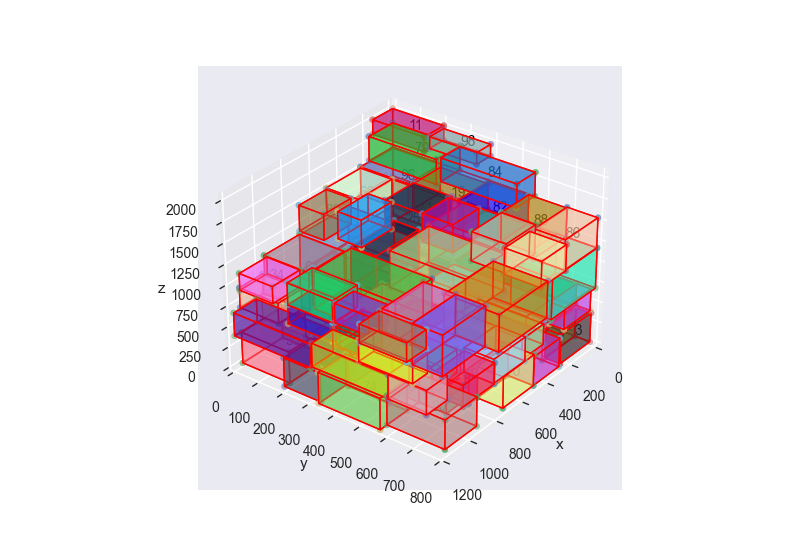

<IPython.core.display.Javascript object>


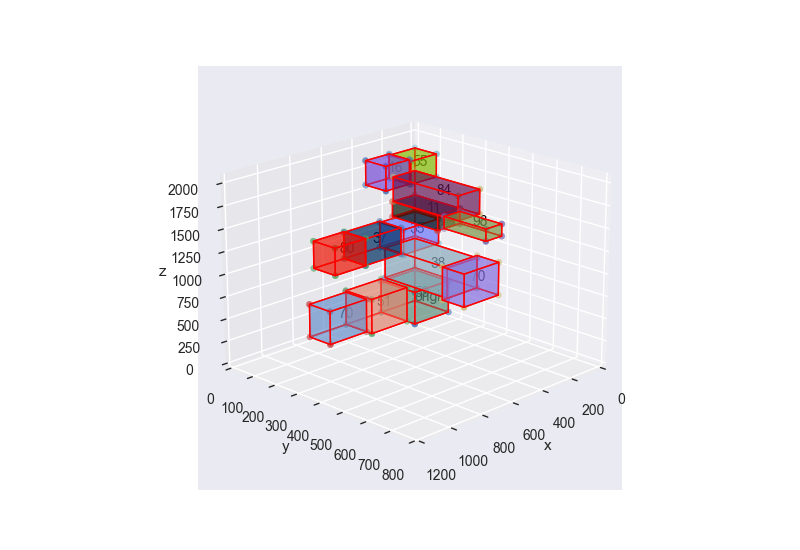

<IPython.core.display.Javascript object>


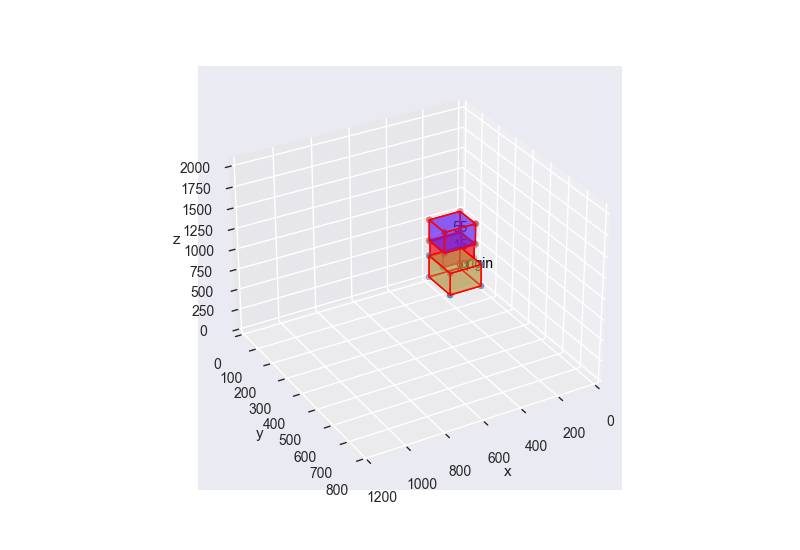

<IPython.core.display.Javascript object>

In [115]:
bin_pool.plot()
# print([b.layer_pool.get_ol() for b in bin_pool])
# print([l.superitems_pool for b in bin_pool for l in b.layer_pool])

## Column generation

- Dobbiamo passare a SP solo gli item con dual > 0?
- Dobbiamo evitare di processare layer con alpha != 1 (anche in SP no placement)?
- RMP lavora su tutti i layer, solo su quelli nuovi o su una parte?

In [64]:
order.iloc[[10, 17, 21, 46]]

id  width  depth  height  weight    volume
10  870910    307    167     422       2  21635518
17   65725    324     98     472       2  14986944
21  905778    317    110     484       2  16877080
46  251995    307    187     387      39  22217283

<IPython.core.display.Javascript object>

In [6]:
bins_lbs = []
final_layer_pool = layers.LayerPool(superitems.SuperitemPool())
for i, spool in enumerate([height_groups[101]]):
    print(f"Height group {i + 1}/{len(height_groups)}")
    print(spool)
    layer_pool = warm_start.maxrects(spool, config.PALLET_DIMS, add_single=False)
    print(layer_pool)
    layer_pool, bins_lb = cg.column_generation(
        layer_pool,
        config.PALLET_DIMS,
        max_iter=100,
        max_stag_iters=5,
        tlim=None,
        use_maxrect=True,
    )
    final_layer_pool.extend(layer_pool)
    bins_lbs.append(bins_lb)

final_layer_pool.to_dataframe()

NameError: name 'height_groups' is not defined

<IPython.core.display.Javascript object>

In [15]:
final_layer_pool = final_layer_pool.select_layers(
    config.PALLET_WIDTH, config.PALLET_DEPTH, min_density=0.0, max_coverage=3
)

<IPython.core.display.Javascript object>

In [16]:
final_layer_pool.to_dataframe()

item    x    y  z  width  depth  height  layer
0     20    0    0  0    232    494     441      0
1     56    0  494  0    350    287     441      0
2     21  232    0  0    343    263     411      0
3     39  232  263  0    340    192     413      0
4     51  350  455  0    300    291     444      0
..   ...  ...  ... ..    ...    ...     ...    ...
72    36  193  119  0    243    102     406      5
73    66  226    0  0    242    109     289      6
74    68  468    0  0    240     97     304      6
75    70  242    0  0    234    112     251      7
76    47    0  109  0    159     92     279      7

[77 rows x 8 columns]

<IPython.core.display.Javascript object>

In [17]:
np.floor(np.mean(bins_lbs) / config.PALLET_HEIGHT)

0.0

<IPython.core.display.Javascript object>

In [18]:
bin_pool = pack.BinPool(final_layer_pool, config.PALLET_DIMS)
bin_pool.to_dataframe()

item    x    y    z  width  depth  height  layer  bin
0     20    0    0    0    232    494     441      0    0
1     56    0  494    0    350    287     441      0    0
2     21  232    0    0    343    263     411      0    0
3     39  232  263    0    340    192     413      0    0
4     51  350  455    0    300    291     444      0    0
..   ...  ...  ...  ...    ...    ...     ...    ...  ...
1     36  193  119    0    243    102     406      0    1
2     66  226    0  417    242    109     289      1    1
3     68  468    0  417    240     97     304      1    1
4     70  242    0  744    234    112     251      2    1
5     47    0  109  744    159     92     279      2    1

[77 rows x 9 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


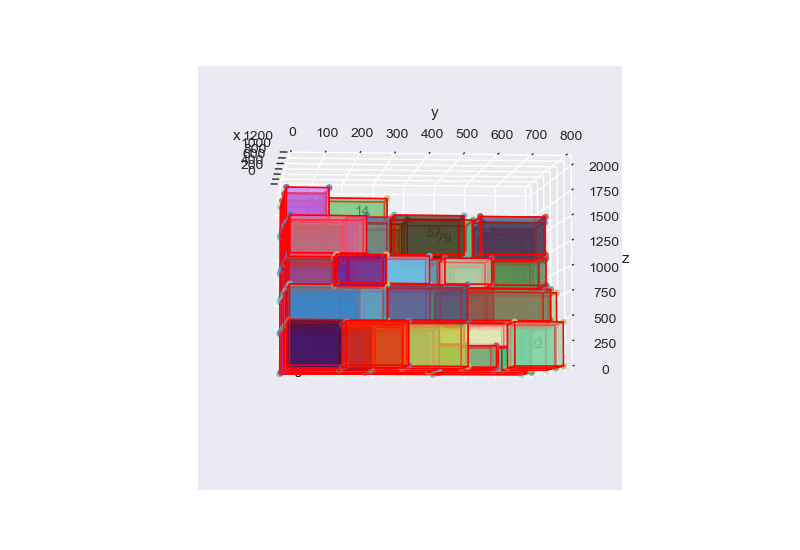

<IPython.core.display.Javascript object>


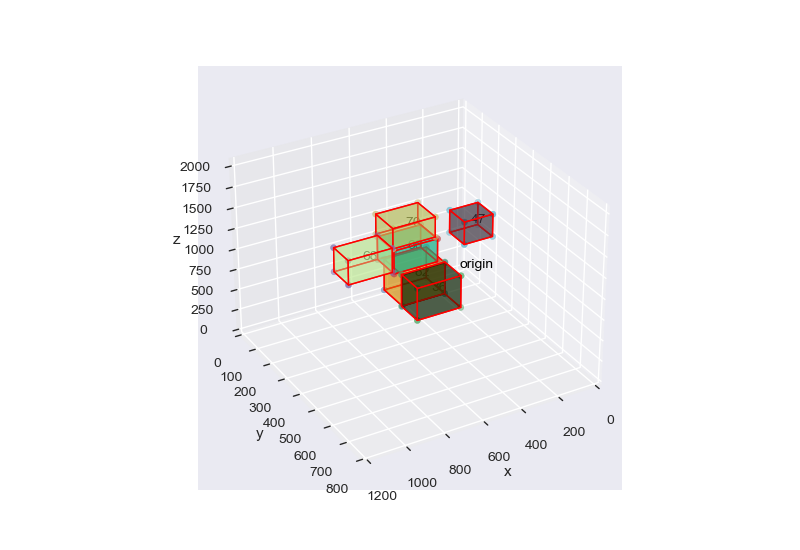

<IPython.core.display.Javascript object>

In [19]:
bin_pool.plot()

Generating vertical superitems: 100%|██████████████████████████████████████████████████████████| 17/17 [00:00<?, ?it/s]

Height group 1/4


item     x    y  z  width  depth  height  layer
0     33     0    0  0    431    256     400      0
1     44   431    0  0    258    354     400      0
2     11     0  256  0    203    375     400      0
3      3   203  256  0    175    357     400      0
4     21   203  613  0    323    144     400      0
5     13     0  631  0    198    168     400      0
6     17   378  354  0    326    232     400      0
7     18   526  586  0    341    212     400      0
8     19   689    0  0    261    283     400      0
9     15   704  283  0    288    253     400      0
10     8   950    0  0    232    257     400      0
11    37   867  536  0    265    261     400      0
12    28   992  257  0    187    266     400      0
13    32     0    0  0    239    308     400      1
14    39     0  308  0    263    262     400      1
15    16     0  570  0    311    201     400      1
16    47   239    0  0    276    242     400      1
17     2   263  242  0    269    210     400      1
18    49   263  452  0    429     79     400      1
19    31   515    0  0    284    194     400      1
20    26   532  194  0    289    188     400      1
21    36   799    0  0    338    136     400      1
22     1   692  382  0    152    322     400      1
23    23   821  136  0    245    183     400      1
24    48  1066  136  0    134    275     400      1
25    20   311  531  0    219    192     400      1
26    38   530  531  0    127    224     400      1
27    22   657  704  0    225     92     400      1
28    46   844  319  0    213    188     400      1
29    42  1057  411  0    134    202     400      1
30    24   844  507  0    206    178     400      1
31    14   882  685  0    246    109     400      1
32     4     0    0  0    163    244     400      2
33    35     0  244  0    239    152     400      2
34    45   163    0  0    235    153     400      2
35    34     0  396  0    211    163     400      2
36    29     0  559  0    256    133     400      2
37    30     0  692  0    222     98     400      2
38     0   222  692  0    200     94     400      2
39    40   211  396  0    243    138     400      2
40    43   256  534  0    187    152     400      2
41     7   443  534  0    180    189     400      2
42    25   239  153  0    184    184     400      2
43    41   398    0  0    182    153     400      2
44     5   423  153  0    144    195     400      2
45     9   454  348  0    221    124     400      2
46    27   567  153  0    175    138     400      2
47    10   580    0  0    208    115     400      2
48     6   623  472  0    118    209     400      2
49    12   741  291  0    116    209     400      2

Items not covered: 0/50


<IPython.core.display.Javascript object>


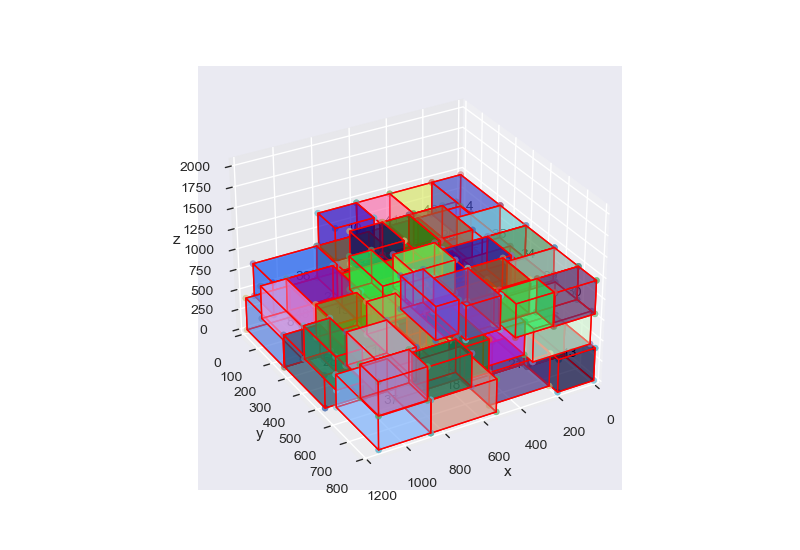

<IPython.core.display.Javascript object>

In [29]:
from src import main

mr_layer_pool, bins_lbs = main.main(order, use_cg=False)
mr_bin_pool = pack.BinPool(mr_layer_pool, config.PALLET_DIMS)
mr_bin_pool.plot()

In [16]:
mr_layer_pool.to_dataframe()

item    x    y  z  width  depth  height  layer
0     36    0    0  0    290    386     426      0
1     37    0  386  0    250    371     417      0
2     40  250  386  0    293    299     415      0
3     85  250  685  0    246     88     388      0
4     59  290    0  0    320    233     425      0
..   ...  ...  ... ..    ...    ...     ...    ...
95    92  455    0  0    168    158     356      6
96    44  190   98  0    234     95     320      6
97    23  623    0  0    212     96     331      6
98    43  835    0  0    145    135     325      6
99    98  623   96  0    199     98     269      6

[100 rows x 8 columns]

<IPython.core.display.Javascript object>

In [26]:
order.sort_values(by=["volume"])

id  width  depth  height  weight    volume
6   321879    180     57     400       3   2400840
96  648143    178     83     400       9   2880930
36  486232    218     54     400       2   3143124
82  989913    190     91     400       2   3717350
74  460337    180     64     400      29   3870720
..     ...    ...    ...     ...     ...       ...
89  110268    318    267     400      40  41009598
14  555839    350    287     400       2  44298450
94  329365    232    494     400      57  50542128
0   199041    366    256     400       6  61277184
60  417113    347    335     400       8  69863245

[100 rows x 6 columns]

<IPython.core.display.Javascript object>

Generating vertical superitems: 100%|███████████████████████████████████████████████| 17/17 [00:00<00:00, 32395.81it/s]

Height group 1/4


item  x  y  z  width  depth  height  layer
0      0  0  0  0    200     94     400      0
1      1  0  0  0    152    322     400      1
2      2  0  0  0    269    210     400      2
3      3  0  0  0    175    357     400      3
4      4  0  0  0    163    244     400      4
5      5  0  0  0    144    195     400      5
6      6  0  0  0    118    209     400      6
7      7  0  0  0    180    189     400      7
8      8  0  0  0    232    257     400      8
9      9  0  0  0    221    124     400      9
10    10  0  0  0    208    115     400     10
11    11  0  0  0    203    375     400     11
12    12  0  0  0    116    209     400     12
13    13  0  0  0    198    168     400     13
14    14  0  0  0    246    109     400     14
15    15  0  0  0    288    253     400     15
16    16  0  0  0    311    201     400     16
17    17  0  0  0    326    232     400     17
18    18  0  0  0    341    212     400     18
19    19  0  0  0    261    283     400     19
20    20  0  0  0    219    192     400     20
21    21  0  0  0    323    144     400     21
22    22  0  0  0    225     92     400     22
23    23  0  0  0    245    183     400     23
24    24  0  0  0    206    178     400     24
25    25  0  0  0    184    184     400     25
26    26  0  0  0    289    188     400     26
27    27  0  0  0    175    138     400     27
28    28  0  0  0    187    266     400     28
29    29  0  0  0    256    133     400     29
30    30  0  0  0    222     98     400     30
31    31  0  0  0    284    194     400     31
32    32  0  0  0    239    308     400     32
33    33  0  0  0    431    256     400     33
34    34  0  0  0    211    163     400     34
35    35  0  0  0    239    152     400     35
36    36  0  0  0    338    136     400     36
37    37  0  0  0    265    261     400     37
38    38  0  0  0    127    224     400     38
39    39  0  0  0    263    262     400     39
40    40  0  0  0    243    138     400     40
41    41  0  0  0    182    153     400     41
42    42  0  0  0    134    202     400     42
43    43  0  0  0    187    152     400     43
44    44  0  0  0    258    354     400     44
45    45  0  0  0    235    153     400     45
46    46  0  0  0    213    188     400     46
47    47  0  0  0    276    242     400     47
48    48  0  0  0    134    275     400     48
49    49  0  0  0    429     79     400     49

Iteration 1/100
Solving RMP...
RMP objective: 20000.0
Duals: [400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 400. 400. 400. 400. 400. 400.]
RMP time: 3.017
Alpha: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Solving SP (no placement)...
SP no placement time: 5.2763500000000004e-05
Reduced cost: -11600.0
FEASIBILITY:  30
Solving SP (no placement)...
Adding feasibility constraint: num selected <= 29
SP no placement time: 1.56095e-05
Reduced cost: -11200.0
FEASIBILITY:  29
Solving SP (no placement)...
Adding feasibility constraint: num selected <= 28
SP no placement time: 1.2257200000000002e-05
Reduced cost: -1080

item     x    y  z  width  depth  height
0     36     0    0  0    338    136     400
1     23   338    0  0    245    183     400
2     20     0  136  0    219    192     400
3      6   219  136  0    118    209     400
4     46     0  328  0    213    188     400
5      4     0  516  0    163    244     400
6     48   163  516  0    134    275     400
7     45   213  345  0    235    153     400
8     29   337  183  0    256    133     400
9     24   583    0  0    206    178     400
10    34   297  498  0    211    163     400
11    40   297  661  0    243    138     400
12    13   448  316  0    198    168     400
13     9   593  178  0    221    124     400
14    41   789    0  0    182    153     400
15    14   508  484  0    246    109     400
16    27   646  302  0    175    138     400
17    10   814  153  0    208    115     400
18    30   971    0  0    222     98     400
19    38  1022   98  0    127    224     400
20     7   821  268  0    180    189     400
21    25  1001  322  0    184    184     400
22     5   754  457  0    144    195     400
23    42   540  593  0    134    202     400
24    12   898  506  0    116    209     400

Iteration 2/100
Solving RMP...
RMP objective: 10400.0
Duals: [400. 400. 400. 400.   0.   0.   0.   0. 400.   0.   0. 400.   0.   0.
   0. 400. 400. 400. 400. 400.   0. 400. 400.   0. 400.   0. 400.   0.
 400.   0.   0. 400. 400. 400.   0. 400.   0. 400.   0. 400.   0.   0.
   0. 400. 400.   0.   0. 400.   0. 400.]
RMP time: 3.159
Alpha: [1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
Solving SP (no placement)...
SP no placement time: 1.9919297000000003e-05
Reduced cost: -7200.0
FEASIBILITY:  19
Solving SP (no placement)...
Adding feasibility constraint: num selected <= 18
SP no placement time: 1.6193535000000002e-05
Reduced cost: -6800.0
FEASIBILITY:  18
Solving SP (no placement)...
Adding feasibility constraint: num selected <= 17
SP no placement time: 2.0115634e-05
Reduced cost: 

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     44  431    0  0    258    354     400
2     32    0  256  0    239    308     400
3     28  239  256  0    187    266     400
4     37  239  522  0    265    261     400
5     35    0  564  0    239    152     400
6     49  426  354  0    429     79     400
7     39  689    0  0    263    262     400
8     47  855  262  0    276    242     400
9     43  952    0  0    187    152     400
10     0  952  152  0    200     94     400
11    31  504  433  0    284    194     400
12    26  788  504  0    289    188     400

Iteration 3/100
Solving RMP...
RMP objective: 5600.0
Duals: [  0. 400. 400. 400.   0.   0.   0.   0. 400.   0.   0. 400.   0.   0.
   0. 400. 400. 400. 400. 400.   0. 400. 400.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 400. 400.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 3.073
Alpha: [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
Solving SP (no placement)...
SP no placement time: 1.0316824e-05
Reduced cost: -5200.0
FEASIBILITY:  14
Solving SP (no placement)...
Adding feasibility constraint: num selected <= 13
SP no placement time: 1.8518517000000002e-05
Reduced cost: -4800.0
FEASIBILITY:  13
Solving SP (no placement)...
Adding feasibility constraint: num selected <= 12
SP no placement time: 5.175664e-06
Reduced cost: -4400.

item    x    y  z  width  depth  height
0     11    0    0  0    203    375     400
1     17    0  375  0    326    232     400
2     21    0  607  0    323    144     400
3     35  323  607  0    239    152     400
4     19  203    0  0    261    283     400
5     22  203  283  0    225     92     400
6     18  326  375  0    341    212     400
7     16  562  587  0    311    201     400
8     15  873    0  0    288    253     400
9      3  667    0  0    175    357     400
10     8  842  253  0    232    257     400
11    34  873  510  0    211    163     400

Iteration 4/100
Solving RMP...
RMP objective: 2000.0
Duals: [  0. 400. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 400.
   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0. 400.]
RMP time: 3.156
Alpha: [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
Solving SP (no placement)...
SP no placement time: 1.8501964e-05
Reduced cost: -1600.0


item    x    y  z  width  depth  height
0    17    0    0  0    326    232     400
1     2    0  232  0    269    210     400
2     1    0  442  0    152    322     400
3    49  152  442  0    429     79     400
4    13  269  232  0    198    168     400

Iteration 5/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0. 400.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 400.   0.   0.   0.
 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 3.281
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
Solving SP (no placement)...
SP no placement time: 9.824919000000002e-06
Reduced cost: -1200.0


item    x    y  z  width  depth  height
0    11    0    0  0    203    375     400
1     2    0  375  0    269    210     400
2    24    0  585  0    206    178     400
3    28  203    0  0    187    266     400

Iteration 6/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 400.   0.
   0.   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 400.   0.   0.   0.   0.   0.]
RMP time: 3.314
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0]
Solving SP (no placement)...
SP no placement time: 5.455545e-06
Reduced cost: -1200.0


item    x    y  z  width  depth  height
0    44    0    0  0    258    354     400
1    18    0  354  0    341    212     400
2    12    0  566  0    116    209     400
3     1  258    0  0    152    322     400

Iteration 7/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0.   0.   0.   0.   0. 400. 400.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 3.378
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 7.1400260000000005e-06
Reduced cost: -1200.0


item    x    y  z  width  depth  height
0    32    0    0  0    239    308     400
1     8    0  308  0    232    257     400
2     2    0  565  0    269    210     400
3     9  232  308  0    221    124     400

Iteration 8/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0. 400.   0.   0.   0.   0. 400.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 3.426
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 5.389001e-06
Reduced cost: -1200.0


item    x    y  z  width  depth  height
0     2    0    0  0    269    210     400
1    26    0  210  0    289    188     400
2    21  269    0  0    323    144     400
3     6    0  398  0    118    209     400

Iteration 9/100
Solving RMP...
RMP objective: 1600.0
Duals: [0.0000000e+00 4.4408921e-14 4.0000000e+02 4.0000000e+02 0.0000000e+00
 0.0000000e+00 4.4408921e-14 0.0000000e+00 0.0000000e+00 4.4408921e-14
 0.0000000e+00 0.0000000e+00 4.0000000e+02 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.4408921e-14
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.0000000e+02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
RMP time: 3.488
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

item    x    y  z  width  depth  height
0     3    0    0  0    175    357     400
1     2    0  357  0    269    210     400
2    24    0  567  0    206    178     400
3    43  206  567  0    187    152     400
4     1  175    0  0    152    322     400
5     9  269  322  0    221    124     400
6     6  327    0  0    118    209     400
7    12  445    0  0    116    209     400

Iteration 10/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. 400.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 400.
   0.   0.   0.   0.   0. 400.   0.   0.]
RMP time: 3.486
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 1.7645861000000003e-05
Reduced cost: -1200.0


item  x    y  z  width  depth  height
0    47  0    0  0    276    242     400
1     2  0  242  0    269    210     400
2    41  0  452  0    182    153     400
3    22  0  605  0    225     92     400

Iteration 11/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 400. 400.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 3.609
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 5.547415e-06
Reduced cost: -1200.0


item    x    y  z  width  depth  height
0    39    0    0  0    263    262     400
1    16    0  262  0    311    201     400
2     2  263    0  0    269    210     400
3    40    0  463  0    243    138     400

Iteration 12/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 400.   0. 400.   0.   0.   0.]
RMP time: 3.713
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 3.2760680000000002e-06
Reduced cost: -1200.0


item    x    y  z  width  depth  height
0    44    0    0  0    258    354     400
1    15    0  354  0    288    253     400
2    46    0  607  0    213    188     400
3     2  258    0  0    269    210     400

Iteration 13/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 400.   0.   0.   0.   0.   0.   0. 400.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 4.031
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 1.2776534e-05
Reduced cost: -1200.0


item    x    y  z  width  depth  height
0    18    0    0  0    341    212     400
1    37  341    0  0    265    261     400
2     2    0  212  0    269    210     400
3    30    0  422  0    222     98     400

Iteration 14/100
Solving RMP...
RMP objective: 1600.0
Duals: [0.00000000e+00 1.33333333e+02 2.66666667e+02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.33333333e+02 0.00000000e+00 0.00000000e+00 1.33333333e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33333333e+02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.44089210e-14 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.66666667e+02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33333333e+02 0.00000000e+00 0.00000000e+00
 1.33333333e+02 1.33333333e+02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.33333333e+02 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
RMP time: 3.814
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     11  431    0  0    203    375     400
2     37    0  256  0    265    261     400
3      1  265  256  0    152    322     400
4      8    0  517  0    232    257     400
5      2  232  578  0    269    210     400
6     26  417  375  0    289    188     400
7     21  501  563  0    323    144     400
8     46  634    0  0    213    188     400
9     40  634  188  0    243    138     400
10    41  847    0  0    182    153     400

Iteration 15/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 3.892
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 1.4226377e-05
Reduced cost: -1200.0


item    x    y  z  width  depth  height
0    19    0    0  0    261    283     400
1     2    0  283  0    269    210     400
2    31  261    0  0    284    194     400
3     4    0  493  0    163    244     400

Iteration 16/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.         114.28571429 285.71428571   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.          57.14285714   0.         114.28571429 114.28571429
   0.           0.         114.28571429   0.           0.
   0.           0.           0.         114.28571429   0.
   0.           0.         114.28571429   0.           0.
   0.           0.           0.           0.          57.14285714
   0.           0.           0.           0.         114.28571429
   0.           0.           0.         400.           0.        ]
RMP time: 3.967
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

item    x    y  z  width  depth  height
0     44    0    0  0    258    354     400
1     19    0  354  0    261    283     400
2     22    0  637  0    225     92     400
3     32  258    0  0    239    308     400
4     18  261  308  0    341    212     400
5     39  497    0  0    263    262     400
6     16  261  520  0    311    201     400
7      2  572  520  0    269    210     400
8     28  760    0  0    187    266     400
9      1  841  266  0    152    322     400
10    48  993    0  0    134    275     400

Iteration 17/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0. 400.   0.   0.   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.
   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 400.   0.   0.]
RMP time: 4.005
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 4.499937e-06
Reduced cost: -1200.0


item    x    y  z  width  depth  height
0    15    0    0  0    288    253     400
1    47    0  253  0    276    242     400
2     7    0  495  0    180    189     400
3     1  276  253  0    152    322     400

Iteration 18/100
Solving RMP...
RMP objective: 1555.5555555555557
Duals: [222.22222222 177.77777778 177.77777778  44.44444444   0.
   0.           0.           0.          44.44444444   0.
   0.           0.           0.           0.           0.
 222.22222222   0.          44.44444444   0.          44.44444444
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.         177.77777778   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
 400.           0.           0.           0.           0.        ]
RMP time: 4.084
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.7777777777777778, 0.2222222222222222, 0.0, 0

item    x    y  z  width  depth  height
0    17    0    0  0    326    232     400
1    19    0  232  0    261    283     400
2    15    0  515  0    288    253     400
3     8  261  232  0    232    257     400
4     2  326    0  0    269    210     400
5    31  288  489  0    284    194     400
6     0  288  683  0    200     94     400
7    45  493  210  0    235    153     400
8     3  572  363  0    175    357     400
9     1  728    0  0    152    322     400

Iteration 19/100
Solving RMP...
RMP objective: 1466.6666666666665
Duals: [  0.          66.66666667 200.           0.           0.
   0.          66.66666667   0.           0.           0.
   0.         133.33333333   0.           0.           0.
 133.33333333 133.33333333   0.           0.           0.
   0.           0.           0.         133.33333333   0.
   0.           0.           0.           0.           0.
 200.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.          66.66666667   0.
   0.           0.         200.           0.         133.33333333]
RMP time: 4.094
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

item    x    y  z  width  depth  height
0     11    0    0  0    203    375     400
1     15    0  375  0    288    253     400
2     49    0  628  0    429     79     400
3     47  203    0  0    276    242     400
4     30  203  242  0    222     98     400
5     16  288  340  0    311    201     400
6      2  429  541  0    269    210     400
7      1  479    0  0    152    322     400
8     23  599  322  0    245    183     400
9     43  698  505  0    187    152     400
10     6  844    0  0    118    209     400

Iteration 20/100
Solving RMP...
RMP objective: 1400.0
Duals: [  0.   0. 200.   0.   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 200.   0.   0.   0. 200.   0.   0.   0.   0.   0.   0.
 200.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 200.   0.   0.   0.   0.   0.   0.]
RMP time: 4.146
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.25, 0.0, 0.25, 0.25]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.4327570000000001e-05
Reduced cost: -1000.0


item    x    y  z  width  depth  height
0    17    0    0  0    326    232     400
1     2    0  232  0    269    210     400
2    28    0  442  0    187    266     400
3    21  187  442  0    323    144     400
4     7  269  232  0    180    189     400
5    43  326    0  0    187    152     400

Iteration 21/100
Solving RMP...
RMP objective: 1400.0
Duals: [  0.   0. 200. 100. 200.   0.   0. 100.   0.   0.   0.   0.   0. 100.
   0.   0.   0. 100. 200.   0.   0.   0.   0.   0.   0.   0. 200.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 200.   0.   0.]
RMP time: 4.242
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.25, 0.0, 0.25, 0.25, -0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 7.5722690000000005e-06
Reduced cost: -1000.0


item    x    y  z  width  depth  height
0    17    0    0  0    326    232     400
1    18    0  232  0    341    212     400
2     2  326    0  0    269    210     400
3    47    0  444  0    276    242     400
4    26  276  444  0    289    188     400
5    13  276  632  0    198    168     400
6     7  341  210  0    180    189     400
7     3  565  210  0    175    357     400
8     4  740    0  0    163    244     400

Iteration 22/100
Solving RMP...
RMP objective: 1400.0
Duals: [  0. 200.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 200. 200.
   0.   0.   0.   0.   0.   0.   0. 200. 200.   0.   0.   0.   0.   0.
   0.   0.   0. 200.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 200.   0.   0.]
RMP time: 4.292
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.25, 0.0, 0.25, 0.25, 0.0, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 8.028179e-06
Reduced cost: -1000.0


item    x    y  z  width  depth  height
0    47    0    0  0    276    242     400
1    31    0  242  0    284    194     400
2    21  276    0  0    323    144     400
3    22  276  144  0    225     92     400
4     1    0  436  0    152    322     400
5    13  152  436  0    198    168     400
6    12  501  144  0    116    209     400

Iteration 23/100
Solving RMP...
RMP objective: 1400.0
Duals: [ 80. 200.   0. 120.   0.   0.   0.   0.   0.   0.   0.   0.  40.  40.
   0.   0.   0.   0. 160.   0.   0. 120.   0.   0.   0.   0.  80.   0.
   0.   0.   0.   0.  40.   0.   0.   0. 320.   0.   0.   0.   0.   0.
   0.  40.   0.   0.   0.   0.   0. 160.]
RMP time: 4.342
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.25, 0.0, 0.25, 0.25, 0.0, 0.0, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.3430338e-05
Reduced cost: -1002.0


item     x    y  z  width  depth  height
0     32     0    0  0    239    308     400
1     18     0  308  0    341    212     400
2     26   239    0  0    289    188     400
3     49   239  188  0    429     79     400
4     21   528    0  0    323    144     400
5      3   851    0  0    175    357     400
6      1   668  144  0    152    322     400
7     12  1026    0  0    116    209     400
8     36   820  357  0    338    136     400
9     13   341  466  0    198    168     400
10    43   341  267  0    187    152     400
11     0   539  466  0    200     94     400

Iteration 24/100
Solving RMP...
RMP objective: 1400.0000000000002
Duals: [  0.          14.28571429 185.71428571  85.71428571   0.
   0.           0.           0.           0.           0.
 328.57142857   0.           0.          57.14285714   0.
   0.           0.          57.14285714   0.           0.
   0.          57.14285714 200.           0.          14.28571429
   0.           0.           0.           0.           0.
   0.          57.14285714   0.         142.85714286   0.
   0.           0.           0.           0.           0.
   0.           0.           0.         100.           0.
   0.           0.          14.28571429   0.          85.71428571]
RMP time: 4.339
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.75, 0.7500000000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 

item     x    y  z  width  depth  height
0     33     0    0  0    431    256     400
1     17   431    0  0    326    232     400
2     47   757    0  0    276    242     400
3      1  1033    0  0    152    322     400
4      3   431  232  0    175    357     400
5      2     0  256  0    269    210     400
6     31     0  466  0    284    194     400
7     49     0  660  0    429     79     400
8     21   429  589  0    323    144     400
9     24   606  242  0    206    178     400
10    13   606  420  0    198    168     400
11    43   752  588  0    187    152     400
12    10   804  420  0    208    115     400
13    22   812  322  0    225     92     400

Iteration 25/100
Solving RMP...
RMP objective: 1373.3333333333333
Duals: [ 26.66666667 173.33333333   0.           0.           0.
   0.           0.           0.           0.         213.33333333
   0.          13.33333333   0.           0.           0.
  93.33333333   0.         106.66666667 186.66666667   0.
 186.66666667   0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.         213.33333333   0.          40.
   0.           0.           0.          13.33333333   0.
   0.           0.         106.66666667   0.           0.        ]
RMP time: 4.447
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.7333333333333334, 0.6333333333333334, 0.0, 0.0, 0

item     x    y  z  width  depth  height
0     11     0    0  0    203    375     400
1     17     0  375  0    326    232     400
2     20     0  607  0    219    192     400
3     43   219  607  0    187    152     400
4     15   203    0  0    288    253     400
5      0   203  253  0    200     94     400
6     18   326  347  0    341    212     400
7      9   406  559  0    221    124     400
8     37   491    0  0    265    261     400
9     39   667  261  0    263    262     400
10    47   756    0  0    276    242     400
11     1  1032    0  0    152    322     400

Iteration 26/100
Solving RMP...
RMP objective: 1363.934426229508
Duals: [ 13.1147541    0.         163.93442623  72.13114754   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
 144.26229508   0.           6.55737705 111.47540984   0.
   0.          65.57377049   0.           0.           0.
   0.          45.90163934 400.          32.78688525   0.
   0.           0.           0.           0.           0.
   0.           0.         124.59016393   0.           0.
   0.           0.           0.           0.          91.80327869
   0.           0.           0.           0.          91.80327869]
RMP time: 4.543
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.7213114754098361, 0.6229508196721312, 0.0, 0.0, 0.

item    x    y  z  width  depth  height
0     44    0    0  0    258    354     400
1     17    0  354  0    326    232     400
2     18    0  586  0    341    212     400
3     15  258    0  0    288    253     400
4     49  258  253  0    429     79     400
5      2  546    0  0    269    210     400
6     26  326  332  0    289    188     400
7     37  341  520  0    265    261     400
8     28  606  520  0    187    266     400
9     21  615  332  0    323    144     400
10     0  687  210  0    200     94     400
11    27  815    0  0    175    138     400
12     3  990    0  0    175    357     400

Iteration 27/100
Solving RMP...
RMP objective: 1345.4545454545455
Duals: [7.27272727e+01 0.00000000e+00 1.45454545e+02 1.09090909e+02
 0.00000000e+00 4.00000000e+02 0.00000000e+00 0.00000000e+00
 7.27272727e+01 0.00000000e+00 0.00000000e+00 1.45454545e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.66133815e-14 0.00000000e+00 3.63636364e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.63636364e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.81818182e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.63636364e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.09090909e+02
 0.00000000e+00 0.00000000e+00]
RMP time: 4.685
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

item    x    y  z  width  depth  height
0     11    0    0  0    203    375     400
1     32    0  375  0    239    308     400
2     22    0  683  0    225     92     400
3      0  225  683  0    200     94     400
4     18  203    0  0    341    212     400
5     37  239  212  0    265    261     400
6     16  239  473  0    311    201     400
7     47  504  212  0    276    242     400
8      2  544    0  0    269    210     400
9      8  550  454  0    232    257     400
10     5  780  210  0    144    195     400
11     3  782  405  0    175    357     400

Iteration 28/100
Solving RMP...
RMP objective: 1340.8450704225352
Duals: [  0.         101.4084507   39.43661972   0.           0.
   0.           0.           0.           0.           0.
   0.          84.50704225   0.           0.         400.
 152.11267606   0.           0.          33.8028169    0.
   0.           0.         129.57746479   0.           0.
   0.         174.64788732   0.           0.           0.
   0.         107.04225352  90.14084507   0.           0.
   0.           0.           0.           0.           5.63380282
   0.           0.           0.           0.           0.
   0.           0.          22.53521127   0.           0.        ]
RMP time: 4.69
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.6901408450704225, 0.5915492957746479, 0.0, 0.0, 0.

item     x    y  z  width  depth  height
0     11     0    0  0    203    375     400
1     32     0  375  0    239    308     400
2     14     0  683  0    246    109     400
3     15   203    0  0    288    253     400
4     22   203  253  0    225     92     400
5     18   239  345  0    341    212     400
6     47   246  557  0    276    242     400
7      2   522  557  0    269    210     400
8     39   491    0  0    263    262     400
9     31   580  262  0    284    194     400
10    26   754    0  0    289    188     400
11     1  1043    0  0    152    322     400

Iteration 29/100
Solving RMP...
RMP objective: 1337.3737373737374
Duals: [ 12.12121212 137.37373737   0.          56.56565657   0.
   0.           0.          96.96969697  28.28282828   0.
   0.           0.           0.           0.           0.
   0.         222.22222222  92.92929293   0.           0.
   0.           0.           0.           0.           0.
   0.         153.53535354   0.           0.           0.
   0.          72.72727273   0.           0.           0.
   0.           0.          80.80808081 303.03030303  36.36363636
   0.           0.           0.          40.4040404    4.04040404
   0.           0.           0.           0.           0.        ]
RMP time: 4.708
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.6767676767676769, 0.595959595959596, 0.0,

item    x    y  z  width  depth  height
0     44    0    0  0    258    354     400
1     17    0  354  0    326    232     400
2     16    0  586  0    311    201     400
3     31  311  586  0    284    194     400
4     37  258    0  0    265    261     400
5     39  326  261  0    263    262     400
6      8  523    0  0    232    257     400
7     26  589  257  0    289    188     400
8      0  589  445  0    200     94     400
9      7  755    0  0    180    189     400
10     1  789  445  0    152    322     400
11    38  595  539  0    127    224     400
12    43  878  189  0    187    152     400
13     3  941  341  0    175    357     400

Iteration 30/100
Solving RMP...
RMP objective: 1333.3333333333333
Duals: [5.55111512e-15 1.33333333e+02 0.00000000e+00 1.33333333e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.66666667e+01 0.00000000e+00 0.00000000e+00 1.33333333e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.66666667e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.00000000e+02 0.00000000e+00 0.00000000e+00 1.11022302e-14
 6.66666667e+01 6.66666667e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.00000000e+02 6.66666667e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
RMP time: 4.844
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

item     x    y  z  width  depth  height
0     33     0    0  0    431    256     400
1     11   431    0  0    203    375     400
2     32     0  256  0    239    308     400
3      3   239  256  0    175    357     400
4     43     0  564  0    187    152     400
5      0   187  613  0    200     94     400
6     15   414  375  0    288    253     400
7      8   634    0  0    232    257     400
8     31   866    0  0    284    194     400
9     28   866  194  0    187    266     400
10     1   702  257  0    152    322     400
11    42  1053  194  0    134    202     400

Iteration 31/100
Solving RMP...
RMP objective: 1329.7935103244838
Duals: [ 76.69616519 112.09439528  17.69911504   0.           0.
   0.           0.           0.          49.55752212   0.
   0.          61.35693215   0.           0.           0.
   0.          57.81710914  31.85840708   0.         112.09439528
   0.          87.31563422   0.           0.           0.
 400.          71.97640118   0.          81.4159292    0.
   0.           0.          18.87905605   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.         117.99410029   0.          33.03834808]
RMP time: 4.871
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.6592920353982301, 0.5766961651917405, 0.0, 0.0, 0

item    x    y  z  width  depth  height
0     11    0    0  0    203    375     400
1     17    0  375  0    326    232     400
2     26    0  607  0    289    188     400
3     21  289  607  0    323    144     400
4     19  203    0  0    261    283     400
5     49  203  283  0    429     79     400
6     47  464    0  0    276    242     400
7     16  326  362  0    311    201     400
8      0  632  242  0    200     94     400
9     25  740    0  0    184    184     400
10     8  924    0  0    232    257     400
11    28  832  257  0    187    266     400
12     1  637  336  0    152    322     400

Iteration 32/100
Solving RMP...
RMP objective: 1328.1879194630872
Duals: [  0.           0.         128.18791946   0.         125.5033557
   0.           0.           0.          51.00671141   0.
   0.          46.30872483   0.           0.           0.
  40.26845638   3.3557047   34.22818792  22.81879195 146.30872483
   0.          55.70469799   0.           0.           0.
   0.          59.06040268   0.           0.         274.4966443
   0.           0.          84.56375839   0.           0.
   0.           0.          59.73154362   0.          14.76510067
   0.           0.           0.         177.85234899   0.
   0.           0.           4.02684564   0.           0.        ]
RMP time: 4.911
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.6510067114093958, 0.5654362

item     x    y  z  width  depth  height
0     11     0    0  0    203    375     400
1     17     0  375  0    326    232     400
2     26     0  607  0    289    188     400
3     21   289  607  0    323    144     400
4     19   203    0  0    261    283     400
5     32   326  283  0    239    308     400
6     15   464    0  0    288    253     400
7     37   565  253  0    265    261     400
8      2   752    0  0    269    210     400
9      4  1021    0  0    163    244     400
10    43   830  210  0    187    152     400
11     8   830  362  0    232    257     400
12    29   612  619  0    256    133     400

Iteration 33/100
Solving RMP...
RMP objective: 1319.893899204244
Duals: [ 26.52519894   3.18302387 116.71087533   0.           0.
   0.           0.           0.          63.66047745  11.67108753
   0.           0.           0.           0.           0.
 119.8938992  115.64986737  48.80636605  30.76923077  21.22015915
   0.           0.           0.           0.           0.
  76.39257294   0.           0.           0.           0.
   0.           0.           0.         186.73740053   0.
   0.         311.93633952  29.70822281   0.         112.4668435
   0.           0.           0.           0.           0.
   0.           0.          16.97612732   0.          27.5862069 ]
RMP time: 4.916
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9761273209549072, 0.6206896551724139, 0.

item     x    y  z  width  depth  height
0     33     0    0  0    431    256     400
1     17   431    0  0    326    232     400
2     15   757    0  0    288    253     400
3     37   431  232  0    265    261     400
4     18     0  256  0    341    212     400
5     39     0  468  0    263    262     400
6     16   696  253  0    311    201     400
7     25  1007  253  0    184    184     400
8      8   696  454  0    232    257     400
9      2   928  454  0    269    210     400
10     0   928  664  0    200     94     400
11    49   263  711  0    429     79     400
12    36   263  493  0    338    136     400

Iteration 34/100
Solving RMP...
RMP objective: 1310.8108108108108
Duals: [  0.          59.45945946  51.35135135  62.16216216   0.
   8.10810811   0.          24.32432432   0.           0.
   0.          64.86486486 227.02702703   0.          59.45945946
  81.08108108  64.86486486   0.           0.         110.81081081
  45.94594595  16.21621622   0.           0.           0.
   0.           5.40540541   0.           0.           0.
   0.           0.           0.         132.43243243   0.
   0.           0.          70.27027027   0.           0.
   0.           0.           0.           0.         113.51351351
  35.13513514   0.          78.37837838   0.           0.        ]
RMP time: 5.02
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9628378378378377, 0.5625, 0.44087837837

item    x    y  z  width  depth  height
0    33    0    0  0    431    256     400
1    44  431    0  0    258    354     400
2    11    0  256  0    203    375     400
3    12  203  256  0    116    209     400
4    19  203  465  0    261    283     400
5    15  464  354  0    288    253     400
6    37  689    0  0    265    261     400
7    47  752  261  0    276    242     400
8    16  752  503  0    311    201     400

Iteration 35/100
Solving RMP...
RMP objective: 1297.560975609756
Duals: [  0.          48.7804878   58.53658537 107.31707317   0.
 136.58536585   0.           0.          19.51219512 126.82926829
   0.          68.29268293   0.           0.           0.
  39.02439024   0.           0.           9.75609756 126.82926829
   0.          19.51219512   0.         136.58536585   0.
   0.          68.29268293   0.           0.           0.
   0.           0.           0.         117.07317073   0.
   9.75609756   0.           0.           0.         107.31707317
   0.           0.           0.           0.          48.7804878
   0.           0.           0.           0.          48.7804878 ]
RMP time: 5.05
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9593495934959348, 0.5447154471544

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     11  431    0  0    203    375     400
2     19    0  256  0    261    283     400
3      5  261  256  0    144    195     400
4      2    0  539  0    269    210     400
5     49  261  451  0    429     79     400
6     39  269  530  0    263    262     400
7     26  532  530  0    289    188     400
8      3  634    0  0    175    357     400
9      9  690  357  0    221    124     400
10    23  821  481  0    245    183     400

Iteration 36/100
Solving RMP...
RMP objective: 1296.6363636363637
Duals: [  0.          72.72727273  90.54545455   0.           0.
  81.36363636  37.           0.          89.09090909   0.
   0.          84.27272727  87.18181818   0.           0.
  19.90909091   0.           0.          53.45454545  49.90909091
 141.36363636  36.72727273   0.           0.           0.
   0.           0.           0.           0.           0.
   0.          77.81818182   1.27272727  26.63636364   0.
  66.63636364  53.09090909   0.           0.           0.
   0.           0.           0.          28.27272727 132.09090909
   0.           0.           0.           0.          67.27272727]
RMP time: 5.105
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9554545454545454, 0.535, 0.46499999999999997, 

item     x    y  z  width  depth  height
0     44     0    0  0    258    354     400
1     11     0  354  0    203    375     400
2     19   203  354  0    261    283     400
3     21   203  637  0    323    144     400
4     18   258    0  0    341    212     400
5     36   258  212  0    338    136     400
6      8   464  348  0    232    257     400
7     49   596  212  0    429     79     400
8      2   599    0  0    269    210     400
9     31   868    0  0    284    194     400
10     1  1025  194  0    152    322     400
11    20   526  605  0    219    192     400
12    35   696  291  0    239    152     400
13     5   745  443  0    144    195     400
14     6   889  443  0    118    209     400
15    12  1007  516  0    116    209     400

Iteration 37/100
Solving RMP...
RMP objective: 1288.2282040980313
Duals: [ 85.33547609  55.76536762  32.46283648  10.76737646  14.78505424
   0.           0.           0.          64.28284452  82.92486943
   0.           0.          12.69586179   0.           0.
  66.69345119   0.           0.           0.          84.69264765
  58.17597429  20.89192447 152.67175573   0.           0.
   0.          75.37163519   0.           0.           0.
 231.41824026   0.           3.37484934 113.78063479   0.
   0.           0.          37.44475693   0.           0.
   0.           0.           0.           0.          71.03254319
   0.           0.          13.66010446   0.           0.        ]
RMP time: 5.145
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9433507432703898, 0.5335476094

item     x    y  z  width  depth  height
0     33     0    0  0    431    256     400
1     44   431    0  0    258    354     400
2     19     0  256  0    261    283     400
3      1   261  256  0    152    322     400
4      8     0  539  0    232    257     400
5      2   232  578  0    269    210     400
6     26   413  354  0    289    188     400
7     15   501  542  0    288    253     400
8     37   689    0  0    265    261     400
9     22   689  261  0    225     92     400
10    21   702  353  0    323    144     400
11    20   954    0  0    219    192     400
12     9   954  192  0    221    124     400
13     4  1025  316  0    163    244     400
14    30   789  497  0    222     98     400
15     0   789  595  0    200     94     400

Iteration 38/100
Solving RMP...
RMP objective: 1278.225616367322
Duals: [  0.         103.45542828  38.89124593  84.46707208   0.
   0.           0.           0.           0.           0.
   0.          35.30853722  47.32946778   0.           0.
  34.84655636  70.36251355   0.          56.13538868  15.56592655
   0.          39.19294772   0.          64.89416867   0.
   0.          23.70244661   0.          60.17065007 149.89864706
   0.           0.           0.          81.751756     0.
  64.12105784   0.          62.59369255   0.          55.41884693
   0.           0.           0.           0.           0.
 122.7737708   15.10394569  52.24154999   0.           0.        ]
RMP time: 5.259
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9378211474096072, 0.5186677980483665, 0

item     x    y  z  width  depth  height
0     33     0    0  0    431    256     400
1     18   431    0  0    341    212     400
2     37   772    0  0    265    261     400
3      1  1037    0  0    152    322     400
4     39   431  212  0    263    262     400
5     16   694  261  0    311    201     400
6      3  1005  322  0    175    357     400
7     28   694  462  0    187    266     400
8     23     0  474  0    245    183     400
9     35     0  256  0    239    152     400
10    29     0  657  0    256    133     400
11    45   245  474  0    235    153     400

Iteration 39/100
Solving RMP...
RMP objective: 1273.45823848713
Duals: [  0.          16.38942392  77.86610634  59.62294986   0.
   0.           0.          74.92441487  48.46319967   0.
   0.           8.82040507  20.12957451   0.           0.
  72.73915835   0.74709625   0.          74.5648748  114.24502422
   0.           0.           0.          30.71966381   0.
   0.           0.           0.          79.58909706   0.
   0.           0.           0.          53.40337361   0.
  20.79729178   0.          16.89371389  85.38843168  36.5983774
   0.           0.           0.          60.97239246   0.
  10.67413763 178.16377751 113.02165412   0.          18.72409969]
RMP time: 5.529
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9300297671160918, 0.5123445981439326, 0.445631237

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     19  431    0  0    261    283     400
2     15    0  256  0    288    253     400
3     38  288  256  0    127    224     400
4     18  288  480  0    341    212     400
5     47    0  509  0    276    242     400
6     46  415  283  0    213    188     400
7      7  628  283  0    180    189     400
8      8  692    0  0    232    257     400
9      2  629  472  0    269    210     400
10    43  808  257  0    187    152     400
11     3  898  409  0    175    357     400
12    28  995    0  0    187    266     400

Iteration 40/100
Solving RMP...
RMP objective: 1271.6937958921774
Duals: [ 26.55011895  36.09992918  60.97689425  87.43015914   0.
   0.           0.           0.           0.           7.33911633
   0.          15.84048136  62.3619073    0.           0.
  65.98667046  60.75412992   0.           0.          77.6914835
   0.          66.91404808   0.           0.           0.
   0.           0.           0.           2.39955931   0.
  11.76292548   0.          42.75138168   0.           0.
  25.38302754   0.          35.01032101   0.         107.65812938
   0.         185.15832612  88.11298026  34.82871965  11.66849277
  45.26474452   0.          70.68651368   0.          43.06373602]
RMP time: 5.503
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9273473489228015, 0.50774529803

item     x    y  z  width  depth  height
0     19     0    0  0    261    283     400
1     32     0  283  0    239    308     400
2     16     0  591  0    311    201     400
3     15   239  283  0    288    253     400
4     39   311  536  0    263    262     400
5     47   261    0  0    276    242     400
6      2   527  242  0    269    210     400
7     49   527  452  0    429     79     400
8     21   537    0  0    323    144     400
9     45   796  144  0    235    153     400
10    41   796  297  0    182    153     400
11     3   978  297  0    175    357     400
12    42  1031    0  0    134    202     400
13    12   574  531  0    116    209     400

Iteration 41/100
Solving RMP...
RMP objective: 1266.6043363190538
Duals: [ 40.7181877   23.17267928  43.43165703   9.84302764   0.
   0.           0.           0.           0.           0.
   0.          75.64449741   0.           0.          14.86885598
  21.81045438  70.30927802  13.72882423  41.061812   113.4063535
   0.           0.          54.19575282  37.96596375   0.
   0.           0.         132.7190726   18.10163722   0.
   0.          73.92895955   0.          54.03362932   0.
   0.           0.          49.23128596   0.          36.32083012
 154.48625099   0.           0.          82.74692749   0.
  59.95985667   0.          15.56450141   0.          29.35404122]
RMP time: 5.463
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.922024089226054, 0.5086689241232978, 0.

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     11  431    0  0    203    375     400
2     19    0  256  0    261    283     400
3     18    0  539  0    341    212     400
4     45  261  375  0    235    153     400
5     37  341  528  0    265    261     400
6     40  496  375  0    243    138     400
7     39  606  513  0    263    262     400
8     16  634    0  0    311    201     400
9     43  634  201  0    187    152     400
10    27  739  353  0    175    138     400
11    22  821  201  0    225     92     400
12    23  945    0  0    245    183     400
13     2  869  491  0    269    210     400
14    31  914  293  0    284    194     400
15     0  869  701  0    200     94     400

Iteration 42/100
Solving RMP...
RMP objective: 1259.815204689736
Duals: [  3.65182243  86.90533495  28.15592044  28.51896332   0.
 108.11611538   0.           0.           0.           1.88134008
   0.           8.11336014   0.           0.          27.21589869
  91.85179423  55.35366698 128.77455199   0.          32.14161266
   0.           0.           0.          66.27218168   0.
   0.           0.           0.          21.71190927   0.
   0.           0.          94.94932797  64.29748771   0.
  55.24605069   0.          16.01343259   0.           5.68097283
 120.31954257   0.           0.           0.          75.10125493
   0.          76.19492161  57.12739078   0.           6.22035082]
RMP time: 5.466
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9152424526788189, 0.486

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     44  431    0  0    258    354     400
2     17    0  256  0    326    232     400
3     32    0  488  0    239    308     400
4     15  239  488  0    288    253     400
5     47  527  354  0    276    242     400
6     23  527  596  0    245    183     400
7     46  772  596  0    213    188     400
8      1  985    0  0    152    322     400
9     40  689    0  0    243    138     400
10     5  689  138  0    144    195     400

Iteration 43/100
Solving RMP...
RMP objective: 1257.057207094679
Duals: [0.00000000e+00 2.87377060e+01 8.38722810e+01 5.15687309e+01
 0.00000000e+00 0.00000000e+00 2.54346277e+01 0.00000000e+00
 0.00000000e+00 9.56856432e+01 0.00000000e+00 8.65850612e+01
 0.00000000e+00 0.00000000e+00 1.14697310e+02 1.39154893e+01
 9.21679111e+01 9.22807894e+01 0.00000000e+00 7.92923826e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.26511598e+01 1.95149934e+01 0.00000000e+00 0.00000000e+00
 4.26494944e+01 7.42535691e+01 0.00000000e+00 5.55527799e+01
 2.97906200e+01 1.36138637e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.63094346e+01 0.00000000e+00 3.96387894e+01
 8.19922095e+01 1.93928628e+00 3.66280845e+01 2.95426578e+01
 0.00000000e+00 1.05476448e-01]
RMP time: 5.628
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     44  431    0  0    258    354     400
2     11    0  256  0    203    375     400
3      3  203  256  0    175    357     400
4     35  203  613  0    239    152     400
5     43    0  631  0    187    152     400
6     17  378  354  0    326    232     400
7     16  442  586  0    311    201     400
8     32  689    0  0    239    308     400
9      2  704  308  0    269    210     400
10    28  928    0  0    187    266     400
11    41  973  266  0    182    153     400
12     9  973  419  0    221    124     400
13    14  753  543  0    246    109     400

Iteration 44/100
Solving RMP...
RMP objective: 1252.6722335017632
Duals: [  0.          62.99784756   0.          73.24408079   0.
   0.          55.01702108   0.           0.          19.73529546
   0.          64.89688125   0.           0.           1.08690674
  37.47385776  23.54557528  59.58447189   0.          46.59044072
   0.           0.          84.33907827   0.           0.
   0.           0.           0.          58.63800815  26.70859603
  61.55067397  25.3163784   66.66157815   0.           0.
  10.32561406  51.10904178  87.31280626   0.          57.22747187
   0.          11.51022028   0.          10.77136795   0.
   0.         173.28224465   0.           0.          83.74677515]
RMP time: 5.656
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8971356750678052, 0.46

item    x    y  z  width  depth  height
0     11    0    0  0    203    375     400
1     17    0  375  0    326    232     400
2     36    0  607  0    338    136     400
3     32  203    0  0    239    308     400
4     37  326  308  0    265    261     400
5     46  338  569  0    213    188     400
6     49  551  569  0    429     79     400
7     30  551  648  0    222     98     400
8     22  773  648  0    225     92     400
9      3  980    0  0    175    357     400
10    28  980  357  0    187    266     400
11    39  442    0  0    263    262     400
12     6  591  262  0    118    209     400
13     1  709    0  0    152    322     400

Iteration 45/100
Solving RMP...
RMP objective: 1243.319472580588
Duals: [  0.          66.81309308   0.           6.07172051   0.
  35.08547464  19.37946476   0.          66.83868216   0.
   0.           0.           0.           0.           0.
  92.12638163  45.97931549  29.57244909  51.61602161   0.
   0.           0.          84.30180901   0.           0.
   0.           6.5152646    0.          65.84497281  91.16252621
   0.          37.53918328   7.50044425   0.           0.
  23.4936205    0.          49.01872979   0.           0.
  74.27941856 129.88591534   0.          57.26552227  34.38603973
   0.           6.64889647  53.58780254  43.55830401  64.84842023]
RMP time: 5.898
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8674130148914241, 0.4360877136866048, 0.3742166

item    x    y  z  width  depth  height
0     15    0    0  0    288    253     400
1     18    0  253  0    341    212     400
2     47  288    0  0    276    242     400
3     37    0  465  0    265    261     400
4     16  265  465  0    311    201     400
5     29  265  666  0    256    133     400
6     49  521  666  0    429     79     400
7      8  950    0  0    232    257     400
8     28  950  257  0    187    266     400
9     48  950  523  0    134    275     400
10    40  341  242  0    243    138     400
11    43  564    0  0    187    152     400
12    41  576  380  0    182    153     400
13     1  751    0  0    152    322     400
14    22  576  533  0    225     92     400

Iteration 46/100
Solving RMP...
RMP objective: 1232.6677162271294
Duals: [1.01828030e+02 7.49206059e+01 7.63862926e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.32162231e+00 0.00000000e+00 4.57962493e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.40902513e+01
 5.59924954e+01 5.60397419e+01 5.91550114e+01 6.32725078e+00
 0.00000000e+00 4.53855177e+01 3.00489269e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.14138558e+01 0.00000000e+00
 4.23652634e-01 6.86824971e+01 0.00000000e+00 9.64286122e+00
 4.88644028e+01 0.00000000e+00 0.00000000e+00 1.18639182e+02
 0.00000000e+00 5.59910597e-02 0.00000000e+00 2.21305642e+01
 0.00000000e+00 0.00000000e+00 9.74759974e+01 3.84325766e+01
 5.22165575e+00 0.00000000e+00 1.67516115e+02 2.33472278e+01
 2.05291416e+01 0.00000000e+00]
RMP time: 5.888
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

item     x    y  z  width  depth  height
0     17     0    0  0    326    232     400
1     32     0  232  0    239    308     400
2     15     0  540  0    288    253     400
3     18   239  232  0    341    212     400
4     22   239  444  0    225     92     400
5     16   326    0  0    311    201     400
6      2   288  536  0    269    210     400
7     26   557  444  0    289    188     400
8     21   557  632  0    323    144     400
9     46   580  201  0    213    188     400
10    35   637    0  0    239    152     400
11    29   793  152  0    256    133     400
12    43   876    0  0    187    152     400
13    10   793  285  0    208    115     400
14     1  1001  285  0    152    322     400
15    42   846  400  0    134    202     400
16     0   880  607  0    200     94     400

Iteration 47/100
Solving RMP...
RMP objective: 1225.3946506673492
Duals: [  0.          60.34974669  17.4286166   81.52876791   0.
   0.           0.           0.          12.85616423   0.
   0.          50.76069528   0.         110.56993805   0.
  71.87045973  13.3259058    0.          47.47852664  69.79576781
   0.           0.           0.          21.73608654  60.19467175
 130.11389727  11.12775616   0.          13.99438418   2.2764399
   0.           7.31411709  64.00680523   0.           0.
  52.38371261   0.          74.93883573   0.          31.987594
  40.29539518   0.          12.38040033  24.93845934  81.63265306
   0.          22.43317098  37.67568259   0.           0.        ]
RMP time: 5.842
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8644468115538358, 0.42634

item    x    y  z  width  depth  height
0     44    0    0  0    258    354     400
1     11    0  354  0    203    375     400
2     19  203  354  0    261    283     400
3     35  203  637  0    239    152     400
4     32  258    0  0    239    308     400
5     15  464  308  0    288    253     400
6     18  464  561  0    341    212     400
7     37  497    0  0    265    261     400
8     24  752  261  0    206    178     400
9      3  805  439  0    175    357     400
10     1  958    0  0    152    322     400
11    25  762    0  0    184    184     400
12    13  980  322  0    198    168     400

Iteration 48/100
Solving RMP...
RMP objective: 1223.5309081658613
Duals: [1.31104693e+01 8.77838798e+00 6.77410827e+01 3.40765459e+01
 0.00000000e+00 4.32908854e+00 3.01040996e+01 0.00000000e+00
 1.06675446e+02 0.00000000e+00 0.00000000e+00 4.74987655e+01
 0.00000000e+00 1.14901163e+02 0.00000000e+00 5.14647273e+01
 0.00000000e+00 5.25950090e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.24609813e+01 3.22399629e+01 1.30974506e+02
 0.00000000e+00 0.00000000e+00 2.06737796e+01 0.00000000e+00
 6.47687312e+01 0.00000000e+00 0.00000000e+00 2.19472169e-02
 1.71831745e+01 3.74648969e+00 0.00000000e+00 5.29885625e+01
 0.00000000e+00 1.37070346e+01 0.00000000e+00 9.09597418e+01
 0.00000000e+00 0.00000000e+00 5.26753159e+01 0.00000000e+00
 5.94016391e+01 0.00000000e+00 8.08854704e+00 6.34384306e+01
 5.89272799e+01 0.00000000e+00]
RMP time: 6.162
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

item     x    y  z  width  depth  height
0     44     0    0  0    258    354     400
1     17     0  354  0    326    232     400
2      2     0  586  0    269    210     400
3     23   269  586  0    245    183     400
4     15   258    0  0    288    253     400
5     39   326  253  0    263    262     400
6     47   546    0  0    276    242     400
7      8   514  515  0    232    257     400
8     28   589  242  0    187    266     400
9     48   746  508  0    134    275     400
10    35   776  242  0    239    152     400
11    13   822    0  0    198    168     400
12    42  1015  168  0    134    202     400

Iteration 49/100
Solving RMP...
RMP objective: 1221.6782410077751
Duals: [  1.7405348   21.67824101   0.          42.36808712   0.
  55.14892832  49.72521514  46.84124311  36.3528136    0.
   0.          72.97787417   0.           0.           0.
  50.06667743  46.07618301  24.68310915  37.44826154   0.
   0.          87.58969153   2.43730245   0.          74.11577417
   0.          41.49228249  35.68742357  24.22536511  24.57144176
   0.           0.          46.64651732 103.94388944   0.
   0.           0.          15.61959255   0.          84.06893847
   0.           0.           0.           0.          39.07897469
   0.          15.56975752  43.18390513  98.34021641   0.        ]
RMP time: 6.017
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8531250720993011, 0.4214059940

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     11  431    0  0    203    375     400
2     32    0  256  0    239    308     400
3      3  239  256  0    175    357     400
4     24    0  564  0    206    178     400
5     21  206  613  0    323    144     400
6     16  414  375  0    311    201     400
7      7  529  576  0    180    189     400
8      5  709  576  0    144    195     400
9     15  634    0  0    288    253     400
10    39  725  253  0    263    262     400
11    47  922    0  0    276    242     400
12    48  853  515  0    134    275     400
13     6  987  515  0    118    209     400

Iteration 50/100
Solving RMP...
RMP objective: 1218.361351527397
Duals: [ 0.          9.76763044 24.27395416 85.39722613 64.05166358 74.23725886
  0.          0.         33.68182172  0.          0.          0.
 51.815556    0.          0.         42.84922336 14.35001236 61.09170337
 29.1553443  38.04747798  0.         12.9192146  66.8277431  16.7950045
  0.         96.42751539 27.01940107  0.         76.6317923  54.05233155
  0.         69.75936815 42.01320861 39.89972928  0.         15.68023308
  0.          0.          0.         58.27069605 42.62067011  0.
  0.          0.         40.6621407   0.          0.         30.06343076
  0.          0.        ]
RMP time: 6.046
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8471943727911023, 0.41747513334754344, 0.32737103781126664,

item    x    y  z  width  depth  height
0     44    0    0  0    258    354     400
1     17    0  354  0    326    232     400
2     31    0  586  0    284    194     400
3     29  284  586  0    256    133     400
4     32  258    0  0    239    308     400
5     15  326  308  0    288    253     400
6     25  540  561  0    184    184     400
7     39  497    0  0    263    262     400
8     28  614  262  0    187    266     400
9      4  760    0  0    163    244     400
10    40  724  528  0    243    138     400
11    22  724  666  0    225     92     400
12     3  923    0  0    175    357     400
13    12  801  244  0    116    209     400
14     5  967  357  0    144    195     400

Iteration 51/100
Solving RMP...
RMP objective: 1215.663453461159
Duals: [  0.          39.09061652   0.          74.32220858  72.77387105
   0.           0.           0.          77.48706803   0.
  19.47531194   0.           0.           0.          41.14071978
   6.22802771  24.85803166  57.2224786   81.12743414  46.32050314
   0.           9.00708507   0.          76.94661059   0.
   7.71827192  30.59951387  54.2363035    0.36093681   0.
  40.18630561  36.64411834 100.36145252  56.90268658   0.
  23.42716306   0.           0.          15.40732993  22.96431205
   0.           0.           8.6028849    0.          21.40432241
   0.           0.          41.84380507  63.51239076  65.4916893 ]
RMP time: 6.105
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8214388606126865, 0.391

item     x    y  z  width  depth  height
0     33     0    0  0    431    256     400
1     17   431    0  0    326    232     400
2     19   757    0  0    261    283     400
3      3  1018    0  0    175    357     400
4     32   431  232  0    239    308     400
5     18   670  283  0    341    212     400
6      4  1011  357  0    163    244     400
7     47   670  495  0    276    242     400
8     23   946  601  0    245    183     400
9      8     0  540  0    232    257     400
10    48   232  256  0    134    275     400
11    27   232  531  0    175    138     400
12    49   232  669  0    429     79     400
13    14   407  540  0    246    109     400
14    30     0  256  0    222     98     400

Iteration 52/100
Solving RMP...
RMP objective: 1208.5296611868632
Duals: [  0.           2.5152936    6.01436759  20.96612661   0.
  11.44852653   0.           0.         119.07327015   0.
  15.70702038  30.45402317   0.          53.94217617   3.66165123
   5.45871385   0.          35.72025824  79.99572269   0.
   0.          56.6580675   51.67381779   0.          83.21538563
   1.91765889  66.24715403   0.          77.6748881    0.
   0.          13.01409976  80.00958433  50.83400042   0.
   0.          29.92648875   0.36456113  39.98291058  60.95557196
   0.          53.50434637   0.           0.          41.16075393
 106.69383548   0.           0.           0.           9.73938632]
RMP time: 6.185
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8151156729108404, 0.3937245385

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     32  431    0  0    239    308     400
2     18    0  256  0    341    212     400
3     39    0  468  0    263    262     400
4      8  263  468  0    232    257     400
5     21  341  308  0    323    144     400
6     26  495  452  0    289    188     400
7     22  664  308  0    225     92     400
8     45  495  640  0    235    153     400
9     41  730  640  0    182    153     400
10    24  784  400  0    206    178     400
11    13  912  578  0    198    168     400
12    28  990    0  0    187    266     400

Iteration 53/100
Solving RMP...
RMP objective: 1204.867595404661
Duals: [ 0.          7.1032913  17.57784667 66.14081373 33.85959329  0.
  0.          0.         37.27806012 19.02028592 96.01044572 21.79977519
  0.         59.37897271 55.54542588 53.96796146 63.09179322  0.
 26.13021936 69.50804296  0.         40.21959139  2.05019999  5.05847109
  0.          0.         49.6317482   0.         94.57779859  0.
  0.         76.69958139 24.40336012 18.02935809  0.         19.81354257
 83.87004904 51.7540206   0.         48.30069144  0.          0.
  0.          0.          0.          0.          0.         16.78989901
 47.25675635  0.        ]
RMP time: 6.447
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8051830434578713, 0.37683235908554524, 0.2544400363488464, 0.0, 0.0, 0.0, 

item     x    y  z  width  depth  height
0     19     0    0  0    261    283     400
1     15     0  283  0    288    253     400
2     37   261    0  0    265    261     400
3     39     0  536  0    263    262     400
4     16   263  536  0    311    201     400
5     31   288  261  0    284    194     400
6     26   526    0  0    289    188     400
7     28   572  188  0    187    266     400
8     36   574  454  0    338    136     400
9     13   759  188  0    198    168     400
10    14   815    0  0    246    109     400
11     3   912  356  0    175    357     400
12    48  1061    0  0    134    275     400
13    10   574  590  0    208    115     400

Iteration 54/100
Solving RMP...
RMP objective: 1202.7174686661497
Duals: [  0.          20.25597318   0.          42.02525925  16.89697017
   0.           0.           0.           8.88548643  34.91775976
   0.          53.46834231   0.          26.61989424  29.94455634
  13.41554985  24.95195832   0.          32.74529725  27.44692284
   0.         114.9923845   64.53029473  77.14719615   0.
   0.           0.           0.          84.40104482   0.
   0.          65.97830651  67.82559803   0.           0.
  17.53850452   0.          53.73168189 139.24435777   0.
   0.           0.          43.74443962   0.          44.92697665
   0.           0.          51.83608179  31.48482595  13.7618058 ]
RMP time: 6.268
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.789203121997395, 0.358

item     x    y  z  width  depth  height
0     44     0    0  0    258    354     400
1     11     0  354  0    203    375     400
2     32   203  354  0    239    308     400
3      9   203  662  0    221    124     400
4     22   424  662  0    225     92     400
5     37   258    0  0    265    261     400
6     47   442  261  0    276    242     400
7     21   442  503  0    323    144     400
8     31   523    0  0    284    194     400
9     28   718  194  0    187    266     400
10    23   807    0  0    245    183     400
11    38  1052    0  0    127    224     400
12    42   905  183  0    134    202     400
13     3   905  385  0    175    357     400

Iteration 55/100
Solving RMP...
RMP objective: 1199.526426580897
Duals: [  0.          26.27498095  50.18635547  40.5119727   91.10085493
   0.           0.           0.          46.26025501   0.
   2.72711255  69.31537698   0.          26.73389056   0.
  58.98257874  52.53696686   0.           0.          10.33024183
   0.           0.          45.12769804   0.          64.12527789
   0.          47.03356653  53.94827813  61.1974523    0.
   0.          33.64672037  25.70213393  23.61483192   0.
  76.93490984   0.           1.08863657 108.91631202  43.73058899
   0.           0.          14.49369709   0.           0.
  16.47430483   0.           0.          21.48027199  87.05115955]
RMP time: 6.281
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7840098255773619, 0.35023964047

item     x    y  z  width  depth  height
0     11     0    0  0    203    375     400
1     15     0  375  0    288    253     400
2     35     0  628  0    239    152     400
3     49   239  628  0    429     79     400
4     22   239  707  0    225     92     400
5     39   203    0  0    263    262     400
6     16   288  262  0    311    201     400
7     27   288  463  0    175    138     400
8      8   466    0  0    232    257     400
9      2   599  257  0    269    210     400
10    26   698    0  0    289    188     400
11    28   987    0  0    187    266     400
12     4   668  467  0    163    244     400
13    24   831  467  0    206    178     400
14    38  1037  266  0    127    224     400

Iteration 56/100
Solving RMP...
RMP objective: 1196.4238356298595
Duals: [ 0.         71.79350149 28.89800276  0.13080096  9.79786085 18.2890932
  0.          0.          0.93099985  0.          0.         34.4306045
  0.         10.24088196 15.45958429 64.54056241  0.         76.55428607
 28.64764344 42.65046715  0.         47.846967    0.          0.
  0.40415829 17.99516204  7.7616319   0.         58.84985204  0.
  0.         52.37367976 46.37880525 70.57119375 76.68906895 27.57859968
  0.         40.20981226 95.15539029 40.09089684  0.         26.14927012
  0.          0.         14.99900058 62.12769955  0.          9.62508736
 67.69183044 31.56144059]
RMP time: 6.428
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7792767550852802, 0.3497640223917281, 0.22072324491471984, 

item     x    y  z  width  depth  height
0     33     0    0  0    431    256     400
1     17   431    0  0    326    232     400
2     19   757    0  0    261    283     400
3      1  1018    0  0    152    322     400
4     32   431  232  0    239    308     400
5     15   670  283  0    288    253     400
6     28   958  322  0    187    266     400
7     31   670  536  0    284    194     400
8     45   954  588  0    235    153     400
9     21     0  540  0    323    144     400
10    34   323  540  0    211    163     400
11    38   534  540  0    127    224     400
12    48     0  256  0    134    275     400

Iteration 57/100
Solving RMP...
RMP objective: 1195.00510614982
Duals: [ 3.072166   31.80398163 52.23286136 60.91958177  6.69899195  0.
  0.         23.17473428 59.92966703  2.70960751 79.555312   71.91884596
  0.          0.          0.         12.25049976  0.         14.80221568
 39.25391068 24.08750713  0.         11.73979778 16.06623736  0.
  0.         35.67080042 36.60952299  0.         40.40554536 45.83384463
  0.         11.5853356  32.63043994 51.33472678 89.03173684  0.
  0.         31.26580578  3.70048172 62.9378806   0.         12.84754871
 24.14921017  0.         60.19862692 36.24472275  0.         32.71048412
 40.383009   37.24946591]
RMP time: 6.72
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7719856201453063, 0.3471807267628257, 0.21943657879724338, 0.0, 0.0,

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     44  431    0  0    258    354     400
2     11    0  256  0    203    375     400
3      3  203  256  0    175    357     400
4     34  203  613  0    211    163     400
5     18  378  354  0    341    212     400
6     39  689    0  0    263    262     400
7      2  414  566  0    269    210     400
8     29  683  566  0    256    133     400
9      8  939  262  0    232    257     400
10    28  719  262  0    187    266     400
11    48  939  519  0    134    275     400
12    10  952    0  0    208    115     400

Iteration 58/100
Solving RMP...
RMP objective: 1193.445387311515
Duals: [ 0.         43.35833123 31.76615896 46.50115004 38.57237244 64.81142299
  0.         16.50476966 21.2901608  12.47423658  0.         40.38219675
  0.          0.          0.         23.73082796  6.58155211 67.43005316
 54.1980407  45.58828153  0.          0.         12.61863408  0.
 41.66523555  7.8936179  53.42712403  0.         52.14470061  0.
  0.         40.70201081  4.50978998 54.05444427 52.62600263 29.05310025
 21.16777956 63.11942812  0.         41.08542004  0.         55.1026173
 73.32638756  0.          0.          9.90383263  0.         54.22146547
  5.95172519  7.68251642]
RMP time: 6.689
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.769762740700796, 0.34430488410584154, 0.21340430142288977, 

item     x    y  z  width  depth  height
0     33     0    0  0    431    256     400
1     17   431    0  0    326    232     400
2     19   757    0  0    261    283     400
3      3  1018    0  0    175    357     400
4     37   431  232  0    265    261     400
5     47   696  283  0    276    242     400
6     28   972  357  0    187    266     400
7     18     0  493  0    341    212     400
8     26     0  256  0    289    188     400
9     42   289  256  0    134    202     400
10    34   341  493  0    211    163     400
11     5   552  493  0    144    195     400
12    41   696  525  0    182    153     400

Iteration 59/100
Solving RMP...
RMP objective: 1192.994952367982
Duals: [ 18.11775812  29.67812723   5.88085124  42.98826003  23.47570778
  31.082136     0.          51.0056166   46.88604319  32.9089226
  45.791549    58.02655072   0.          27.69785891  18.18992427
  60.61884866  13.91027311  51.14931733  40.10462439  13.59696111
   0.           0.          30.15509535   0.           0.
   0.          27.52893151   0.          40.27141261   7.73887748
   0.          26.6365238   23.5867448   39.18779204  10.82696313
  31.73706298  32.83319615  29.80207292   0.          20.13418791
   0.           0.          14.00193879   0.          42.16288825
 104.44730929   0.          59.45959012   0.          41.37503493]
RMP time: 6.616
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

item    x    y  z  width  depth  height
0     44    0    0  0    258    354     400
1     11    0  354  0    203    375     400
2     17  203  354  0    326    232     400
3     18  203  586  0    341    212     400
4     15  258    0  0    288    253     400
5     49  258  253  0    429     79     400
6     47  546    0  0    276    242     400
7     45  529  332  0    235    153     400
8      8  544  485  0    232    257     400
9      7  764  242  0    180    189     400
10    10  822    0  0    208    115     400
11     3  776  431  0    175    357     400
12    28  944  115  0    187    266     400

Iteration 60/100
Solving RMP...
RMP objective: 1192.717170496732
Duals: [40.59129659 55.90466585 30.17661352 52.7473308   0.         37.5089821
  0.         52.48495355 38.54103459 78.27980867  0.          9.66916131
  0.         50.05147216 19.78541188 28.01712533 18.66770168 21.18299326
 49.41446225 32.34983777  0.         24.24796117 31.79828297  0.
  0.         22.86255257  0.         33.16454348 60.65014705  3.28887112
  0.         36.23009905 39.82913159 22.32793305 51.975289   41.38881987
  2.52627646 17.76544049  0.         65.88448414  0.          5.29494733
 15.49207479  0.          0.         11.9601437   0.         33.2905621
 15.32467318 42.04208606]
RMP time: 6.673
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7672145322148538, 0.3409925577092771, 0.210331785808

item     x    y  z  width  depth  height
0     32     0    0  0    239    308     400
1     18     0  308  0    341    212     400
2     39   239    0  0    263    262     400
3      8     0  520  0    232    257     400
4     31   232  520  0    284    194     400
5     49   232  714  0    429     79     400
6     35   341  262  0    239    152     400
7      0   341  414  0    200     94     400
8     34   516  508  0    211    163     400
9      9   661  671  0    221    124     400
10     7   502    0  0    180    189     400
11    28   580  189  0    187    266     400
12    13   682    0  0    198    168     400
13     5   727  455  0    144    195     400
14     3   871  168  0    175    357     400
15     1  1046    0  0    152    322     400

Iteration 61/100
Solving RMP...
RMP objective: 1191.6906269237431
Duals: [31.92888548 34.63537012 20.80623555 48.08775316  0.          0.
  0.         14.07478803 41.80761578  0.          0.         58.33596746
 92.13236367 43.63774832 39.98783686 38.23167729  0.         46.76186793
 23.87441142  8.88311656  0.         37.71101937 32.5555923   0.
  0.         13.98749493 29.81505656 22.8746864  36.28910118 26.35754908
  0.          5.33860343 20.73866157 60.00612533 17.78248525 45.96849349
 26.82355049 59.93605301 37.47949121 35.83608279  0.          8.71952496
  0.         10.61517985  3.68325267 29.00906043  0.         59.84450465
 27.13342035  0.        ]
RMP time: 6.734
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7616207684658323, 0.3313307174057257, 0.20055699917615805

item     x    y  z  width  depth  height
0     33     0    0  0    431    256     400
1     11   431    0  0    203    375     400
2     17     0  256  0    326    232     400
3     15   326  375  0    288    253     400
4     37     0  488  0    265    261     400
5     21   265  628  0    323    144     400
6     35   588  628  0    239    152     400
7     47   614  375  0    276    242     400
8     13   827  617  0    198    168     400
9      3  1025    0  0    175    357     400
10     8   890  357  0    232    257     400
11    38   634    0  0    127    224     400
12    14   634  224  0    246    109     400
13    12   880    0  0    116    209     400

Iteration 62/100
Solving RMP...
RMP objective: 1191.2504999061102
Duals: [14.6628169  44.25047309 30.98561379 62.12189182  0.          0.
  0.         31.52422807 21.60323178  0.          0.         13.31982556
  0.          0.         13.44051552 21.86208645 12.67867404 26.43182434
 29.64610111 26.31282445  0.         37.98379034 64.05416314  0.
  0.         64.38458373 33.9171877  45.01144305 34.06820235  0.
  0.         13.99281008 19.06732206 41.05877021 28.25973739 55.72584958
 77.23969997 14.3692619  21.69638678 45.07733578  0.         33.42763301
  0.          8.73409747 48.93978026 40.09626254  0.         70.38656573
 44.91950995  0.        ]
RMP time: 6.794
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7614211838205803, 0.33262535654698605, 0.19394172368533505, 0.0, 

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     44  431    0  0    258    354     400
2     39    0  256  0    263    262     400
3      1  263  256  0    152    322     400
4     28    0  518  0    187    266     400
5     21  187  578  0    323    144     400
6     36  415  354  0    338    136     400
7     47  689    0  0    276    242     400
8     22  689  242  0    225     92     400
9      3  914  242  0    175    357     400
10    45  965    0  0    235    153     400
11    48  753  334  0    134    275     400
12    35  887  599  0    239    152     400
13    25  510  609  0    184    184     400
14    27  694  609  0    175    138     400

Iteration 63/100
Solving RMP...
RMP objective: 1190.335452252694
Duals: [62.41509225  6.3478021  35.72634383 29.78021739  0.          0.
  0.          9.94118646 34.21417692  0.          0.         36.69279401
  0.          0.         33.17545484 39.34532943  3.01233947 55.48699549
 35.03731299 57.02496019  0.         32.81816755 24.84901289  0.
 84.47429407  0.          0.          0.08733641 46.84362016 40.45340773
 40.18470521 45.08779872 29.66726825  4.61482513 32.5682566  19.17043707
 58.32068777 22.90006564 26.65748466 48.92683108  0.         50.59969453
  0.         15.67049097 39.55951886  7.95479642  0.         65.14405187
 15.5826953   0.        ]
RMP time: 6.857
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7596735915972626, 0.32781646528318975, 0.19452200748737017

item    x    y  z  width  depth  height
0     44    0    0  0    258    354     400
1     17    0  354  0    326    232     400
2     31    0  586  0    284    194     400
3     36  284  586  0    338    136     400
4     19  258    0  0    261    283     400
5     15  326  283  0    288    253     400
6     39  519    0  0    263    262     400
7     47  614  262  0    276    242     400
8     24  782    0  0    206    178     400
9     28  988    0  0    187    266     400
10    29  890  266  0    256    133     400
11    41  890  399  0    182    153     400
12    30  622  504  0    222     98     400
13     0  844  552  0    200     94     400

Iteration 64/100
Solving RMP...
RMP objective: 1189.594662752715
Duals: [ 0.         10.65849845 54.24268508 22.34880661  0.          0.
 14.84537379 31.72789339 43.35607722  0.          0.         19.83202551
 37.8946171  12.72002455 32.21165869 23.13789525 37.72462554 44.71107071
 33.40958658 33.89340954  0.         29.57537184 36.70461042 11.66945463
 52.50962147 34.36147326 30.83666011  0.         48.97464882  0.
 22.32841946 33.84071356 46.8226573  16.80694897 63.45994295 11.84657783
 17.62842656 53.78663808  0.         26.5307214   0.          0.
  0.         19.80550936 44.67278558 21.75307133 20.52425154 51.77228765
 26.36577129 14.30385135]
RMP time: 6.962
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7581758807647886, 0.32614647411754877, 0.1945052863295678, 0.0, 0.

item     x    y  z  width  depth  height
0     44     0    0  0    258    354     400
1     17     0  354  0    326    232     400
2     16     0  586  0    311    201     400
3      2   311  586  0    269    210     400
4     19   258    0  0    261    283     400
5     37   326  283  0    265    261     400
6     47   580  544  0    276    242     400
7      8   519    0  0    232    257     400
8     28   591  257  0    187    266     400
9     24   751    0  0    206    178     400
10    32   778  178  0    239    308     400
11    34   957    0  0    211    163     400
12    25   856  486  0    184    184     400
13    22   856  670  0    225     92     400
14    12  1017  163  0    116    209     400

Iteration 65/100
Solving RMP...
RMP objective: 1188.9102576835455
Duals: [ 0.          2.32156255 36.56010123 43.24204048  0.          0.
 37.98418219 13.33384172 36.05564563  0.          0.         48.94257501
  0.         31.90398948  0.         50.82245348 15.166501   34.12997602
 40.9422576  21.90953746  0.         34.6335139  24.18409333  8.61779113
  0.99301574 67.36804508 49.6808224   0.         33.1183853   0.
 64.2163509  60.60685303 25.27037002 32.36455575 30.93861637 19.03278972
  3.7486741  19.60814201 22.20996905 33.61456189  0.         42.14262125
 24.86869591 42.38686284 27.64322137 15.09616772  0.         27.05434946
 36.57803936 29.6190862 ]
RMP time: 6.967
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7569095159075567, 0.32473272619819477, 0.1924713934841367

item    x    y  z  width  depth  height
0     11    0    0  0    203    375     400
1     17    0  375  0    326    232     400
2     26    0  607  0    289    188     400
3     25  289  607  0    184    184     400
4     15  203    0  0    288    253     400
5     30  203  253  0    222     98     400
6     18  326  351  0    341    212     400
7      2  473  563  0    269    210     400
8      8  491    0  0    232    257     400
9     31  667  257  0    284    194     400
10    43  723    0  0    187    152     400
11    41  910    0  0    182    153     400
12     3  951  153  0    175    357     400
13    48  742  451  0    134    275     400
14     6  876  510  0    118    209     400

Iteration 66/100
Solving RMP...
RMP objective: 1188.2836628125028
Duals: [ 0.         29.84006305 17.83433554 38.74127459  2.45073917  5.44714565
 22.8658946  14.11464531 21.04606552  0.          0.         42.11905925
  0.         45.42525274 16.34592432 55.87616535 18.55834334 32.67186638
 26.37099987 43.35081204  0.         34.1575732  27.71710468 57.21697872
  5.44514731 12.25344713 59.52030698  0.         25.53702033 15.94106077
  0.          5.94576576 36.6154204  44.24447621 59.39073578  0.
 43.11672539  1.38489764 32.37010152 46.19751151 32.02801766 27.72312125
  0.         37.03169776 62.57746063  0.          7.86506268 35.61734328
  0.         45.3280995 ]
RMP time: 7.086
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7529621900256473, 0.32260751074395255, 0.18062864

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     44  431    0  0    258    354     400
2     11    0  256  0    203    375     400
3     34  203  256  0    211    163     400
4     36    0  631  0    338    136     400
5     26  203  419  0    289    188     400
6     23  338  607  0    245    183     400
7     15  492  354  0    288    253     400
8     49  583  607  0    429     79     400
9     19  689    0  0    261    283     400
10    39  780  283  0    263    262     400
11    13  950    0  0    198    168     400

Iteration 67/100
Solving RMP...
RMP objective: 1186.7479823903539
Duals: [ 0.         29.73684845  5.49256548 35.70054483 10.60934017  0.
 19.29126803 13.75014002 24.8820811   0.          0.         41.8702442
  0.         10.40711666 68.71606837 41.9424407   0.         34.90160379
 42.16858687 51.06625387 27.46779687 59.89666199 19.09015112  6.43228918
 43.85135702 18.87461104 25.66149836  0.         55.00258961  0.
 19.52831759 11.93669213 17.57486778 21.72087197 44.57947529  3.90195624
  0.         16.94446359 17.336675   74.03076499 34.37568509  0.
 50.47484025 69.15797898 45.96070875  5.71345253  0.         21.77927157
  8.5915669  36.32833602]
RMP time: 7.128
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7374198886857265, 0.2880893831301229, 0.14168046546396265, 0.0, 0.

item    x    y  z  width  depth  height
0     44    0    0  0    258    354     400
1     11    0  354  0    203    375     400
2     19  203  354  0    261    283     400
3     21  203  637  0    323    144     400
4     15  258    0  0    288    253     400
5     49  258  253  0    429     79     400
6     18  546    0  0    341    212     400
7     39  464  332  0    263    262     400
8     14  687  212  0    246    109     400
9     24  887    0  0    206    178     400
10     3  933  178  0    175    357     400
11    28  727  321  0    187    266     400
12    34  914  535  0    211    163     400
13    43  727  587  0    187    152     400
14    42  526  594  0    134    202     400

Iteration 68/100
Solving RMP...
RMP objective: 1184.3189670655088
Duals: [ 0.         10.60914397 23.79244719 29.75935027  0.          0.
  0.         78.81408647  5.1608956   0.          0.         48.31044585
  0.         42.08722338 15.0857412  16.83830578  0.         53.77410875
 16.02516835 81.99208696 10.60801132 35.40157436 62.65543998  0.
  6.91957424  0.         61.21615035  0.         20.65509927  0.
  7.80502407 31.57750901 37.45011519 20.54313396  3.45182455 46.63079954
  0.         15.59574171 30.0420578  35.66891132 63.83911567 56.21671402
  0.          0.         47.78204476  0.         35.60674654 40.77062181
 49.52388076 42.10987309]
RMP time: 7.141
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7247594178750444, 0.2686348707907755, 0.10076838462683674, 0.0, 0

item    x    y  z  width  depth  height
0     44    0    0  0    258    354     400
1     11    0  354  0    203    375     400
2     17  203  354  0    326    232     400
3     26  203  586  0    289    188     400
4     35  492  586  0    239    152     400
5     19  258    0  0    261    283     400
6     47  519    0  0    276    242     400
7     49  519  242  0    429     79     400
8      7  795    0  0    180    189     400
9     48  948  189  0    134    275     400
10    13  975    0  0    198    168     400
11    22  529  464  0    225     92     400
12    40  529  321  0    243    138     400
13    41  754  459  0    182    153     400

Iteration 69/100
Solving RMP...
RMP objective: 1181.9276344294312
Duals: [  0.          31.73550318   0.          51.69578759   0.
   0.           0.           0.          17.34913744   0.
   0.          35.72570418   0.          26.24730374   6.15759381
  50.67408696  54.17604184  43.82551409  32.85193123  28.75569231
 100.51227658   7.23129369  27.9069419   40.16285507  20.28864206
  24.21449014  37.66903525   0.          33.04658037   0.
   6.26871098  53.97127401  29.76125578  49.00968345  24.64590418
  25.16196458   0.           9.3112613   24.46850751  40.40451205
  10.92318016  36.04644859   0.           1.81704878  33.57637694
  14.9838737   57.18938272  53.14216164   7.89083076  33.12884585]
RMP time: 7.213
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.71466456921493

item     x    y  z  width  depth  height
0     33     0    0  0    431    256     400
1     17   431    0  0    326    232     400
2     15   757    0  0    288    253     400
3     39   431  232  0    263    262     400
4     47     0  256  0    276    242     400
5     16   694  253  0    311    201     400
6      3  1005  253  0    175    357     400
7     31   694  454  0    284    194     400
8     46   978  610  0    213    188     400
9     23   276  494  0    245    183     400
10    20     0  498  0    219    192     400

Iteration 70/100
Solving RMP...
RMP objective: 1180.5618279182904
Duals: [4.79194744e+00 3.55809855e+01 3.14425891e+00 4.77106885e+01
 7.41495156e+01 0.00000000e+00 6.86296541e+00 1.31935523e-02
 3.53084499e+01 0.00000000e+00 0.00000000e+00 5.61101453e+01
 0.00000000e+00 3.42143715e+01 1.62628359e+00 3.44004195e+01
 4.87920428e+01 2.08258986e+01 2.94575201e+01 2.98348456e+01
 0.00000000e+00 2.58654300e+01 1.35311431e+01 0.00000000e+00
 1.82373622e+01 0.00000000e+00 4.31933556e+01 0.00000000e+00
 2.16186157e+01 0.00000000e+00 0.00000000e+00 6.22894803e+01
 4.16671700e+01 4.13413446e+01 4.42352288e+01 1.39281877e+01
 4.49475815e+01 1.63197577e+01 8.40234262e+00 1.50525578e+01
 2.62159644e+01 4.15160646e+01 0.00000000e+00 1.91807532e+01
 4.25385465e+01 3.39382388e+01 6.56408876e+01 6.39466803e+01
 0.00000000e+00 1.41316032e+01]
RMP time: 7.111
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     44  431    0  0    258    354     400
2     11    0  256  0    203    375     400
3      3  203  256  0    175    357     400
4     36  203  613  0    338    136     400
5     47  378  354  0    276    242     400
6     16  541  596  0    311    201     400
7     31  654  354  0    284    194     400
8     26  852  548  0    289    188     400
9     46  938    0  0    213    188     400
10     4  689    0  0    163    244     400
11    34  852  188  0    211    163     400

Iteration 71/100
Solving RMP...
RMP objective: 1178.6684804669749
Duals: [13.14446997 29.77025629  0.         47.57182499 20.17578255  0.
  0.         12.16450124 29.36059709  0.         43.95784961 50.94083075
  0.          8.58895566  0.         40.96924303 26.81526729 31.87661362
 28.56463042 45.99643915 65.10277699 12.48954106 34.31323676 14.90395327
  9.37556739 30.17434484 31.76698977  0.         22.58050919  0.
  0.         31.77735161 58.69025505 47.77576288 30.87902785 20.22274798
 44.96531062 12.60629007 46.79435554 42.40396899 22.93825499 49.57867474
  0.         27.41889914 16.52861437  0.40064471  0.         50.80323732
  0.         24.28090366]
RMP time: 7.307
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6919851921548875, 0.22581617374433033, 0.0240211750718635

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     11  431    0  0    203    375     400
2     19    0  256  0    261    283     400
3     38  261  256  0    127    224     400
4     32  261  480  0    239    308     400
5     20    0  539  0    219    192     400
6     22  388  375  0    225     92     400
7     15  500  467  0    288    253     400
8     39  634    0  0    263    262     400
9     36  634  262  0    338    136     400
10    47  897    0  0    276    242     400
11     3  972  242  0    175    357     400
12    41  788  398  0    182    153     400
13    10  788  599  0    208    115     400

Iteration 72/100
Solving RMP...
RMP objective: 1176.5071866958754
Duals: [ 0.         42.1142005   0.         54.36640155 63.87541335  0.
 45.87561705 19.83173822 16.92308578 22.03584664  0.         31.48989055
  0.          2.66880621 26.05481152 34.38789979 29.47027375 43.50041707
 20.70616634 60.0687902  40.26667167 19.19031963 24.28974155  4.09791154
 34.99515096  0.         35.92040085  0.         43.06552623  0.28246066
  0.         59.68887159 27.105216    5.04469119  9.39247477 56.21453903
  0.         31.37180183  3.48095104 22.9364165  21.99049868 21.25694515
  0.         35.88430429  4.51113704 52.96064199 30.93406055 75.30638482
  0.          2.95071064]
RMP time: 7.418
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6853550657193381, 0.22389137225056882, 0.01928173

item     x    y  z  width  depth  height
0     17     0    0  0    326    232     400
1     19     0  232  0    261    283     400
2     15     0  515  0    288    253     400
3     47   261  232  0    276    242     400
4     31   326    0  0    284    194     400
5     26   288  474  0    289    188     400
6     28   537  194  0    187    266     400
7     20   610    0  0    219    192     400
8      1   577  460  0    152    322     400
9      4   724  192  0    163    244     400
10    24   829    0  0    206    178     400
11     6  1035    0  0    118    209     400
12     3   729  436  0    175    357     400
13    35   887  209  0    239    152     400
14    45   904  361  0    235    153     400
15    43   904  514  0    187    152     400

Iteration 73/100
Solving RMP...
RMP objective: 1174.522896064782
Duals: [ 0.         13.36607772  1.63769888 43.23305965 10.64151928 15.90830524
 21.271659   24.97249062 23.77676357  0.         13.45864902 20.71544023
  0.         26.53244631  0.         41.28616825 56.50596009 31.54797965
 30.35331959 43.52425135  0.         38.91974868 29.65642841 34.66435223
 15.79945452 35.34916555 29.14456639  0.         36.47541604 19.42112595
 24.93144479 50.05045234 21.52930506 65.12337411 10.16152735 30.31935319
  9.31625943 31.78182755 30.71974783 18.69094358  0.         46.7022821
  0.          0.         46.21013102 17.29595164 42.85361914 16.04409098
  0.         54.63053975]
RMP time: 7.694
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.68159165173086, 0.21870127670112932, 0.0102

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     44  431    0  0    258    354     400
2     19    0  256  0    261    283     400
3     15    0  539  0    288    253     400
4     21  261  354  0    323    144     400
5     16  584  354  0    311    201     400
6     31  288  498  0    284    194     400
7     49  288  692  0    429     79     400
8     46  717  555  0    213    188     400
9      3  895    0  0    175    357     400
10    28  689    0  0    187    266     400
11    25  895  357  0    184    184     400
12    41  930  541  0    182    153     400

Iteration 74/100
Solving RMP...
RMP objective: 1170.899712277116
Duals: [ 0.         40.43528077 33.73139194 25.1619683  29.62909115  1.28163454
 36.98476033  0.          6.59541085  0.         22.6735618  29.8129651
  0.         57.29468584  4.12991173 30.1363442  55.89781663 34.74441289
 56.79584957 19.55073741  0.         38.03753462  0.         14.57918446
  0.         13.38668205 37.89996998  0.         43.83048003  0.
 47.16495743 26.2418823  39.96919467 41.87057187 22.24979275  9.67864293
 16.3113321  15.11947094 52.32270975 45.75183876 50.03723228 21.34340506
  0.          0.         59.82923885 10.61105874  0.         55.09537098
  0.         24.71333869]
RMP time: 7.743
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6771560396351757, 0.20055388888285833, 0.0, 0.0, 0.

item     x    y  z  width  depth  height
0     33     0    0  0    431    256     400
1     44   431    0  0    258    354     400
2     32     0  256  0    239    308     400
3     28   239  256  0    187    266     400
4     18   239  522  0    341    212     400
5     13     0  564  0    198    168     400
6     21   426  354  0    323    144     400
7     39   689    0  0    263    262     400
8     47   580  498  0    276    242     400
9     16   749  262  0    311    201     400
10    40   952    0  0    243    138     400
11    30   952  138  0    222     98     400
12    38  1060  236  0    127    224     400
13     1   856  463  0    152    322     400

Iteration 75/100
Solving RMP...
RMP objective: 1170.30971192279
Duals: [ 0.         19.02689299 37.08556272 30.08564942 20.9886474   0.
 26.77964898 41.80827648 31.43751825  5.38856722 14.60902274 26.55509153
  0.          0.         31.41949258 33.00659408 28.40890919 46.93571492
 20.40158827 17.75570684  0.         54.30716844 25.30331526 37.20959071
  0.          7.16920592 49.6767144   0.         38.80437709 23.66623113
  7.67964701 44.92058028 29.71925016 46.44449401 43.3560271  16.49413691
 43.04637547 27.50690135 13.68199734 40.75967655 34.24848775 36.90758543
  0.          1.35889878 24.39227004 12.04119674  0.         42.12524116
  0.         37.79745927]
RMP time: 7.569
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6765871859633551, 0.1990789011762944, 0.0, 0.0, 0.0

item     x    y  z  width  depth  height
0     33     0    0  0    431    256     400
1     17   431    0  0    326    232     400
2     39   757    0  0    263    262     400
3      7  1020    0  0    180    189     400
4     47   431  232  0    276    242     400
5      2     0  256  0    269    210     400
6     31     0  466  0    284    194     400
7     36     0  660  0    338    136     400
8     21   284  474  0    323    144     400
9     34   338  618  0    211    163     400
10    26   607  474  0    289    188     400
11    23   707  262  0    245    183     400
12    28   896  445  0    187    266     400

Iteration 76/100
Solving RMP...
RMP objective: 1169.4680040788119
Duals: [ 0.         24.22489719 28.71861971 51.04132122  0.         20.83180424
  3.39382989 21.3791245  18.45402274 19.08696145  0.         39.69583792
  0.         15.78135608 24.54519438 29.1727885  36.68823553 30.80622789
 33.51797148 28.68921738  0.         24.91796583 23.54089868 15.57878414
 27.53001708 26.1097177  61.96946727  0.         17.57075675 53.2349307
 23.54638656 35.91514604 36.29732393 46.64989648 14.94843372 16.91067329
 39.14372277 36.69858984 25.70847516 22.78420423 18.36459175 17.65866306
  0.          0.         34.33028838 33.15800682  0.         39.61765066
  0.         51.25600313]
RMP time: 7.731
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6767401374898173, 0.2042495118040042, 0.0,

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     11  431    0  0    203    375     400
2     32    0  256  0    239    308     400
3      3  239  256  0    175    357     400
4     36    0  613  0    338    136     400
5     29  338  613  0    256    133     400
6     16  414  375  0    311    201     400
7     31  594  576  0    284    194     400
8     37  634    0  0    265    261     400
9     49  634  261  0    429     79     400
10    47  899    0  0    276    242     400
11    26  725  340  0    289    188     400

Iteration 77/100
Solving RMP...
RMP objective: 1168.430785969678
Duals: [ 0.         43.48430656 19.32489433 36.86211026 24.26360271 38.53864163
  1.98676735  4.03416052  7.07344765 14.82115493 43.0154793  43.00693597
  0.          1.13034854 20.86682204 44.6486891  51.87932387 41.66685119
 23.46252458 14.36349694  0.         25.51577038 17.14243515 53.1198467
 10.52459265 32.47674487 32.32614781  0.          6.66074662  0.
 41.00300798 36.26060983 12.24568816 23.52637365 36.54380268 45.28788956
 13.78984981 48.55673248  4.26672611 49.63964339 15.64429676 39.90126909
  0.          0.         43.94994033  4.07288634  0.         57.59130307
  0.         43.95492507]
RMP time: 7.725
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.673502434093198, 0.19706794053507515, 0.0, 0.0, 0.0

item    x    y  z  width  depth  height
0     44    0    0  0    258    354     400
1     11    0  354  0    203    375     400
2     15  203  354  0    288    253     400
3     23  203  607  0    245    183     400
4     35  448  607  0    239    152     400
5     37  258    0  0    265    261     400
6     49  258  261  0    429     79     400
7     47  523    0  0    276    242     400
8     39  491  340  0    263    262     400
9     10  687  602  0    208    115     400
10    16  754  242  0    311    201     400
11     1  895  443  0    152    322     400

Iteration 78/100
Solving RMP...
RMP objective: 1168.0234629873394
Duals: [ 0.         15.01796001  5.0566538  22.96707557 15.9057298  50.4483987
 12.1677914   0.         29.7620704  28.0732001  12.43446954 30.78990619
  0.         22.73773226 30.85386569 38.18675561 49.75037309 49.60584491
 31.11996418 17.43330595  0.         34.89118108 43.44237219 28.08482674
  8.80569043 15.90831027 46.7994223   0.         14.59907717  0.
 23.98706427 38.3106558  23.26732014 31.57038371 20.16490924 15.59430695
 33.76192116 27.3403934  13.37031261 44.82495246  0.         35.62105325
  0.         19.71743206 42.53350738 32.55878042 15.11594413 52.33017163
  0.         43.112377  ]
RMP time: 7.786
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6730891857127173, 0.1925227842334108, 0.0, 0.0, 0.

item    x    y  z  width  depth  height
0     44    0    0  0    258    354     400
1     17    0  354  0    326    232     400
2     16    0  586  0    311    201     400
3     31  311  586  0    284    194     400
4     15  258    0  0    288    253     400
5     49  258  253  0    429     79     400
6     47  546    0  0    276    242     400
7     26  326  332  0    289    188     400
8     39  595  520  0    263    262     400
9     21  615  332  0    323    144     400
10    36  858  476  0    338    136     400
11    45  858  612  0    235    153     400
12     5  938    0  0    144    195     400
13    22  822  195  0    225     92     400
14    41  938  287  0    182    153     400

Iteration 79/100
Solving RMP...
RMP objective: 1166.4209474964491
Duals: [ 0.         27.80169117 45.30265143 55.32877157 46.19445745 15.1827355
 22.24970238 30.73964048 29.13984827  5.54499232 35.86316496 39.86892445
  0.         12.92621502 28.97917698 11.1089447  24.42916628 16.54773017
 33.60421918 29.15186185  0.         38.69705932 15.44007911 20.56720677
  3.53510507 34.58683097 43.78844903  0.         28.75472538 14.773145
  0.         22.72682353 25.77210483 27.48090983  9.72861386 24.43342472
 10.0592546  48.53873778  9.68802993 48.34470833 33.42862573 34.63101859
  0.         11.11608572 31.81031774  0.         31.32208439 57.26222726
  0.         29.97148584]
RMP time: 7.828
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6713104168581827, 0.18563578688355659, 0.0, 

item    x    y  z  width  depth  height
0     11    0    0  0    203    375     400
1     18    0  375  0    341    212     400
2      2    0  587  0    269    210     400
3     26  269  587  0    289    188     400
4     37  203    0  0    265    261     400
5     39  341  261  0    263    262     400
6     47  558  523  0    276    242     400
7     21  468    0  0    323    144     400
8     10  468  144  0    208    115     400
9      4  604  259  0    163    244     400
10     3  767  144  0    175    357     400
11    40  791    0  0    243    138     400
12    25  834  501  0    184    184     400
13    41  942  138  0    182    153     400

Iteration 80/100
Solving RMP...
RMP objective: 1165.2355095000441
Duals: [ 2.0367917  42.5431928  51.37098492 40.2250538   4.87265843 19.96014685
 30.94094319 32.9745296  15.86118187  0.         18.25380745 35.25693673
  0.         24.80397892 29.75656291 36.43989247 17.75905197 26.88894982
 17.49135901 40.69247361  0.         21.385975   19.32045751 41.79609824
  0.         35.41041761 42.47514274  0.         37.67452511 41.13408581
  3.96362705 20.05439336 36.67028138 43.89010698 10.05261074 15.31889873
  2.81588733 37.70369884 39.31721339 35.46924563  8.43607613 18.49709318
  0.          9.24773839 37.4438161  19.474587    1.66339031 33.15155055
 15.87628587 48.86381051]
RMP time: 7.877
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6688725178126604, 0.1835305303945145, 0.0

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     44  431    0  0    258    354     400
2     19    0  256  0    261    283     400
3      1  261  256  0    152    322     400
4     23    0  539  0    245    183     400
5      2  245  578  0    269    210     400
6     26  413  354  0    289    188     400
7     37  689    0  0    265    261     400
8     49  689  261  0    429     79     400
9     38  954    0  0    127    224     400
10    29  514  542  0    256    133     400
11     3  770  340  0    175    357     400
12    28  945  340  0    187    266     400

Iteration 81/100
Solving RMP...
RMP objective: 1164.3459358636683
Duals: [ 9.2395359  38.65933342 45.27193433 39.40765983 20.24607917  0.
 13.17405543 23.13658331 36.27790888 11.37606621 19.88439472 44.65934599
  0.         15.64703965 25.4873676  48.81773031 24.40273832 22.93603678
  0.         27.09028534  0.         26.14404943 10.67891324 29.28003612
  0.         28.15741233 30.70042754  0.         23.60202344  1.96720736
  1.85985133 35.82912646 48.92185604 32.43205749 28.13366853 17.30712138
 31.5600915  21.98858683 25.57370046 27.65256969 52.56614478  0.
  0.         24.97855201 39.21724058 13.93017351 30.09016922 43.32139538
 27.92995878 44.80950726]
RMP time: 7.915
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6648120696289985, 0.1803960923802062, 0.0, 0.0, 0.0, 0.0,

item     x    y  z  width  depth  height
0     44     0    0  0    258    354     400
1     11     0  354  0    203    375     400
2     32   203  354  0    239    308     400
3     49   203  662  0    429     79     400
4     15   258    0  0    288    253     400
5     47   442  253  0    276    242     400
6     40   442  495  0    243    138     400
7      8   685  495  0    232    257     400
8      2   546    0  0    269    210     400
9     31   718  210  0    284    194     400
10     3   917  404  0    175    357     400
11     1  1002    0  0    152    322     400

Iteration 82/100
Solving RMP...
RMP objective: 1163.77123916197
Duals: [ 0.         27.73095558 25.81712247 34.10854727 27.70861931  0.
 35.78376435 35.80145787 46.87926744  6.74921744 22.47505681 47.19461054
  0.         38.70646206 31.80170869 27.43443591 30.70540802 15.70256167
 15.85191871 33.9088431   0.         25.50349805 32.93407041 39.49031607
  0.         30.97439523 32.95536186  0.         31.95991927 39.54251326
  9.71385958 33.5817614  29.57895536 38.77022356  7.81088878 19.30445637
 17.48778993 19.58964956  5.17053595 45.28505614  6.88428903 15.8178321
  0.         28.18456148 44.30487575  1.80216952 26.27912404 49.83404294
  0.         26.65113631]
RMP time: 8.009
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6672184737224365, 0.1812492558452147, 0.0, 0.0, 0.0,

item    x    y  z  width  depth  height
0     33    0    0  0    431    256     400
1     44  431    0  0    258    354     400
2     11    0  256  0    203    375     400
3      3  203  256  0    175    357     400
4     23  203  613  0    245    183     400
5     13    0  631  0    198    168     400
6     47  378  354  0    276    242     400
7     29  448  596  0    256    133     400
8      7  654  354  0    180    189     400
9      8  704  543  0    232    257     400
10    19  689    0  0    261    283     400
11    39  936  283  0    263    262     400
12     6  936  545  0    118    209     400

Iteration 83/100
Solving RMP...
RMP objective: 1163.5870678017527
Duals: [ 0.         34.30125322 34.1543055  20.47123939 32.86148274  0.
 19.18018337 32.3194004  17.77580587 31.24515717 21.76412169 49.1900488
  0.         17.58015323 21.13363804 37.5317325  27.6495283  39.33812938
 26.42505683 37.25869854  0.         22.51702009 16.9742494  11.73881422
  0.         36.99108002 20.31111671  0.         27.27647863 27.00225784
  2.73670271 42.62812797 29.07921571 43.02070589 18.28805948 18.75331534
 20.13658641 33.12033253 33.66519945 42.36857582 11.28599347  2.63694691
  0.         19.85985381 36.19143714  4.32570892 24.33884369 45.9026795
 30.76967024 41.48816094]
RMP time: 8.07
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6665781089291746, 0.181257274984644, 0.0, 0.0, 0.0, 

<IPython.core.display.Javascript object>


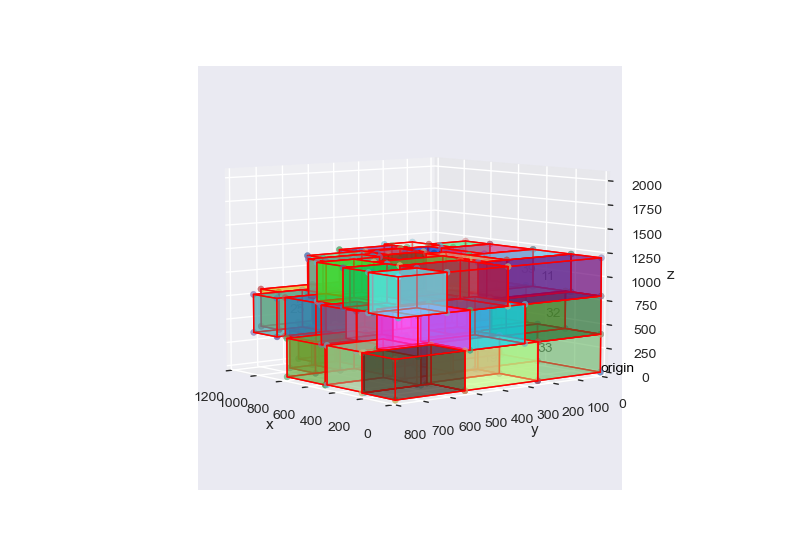

<IPython.core.display.Javascript object>

In [44]:
from src import main
from time import time

start = time()
cg_layer_pool, bins_lbs = main.main(order, use_cg=True, tlim=None)
total = time() - start
print("TOTAL TIME", total)
cg_bin_pool = pack.BinPool(cg_layer_pool, config.PALLET_DIMS)
cg_bin_pool.plot()

In [46]:
W, D, _ = config.PALLET_DIMS
print(cg_bin_pool.get_heights())
print(mr_bin_pool.get_heights())
print(cg_layer_pool.get_densities(W, D, two_dims=False))
print(mr_layer_pool.get_densities(W, D, two_dims=False))

[1200]
[1200]
[0.8895229166666667, 0.7886697916666666, 0.71184375]
[0.93044375, 0.9062677083333334, 0.553325]


<IPython.core.display.Javascript object>

In [125]:
from rectpack import newPacker, PackingMode, PackingBin, SORT_AREA
from rectpack.maxrects import MaxRectsBaf

# Create the maxrects packing algorithm
packer = newPacker(
    mode=PackingMode.Offline,
    bin_algo=PackingBin.Global,
    pack_algo=MaxRectsBaf,
    sort_algo=SORT_AREA,
    rotation=False,
)

# Add one bin representing one layer
packer.add_bin(100, 100, count=1)

packer.add_rect(10, 10, rid=0)
packer.add_rect(50, 50, rid=1)
packer.add_rect(60, 60, rid=2)

# Start the packing procedure
packer.pack()

packer.rect_list()

[(0, 0, 0, 60, 60, 2), (0, 60, 0, 10, 10, 0)]

<IPython.core.display.Javascript object>

## Todo 

### Problemi in Input al modello:
- [ ] Correggere gestione superitem in Heigth groups
    - Problema riguardo stesso Item nello stesso Layer dovuto a superitem Horizontal nei 2 assi -> (Messo in pausa, per ora risolto usando solo Vertical e Single superitems)
    - Suddividere gruppi in piu gruppi 
        - Solo fra superitem con > 1 item e superitem con = 1 item
- [x] Eliminare gruppi con 1 solo item e gruppi con densita minore di 0.5
- [x] Creare Vertical Superitems consistenti alla loro dimensione principale (Da rivedere in caso di aggiunta rotazione, come tutto...)
- [x] Corretto calcolo volume Superitems e aggiunto enclosing_volume per Vertical Superitems
- [ ] Rivedere lower bound martello (L1 viene 0) (L0 corretto) (L2 troppo lento)

### Problemi interni al modello:
- [x] Aggiunto reward in pricing_no_placement per incetivare la costruzione di layer più densi -> Con più item, quindi anche di item con Dual[i]==0, formula di reward con upper_bound = min(dual[i] !=0)
- [x] Modificato pricing placement (v2) per piazzare tutti gli item selezionati se possibile -> Molto lento con 13 item muore ma corretto rispetto a v1 che tendeva per costruzione a non piazzare tutta la sottoparte selezionata
- [x] Aggiunto maxrect placement per i nuovi layer del column generation

    
### Problemi in Output al modello:
- [ ] Aggiungere gestione Weigth a quella della Densità con qualche priorità e spiegazione annessa
- [x] Aggiungere gestione coordinate corretta per i Vertical Superitems, centrare gli oggetti nello spazio occupato
- [x] Controllare select_layer e aggiungere flag per utilizzare solo subset di sottoprocess per testing
- [ ] Sostituire item rimossi in fase di select_layers con altri item non piazzati, usando maxrects
    - [x] per ora: rearrange con maxrects e re-iterazione di tutto il processo con gli item non piazzati
- [x] Gestione Item rimanenti
    1. Piazzare gli ultimi item con algoritmo s-shape
    2. Provare a suddividere lo spazio rimanente in alto anche di layer incompleti in "Sotto pallet" ed usare maxrect su quelli (Magari funziona meglio)
- [ ] Gestione spaziatura 
    - Spaziatura intra-layer spiegata nel paper?
        1. 2 modelli di linear programming -> Spaziatura mediante modelli per width and depth dimensions
        2. Soluzione di spostamento monodirezionale iterativa dei blocchi di un layer (Da pensare per bene come alternativa a 1)
    - Spaziatura inter-layer in altezza
         1. Controllare spazi vuoti anche in altezza al termine di tutto usando una delle 2 tecnice sopradescritte
         
### Aggiunte eventuali
- [ ] Gestione rotazione
- [ ] Oggetti fragili -> Peso + attributi particolari


## TODO tomorrow
- Finire s-shaped
    - Rivedere caso piu di un layer in nuovo bin
- Convertire oggetti in immutabili
    - "If layer in self.layers" lento -> fare come in superitems?
- Solver e search strategy per column generation
    - Provato GLOP invece di CLP in RMP -> no change
    - Da provare: rimuovere SP quando si usa maxrects -> ordinare items in base ai duali e chiamare maxrects (packing effettuato su cosa ci entra nel layer)
- Rivedere lower bound
- Spaziatura